## Computer Vision Project
### Enhancing Historical Paintings with Super Resolution and Object Detection for Automatic Descriptions
Mert Can Köseoğlu - 2220356055

Cansu Aslan - 2210356079


In [6]:
# ✅ Install OpenCV Contrib (includes dnn_superres module)
!pip install opencv-contrib-python

In [9]:
!fusermount -u /content/drive
!rm -rf /content/drive

fusermount: failed to unmount /content/drive: Invalid argument


In [1]:
# ✅ Define your paths
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# ✅ Download EDSR model if not already present
import os
if not os.path.exists("EDSR_x4.pb"):
    !wget https://github.com/Saafke/EDSR_Tensorflow/raw/master/models/EDSR_x4.pb

import cv2
from cv2.dnn_superres import DnnSuperResImpl
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim



--2025-05-25 10:50:17--  https://github.com/Saafke/EDSR_Tensorflow/raw/master/models/EDSR_x4.pb
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Saafke/EDSR_Tensorflow/master/models/EDSR_x4.pb [following]
--2025-05-25 10:50:17--  https://raw.githubusercontent.com/Saafke/EDSR_Tensorflow/master/models/EDSR_x4.pb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38573255 (37M) [application/octet-stream]
Saving to: ‘EDSR_x4.pb’

EDSR_x4.pb          100%[===================>]  36.79M   221MB/s    in 0.2s    

2025-05-25 10:50:18 (221 MB/s) - ‘EDSR_x4.pb’ saved [38573255/38573255]



In [5]:
# === Updated Paths ===
dataset_path = "/content/drive/MyDrive/artworks/images/images"  # Your Google Drive dataset
drive_output_path = "/content/drive/MyDrive/artworks_superres"  # Output folder

# Load Super-Resolution model
sr = DnnSuperResImpl.create()
sr.readModel("EDSR_x4.pb")  # Make sure this model is uploaded in your Colab session
sr.setModel("edsr", 4)

# Process images per artist
processed_count = 0

for artist in tqdm(os.listdir(dataset_path), desc="Processing Artists"):
    artist_path = os.path.join(dataset_path, artist)
    if not os.path.isdir(artist_path):
        continue

    output_artist_folder = os.path.join(drive_output_path, artist)
    os.makedirs(output_artist_folder, exist_ok=True)

    for fname in os.listdir(artist_path):
        if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        in_path = os.path.join(artist_path, fname)
        out_path = os.path.join(output_artist_folder, fname)

        try:
            img = cv2.imread(in_path)
            if img is None:
                continue

            # Optional: simulate low-res degradation
            degraded = cv2.resize(img, (img.shape[1] // 4, img.shape[0] // 4), interpolation=cv2.INTER_LINEAR)

            # Apply SR
            sr_img = sr.upsample(degraded)

            # Resize back to original size
            sr_img = cv2.resize(sr_img, (img.shape[1], img.shape[0]))

            cv2.imwrite(out_path, sr_img)
            processed_count += 1

        except Exception as e:
            print(f"⚠️ Error processing {fname}: {e}")

print(f"\n✅ Done! {processed_count} images enhanced and saved to: {drive_output_path}")

Processing Artists: 100%|██████████| 25/25 [13:44:20<00:00, 1978.41s/it]


✅ Done! 4985 images enhanced and saved to: /content/drive/MyDrive/artworks_superres


In [13]:
# Fast PSNR
def fast_psnr(img1, img2):
    mse = np.mean((img1.astype(np.float32) - img2.astype(np.float32)) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(255.0 / np.sqrt(mse))

# Paths
original_folder = "/content/drive/MyDrive/artworks/images/images"
superres_folder = "/content/drive/MyDrive/artworks_superres"

# Metrics
total_psnr = 0
total_ssim = 0
count = 0

# Loop
for root, _, files in os.walk(superres_folder):
    for fname in files:
        if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        sr_path = os.path.join(root, fname)
        original_path = None
        for oroot, _, ofiles in os.walk(original_folder):
            if fname in ofiles:
                original_path = os.path.join(oroot, fname)
                break

        if original_path:
            hr = cv2.imread(original_path)
            sr = cv2.imread(sr_path)
            if hr is None or sr is None:
                continue

            sr = cv2.resize(sr, (hr.shape[1], hr.shape[0]))

            # Convert to RGB
            hr_rgb = cv2.cvtColor(hr, cv2.COLOR_BGR2RGB)
            sr_rgb = cv2.cvtColor(sr, cv2.COLOR_BGR2RGB)

            total_psnr += fast_psnr(hr_rgb, sr_rgb)
            # Optional: skip SSIM for all images to speed up
            count += 1

# Results
if count > 0:
    print(f"\n📊 Average PSNR (fast): {total_psnr / count:.2f}")
else:
    print("❌ No valid images processed.")


📊 Average PSNR (fast): 26.50


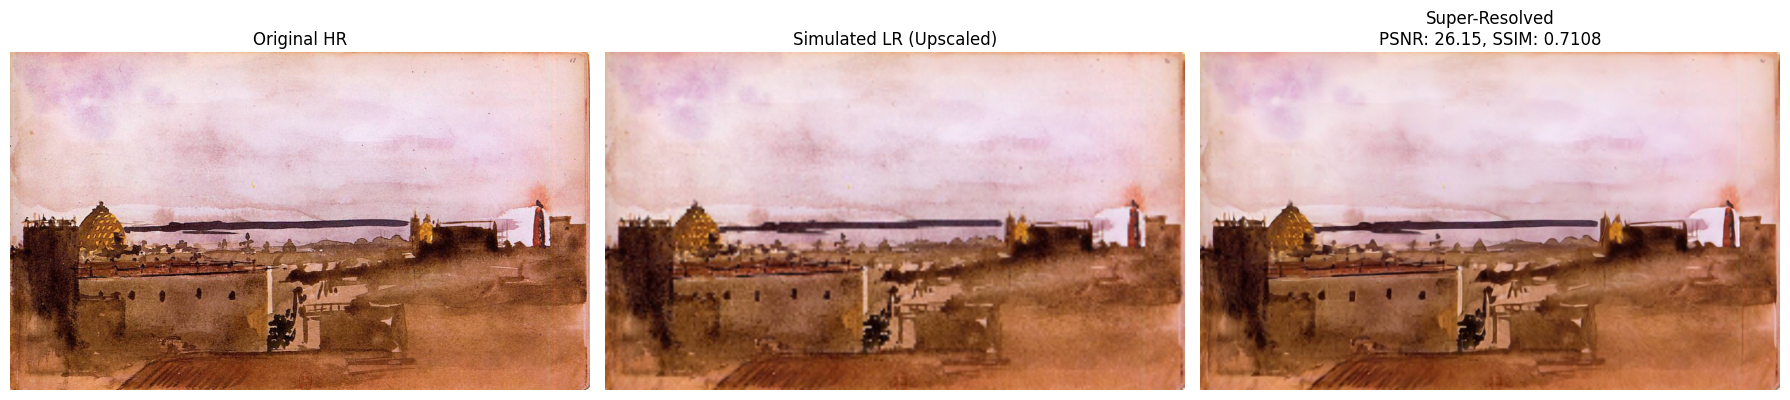

In [14]:
# === Define paths ===
hr_path = "/content/drive/MyDrive/artworks/images/images/Edgar_Degas/Edgar_Degas_518.jpg"
sr_path = "/content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_518.jpg"

# === Load images ===
hr = cv2.imread(hr_path)
sr = cv2.imread(sr_path)

if hr is None or sr is None:
    print("❌ Could not load HR or SR image. Please check the paths.")
else:
    # === Simulate LR ===
    lr = cv2.resize(hr, (hr.shape[1] // 4, hr.shape[0] // 4), interpolation=cv2.INTER_LINEAR)
    lr = cv2.resize(lr, (hr.shape[1], hr.shape[0]), interpolation=cv2.INTER_LINEAR)

    # === Convert to RGB for display ===
    hr_rgb = cv2.cvtColor(hr, cv2.COLOR_BGR2RGB)
    sr_rgb = cv2.cvtColor(sr, cv2.COLOR_BGR2RGB)
    lr_rgb = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB)

    # === Compute PSNR ===
    def fast_psnr(img1, img2):
        mse = np.mean((img1.astype(np.float32) - img2.astype(np.float32)) ** 2)
        if mse == 0:
            return 100
        return 20 * np.log10(255.0 / np.sqrt(mse))

    psnr_score = fast_psnr(hr_rgb, sr_rgb)
    ssim_score = ssim(hr_rgb, sr_rgb, channel_axis=-1)

    # === Display side-by-side ===
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    axs[0].imshow(hr_rgb); axs[0].set_title("Original HR")
    axs[1].imshow(lr_rgb); axs[1].set_title("Simulated LR (Upscaled)")
    axs[2].imshow(sr_rgb); axs[2].set_title(f"Super-Resolved\nPSNR: {psnr_score:.2f}, SSIM: {ssim_score:.4f}")
    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
# === Fast PSNR ===
def fast_psnr(img1, img2):
    mse = np.mean((img1.astype(np.float32) - img2.astype(np.float32)) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(255.0 / np.sqrt(mse))

# === Paths ===
hr_root = "/content/drive/MyDrive/artworks/images/images"
sr_root = "/content/drive/MyDrive/artworks_superres"

# === Collect 10 artist folders ===
artist_folders = sorted([a for a in os.listdir(hr_root) if os.path.isdir(os.path.join(hr_root, a))])[:10]

# === Process and show each ===
for artist in artist_folders:
    hr_folder = os.path.join(hr_root, artist)
    sr_folder = os.path.join(sr_root, artist)

    # Find first image in this artist's folder
    images = [f for f in os.listdir(hr_folder) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    if not images:
        continue

    fname = images[0]
    hr_path = os.path.join(hr_folder, fname)
    sr_path = os.path.join(sr_folder, fname)

    hr = cv2.imread(hr_path)
    sr = cv2.imread(sr_path)

    if hr is None or sr is None:
        print(f"❌ Could not load image: {fname} for artist {artist}")
        continue

    # Simulate LR
    lr = cv2.resize(hr, (hr.shape[1] // 4, hr.shape[0] // 4), interpolation=cv2.INTER_LINEAR)
    lr = cv2.resize(lr, (hr.shape[1], hr.shape[0]), interpolation=cv2.INTER_LINEAR)

    # Convert to RGB
    hr_rgb = cv2.cvtColor(hr, cv2.COLOR_BGR2RGB)
    sr_rgb = cv2.cvtColor(sr, cv2.COLOR_BGR2RGB)
    lr_rgb = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB)

    # Metrics
    psnr_score = fast_psnr(hr_rgb, sr_rgb)
    ssim_score = ssim(hr_rgb, sr_rgb, channel_axis=-1)

    # === Display ===
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    axs[0].imshow(hr_rgb); axs[0].set_title("Original HR")
    axs[1].imshow(lr_rgb); axs[1].set_title("Simulated LR (Upscaled)")
    axs[2].imshow(sr_rgb); axs[2].set_title(f"Super-Resolved\nPSNR: {psnr_score:.2f}, SSIM: {ssim_score:.4f}")
    for ax in axs:
        ax.axis("off")
    fig.suptitle(f"{artist} - {fname}", fontsize=14)
    plt.tight_layout()
    plt.show()

In [2]:
# 1. Install YOLOv8
!pip install -q ultralytics
from ultralytics import YOLO
import os
import cv2
import numpy as np
from shutil import copy2
from sklearn.model_selection import train_test_split
from tqdm import tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.0 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultra

In [2]:
# 2. Define paths
superres_path = "/content/drive/MyDrive/artworks_superres"
yolo_base = "/content/drive/MyDrive/yolo_art_dataset"
image_dir = os.path.join(yolo_base, "images")
label_dir = os.path.join(yolo_base, "labels")

# 3. Create directory structure
for subset in ["train", "val"]:
    os.makedirs(os.path.join(image_dir, subset), exist_ok=True)
    os.makedirs(os.path.join(label_dir, subset), exist_ok=True)

In [11]:
# 4. Collect all image paths
image_paths = []
for artist in os.listdir(superres_path):
    artist_path = os.path.join(superres_path, artist)
    if not os.path.isdir(artist_path):
        continue
    for fname in os.listdir(artist_path):
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            image_paths.append(os.path.join(artist_path, fname))

# 5. Split into train/val
train_paths, val_paths = train_test_split(image_paths, test_size=0.2, random_state=42)


In [14]:
# 6. Load YOLOv8 pre-trained model
model = YOLO("yolov8n.pt")  # You can use yolov8s.pt for better performance

# 7. Auto-label and convert to YOLO format
def save_yolo_labels(img_path, results, label_out_path):
    import os
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    lines = []

    for box in results[0].boxes:
        cls = int(box.cls)
        x1, y1, x2, y2 = box.xyxy[0]
        cx = ((x1 + x2) / 2) / w
        cy = ((y1 + y2) / 2) / h
        bw = (x2 - x1) / w
        bh = (y2 - y1) / h
        lines.append(f"{cls} {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}")

    # ✅ Make sure the folder exists before writing the file
    os.makedirs(os.path.dirname(label_out_path), exist_ok=True)

    with open(label_out_path, "w") as f:
        f.write("\n".join(lines))


In [16]:
# 8. Process images
for path_set, split in zip([train_paths, val_paths], ["train", "val"]):
    print(f"🔁 Processing {split} set with {len(path_set)} images...")
    for img_path in tqdm(path_set):
        fname = os.path.basename(img_path)
        label_name = fname.rsplit(".", 1)[0] + ".txt"

        out_img = os.path.join(image_dir, split, fname)
        out_lbl = os.path.join(label_dir, split, label_name)

        result = model(img_path)
        save_yolo_labels(img_path, result, out_lbl)
        os.makedirs(os.path.dirname(out_img), exist_ok=True)
        copy2(img_path, out_img)

print("✅ Auto-labeling complete.")

🔁 Processing train set with 3988 images...


  0%|          | 0/3988 [00:00<?, ?it/s]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_112.jpg: 544x640 1 person, 1 bed, 8.9ms
Speed: 3.4ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_100.jpg: 480x640 (no detections), 42.4ms
Speed: 2.8ms preprocess, 42.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


  0%|          | 2/3988 [00:02<1:21:36,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_406.jpg: 640x448 1 horse, 43.0ms
Speed: 2.6ms preprocess, 43.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)


  0%|          | 3/3988 [00:04<1:31:47,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_16.jpg: 512x640 2 persons, 41.3ms
Speed: 2.8ms preprocess, 41.3ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 640)


  0%|          | 4/3988 [00:05<1:29:53,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_19.jpg: 640x640 3 persons, 8.8ms
Speed: 3.6ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 5/3988 [00:07<1:37:00,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_133.jpg: 640x448 1 vase, 9.2ms
Speed: 2.4ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


  0%|          | 6/3988 [00:08<1:37:05,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_61.jpg: 640x576 1 person, 42.4ms
Speed: 2.6ms preprocess, 42.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 576)


  0%|          | 7/3988 [00:09<1:35:48,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_30.jpg: 320x640 (no detections), 47.9ms
Speed: 1.9ms preprocess, 47.9ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)


  0%|          | 8/3988 [00:11<1:38:16,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_99.jpg: 608x640 3 persons, 1 orange, 41.7ms
Speed: 3.1ms preprocess, 41.7ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)


  0%|          | 9/3988 [00:12<1:30:19,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_129.jpg: 640x384 1 dog, 42.4ms
Speed: 2.4ms preprocess, 42.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


  0%|          | 10/3988 [00:14<1:36:16,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_7.jpg: 640x512 2 persons, 40.9ms
Speed: 3.2ms preprocess, 40.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


  0%|          | 11/3988 [00:16<1:59:34,  1.80s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_83.jpg: 480x640 1 person, 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


  0%|          | 12/3988 [00:18<1:48:57,  1.64s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_109.jpg: 512x640 (no detections), 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


  0%|          | 13/3988 [00:20<2:12:18,  2.00s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_101.jpg: 416x640 (no detections), 42.0ms
Speed: 2.1ms preprocess, 42.0ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


  0%|          | 14/3988 [00:22<1:56:05,  1.75s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_1.jpg: 480x640 4 persons, 1 boat, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


  0%|          | 15/3988 [00:23<1:56:41,  1.76s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_160.jpg: 640x512 1 person, 1 chair, 7.7ms
Speed: 3.2ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


  0%|          | 16/3988 [00:25<1:47:19,  1.62s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_99.jpg: 640x448 (no detections), 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


  0%|          | 17/3988 [00:27<1:55:30,  1.75s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_86.jpg: 640x480 1 person, 41.0ms
Speed: 2.7ms preprocess, 41.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


  0%|          | 18/3988 [00:28<1:53:51,  1.72s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_5.jpg: 544x640 (no detections), 14.4ms
Speed: 4.4ms preprocess, 14.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


  0%|          | 19/3988 [00:30<2:01:19,  1.83s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_57.jpg: 640x576 1 person, 1 teddy bear, 10.9ms
Speed: 5.0ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


  1%|          | 20/3988 [00:32<1:57:29,  1.78s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_24.jpg: 640x512 1 person, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


  1%|          | 21/3988 [00:33<1:48:39,  1.64s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_78.jpg: 640x512 (no detections), 13.5ms
Speed: 3.5ms preprocess, 13.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 512)


  1%|          | 22/3988 [00:35<1:44:15,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_641.jpg: 544x640 2 persons, 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


  1%|          | 23/3988 [00:37<1:49:18,  1.65s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_70.jpg: 640x576 2 persons, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


  1%|          | 24/3988 [00:38<1:45:15,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_169.jpg: 544x640 (no detections), 15.4ms
Speed: 4.8ms preprocess, 15.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


  1%|          | 25/3988 [00:40<1:40:39,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_21.jpg: 640x640 (no detections), 13.9ms
Speed: 2.8ms preprocess, 13.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 26/3988 [00:41<1:32:37,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_7.jpg: 640x544 3 persons, 42.4ms
Speed: 3.1ms preprocess, 42.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


  1%|          | 27/3988 [00:42<1:29:50,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_595.jpg: 640x512 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


  1%|          | 28/3988 [00:43<1:33:45,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_333.jpg: 640x512 (no detections), 7.4ms
Speed: 2.7ms preprocess, 7.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


  1%|          | 29/3988 [00:45<1:29:18,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_167.jpg: 640x512 2 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)


  1%|          | 30/3988 [00:46<1:31:27,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_25.jpg: 640x480 1 person, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


  1%|          | 31/3988 [00:48<1:32:52,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_258.jpg: 640x544 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


  1%|          | 32/3988 [00:49<1:36:09,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_18.jpg: 544x640 3 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


  1%|          | 33/3988 [00:51<1:38:57,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_101.jpg: 640x544 1 person, 1 dog, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


  1%|          | 34/3988 [00:52<1:36:43,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_73.jpg: 448x640 (no detections), 45.5ms
Speed: 2.5ms preprocess, 45.5ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


  1%|          | 35/3988 [00:54<1:39:49,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_196.jpg: 640x512 1 person, 9.3ms
Speed: 3.5ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)


  1%|          | 36/3988 [00:55<1:40:22,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_669.jpg: 640x416 1 person, 1 bench, 1 chair, 41.3ms
Speed: 2.5ms preprocess, 41.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


  1%|          | 37/3988 [00:57<1:37:05,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_136.jpg: 480x640 1 person, 2 horses, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


  1%|          | 38/3988 [00:58<1:30:24,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_64.jpg: 640x448 1 person, 9.3ms
Speed: 3.1ms preprocess, 9.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


  1%|          | 39/3988 [00:59<1:32:53,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_102.jpg: 416x640 (no detections), 9.6ms
Speed: 3.0ms preprocess, 9.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


  1%|          | 40/3988 [01:01<1:31:35,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_75.jpg: 640x288 1 person, 53.4ms
Speed: 2.6ms preprocess, 53.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)


  1%|          | 41/3988 [01:02<1:30:10,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_14.jpg: 640x512 4 persons, 15.7ms
Speed: 4.3ms preprocess, 15.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 512)


  1%|          | 42/3988 [01:03<1:29:19,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_43.jpg: 640x544 1 potted plant, 1 vase, 9.7ms
Speed: 2.9ms preprocess, 9.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)


  1%|          | 43/3988 [01:05<1:27:49,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_789.jpg: 640x480 1 cow, 9.6ms
Speed: 4.6ms preprocess, 9.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


  1%|          | 44/3988 [01:06<1:34:49,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_178.jpg: 640x512 1 person, 13.7ms
Speed: 4.0ms preprocess, 13.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 512)


  1%|          | 45/3988 [01:07<1:29:27,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_7.jpg: 640x608 (no detections), 40.1ms
Speed: 2.9ms preprocess, 40.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


  1%|          | 46/3988 [01:09<1:30:11,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_127.jpg: 640x640 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 47/3988 [01:10<1:25:43,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_632.jpg: 640x512 2 persons, 1 cup, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


  1%|          | 48/3988 [01:12<1:39:33,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_145.jpg: 640x416 1 person, 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


  1%|          | 49/3988 [01:14<1:49:41,  1.67s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_9.jpg: 384x640 (no detections), 40.0ms
Speed: 2.1ms preprocess, 40.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


  1%|▏         | 50/3988 [01:15<1:44:29,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_11.jpg: 416x640 (no detections), 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


  1%|▏         | 51/3988 [01:17<1:41:22,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_43.jpg: 640x480 1 pizza, 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


  1%|▏         | 52/3988 [01:18<1:39:01,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_124.jpg: 512x640 (no detections), 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


  1%|▏         | 53/3988 [01:20<1:34:10,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_1.jpg: 640x544 1 broccoli, 9.5ms
Speed: 2.8ms preprocess, 9.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


  1%|▏         | 54/3988 [01:21<1:33:14,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_239.jpg: 640x480 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


  1%|▏         | 55/3988 [01:22<1:34:37,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_235.jpg: 512x640 (no detections), 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


  1%|▏         | 56/3988 [01:24<1:36:10,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_31.jpg: 512x640 2 persons, 7.2ms
Speed: 2.7ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


  1%|▏         | 57/3988 [01:26<1:43:22,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_658.jpg: 640x512 1 person, 8.4ms
Speed: 2.6ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


  1%|▏         | 58/3988 [01:27<1:42:08,  1.56s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_46.jpg: 640x512 (no detections), 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


  1%|▏         | 59/3988 [01:29<1:47:40,  1.64s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_199.jpg: 448x640 3 persons, 1 teddy bear, 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


  2%|▏         | 60/3988 [01:30<1:40:44,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_41.jpg: 512x640 (no detections), 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


  2%|▏         | 61/3988 [01:32<1:35:14,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_8.jpg: 448x640 1 boat, 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


  2%|▏         | 62/3988 [01:33<1:37:26,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_131.jpg: 640x512 1 chair, 1 vase, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


  2%|▏         | 63/3988 [01:36<2:06:59,  1.94s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_546.jpg: 640x512 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


  2%|▏         | 64/3988 [01:38<2:10:06,  1.99s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_54.jpg: 640x512 1 person, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


  2%|▏         | 65/3988 [01:40<1:56:48,  1.79s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_824.jpg: 544x640 (no detections), 9.0ms
Speed: 3.3ms preprocess, 9.0ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


  2%|▏         | 66/3988 [01:41<1:52:36,  1.72s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_36.jpg: 640x544 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


  2%|▏         | 67/3988 [01:43<1:47:22,  1.64s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_6.jpg: 640x384 2 persons, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


  2%|▏         | 68/3988 [01:44<1:39:36,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_400.jpg: 544x640 (no detections), 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


  2%|▏         | 69/3988 [01:46<1:43:07,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_299.jpg: 384x640 2 persons, 4 horses, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


  2%|▏         | 70/3988 [01:47<1:42:32,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_872.jpg: 640x480 1 potted plant, 1 vase, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


  2%|▏         | 71/3988 [01:49<1:41:55,  1.56s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_120.jpg: 640x416 1 person, 7.9ms
Speed: 2.1ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


  2%|▏         | 72/3988 [01:50<1:35:33,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_40.jpg: 512x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


  2%|▏         | 73/3988 [01:52<1:51:13,  1.70s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_98.jpg: 608x640 1 person, 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)


  2%|▏         | 74/3988 [01:53<1:37:02,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_309.jpg: 640x576 2 persons, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


  2%|▏         | 75/3988 [01:54<1:27:20,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_576.jpg: 448x640 (no detections), 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


  2%|▏         | 76/3988 [01:55<1:25:10,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_400.jpg: 640x480 1 person, 1 cup, 8.7ms
Speed: 2.6ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


  2%|▏         | 77/3988 [01:57<1:30:35,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_296.jpg: 512x640 (no detections), 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


  2%|▏         | 78/3988 [01:59<1:41:14,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_15.jpg: 480x640 (no detections), 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


  2%|▏         | 79/3988 [02:00<1:35:47,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_54.jpg: 640x544 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


  2%|▏         | 80/3988 [02:02<1:34:15,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_101.jpg: 640x640 (no detections), 8.9ms
Speed: 3.4ms preprocess, 8.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 81/3988 [02:03<1:31:09,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_178.jpg: 480x640 1 person, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


  2%|▏         | 82/3988 [02:04<1:33:31,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_25.jpg: 480x640 (no detections), 7.1ms
Speed: 2.9ms preprocess, 7.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


  2%|▏         | 83/3988 [02:06<1:30:23,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_82.jpg: 640x608 (no detections), 9.1ms
Speed: 3.2ms preprocess, 9.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


  2%|▏         | 84/3988 [02:07<1:28:51,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_271.jpg: 480x640 (no detections), 11.4ms
Speed: 2.7ms preprocess, 11.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


  2%|▏         | 85/3988 [02:08<1:26:47,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_111.jpg: 640x448 1 donut, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


  2%|▏         | 86/3988 [02:11<1:44:14,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_15.jpg: 512x640 1 giraffe, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


  2%|▏         | 87/3988 [02:12<1:37:44,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_434.jpg: 512x640 2 persons, 1 cow, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


  2%|▏         | 88/3988 [02:13<1:35:04,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_45.jpg: 640x512 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


  2%|▏         | 89/3988 [02:15<1:37:36,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_115.jpg: 640x480 1 person, 1 dog, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


  2%|▏         | 90/3988 [02:16<1:27:32,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_90.jpg: 640x544 1 person, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


  2%|▏         | 91/3988 [02:17<1:31:47,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_108.jpg: 640x288 (no detections), 10.1ms
Speed: 2.5ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 288)


  2%|▏         | 92/3988 [02:19<1:32:06,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_11.jpg: 480x640 1 bed, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


  2%|▏         | 93/3988 [02:20<1:27:14,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_81.jpg: 640x480 1 person, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


  2%|▏         | 94/3988 [02:21<1:30:40,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_86.jpg: 640x384 1 person, 1 chair, 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


  2%|▏         | 95/3988 [02:23<1:26:18,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_35.jpg: 640x640 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 96/3988 [02:24<1:24:54,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_83.jpg: 640x576 1 person, 8.8ms
Speed: 3.5ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


  2%|▏         | 97/3988 [02:25<1:27:17,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_44.jpg: 640x544 1 person, 1 bed, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


  2%|▏         | 98/3988 [02:27<1:33:08,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_353.jpg: 512x640 3 persons, 1 handbag, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


  2%|▏         | 99/3988 [02:28<1:31:13,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_23.jpg: 640x576 (no detections), 10.4ms
Speed: 3.0ms preprocess, 10.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


  3%|▎         | 100/3988 [02:30<1:29:43,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_45.jpg: 448x640 (no detections), 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


  3%|▎         | 101/3988 [02:31<1:30:02,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_96.jpg: 640x512 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


  3%|▎         | 102/3988 [02:32<1:26:57,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_50.jpg: 352x640 1 dog, 42.7ms
Speed: 2.1ms preprocess, 42.7ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)


  3%|▎         | 103/3988 [02:33<1:20:38,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_311.jpg: 640x544 1 person, 9.3ms
Speed: 3.1ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


  3%|▎         | 104/3988 [02:35<1:25:22,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_203.jpg: 640x640 1 person, 1 bed, 1 book, 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 105/3988 [02:36<1:27:41,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_788.jpg: 640x544 1 person, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


  3%|▎         | 106/3988 [02:38<1:26:14,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_285.jpg: 608x640 2 persons, 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)


  3%|▎         | 107/3988 [02:39<1:27:15,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_770.jpg: 640x512 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


  3%|▎         | 108/3988 [02:41<1:33:31,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_211.jpg: 640x544 2 persons, 9.1ms
Speed: 3.6ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


  3%|▎         | 109/3988 [02:42<1:29:25,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_25.jpg: 640x544 1 person, 1 cup, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


  3%|▎         | 110/3988 [02:43<1:28:04,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_677.jpg: 512x640 1 horse, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


  3%|▎         | 111/3988 [02:44<1:26:18,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_151.jpg: 640x448 (no detections), 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


  3%|▎         | 112/3988 [02:46<1:31:42,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_636.jpg: 512x640 (no detections), 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


  3%|▎         | 113/3988 [02:47<1:27:54,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_114.jpg: 640x480 (no detections), 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


  3%|▎         | 114/3988 [02:49<1:30:20,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_735.jpg: 544x640 6 persons, 1 kite, 8.5ms
Speed: 3.4ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


  3%|▎         | 115/3988 [02:50<1:28:06,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_117.jpg: 640x448 (no detections), 8.0ms
Speed: 2.1ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


  3%|▎         | 116/3988 [02:51<1:26:39,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_240.jpg: 640x576 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


  3%|▎         | 117/3988 [02:53<1:26:31,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_466.jpg: 640x512 3 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


  3%|▎         | 118/3988 [02:54<1:25:24,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_374.jpg: 512x640 1 cow, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


  3%|▎         | 119/3988 [02:55<1:26:43,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_426.jpg: 576x640 (no detections), 41.3ms
Speed: 3.2ms preprocess, 41.3ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)


  3%|▎         | 120/3988 [02:57<1:26:10,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_81.jpg: 640x544 (no detections), 8.5ms
Speed: 3.4ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


  3%|▎         | 121/3988 [02:58<1:32:30,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_422.jpg: 512x640 1 zebra, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


  3%|▎         | 122/3988 [03:00<1:34:13,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_173.jpg: 640x544 1 person, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


  3%|▎         | 123/3988 [03:01<1:26:36,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_35.jpg: 640x576 (no detections), 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


  3%|▎         | 124/3988 [03:02<1:20:59,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_12.jpg: 640x448 1 dog, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


  3%|▎         | 125/3988 [03:03<1:25:23,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_48.jpg: 512x640 (no detections), 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


  3%|▎         | 126/3988 [03:05<1:28:24,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_61.jpg: 640x512 1 dog, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


  3%|▎         | 127/3988 [03:07<1:32:33,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_477.jpg: 512x640 (no detections), 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


  3%|▎         | 128/3988 [03:08<1:30:01,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_38.jpg: 640x640 1 vase, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 129/3988 [03:09<1:27:23,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_652.jpg: 640x608 1 bear, 8.6ms
Speed: 3.7ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)


  3%|▎         | 130/3988 [03:11<1:31:08,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_57.jpg: 640x480 2 persons, 1 teddy bear, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


  3%|▎         | 131/3988 [03:12<1:27:09,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_358.jpg: 640x480 (no detections), 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


  3%|▎         | 132/3988 [03:13<1:27:45,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_78.jpg: 640x480 1 person, 1 cow, 7.6ms
Speed: 2.5ms preprocess, 7.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


  3%|▎         | 133/3988 [03:14<1:23:54,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_825.jpg: 640x512 (no detections), 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


  3%|▎         | 134/3988 [03:16<1:25:36,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_9.jpg: 480x640 (no detections), 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


  3%|▎         | 135/3988 [03:17<1:29:36,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_41.jpg: 640x448 (no detections), 8.5ms
Speed: 2.3ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


  3%|▎         | 136/3988 [03:18<1:22:48,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_76.jpg: 640x544 1 person, 8.9ms
Speed: 3.1ms preprocess, 8.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)


  3%|▎         | 137/3988 [03:20<1:21:43,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_79.jpg: 640x640 (no detections), 8.7ms
Speed: 3.5ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 138/3988 [03:21<1:19:39,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_86.jpg: 640x448 (no detections), 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


  3%|▎         | 139/3988 [03:22<1:24:58,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_525.jpg: 640x544 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 544)


  4%|▎         | 140/3988 [03:24<1:24:23,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_106.jpg: 608x640 (no detections), 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)


  4%|▎         | 141/3988 [03:25<1:27:08,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_72.jpg: 640x544 1 dog, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


  4%|▎         | 142/3988 [03:26<1:26:02,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_96.jpg: 640x576 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 576)


  4%|▎         | 143/3988 [03:28<1:25:27,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_62.jpg: 640x448 1 toilet, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


  4%|▎         | 144/3988 [03:29<1:30:10,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_392.jpg: 640x448 2 persons, 7.4ms
Speed: 2.7ms preprocess, 7.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


  4%|▎         | 145/3988 [03:31<1:27:28,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_405.jpg: 640x608 1 bird, 1 potted plant, 9.3ms
Speed: 3.3ms preprocess, 9.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 608)


  4%|▎         | 146/3988 [03:32<1:22:30,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_802.jpg: 640x512 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


  4%|▎         | 147/3988 [03:33<1:21:48,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_288.jpg: 544x640 (no detections), 9.4ms
Speed: 3.4ms preprocess, 9.4ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


  4%|▎         | 148/3988 [03:35<1:33:08,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_107.jpg: 640x448 1 teddy bear, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


  4%|▎         | 149/3988 [03:36<1:31:41,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_56.jpg: 640x512 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


  4%|▍         | 150/3988 [03:38<1:32:59,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_186.jpg: 512x640 5 persons, 1 bench, 1 chair, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


  4%|▍         | 151/3988 [03:39<1:28:48,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_192.jpg: 544x640 2 persons, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


  4%|▍         | 152/3988 [03:40<1:31:22,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_19.jpg: 512x640 (no detections), 11.4ms
Speed: 2.9ms preprocess, 11.4ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


  4%|▍         | 153/3988 [03:42<1:28:20,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_289.jpg: 544x640 (no detections), 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


  4%|▍         | 154/3988 [03:43<1:23:17,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_500.jpg: 640x512 1 person, 1 dog, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


  4%|▍         | 155/3988 [03:44<1:30:18,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_350.jpg: 640x480 2 persons, 8.3ms
Speed: 2.5ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


  4%|▍         | 156/3988 [03:46<1:25:02,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_253.jpg: 640x544 1 person, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


  4%|▍         | 157/3988 [03:47<1:28:51,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_352.jpg: 480x640 2 persons, 1 umbrella, 8.3ms
Speed: 3.3ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


  4%|▍         | 158/3988 [03:49<1:41:32,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_573.jpg: 512x640 (no detections), 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


  4%|▍         | 159/3988 [03:51<1:54:05,  1.79s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_254.jpg: 544x640 2 persons, 9.7ms
Speed: 3.6ms preprocess, 9.7ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


  4%|▍         | 160/3988 [03:53<1:43:49,  1.63s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_767.jpg: 448x640 (no detections), 10.0ms
Speed: 2.7ms preprocess, 10.0ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


  4%|▍         | 161/3988 [03:54<1:41:15,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_163.jpg: 640x640 (no detections), 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 162/3988 [03:56<1:37:08,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_74.jpg: 480x640 4 persons, 2 horses, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


  4%|▍         | 163/3988 [03:57<1:34:48,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_227.jpg: 640x544 (no detections), 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


  4%|▍         | 164/3988 [03:58<1:33:42,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_54.jpg: 640x640 1 umbrella, 8.8ms
Speed: 3.6ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 165/3988 [04:00<1:40:34,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_146.jpg: 640x480 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


  4%|▍         | 166/3988 [04:01<1:30:41,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_46.jpg: 640x544 1 dog, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


  4%|▍         | 167/3988 [04:03<1:32:41,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_568.jpg: 640x384 1 potted plant, 1 vase, 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


  4%|▍         | 168/3988 [04:04<1:33:14,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_18.jpg: 160x640 3 persons, 45.2ms
Speed: 1.4ms preprocess, 45.2ms inference, 1.7ms postprocess per image at shape (1, 3, 160, 640)


  4%|▍         | 169/3988 [04:06<1:37:45,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_153.jpg: 640x576 1 person, 1 tie, 9.2ms
Speed: 3.1ms preprocess, 9.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


  4%|▍         | 170/3988 [04:08<1:37:48,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_33.jpg: 320x640 12 persons, 8.6ms
Speed: 2.1ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)


  4%|▍         | 171/3988 [04:09<1:37:05,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_167.jpg: 640x512 1 person, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


  4%|▍         | 172/3988 [04:10<1:34:23,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_233.jpg: 640x512 2 persons, 1 tie, 7.4ms
Speed: 3.1ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


  4%|▍         | 173/3988 [04:12<1:31:30,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_254.jpg: 640x480 1 bird, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


  4%|▍         | 174/3988 [04:13<1:29:13,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_227.jpg: 640x544 2 persons, 8.9ms
Speed: 3.1ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


  4%|▍         | 175/3988 [04:15<1:32:55,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_141.jpg: 640x544 2 persons, 8.0ms
Speed: 3.5ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


  4%|▍         | 176/3988 [04:19<2:32:18,  2.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_14.jpg: 640x512 1 cake, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


  4%|▍         | 177/3988 [04:21<2:10:59,  2.06s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_15.jpg: 640x480 2 persons, 1 horse, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


  4%|▍         | 178/3988 [04:22<1:59:05,  1.88s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_212.jpg: 640x640 1 person, 2 beds, 8.7ms
Speed: 3.5ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 179/3988 [04:24<1:53:50,  1.79s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_373.jpg: 512x640 3 persons, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


  5%|▍         | 180/3988 [04:25<1:53:55,  1.80s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_397.jpg: 544x640 (no detections), 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


  5%|▍         | 181/3988 [04:27<1:48:57,  1.72s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_102.jpg: 320x640 8 persons, 8.1ms
Speed: 2.0ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)


  5%|▍         | 182/3988 [04:28<1:44:58,  1.65s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_346.jpg: 640x416 1 person, 1 giraffe, 9.0ms
Speed: 2.5ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


  5%|▍         | 183/3988 [04:30<1:36:52,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_26.jpg: 640x512 4 persons, 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


  5%|▍         | 184/3988 [04:31<1:30:52,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_17.jpg: 640x352 (no detections), 41.9ms
Speed: 2.0ms preprocess, 41.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


  5%|▍         | 185/3988 [04:32<1:28:49,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_12.jpg: 640x512 (no detections), 10.0ms
Speed: 2.4ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


  5%|▍         | 186/3988 [04:33<1:25:59,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_50.jpg: 640x544 (no detections), 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


  5%|▍         | 187/3988 [04:35<1:24:06,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_178.jpg: 640x512 1 bird, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


  5%|▍         | 188/3988 [04:36<1:23:04,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_667.jpg: 640x384 1 person, 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


  5%|▍         | 189/3988 [04:38<1:33:04,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_571.jpg: 640x512 1 dog, 1 bowl, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


  5%|▍         | 190/3988 [04:39<1:27:05,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_59.jpg: 640x544 1 person, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 544)


  5%|▍         | 191/3988 [04:40<1:26:06,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_94.jpg: 448x640 (no detections), 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


  5%|▍         | 192/3988 [04:42<1:26:03,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_818.jpg: 544x640 3 boats, 8.8ms
Speed: 3.3ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


  5%|▍         | 193/3988 [04:43<1:31:02,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_108.jpg: 224x640 1 dog, 43.8ms
Speed: 1.7ms preprocess, 43.8ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 640)


  5%|▍         | 194/3988 [04:45<1:29:09,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_13.jpg: 544x640 (no detections), 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


  5%|▍         | 195/3988 [04:46<1:31:28,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_11.jpg: 640x384 (no detections), 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)


  5%|▍         | 196/3988 [04:47<1:22:42,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_45.jpg: 640x448 1 person, 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


  5%|▍         | 197/3988 [04:48<1:21:30,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_98.jpg: 640x512 (no detections), 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


  5%|▍         | 198/3988 [04:49<1:14:26,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Jackson_Pollock/Jackson_Pollock_18.jpg: 288x640 (no detections), 41.5ms
Speed: 1.7ms preprocess, 41.5ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 640)


  5%|▍         | 199/3988 [04:51<1:25:03,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_85.jpg: 480x640 (no detections), 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


  5%|▌         | 200/3988 [04:52<1:20:25,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_91.jpg: 640x640 (no detections), 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


  5%|▌         | 201/3988 [04:54<1:39:39,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_166.jpg: 448x640 6 persons, 1 chair, 9.1ms
Speed: 2.7ms preprocess, 9.1ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


  5%|▌         | 202/3988 [04:56<1:32:55,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Jackson_Pollock/Jackson_Pollock_3.jpg: 288x640 (no detections), 8.2ms
Speed: 1.9ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 640)


  5%|▌         | 203/3988 [04:57<1:28:50,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_444.jpg: 448x640 (no detections), 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


  5%|▌         | 204/3988 [04:58<1:26:29,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_64.jpg: 544x640 1 person, 1 umbrella, 1 potted plant, 10.5ms
Speed: 3.5ms preprocess, 10.5ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


  5%|▌         | 205/3988 [05:00<1:28:21,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_38.jpg: 640x256 3 persons, 41.2ms
Speed: 1.9ms preprocess, 41.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


  5%|▌         | 206/3988 [05:01<1:33:18,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_723.jpg: 480x640 11 persons, 1 truck, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


  5%|▌         | 207/3988 [05:03<1:35:39,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_535.jpg: 544x640 (no detections), 8.7ms
Speed: 3.5ms preprocess, 8.7ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


  5%|▌         | 208/3988 [05:05<1:36:59,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_52.jpg: 448x640 4 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


  5%|▌         | 209/3988 [05:06<1:37:32,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_90.jpg: 544x640 (no detections), 10.2ms
Speed: 4.4ms preprocess, 10.2ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


  5%|▌         | 210/3988 [05:07<1:28:47,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_72.jpg: 640x448 1 person, 2 ties, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


  5%|▌         | 211/3988 [05:08<1:24:03,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_421.jpg: 640x448 (no detections), 7.4ms
Speed: 2.6ms preprocess, 7.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


  5%|▌         | 212/3988 [05:10<1:25:15,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_99.jpg: 640x512 1 person, 1 horse, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


  5%|▌         | 213/3988 [05:11<1:24:57,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_261.jpg: 640x512 1 person, 1 dog, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


  5%|▌         | 214/3988 [05:13<1:27:10,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_138.jpg: 640x480 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


  5%|▌         | 215/3988 [05:14<1:29:23,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_159.jpg: 640x512 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


  5%|▌         | 216/3988 [05:16<1:34:52,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_19.jpg: 640x608 1 dog, 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)


  5%|▌         | 217/3988 [05:17<1:26:50,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_332.jpg: 640x480 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


  5%|▌         | 218/3988 [05:18<1:19:27,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_195.jpg: 640x608 1 person, 9.1ms
Speed: 3.6ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 608)


  5%|▌         | 219/3988 [05:20<1:33:49,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_208.jpg: 512x640 1 dog, 1 bed, 10.2ms
Speed: 2.6ms preprocess, 10.2ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


  6%|▌         | 220/3988 [05:21<1:29:08,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_440.jpg: 640x480 1 vase, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


  6%|▌         | 221/3988 [05:22<1:23:10,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_97.jpg: 640x480 1 person, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


  6%|▌         | 222/3988 [05:23<1:17:15,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_112.jpg: 640x512 (no detections), 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


  6%|▌         | 223/3988 [05:25<1:17:47,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_566.jpg: 544x640 (no detections), 8.9ms
Speed: 3.5ms preprocess, 8.9ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


  6%|▌         | 224/3988 [05:27<1:32:52,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_640.jpg: 640x480 (no detections), 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


  6%|▌         | 225/3988 [05:30<2:08:30,  2.05s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_7.jpg: 640x544 2 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


  6%|▌         | 226/3988 [05:32<2:09:02,  2.06s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_96.jpg: 640x480 1 person, 1 remote, 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


  6%|▌         | 227/3988 [05:34<1:58:27,  1.89s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_114.jpg: 640x512 1 person, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


  6%|▌         | 228/3988 [05:35<1:47:48,  1.72s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_704.jpg: 544x640 1 bear, 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


  6%|▌         | 229/3988 [05:37<1:47:16,  1.71s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_285.jpg: 448x640 1 cat, 8.5ms
Speed: 2.5ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


  6%|▌         | 230/3988 [05:38<1:46:18,  1.70s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_80.jpg: 480x640 1 person, 1 teddy bear, 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


  6%|▌         | 231/3988 [05:40<1:45:18,  1.68s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_109.jpg: 480x640 1 couch, 7.6ms
Speed: 3.1ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


  6%|▌         | 232/3988 [05:42<1:49:01,  1.74s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_52.jpg: 640x544 1 person, 1 tie, 10.0ms
Speed: 3.5ms preprocess, 10.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 544)


  6%|▌         | 233/3988 [05:44<1:52:33,  1.80s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_98.jpg: 640x512 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


  6%|▌         | 234/3988 [05:45<1:47:05,  1.71s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_40.jpg: 480x640 (no detections), 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


  6%|▌         | 235/3988 [05:47<1:41:38,  1.63s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_52.jpg: 640x416 1 person, 1 bird, 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


  6%|▌         | 236/3988 [05:48<1:32:20,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_844.jpg: 512x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


  6%|▌         | 237/3988 [05:49<1:30:15,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_102.jpg: 640x384 1 person, 2 cows, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


  6%|▌         | 238/3988 [05:50<1:26:19,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_23.jpg: 544x640 1 bear, 8.9ms
Speed: 3.2ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


  6%|▌         | 239/3988 [05:52<1:28:39,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_565.jpg: 640x416 1 person, 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)


  6%|▌         | 240/3988 [05:53<1:26:50,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_162.jpg: 544x640 3 persons, 10.5ms
Speed: 4.6ms preprocess, 10.5ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)


  6%|▌         | 241/3988 [05:54<1:24:08,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_162.jpg: 512x640 2 birds, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


  6%|▌         | 242/3988 [05:56<1:22:27,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_150.jpg: 640x544 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


  6%|▌         | 243/3988 [05:57<1:22:04,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_118.jpg: 640x544 (no detections), 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


  6%|▌         | 244/3988 [05:58<1:20:55,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_82.jpg: 512x640 1 cup, 1 vase, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


  6%|▌         | 245/3988 [05:59<1:17:19,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_244.jpg: 480x640 (no detections), 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


  6%|▌         | 246/3988 [06:00<1:13:27,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_660.jpg: 512x640 (no detections), 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


  6%|▌         | 247/3988 [06:02<1:16:30,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_134.jpg: 640x544 1 person, 8.8ms
Speed: 2.7ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


  6%|▌         | 248/3988 [06:03<1:13:18,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_260.jpg: 640x544 1 dog, 7.8ms
Speed: 3.3ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


  6%|▌         | 249/3988 [06:06<1:42:32,  1.65s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_68.jpg: 640x608 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)


  6%|▋         | 250/3988 [06:07<1:34:52,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_7.jpg: 640x544 (no detections), 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


  6%|▋         | 251/3988 [06:08<1:31:15,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_226.jpg: 640x512 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


  6%|▋         | 252/3988 [06:10<1:37:26,  1.56s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_105.jpg: 480x640 (no detections), 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


  6%|▋         | 253/3988 [06:11<1:37:16,  1.56s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_100.jpg: 288x640 7 persons, 1 umbrella, 8.8ms
Speed: 2.1ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)


  6%|▋         | 254/3988 [06:13<1:36:07,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_42.jpg: 480x640 2 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


  6%|▋         | 255/3988 [06:15<1:43:22,  1.66s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_179.jpg: 640x480 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


  6%|▋         | 256/3988 [06:16<1:35:31,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_171.jpg: 640x544 1 person, 10.2ms
Speed: 3.9ms preprocess, 10.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


  6%|▋         | 257/3988 [06:17<1:30:32,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_420.jpg: 512x640 1 zebra, 9.6ms
Speed: 3.3ms preprocess, 9.6ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)


  6%|▋         | 258/3988 [06:19<1:42:07,  1.64s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_74.jpg: 640x416 (no detections), 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)


  6%|▋         | 259/3988 [06:21<1:43:28,  1.67s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_195.jpg: 640x512 1 person, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


  7%|▋         | 260/3988 [06:22<1:30:15,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_61.jpg: 640x544 2 vases, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


  7%|▋         | 261/3988 [06:23<1:27:31,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_40.jpg: 640x448 1 person, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


  7%|▋         | 262/3988 [06:25<1:29:28,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_230.jpg: 640x512 (no detections), 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


  7%|▋         | 263/3988 [06:26<1:24:11,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_198.jpg: 640x512 2 persons, 8.7ms
Speed: 3.5ms preprocess, 8.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)


  7%|▋         | 264/3988 [06:27<1:24:03,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_62.jpg: 640x416 9 persons, 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


  7%|▋         | 265/3988 [06:29<1:22:55,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_59.jpg: 640x512 3 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


  7%|▋         | 266/3988 [06:30<1:19:09,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_27.jpg: 512x640 (no detections), 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


  7%|▋         | 267/3988 [06:31<1:16:19,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_103.jpg: 640x288 1 person, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 288)


  7%|▋         | 268/3988 [06:32<1:15:43,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_284.jpg: 480x640 (no detections), 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


  7%|▋         | 269/3988 [06:34<1:18:16,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_209.jpg: 640x416 3 persons, 1 dog, 8.8ms
Speed: 2.6ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)


  7%|▋         | 270/3988 [06:35<1:18:04,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_77.jpg: 640x640 (no detections), 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 271/3988 [06:36<1:15:04,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_7.jpg: 640x480 2 persons, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


  7%|▋         | 272/3988 [06:37<1:12:59,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_42.jpg: 512x640 1 bed, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


  7%|▋         | 273/3988 [06:38<1:12:31,  1.17s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_342.jpg: 640x512 1 person, 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


  7%|▋         | 274/3988 [06:40<1:20:47,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_366.jpg: 512x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


  7%|▋         | 275/3988 [06:41<1:17:10,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_95.jpg: 480x640 (no detections), 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


  7%|▋         | 276/3988 [06:42<1:22:33,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_95.jpg: 480x640 2 potted plants, 1 vase, 7.7ms
Speed: 2.5ms preprocess, 7.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


  7%|▋         | 277/3988 [06:44<1:17:28,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_29.jpg: 480x640 1 person, 1 chair, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


  7%|▋         | 278/3988 [06:45<1:22:56,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_155.jpg: 640x512 2 persons, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


  7%|▋         | 279/3988 [06:46<1:18:20,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_296.jpg: 640x544 1 person, 8.6ms
Speed: 3.4ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


  7%|▋         | 280/3988 [06:47<1:16:13,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_265.jpg: 512x640 2 bottles, 1 bowl, 3 vases, 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


  7%|▋         | 281/3988 [06:49<1:22:37,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_73.jpg: 416x640 (no detections), 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


  7%|▋         | 282/3988 [06:50<1:22:09,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_63.jpg: 448x640 1 car, 1 train, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


  7%|▋         | 283/3988 [06:52<1:29:24,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_33.jpg: 640x512 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


  7%|▋         | 284/3988 [06:53<1:31:19,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_297.jpg: 640x544 1 person, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


  7%|▋         | 285/3988 [06:55<1:37:02,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_284.jpg: 288x640 (no detections), 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 640)


  7%|▋         | 286/3988 [06:57<1:35:56,  1.56s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_349.jpg: 640x512 1 person, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


  7%|▋         | 287/3988 [06:58<1:30:16,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_516.jpg: 640x448 1 person, 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


  7%|▋         | 288/3988 [06:59<1:20:32,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_222.jpg: 480x640 (no detections), 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


  7%|▋         | 289/3988 [07:01<1:32:45,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_101.jpg: 640x480 1 person, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


  7%|▋         | 290/3988 [07:02<1:24:53,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_64.jpg: 640x640 (no detections), 9.6ms
Speed: 3.3ms preprocess, 9.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 291/3988 [07:04<1:27:39,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_73.jpg: 640x544 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


  7%|▋         | 292/3988 [07:05<1:33:35,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_76.jpg: 544x640 (no detections), 8.4ms
Speed: 2.6ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


  7%|▋         | 293/3988 [07:07<1:28:11,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_831.jpg: 640x512 1 person, 1 bird, 9.0ms
Speed: 3.2ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


  7%|▋         | 294/3988 [07:08<1:21:04,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_469.jpg: 640x480 1 person, 1 bird, 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


  7%|▋         | 295/3988 [07:09<1:21:33,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_256.jpg: 480x640 3 persons, 6 horses, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


  7%|▋         | 296/3988 [07:10<1:26:06,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_174.jpg: 576x640 1 cow, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)


  7%|▋         | 297/3988 [07:12<1:25:00,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_128.jpg: 448x640 (no detections), 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


  7%|▋         | 298/3988 [07:13<1:20:01,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_66.jpg: 480x640 2 persons, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


  7%|▋         | 299/3988 [07:14<1:23:14,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_117.jpg: 640x480 (no detections), 8.8ms
Speed: 2.7ms preprocess, 8.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


  8%|▊         | 300/3988 [07:16<1:25:27,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_46.jpg: 512x640 1 dog, 1 potted plant, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


  8%|▊         | 301/3988 [07:17<1:27:27,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_90.jpg: 640x480 1 person, 1 bed, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


  8%|▊         | 302/3988 [07:19<1:23:54,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_79.jpg: 640x480 (no detections), 10.1ms
Speed: 2.2ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


  8%|▊         | 303/3988 [07:20<1:21:56,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_97.jpg: 640x576 1 person, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


  8%|▊         | 304/3988 [07:21<1:21:48,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_188.jpg: 640x448 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


  8%|▊         | 305/3988 [07:23<1:30:26,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_494.jpg: 640x640 1 zebra, 9.0ms
Speed: 3.1ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 306/3988 [07:25<1:39:01,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_146.jpg: 640x544 1 person, 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


  8%|▊         | 307/3988 [07:26<1:32:11,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_172.jpg: 640x576 1 person, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


  8%|▊         | 308/3988 [07:27<1:27:20,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_51.jpg: 544x640 (no detections), 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


  8%|▊         | 309/3988 [07:29<1:27:06,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_560.jpg: 576x640 (no detections), 9.6ms
Speed: 3.2ms preprocess, 9.6ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)


  8%|▊         | 310/3988 [07:30<1:27:43,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_26.jpg: 640x512 1 person, 1 tie, 1 broccoli, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


  8%|▊         | 311/3988 [07:32<1:29:56,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_437.jpg: 640x480 (no detections), 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


  8%|▊         | 312/3988 [07:33<1:28:14,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_155.jpg: 640x448 1 person, 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


  8%|▊         | 313/3988 [07:34<1:22:07,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_9.jpg: 640x224 (no detections), 40.2ms
Speed: 1.3ms preprocess, 40.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 224)


  8%|▊         | 314/3988 [07:37<1:38:39,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_276.jpg: 640x608 2 persons, 8.6ms
Speed: 3.4ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)


  8%|▊         | 315/3988 [07:38<1:35:30,  1.56s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_86.jpg: 544x640 (no detections), 8.8ms
Speed: 3.3ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


  8%|▊         | 316/3988 [07:40<1:43:10,  1.69s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_386.jpg: 512x640 (no detections), 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


  8%|▊         | 317/3988 [07:41<1:34:45,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_270.jpg: 640x448 1 person, 8.4ms
Speed: 2.6ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


  8%|▊         | 318/3988 [07:42<1:27:29,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_340.jpg: 640x512 1 person, 8.6ms
Speed: 3.5ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


  8%|▊         | 319/3988 [07:44<1:23:46,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_614.jpg: 640x448 1 person, 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


  8%|▊         | 320/3988 [07:45<1:26:59,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_102.jpg: 640x480 1 bed, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


  8%|▊         | 321/3988 [07:46<1:25:22,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_119.jpg: 640x448 2 giraffes, 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


  8%|▊         | 322/3988 [07:48<1:26:58,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_120.jpg: 640x480 1 person, 1 surfboard, 7.9ms
Speed: 2.3ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


  8%|▊         | 323/3988 [07:49<1:27:54,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_266.jpg: 640x384 1 person, 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


  8%|▊         | 324/3988 [07:50<1:20:25,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_47.jpg: 640x512 1 person, 1 tie, 1 dining table, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


  8%|▊         | 325/3988 [07:53<1:39:37,  1.63s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_404.jpg: 640x512 1 tie, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


  8%|▊         | 326/3988 [07:54<1:33:32,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_72.jpg: 640x448 (no detections), 8.5ms
Speed: 2.6ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


  8%|▊         | 327/3988 [07:55<1:28:16,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_101.jpg: 640x416 (no detections), 11.3ms
Speed: 2.3ms preprocess, 11.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


  8%|▊         | 328/3988 [07:57<1:24:21,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_411.jpg: 544x640 (no detections), 8.9ms
Speed: 2.7ms preprocess, 8.9ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


  8%|▊         | 329/3988 [07:58<1:19:36,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_297.jpg: 640x512 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


  8%|▊         | 330/3988 [07:59<1:16:10,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_113.jpg: 640x480 2 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


  8%|▊         | 331/3988 [08:01<1:37:35,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_272.jpg: 640x480 1 person, 7.6ms
Speed: 2.6ms preprocess, 7.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


  8%|▊         | 332/3988 [08:03<1:37:16,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_25.jpg: 288x640 4 persons, 1 dog, 2 horses, 8.4ms
Speed: 1.9ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 640)


  8%|▊         | 333/3988 [08:04<1:34:53,  1.56s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_153.jpg: 640x480 1 person, 1 chair, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


  8%|▊         | 334/3988 [08:06<1:27:34,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_282.jpg: 544x640 1 giraffe, 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)


  8%|▊         | 335/3988 [08:07<1:22:24,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_94.jpg: 512x640 2 persons, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


  8%|▊         | 336/3988 [08:08<1:20:36,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_27.jpg: 544x640 1 person, 2 birds, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


  8%|▊         | 337/3988 [08:09<1:17:35,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_171.jpg: 640x544 1 dining table, 8.6ms
Speed: 2.7ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


  8%|▊         | 338/3988 [08:10<1:12:45,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_7.jpg: 448x640 1 airplane, 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


  9%|▊         | 339/3988 [08:11<1:09:43,  1.15s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_25.jpg: 448x640 1 person, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


  9%|▊         | 340/3988 [08:12<1:09:34,  1.14s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_18.jpg: 640x512 1 person, 1 teddy bear, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


  9%|▊         | 341/3988 [08:13<1:08:58,  1.13s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_22.jpg: 640x576 1 dog, 10.3ms
Speed: 2.8ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


  9%|▊         | 342/3988 [08:15<1:11:34,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_106.jpg: 640x512 5 persons, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


  9%|▊         | 343/3988 [08:16<1:13:19,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_59.jpg: 480x640 3 persons, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


  9%|▊         | 344/3988 [08:17<1:19:04,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_14.jpg: 640x416 1 person, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


  9%|▊         | 345/3988 [08:19<1:18:53,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_9.jpg: 640x544 1 person, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


  9%|▊         | 346/3988 [08:20<1:21:34,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_164.jpg: 480x640 1 dining table, 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


  9%|▊         | 347/3988 [08:21<1:19:45,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_205.jpg: 544x640 (no detections), 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


  9%|▊         | 348/3988 [08:23<1:17:57,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_58.jpg: 480x640 2 persons, 8.9ms
Speed: 3.1ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


  9%|▉         | 349/3988 [08:24<1:11:31,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_30.jpg: 640x480 1 person, 1 frisbee, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


  9%|▉         | 350/3988 [08:25<1:17:48,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_44.jpg: 640x512 1 person, 1 banana, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


  9%|▉         | 351/3988 [08:27<1:21:40,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_348.jpg: 640x448 1 person, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


  9%|▉         | 352/3988 [08:28<1:17:02,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_42.jpg: 640x576 1 dog, 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


  9%|▉         | 353/3988 [08:29<1:15:19,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_51.jpg: 640x512 1 person, 1 dog, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


  9%|▉         | 354/3988 [08:30<1:14:44,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_38.jpg: 640x480 1 person, 9.4ms
Speed: 2.6ms preprocess, 9.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


  9%|▉         | 355/3988 [08:32<1:25:01,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_60.jpg: 384x640 (no detections), 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


  9%|▉         | 356/3988 [08:34<1:28:44,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_372.jpg: 640x480 1 person, 1 horse, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


  9%|▉         | 357/3988 [08:35<1:24:30,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_598.jpg: 640x608 4 persons, 1 cow, 1 chair, 8.7ms
Speed: 4.4ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)


  9%|▉         | 358/3988 [08:37<1:34:48,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_97.jpg: 640x576 1 person, 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


  9%|▉         | 359/3988 [08:38<1:33:42,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_8.jpg: 640x512 2 boats, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 512)


  9%|▉         | 360/3988 [08:40<1:35:12,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_63.jpg: 640x416 2 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


  9%|▉         | 361/3988 [08:41<1:30:33,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_628.jpg: 512x640 (no detections), 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


  9%|▉         | 362/3988 [08:43<1:30:00,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_379.jpg: 544x640 1 person, 1 horse, 8.8ms
Speed: 3.5ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


  9%|▉         | 363/3988 [08:44<1:30:37,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_23.jpg: 640x480 (no detections), 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


  9%|▉         | 364/3988 [08:45<1:26:50,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_113.jpg: 640x544 1 person, 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)


  9%|▉         | 365/3988 [08:47<1:28:35,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_52.jpg: 512x640 (no detections), 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


  9%|▉         | 366/3988 [08:48<1:24:28,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_180.jpg: 640x512 2 persons, 1 fire hydrant, 1 vase, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


  9%|▉         | 367/3988 [08:50<1:26:29,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_182.jpg: 640x608 3 persons, 8.8ms
Speed: 3.3ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)


  9%|▉         | 368/3988 [08:51<1:17:50,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_243.jpg: 448x640 (no detections), 9.0ms
Speed: 2.7ms preprocess, 9.0ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


  9%|▉         | 369/3988 [08:52<1:19:08,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_77.jpg: 640x512 7 persons, 2 horses, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


  9%|▉         | 370/3988 [08:54<1:21:58,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_45.jpg: 640x544 2 persons, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


  9%|▉         | 371/3988 [08:55<1:21:50,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_53.jpg: 512x640 (no detections), 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


  9%|▉         | 372/3988 [08:56<1:14:42,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_85.jpg: 544x640 1 suitcase, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


  9%|▉         | 373/3988 [08:57<1:11:32,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_1.jpg: 448x640 6 persons, 1 horse, 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


  9%|▉         | 374/3988 [08:58<1:09:49,  1.16s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_136.jpg: 640x480 1 dog, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


  9%|▉         | 375/3988 [09:00<1:22:01,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_517.jpg: 640x512 1 person, 1 potted plant, 1 vase, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


  9%|▉         | 376/3988 [09:01<1:14:28,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_100.jpg: 640x480 4 persons, 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


  9%|▉         | 377/3988 [09:02<1:17:13,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_67.jpg: 576x640 (no detections), 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


  9%|▉         | 378/3988 [09:03<1:11:32,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_177.jpg: 640x352 1 potted plant, 1 vase, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


 10%|▉         | 379/3988 [09:04<1:14:01,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_79.jpg: 416x640 1 boat, 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


 10%|▉         | 380/3988 [09:06<1:15:39,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_14.jpg: 640x256 1 clock, 10.0ms
Speed: 2.3ms preprocess, 10.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


 10%|▉         | 381/3988 [09:07<1:11:15,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_158.jpg: 640x512 3 persons, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 10%|▉         | 382/3988 [09:08<1:16:05,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_11.jpg: 640x512 1 person, 7.6ms
Speed: 2.6ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 10%|▉         | 383/3988 [09:10<1:15:45,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_8.jpg: 544x640 (no detections), 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 10%|▉         | 384/3988 [09:11<1:10:38,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_50.jpg: 640x480 1 person, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 10%|▉         | 385/3988 [09:12<1:07:30,  1.12s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Jackson_Pollock/Jackson_Pollock_7.jpg: 416x640 (no detections), 7.8ms
Speed: 2.2ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


 10%|▉         | 386/3988 [09:13<1:11:39,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_88.jpg: 544x640 1 person, 1 banana, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 10%|▉         | 387/3988 [09:14<1:10:51,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_93.jpg: 512x640 1 cake, 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 10%|▉         | 388/3988 [09:15<1:11:26,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_23.jpg: 640x544 1 person, 8.5ms
Speed: 2.6ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 10%|▉         | 389/3988 [09:16<1:08:55,  1.15s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_13.jpg: 640x480 1 potted plant, 1 vase, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 10%|▉         | 390/3988 [09:18<1:11:09,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_327.jpg: 640x512 (no detections), 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 10%|▉         | 391/3988 [09:19<1:11:23,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_465.jpg: 512x640 1 person, 1 bottle, 4 chairs, 7.7ms
Speed: 2.4ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 10%|▉         | 392/3988 [09:20<1:16:01,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_42.jpg: 544x640 3 persons, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 10%|▉         | 393/3988 [09:21<1:14:58,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_44.jpg: 640x544 1 person, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 10%|▉         | 394/3988 [09:23<1:12:02,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_215.jpg: 448x640 2 persons, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 10%|▉         | 395/3988 [09:24<1:14:08,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_41.jpg: 640x416 1 person, 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 10%|▉         | 396/3988 [09:25<1:20:08,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_234.jpg: 416x640 (no detections), 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


 10%|▉         | 397/3988 [09:27<1:20:07,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_253.jpg: 640x416 1 person, 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 10%|▉         | 398/3988 [09:28<1:21:01,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_83.jpg: 640x480 (no detections), 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 10%|█         | 399/3988 [09:29<1:17:10,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_64.jpg: 640x416 1 sandwich, 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)


 10%|█         | 400/3988 [09:31<1:18:32,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_276.jpg: 640x512 1 cat, 1 dog, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 10%|█         | 401/3988 [09:32<1:22:38,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_52.jpg: 640x512 1 person, 1 knife, 7.2ms
Speed: 2.9ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 10%|█         | 402/3988 [09:34<1:23:17,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_50.jpg: 640x288 (no detections), 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 288)


 10%|█         | 403/3988 [09:35<1:17:49,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_34.jpg: 512x640 5 persons, 1 chair, 1 clock, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 10%|█         | 404/3988 [09:36<1:24:06,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_518.jpg: 512x640 3 persons, 7.3ms
Speed: 3.0ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 10%|█         | 405/3988 [09:37<1:18:15,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_92.jpg: 640x448 1 person, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 10%|█         | 406/3988 [09:39<1:17:09,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_307.jpg: 640x352 1 dog, 8.0ms
Speed: 2.1ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


 10%|█         | 407/3988 [09:40<1:18:10,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_756.jpg: 512x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)


 10%|█         | 408/3988 [09:41<1:15:41,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_441.jpg: 640x352 1 person, 8.3ms
Speed: 2.0ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


 10%|█         | 409/3988 [09:42<1:14:17,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_29.jpg: 608x640 4 persons, 1 tie, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)


 10%|█         | 410/3988 [09:44<1:17:11,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_589.jpg: 640x512 1 person, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 10%|█         | 411/3988 [09:45<1:16:10,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_197.jpg: 384x640 3 persons, 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 10%|█         | 412/3988 [09:46<1:15:24,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_185.jpg: 480x640 2 zebras, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 10%|█         | 413/3988 [09:48<1:23:38,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_311.jpg: 384x640 (no detections), 8.0ms
Speed: 2.1ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


 10%|█         | 414/3988 [09:49<1:25:03,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_524.jpg: 640x448 2 persons, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 10%|█         | 415/3988 [09:51<1:25:09,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_149.jpg: 512x640 (no detections), 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 10%|█         | 416/3988 [09:52<1:21:43,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_175.jpg: 480x640 1 clock, 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 10%|█         | 417/3988 [09:53<1:18:27,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_33.jpg: 416x640 3 persons, 3 boats, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


 10%|█         | 418/3988 [09:55<1:18:18,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_3.jpg: 544x640 1 person, 1 boat, 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 11%|█         | 419/3988 [09:57<1:36:38,  1.62s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_74.jpg: 640x512 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 11%|█         | 420/3988 [09:58<1:29:53,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_104.jpg: 640x448 5 persons, 1 handbag, 1 dining table, 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


 11%|█         | 421/3988 [10:00<1:27:25,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_71.jpg: 544x640 (no detections), 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 11%|█         | 422/3988 [10:01<1:23:10,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_105.jpg: 640x640 1 bed, 9.0ms
Speed: 3.4ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 423/3988 [10:02<1:24:08,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_680.jpg: 640x640 1 person, 1 bed, 2 books, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 424/3988 [10:04<1:20:34,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_227.jpg: 640x512 (no detections), 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 11%|█         | 425/3988 [10:05<1:24:40,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_96.jpg: 640x480 1 vase, 8.3ms
Speed: 2.5ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 11%|█         | 426/3988 [10:06<1:22:00,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_107.jpg: 640x576 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


 11%|█         | 427/3988 [10:10<1:54:11,  1.92s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_178.jpg: 640x544 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 11%|█         | 428/3988 [10:12<1:58:33,  2.00s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_98.jpg: 640x544 3 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 11%|█         | 429/3988 [10:13<1:49:12,  1.84s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_249.jpg: 480x640 4 persons, 2 kites, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 11%|█         | 430/3988 [10:14<1:38:02,  1.65s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_3.jpg: 640x480 1 person, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 11%|█         | 431/3988 [10:16<1:33:57,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_368.jpg: 512x640 1 bird, 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 11%|█         | 432/3988 [10:17<1:29:09,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_73.jpg: 640x544 1 scissors, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 11%|█         | 433/3988 [10:19<1:29:34,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_80.jpg: 544x640 (no detections), 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 11%|█         | 434/3988 [10:20<1:26:42,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_159.jpg: 480x640 1 person, 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 11%|█         | 435/3988 [10:22<1:30:39,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_342.jpg: 640x448 (no detections), 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 11%|█         | 436/3988 [10:23<1:20:15,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_714.jpg: 640x512 (no detections), 8.1ms
Speed: 3.3ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 11%|█         | 437/3988 [10:25<1:31:51,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_90.jpg: 640x256 1 person, 8.0ms
Speed: 1.5ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


 11%|█         | 438/3988 [10:26<1:25:09,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_202.jpg: 544x640 (no detections), 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 11%|█         | 439/3988 [10:28<1:32:48,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_146.jpg: 640x640 1 banana, 8.8ms
Speed: 2.7ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 440/3988 [10:29<1:24:23,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_165.jpg: 640x512 (no detections), 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 11%|█         | 441/3988 [10:30<1:27:23,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_680.jpg: 544x640 1 boat, 1 dog, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)


 11%|█         | 442/3988 [10:32<1:28:16,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_78.jpg: 640x256 1 person, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


 11%|█         | 443/3988 [10:33<1:20:18,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_108.jpg: 640x544 1 person, 9.2ms
Speed: 3.5ms preprocess, 9.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 11%|█         | 444/3988 [10:34<1:20:40,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_30.jpg: 480x640 1 train, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 11%|█         | 445/3988 [10:35<1:13:42,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_420.jpg: 640x480 1 person, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


 11%|█         | 446/3988 [10:36<1:08:14,  1.16s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_87.jpg: 640x544 4 persons, 3 ties, 8.5ms
Speed: 3.8ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 11%|█         | 447/3988 [10:39<1:39:00,  1.68s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_55.jpg: 640x448 1 person, 1 dog, 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 11%|█         | 448/3988 [10:41<1:33:54,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_278.jpg: 640x352 (no detections), 8.6ms
Speed: 2.0ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


 11%|█▏        | 449/3988 [10:42<1:27:15,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_99.jpg: 640x448 1 person, 1 bird, 1 sports ball, 9.2ms
Speed: 2.7ms preprocess, 9.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 11%|█▏        | 450/3988 [10:43<1:23:06,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_50.jpg: 640x512 1 teddy bear, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 11%|█▏        | 451/3988 [10:45<1:24:52,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_209.jpg: 512x640 1 person, 1 carrot, 1 bed, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 11%|█▏        | 452/3988 [10:46<1:26:37,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_126.jpg: 640x512 (no detections), 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 11%|█▏        | 453/3988 [10:47<1:19:59,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_442.jpg: 640x480 2 persons, 1 wine glass, 1 cup, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 11%|█▏        | 454/3988 [10:48<1:13:00,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_107.jpg: 544x640 4 persons, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 11%|█▏        | 455/3988 [10:50<1:18:15,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_2.jpg: 480x640 (no detections), 8.3ms
Speed: 2.5ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 11%|█▏        | 456/3988 [10:51<1:20:56,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_34.jpg: 640x544 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 11%|█▏        | 457/3988 [10:53<1:24:05,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_57.jpg: 512x640 1 person, 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 640)


 11%|█▏        | 458/3988 [10:54<1:23:06,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_57.jpg: 640x640 (no detections), 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 459/3988 [10:56<1:33:44,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_181.jpg: 640x576 (no detections), 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


 12%|█▏        | 460/3988 [10:58<1:31:09,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_663.jpg: 640x480 (no detections), 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 12%|█▏        | 461/3988 [10:59<1:34:30,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_61.jpg: 640x544 1 horse, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 12%|█▏        | 462/3988 [11:01<1:29:20,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_25.jpg: 512x640 (no detections), 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 12%|█▏        | 463/3988 [11:02<1:25:57,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_198.jpg: 640x512 (no detections), 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 12%|█▏        | 464/3988 [11:04<1:31:10,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_747.jpg: 320x640 (no detections), 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)


 12%|█▏        | 465/3988 [11:05<1:25:49,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_90.jpg: 640x480 1 person, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 12%|█▏        | 466/3988 [11:07<1:35:35,  1.63s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_133.jpg: 640x448 1 person, 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 12%|█▏        | 467/3988 [11:09<1:34:25,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_5.jpg: 640x512 1 vase, 8.4ms
Speed: 2.6ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 12%|█▏        | 468/3988 [11:10<1:28:06,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_84.jpg: 640x640 (no detections), 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 469/3988 [11:11<1:19:33,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_601.jpg: 448x640 2 persons, 1 dog, 1 horse, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 12%|█▏        | 470/3988 [11:13<1:27:10,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_30.jpg: 640x512 1 bird, 8.3ms
Speed: 3.4ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 12%|█▏        | 471/3988 [11:14<1:26:40,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_121.jpg: 640x640 1 person, 8.8ms
Speed: 3.5ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 472/3988 [11:15<1:20:47,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_246.jpg: 544x640 2 persons, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 12%|█▏        | 473/3988 [11:17<1:19:41,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_39.jpg: 480x640 (no detections), 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 12%|█▏        | 474/3988 [11:18<1:19:47,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_11.jpg: 544x640 (no detections), 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 12%|█▏        | 475/3988 [11:19<1:14:38,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_2.jpg: 640x576 (no detections), 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


 12%|█▏        | 476/3988 [11:20<1:15:51,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_762.jpg: 640x320 1 person, 41.1ms
Speed: 2.0ms preprocess, 41.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


 12%|█▏        | 477/3988 [11:22<1:18:31,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_54.jpg: 480x640 2 persons, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 12%|█▏        | 478/3988 [11:23<1:15:07,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_96.jpg: 640x352 3 persons, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


 12%|█▏        | 479/3988 [11:24<1:17:28,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_151.jpg: 640x544 (no detections), 8.5ms
Speed: 2.6ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 12%|█▏        | 480/3988 [11:26<1:15:49,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_81.jpg: 640x640 1 person, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 481/3988 [11:27<1:20:14,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_244.jpg: 640x544 1 person, 1 tie, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 12%|█▏        | 482/3988 [11:29<1:23:46,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Jackson_Pollock/Jackson_Pollock_1.jpg: 352x640 (no detections), 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)


 12%|█▏        | 483/3988 [11:30<1:28:35,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_130.jpg: 640x640 (no detections), 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 484/3988 [11:32<1:23:10,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_215.jpg: 640x512 (no detections), 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 12%|█▏        | 485/3988 [11:33<1:22:04,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_443.jpg: 512x640 (no detections), 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 12%|█▏        | 486/3988 [11:34<1:16:40,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_108.jpg: 640x480 1 person, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 12%|█▏        | 487/3988 [11:35<1:16:17,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_333.jpg: 608x640 1 elephant, 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 608, 640)


 12%|█▏        | 488/3988 [11:37<1:14:17,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_139.jpg: 640x640 1 person, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 489/3988 [11:38<1:15:04,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_77.jpg: 512x640 1 person, 1 bird, 9.4ms
Speed: 2.5ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 12%|█▏        | 490/3988 [11:40<1:25:30,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_15.jpg: 448x640 (no detections), 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 12%|█▏        | 491/3988 [11:41<1:23:18,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_85.jpg: 640x640 (no detections), 8.8ms
Speed: 3.3ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 492/3988 [11:42<1:17:17,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_13.jpg: 544x640 1 person, 1 bed, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 12%|█▏        | 493/3988 [11:44<1:16:48,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_86.jpg: 608x640 (no detections), 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)


 12%|█▏        | 494/3988 [11:45<1:13:08,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_149.jpg: 640x480 3 persons, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 12%|█▏        | 495/3988 [11:46<1:15:04,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_160.jpg: 640x384 (no detections), 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)


 12%|█▏        | 496/3988 [11:47<1:12:32,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_254.jpg: 640x480 (no detections), 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 12%|█▏        | 497/3988 [11:48<1:08:53,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_40.jpg: 640x544 (no detections), 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 12%|█▏        | 498/3988 [11:49<1:10:09,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_130.jpg: 640x640 1 dog, 8.6ms
Speed: 3.6ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 499/3988 [11:51<1:14:03,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_51.jpg: 352x640 1 dog, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)


 13%|█▎        | 500/3988 [11:53<1:20:49,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_20.jpg: 640x480 (no detections), 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 13%|█▎        | 501/3988 [11:56<1:51:00,  1.91s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_276.jpg: 640x544 1 person, 8.5ms
Speed: 2.6ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 13%|█▎        | 502/3988 [11:57<1:41:12,  1.74s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_58.jpg: 640x544 1 dog, 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 13%|█▎        | 503/3988 [11:58<1:35:54,  1.65s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_603.jpg: 512x640 1 banana, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 13%|█▎        | 504/3988 [12:00<1:31:13,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_398.jpg: 640x448 2 persons, 9.8ms
Speed: 2.3ms preprocess, 9.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 13%|█▎        | 505/3988 [12:02<1:38:26,  1.70s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_78.jpg: 480x640 1 person, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


 13%|█▎        | 506/3988 [12:03<1:31:07,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Jackson_Pollock/Jackson_Pollock_22.jpg: 640x448 (no detections), 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


 13%|█▎        | 507/3988 [12:05<1:28:35,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_144.jpg: 640x544 2 persons, 1 bed, 12.7ms
Speed: 3.1ms preprocess, 12.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 13%|█▎        | 508/3988 [12:06<1:34:11,  1.62s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_111.jpg: 640x480 1 person, 10.3ms
Speed: 2.3ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 13%|█▎        | 509/3988 [12:08<1:31:03,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_383.jpg: 640x384 1 dog, 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


 13%|█▎        | 510/3988 [12:09<1:26:51,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_371.jpg: 640x416 1 dining table, 8.7ms
Speed: 2.5ms preprocess, 8.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 416)


 13%|█▎        | 511/3988 [12:11<1:29:03,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_217.jpg: 512x640 5 persons, 1 cow, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 13%|█▎        | 512/3988 [12:12<1:28:27,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_24.jpg: 640x512 (no detections), 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 13%|█▎        | 513/3988 [12:13<1:21:35,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_497.jpg: 480x640 4 persons, 3 benchs, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 13%|█▎        | 514/3988 [12:15<1:28:04,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_142.jpg: 640x384 1 person, 9.0ms
Speed: 2.6ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)


 13%|█▎        | 515/3988 [12:17<1:28:43,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_46.jpg: 640x480 (no detections), 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 13%|█▎        | 516/3988 [12:18<1:29:09,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_372.jpg: 512x640 1 frisbee, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 13%|█▎        | 517/3988 [12:20<1:23:27,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_242.jpg: 640x480 1 person, 1 horse, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 13%|█▎        | 518/3988 [12:21<1:24:31,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_134.jpg: 448x640 (no detections), 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 13%|█▎        | 519/3988 [12:22<1:24:08,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_30.jpg: 640x640 2 persons, 8.6ms
Speed: 3.4ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 520/3988 [12:24<1:21:20,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_78.jpg: 640x480 1 bed, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 13%|█▎        | 521/3988 [12:25<1:25:44,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_710.jpg: 512x640 (no detections), 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 13%|█▎        | 522/3988 [12:27<1:22:02,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_37.jpg: 640x640 1 bird, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 523/3988 [12:28<1:22:04,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_13.jpg: 640x544 1 person, 9.1ms
Speed: 3.1ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 13%|█▎        | 524/3988 [12:30<1:24:19,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_83.jpg: 544x640 5 persons, 9.1ms
Speed: 3.2ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 13%|█▎        | 525/3988 [12:31<1:20:46,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_27.jpg: 448x640 (no detections), 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 13%|█▎        | 526/3988 [12:33<1:26:54,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_809.jpg: 640x544 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 13%|█▎        | 527/3988 [12:34<1:29:01,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_35.jpg: 512x640 (no detections), 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 13%|█▎        | 528/3988 [12:35<1:21:14,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_428.jpg: 640x416 2 persons, 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)


 13%|█▎        | 529/3988 [12:36<1:13:55,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_15.jpg: 640x512 (no detections), 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 13%|█▎        | 530/3988 [12:37<1:08:33,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_40.jpg: 384x640 1 person, 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 13%|█▎        | 531/3988 [12:39<1:20:31,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_414.jpg: 608x640 1 person, 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 608, 640)


 13%|█▎        | 532/3988 [12:40<1:15:32,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_22.jpg: 448x640 2 persons, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


 13%|█▎        | 533/3988 [12:42<1:26:38,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_51.jpg: 640x480 1 person, 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 13%|█▎        | 534/3988 [12:44<1:22:48,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_78.jpg: 640x416 5 persons, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 13%|█▎        | 535/3988 [12:45<1:25:19,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_102.jpg: 640x480 1 person, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 13%|█▎        | 536/3988 [12:47<1:28:55,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_155.jpg: 640x416 (no detections), 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)


 13%|█▎        | 537/3988 [12:48<1:27:30,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_38.jpg: 512x640 1 umbrella, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 13%|█▎        | 538/3988 [12:50<1:25:59,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_403.jpg: 448x640 (no detections), 9.6ms
Speed: 2.7ms preprocess, 9.6ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 14%|█▎        | 539/3988 [12:51<1:22:34,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_335.jpg: 640x544 4 persons, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 14%|█▎        | 540/3988 [12:52<1:20:05,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_92.jpg: 640x544 1 person, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 544)


 14%|█▎        | 541/3988 [12:54<1:20:19,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_298.jpg: 320x640 (no detections), 10.3ms
Speed: 2.4ms preprocess, 10.3ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)


 14%|█▎        | 542/3988 [12:55<1:22:17,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_39.jpg: 640x448 2 persons, 1 umbrella, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


 14%|█▎        | 543/3988 [12:57<1:22:22,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_103.jpg: 640x416 1 person, 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 14%|█▎        | 544/3988 [12:58<1:19:45,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_22.jpg: 544x640 (no detections), 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 14%|█▎        | 545/3988 [12:59<1:16:51,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_223.jpg: 608x640 1 person, 1 bird, 1 teddy bear, 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)


 14%|█▎        | 546/3988 [13:01<1:17:23,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_94.jpg: 640x480 1 person, 9.0ms
Speed: 2.5ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 14%|█▎        | 547/3988 [13:02<1:12:23,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_549.jpg: 416x640 2 persons, 2 elephants, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 640)


 14%|█▎        | 548/3988 [13:03<1:16:31,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_57.jpg: 480x640 (no detections), 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 14%|█▍        | 549/3988 [13:05<1:17:28,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_838.jpg: 448x640 1 sandwich, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 14%|█▍        | 550/3988 [13:06<1:20:40,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_49.jpg: 640x448 (no detections), 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


 14%|█▍        | 551/3988 [13:07<1:13:58,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_78.jpg: 640x448 1 vase, 7.4ms
Speed: 2.7ms preprocess, 7.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


 14%|█▍        | 552/3988 [13:08<1:14:39,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_175.jpg: 352x640 1 broccoli, 1 pizza, 8.6ms
Speed: 2.4ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)


 14%|█▍        | 553/3988 [13:10<1:12:58,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_451.jpg: 448x640 4 persons, 1 bird, 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 14%|█▍        | 554/3988 [13:12<1:24:11,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_71.jpg: 640x544 3 persons, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 14%|█▍        | 555/3988 [13:13<1:19:51,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_68.jpg: 640x480 1 boat, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


 14%|█▍        | 556/3988 [13:14<1:14:20,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_62.jpg: 640x512 (no detections), 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 14%|█▍        | 557/3988 [13:15<1:14:20,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_17.jpg: 640x416 1 vase, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 14%|█▍        | 558/3988 [13:16<1:14:02,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_198.jpg: 416x640 4 persons, 8.6ms
Speed: 2.5ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


 14%|█▍        | 559/3988 [13:18<1:25:17,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_413.jpg: 288x640 6 persons, 3 horses, 8.8ms
Speed: 1.6ms preprocess, 8.8ms inference, 2.0ms postprocess per image at shape (1, 3, 288, 640)


 14%|█▍        | 560/3988 [13:20<1:20:59,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_32.jpg: 640x512 1 bird, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 14%|█▍        | 561/3988 [13:21<1:21:02,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_373.jpg: 480x640 (no detections), 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 14%|█▍        | 562/3988 [13:22<1:20:09,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_127.jpg: 640x512 1 person, 1 cake, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 14%|█▍        | 563/3988 [13:25<1:31:15,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_374.jpg: 640x480 1 clock, 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 14%|█▍        | 564/3988 [13:26<1:27:03,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_28.jpg: 640x480 2 persons, 7.3ms
Speed: 3.1ms preprocess, 7.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 14%|█▍        | 565/3988 [13:28<1:28:39,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_151.jpg: 640x512 1 bed, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 14%|█▍        | 566/3988 [13:29<1:25:04,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_54.jpg: 640x480 1 person, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 14%|█▍        | 567/3988 [13:30<1:18:03,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_54.jpg: 480x640 2 persons, 1 potted plant, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


 14%|█▍        | 568/3988 [13:32<1:22:31,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_149.jpg: 512x640 1 potted plant, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)


 14%|█▍        | 569/3988 [13:33<1:18:36,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_237.jpg: 448x640 1 person, 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 14%|█▍        | 570/3988 [13:34<1:18:37,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_36.jpg: 640x544 1 banana, 1 potted plant, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 14%|█▍        | 571/3988 [13:36<1:21:37,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_66.jpg: 640x448 (no detections), 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


 14%|█▍        | 572/3988 [13:37<1:17:00,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_48.jpg: 640x480 1 person, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 14%|█▍        | 573/3988 [13:38<1:10:33,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_673.jpg: 384x640 2 benchs, 2 giraffes, 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 14%|█▍        | 574/3988 [13:39<1:10:27,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_52.jpg: 512x640 1 boat, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 14%|█▍        | 575/3988 [13:41<1:20:35,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_6.jpg: 544x640 (no detections), 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 14%|█▍        | 576/3988 [13:42<1:18:51,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_819.jpg: 512x640 1 bottle, 1 bed, 1 vase, 9.9ms
Speed: 3.2ms preprocess, 9.9ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)


 14%|█▍        | 577/3988 [13:44<1:24:46,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_252.jpg: 640x288 (no detections), 8.5ms
Speed: 1.8ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 288)


 14%|█▍        | 578/3988 [13:46<1:25:44,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_362.jpg: 640x608 2 persons, 1 tie, 8.7ms
Speed: 3.5ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 608)


 15%|█▍        | 579/3988 [13:47<1:17:58,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_97.jpg: 640x544 1 person, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 15%|█▍        | 580/3988 [13:48<1:13:16,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_78.jpg: 512x640 (no detections), 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 15%|█▍        | 581/3988 [13:49<1:12:16,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_366.jpg: 640x448 1 person, 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 15%|█▍        | 582/3988 [13:50<1:09:31,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_846.jpg: 544x640 (no detections), 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 15%|█▍        | 583/3988 [13:51<1:10:20,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_766.jpg: 640x544 (no detections), 8.6ms
Speed: 2.7ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 15%|█▍        | 584/3988 [13:53<1:17:31,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_195.jpg: 544x640 3 persons, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)


 15%|█▍        | 585/3988 [13:55<1:20:33,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_9.jpg: 640x640 1 surfboard, 9.2ms
Speed: 3.4ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▍        | 586/3988 [13:56<1:20:31,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_387.jpg: 640x480 1 chair, 1 bed, 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 15%|█▍        | 587/3988 [13:57<1:12:59,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_60.jpg: 640x512 1 person, 2 teddy bears, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 15%|█▍        | 588/3988 [13:58<1:11:11,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_29.jpg: 640x544 4 persons, 1 bird, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 15%|█▍        | 589/3988 [13:59<1:07:52,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_55.jpg: 640x512 (no detections), 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 15%|█▍        | 590/3988 [14:00<1:09:10,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_414.jpg: 640x512 1 potted plant, 1 vase, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 15%|█▍        | 591/3988 [14:03<1:26:02,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_72.jpg: 640x640 2 persons, 9.0ms
Speed: 3.6ms preprocess, 9.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▍        | 592/3988 [14:04<1:23:17,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_289.jpg: 512x640 1 person, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 15%|█▍        | 593/3988 [14:05<1:15:24,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_75.jpg: 640x480 2 persons, 1 bottle, 1 wine glass, 8.9ms
Speed: 2.7ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 15%|█▍        | 594/3988 [14:06<1:13:42,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_54.jpg: 640x480 1 person, 1 carrot, 9.5ms
Speed: 4.1ms preprocess, 9.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


 15%|█▍        | 595/3988 [14:08<1:15:08,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_146.jpg: 640x480 1 person, 7.5ms
Speed: 2.7ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 15%|█▍        | 596/3988 [14:09<1:11:54,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_305.jpg: 384x640 (no detections), 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


 15%|█▍        | 597/3988 [14:10<1:09:12,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_233.jpg: 640x448 2 persons, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 15%|█▍        | 598/3988 [14:11<1:14:18,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_17.jpg: 544x640 1 person, 8.6ms
Speed: 2.6ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 15%|█▌        | 599/3988 [14:13<1:19:55,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_66.jpg: 640x512 1 person, 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 15%|█▌        | 600/3988 [14:14<1:14:31,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_69.jpg: 640x544 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 15%|█▌        | 601/3988 [14:15<1:14:31,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_15.jpg: 640x480 1 person, 1 banana, 7.7ms
Speed: 2.4ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 15%|█▌        | 602/3988 [14:17<1:10:41,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_415.jpg: 640x544 1 bottle, 3 vases, 8.6ms
Speed: 2.5ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 15%|█▌        | 603/3988 [14:18<1:12:24,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_87.jpg: 544x640 2 persons, 9.7ms
Speed: 3.3ms preprocess, 9.7ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 15%|█▌        | 604/3988 [14:20<1:24:03,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_45.jpg: 640x448 1 person, 1 cake, 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


 15%|█▌        | 605/3988 [14:21<1:15:36,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_70.jpg: 544x640 1 person, 11.6ms
Speed: 3.3ms preprocess, 11.6ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)


 15%|█▌        | 606/3988 [14:22<1:12:31,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_156.jpg: 640x640 1 stop sign, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▌        | 607/3988 [14:24<1:15:05,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_248.jpg: 512x640 (no detections), 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 15%|█▌        | 608/3988 [14:25<1:24:51,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_164.jpg: 640x544 1 person, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 15%|█▌        | 609/3988 [14:27<1:19:20,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_94.jpg: 352x640 (no detections), 8.7ms
Speed: 2.3ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)


 15%|█▌        | 610/3988 [14:28<1:13:34,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_40.jpg: 640x544 (no detections), 8.5ms
Speed: 3.4ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 15%|█▌        | 611/3988 [14:29<1:14:47,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_602.jpg: 448x640 (no detections), 8.0ms
Speed: 2.1ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 15%|█▌        | 612/3988 [14:30<1:09:54,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_201.jpg: 512x640 (no detections), 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 15%|█▌        | 613/3988 [14:31<1:12:11,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_46.jpg: 640x512 3 persons, 1 bed, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 15%|█▌        | 614/3988 [14:33<1:14:15,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_345.jpg: 640x416 1 person, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 15%|█▌        | 615/3988 [14:34<1:14:32,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_49.jpg: 640x480 4 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 15%|█▌        | 616/3988 [14:36<1:14:20,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_144.jpg: 640x416 8 persons, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 416)


 15%|█▌        | 617/3988 [14:37<1:15:36,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_81.jpg: 640x480 1 person, 9.7ms
Speed: 2.7ms preprocess, 9.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 15%|█▌        | 618/3988 [14:38<1:12:05,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_29.jpg: 640x512 1 person, 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 16%|█▌        | 619/3988 [14:40<1:14:47,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_294.jpg: 512x640 1 person, 2 birds, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 16%|█▌        | 620/3988 [14:41<1:17:05,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_10.jpg: 640x480 2 persons, 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 16%|█▌        | 621/3988 [14:42<1:16:44,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_245.jpg: 544x640 2 persons, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 16%|█▌        | 622/3988 [14:44<1:24:42,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_202.jpg: 640x544 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 16%|█▌        | 623/3988 [14:46<1:25:18,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_99.jpg: 640x544 (no detections), 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 16%|█▌        | 624/3988 [14:47<1:28:08,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_38.jpg: 640x512 1 potted plant, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 16%|█▌        | 625/3988 [14:50<1:47:59,  1.93s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_569.jpg: 480x640 (no detections), 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 16%|█▌        | 626/3988 [14:52<1:49:26,  1.95s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_83.jpg: 640x480 1 person, 1 banana, 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 16%|█▌        | 627/3988 [14:54<1:39:17,  1.77s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_606.jpg: 640x640 1 elephant, 8.9ms
Speed: 3.9ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 628/3988 [14:55<1:28:32,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_214.jpg: 640x448 1 person, 8.6ms
Speed: 2.5ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 16%|█▌        | 629/3988 [14:56<1:22:15,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_28.jpg: 512x640 3 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 16%|█▌        | 630/3988 [14:57<1:23:21,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_23.jpg: 640x640 1 person, 1 cell phone, 8.7ms
Speed: 3.5ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 631/3988 [14:59<1:18:47,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_179.jpg: 544x640 (no detections), 8.8ms
Speed: 2.7ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 16%|█▌        | 632/3988 [15:00<1:14:06,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_54.jpg: 576x640 1 horse, 8.6ms
Speed: 3.4ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


 16%|█▌        | 633/3988 [15:01<1:18:43,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_111.jpg: 640x640 1 person, 9.0ms
Speed: 3.6ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 634/3988 [15:03<1:14:21,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_60.jpg: 640x640 (no detections), 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 635/3988 [15:03<1:08:28,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_34.jpg: 640x512 (no detections), 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 16%|█▌        | 636/3988 [15:05<1:07:01,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_42.jpg: 480x640 1 cake, 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


 16%|█▌        | 637/3988 [15:06<1:13:28,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_693.jpg: 576x640 1 person, 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


 16%|█▌        | 638/3988 [15:07<1:07:57,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_130.jpg: 416x640 10 persons, 2 horses, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


 16%|█▌        | 639/3988 [15:09<1:18:09,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_636.jpg: 448x640 2 persons, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 16%|█▌        | 640/3988 [15:10<1:14:08,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_68.jpg: 640x544 1 cat, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 16%|█▌        | 641/3988 [15:11<1:11:19,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_124.jpg: 448x640 3 persons, 1 umbrella, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 16%|█▌        | 642/3988 [15:14<1:29:54,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_473.jpg: 640x640 1 dog, 8.7ms
Speed: 3.6ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 643/3988 [15:15<1:29:48,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_21.jpg: 640x544 1 person, 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 16%|█▌        | 644/3988 [15:17<1:29:09,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_394.jpg: 512x640 (no detections), 7.7ms
Speed: 2.5ms preprocess, 7.7ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 16%|█▌        | 645/3988 [15:18<1:21:19,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_21.jpg: 640x544 1 person, 1 bed, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 16%|█▌        | 646/3988 [15:19<1:14:17,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_19.jpg: 512x640 1 cup, 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 16%|█▌        | 647/3988 [15:21<1:18:09,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_131.jpg: 640x480 1 dining table, 1 vase, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 16%|█▌        | 648/3988 [15:22<1:16:03,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_597.jpg: 480x640 (no detections), 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 16%|█▋        | 649/3988 [15:23<1:15:10,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_31.jpg: 448x640 (no detections), 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 16%|█▋        | 650/3988 [15:25<1:17:16,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_9.jpg: 480x640 1 bowl, 1 hot dog, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 16%|█▋        | 651/3988 [15:27<1:34:13,  1.69s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_35.jpg: 544x640 (no detections), 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 16%|█▋        | 652/3988 [15:28<1:27:29,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_871.jpg: 640x320 1 person, 8.5ms
Speed: 2.1ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


 16%|█▋        | 653/3988 [15:30<1:22:25,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_158.jpg: 640x576 1 person, 8.9ms
Speed: 3.3ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 16%|█▋        | 654/3988 [15:31<1:16:21,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_398.jpg: 512x640 (no detections), 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 16%|█▋        | 655/3988 [15:32<1:18:32,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_44.jpg: 640x640 1 sports ball, 8.8ms
Speed: 3.4ms preprocess, 8.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▋        | 656/3988 [15:34<1:16:35,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_170.jpg: 640x512 1 vase, 9.3ms
Speed: 2.6ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 16%|█▋        | 657/3988 [15:35<1:15:42,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_37.jpg: 512x640 1 person, 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 16%|█▋        | 658/3988 [15:36<1:15:34,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_27.jpg: 640x480 1 clock, 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 17%|█▋        | 659/3988 [15:38<1:13:01,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_222.jpg: 608x640 5 persons, 2 elephants, 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)


 17%|█▋        | 660/3988 [15:39<1:15:58,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_24.jpg: 640x480 (no detections), 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 17%|█▋        | 661/3988 [15:40<1:11:26,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_140.jpg: 640x544 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 17%|█▋        | 662/3988 [15:41<1:06:50,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_32.jpg: 576x640 (no detections), 8.9ms
Speed: 2.7ms preprocess, 8.9ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)


 17%|█▋        | 663/3988 [15:42<1:07:48,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_608.jpg: 544x640 6 persons, 1 bench, 11.0ms
Speed: 4.0ms preprocess, 11.0ms inference, 2.3ms postprocess per image at shape (1, 3, 544, 640)


 17%|█▋        | 664/3988 [15:44<1:17:46,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_612.jpg: 448x640 2 vases, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 17%|█▋        | 665/3988 [15:46<1:22:03,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_16.jpg: 640x512 1 dog, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 17%|█▋        | 666/3988 [15:47<1:13:27,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_150.jpg: 480x640 1 vase, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 17%|█▋        | 667/3988 [15:48<1:11:07,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_168.jpg: 480x640 1 cake, 7.4ms
Speed: 2.3ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 17%|█▋        | 668/3988 [15:49<1:08:38,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_505.jpg: 640x480 1 person, 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 480)


 17%|█▋        | 669/3988 [15:50<1:07:44,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_12.jpg: 480x640 3 persons, 5 horses, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 17%|█▋        | 670/3988 [15:52<1:17:03,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_863.jpg: 512x640 (no detections), 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 17%|█▋        | 671/3988 [15:54<1:32:06,  1.67s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_495.jpg: 640x640 (no detections), 9.3ms
Speed: 3.3ms preprocess, 9.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 672/3988 [15:56<1:25:41,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_213.jpg: 640x608 2 persons, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 608)


 17%|█▋        | 673/3988 [15:57<1:20:18,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_205.jpg: 640x512 1 bird, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 17%|█▋        | 674/3988 [15:59<1:24:34,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_161.jpg: 640x544 (no detections), 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 17%|█▋        | 675/3988 [16:00<1:17:38,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_209.jpg: 512x640 (no detections), 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 17%|█▋        | 676/3988 [16:01<1:12:35,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_8.jpg: 544x640 1 hot dog, 1 dining table, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 17%|█▋        | 677/3988 [16:02<1:13:01,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_58.jpg: 384x640 (no detections), 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


 17%|█▋        | 678/3988 [16:03<1:07:28,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_53.jpg: 640x480 (no detections), 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 17%|█▋        | 679/3988 [16:04<1:05:23,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_46.jpg: 640x640 1 person, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 680/3988 [16:05<1:04:06,  1.16s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_526.jpg: 480x640 (no detections), 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 17%|█▋        | 681/3988 [16:07<1:07:05,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_48.jpg: 416x640 2 persons, 1 umbrella, 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


 17%|█▋        | 682/3988 [16:08<1:11:28,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_3.jpg: 640x480 1 person, 1 horse, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 17%|█▋        | 683/3988 [16:10<1:11:31,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_608.jpg: 352x640 2 persons, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)


 17%|█▋        | 684/3988 [16:11<1:16:15,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_49.jpg: 640x448 1 person, 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 17%|█▋        | 685/3988 [16:12<1:15:23,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_183.jpg: 640x384 1 person, 1 potted plant, 1 vase, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


 17%|█▋        | 686/3988 [16:14<1:16:49,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_7.jpg: 640x576 (no detections), 8.6ms
Speed: 3.5ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


 17%|█▋        | 687/3988 [16:15<1:16:00,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_10.jpg: 448x640 1 person, 1 cat, 1 bed, 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


 17%|█▋        | 688/3988 [16:17<1:20:00,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_287.jpg: 640x416 1 person, 8.5ms
Speed: 3.4ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 17%|█▋        | 689/3988 [16:18<1:20:42,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_31.jpg: 576x640 1 dining table, 8.9ms
Speed: 3.2ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


 17%|█▋        | 690/3988 [16:20<1:15:06,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_231.jpg: 640x640 3 persons, 1 teddy bear, 8.7ms
Speed: 3.5ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 691/3988 [16:21<1:14:24,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_28.jpg: 640x416 3 persons, 1 donut, 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 17%|█▋        | 692/3988 [16:22<1:10:11,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_150.jpg: 512x640 (no detections), 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 17%|█▋        | 693/3988 [16:23<1:08:26,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_61.jpg: 640x576 1 person, 8.6ms
Speed: 2.6ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


 17%|█▋        | 694/3988 [16:25<1:12:03,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_817.jpg: 512x640 3 chairs, 1 couch, 1 bed, 1 dining table, 10.2ms
Speed: 3.4ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 17%|█▋        | 695/3988 [16:26<1:20:05,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_187.jpg: 320x640 1 person, 8.3ms
Speed: 2.0ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)


 17%|█▋        | 696/3988 [16:28<1:16:24,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_59.jpg: 640x512 (no detections), 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 17%|█▋        | 697/3988 [16:29<1:14:28,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_32.jpg: 608x640 1 person, 8.8ms
Speed: 3.4ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 608, 640)


 18%|█▊        | 698/3988 [16:30<1:17:20,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_62.jpg: 640x608 (no detections), 10.0ms
Speed: 5.2ms preprocess, 10.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


 18%|█▊        | 699/3988 [16:32<1:15:02,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_41.jpg: 480x640 (no detections), 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 18%|█▊        | 700/3988 [16:33<1:15:48,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_242.jpg: 480x640 2 persons, 1 bird, 7.7ms
Speed: 2.4ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 18%|█▊        | 701/3988 [16:34<1:15:07,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_741.jpg: 640x384 1 person, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


 18%|█▊        | 702/3988 [16:36<1:12:54,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_43.jpg: 640x416 1 person, 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 18%|█▊        | 703/3988 [16:37<1:13:19,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_715.jpg: 416x640 2 persons, 1 handbag, 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


 18%|█▊        | 704/3988 [16:39<1:17:57,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_72.jpg: 640x640 2 persons, 8.8ms
Speed: 3.3ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 705/3988 [16:40<1:22:41,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_168.jpg: 544x640 1 kite, 1 cup, 8.5ms
Speed: 2.6ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 18%|█▊        | 706/3988 [16:42<1:25:47,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_72.jpg: 640x512 1 person, 1 cat, 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 18%|█▊        | 707/3988 [16:43<1:18:57,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_14.jpg: 640x448 1 person, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 18%|█▊        | 708/3988 [16:45<1:24:03,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_248.jpg: 640x640 1 person, 1 couch, 8.7ms
Speed: 3.6ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 709/3988 [16:47<1:24:44,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_246.jpg: 640x544 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 18%|█▊        | 710/3988 [16:48<1:20:00,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_151.jpg: 640x480 (no detections), 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 18%|█▊        | 711/3988 [16:49<1:18:07,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_58.jpg: 448x640 (no detections), 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 18%|█▊        | 712/3988 [16:52<1:39:04,  1.81s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_209.jpg: 480x640 (no detections), 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 18%|█▊        | 713/3988 [16:53<1:31:16,  1.67s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_76.jpg: 640x544 1 person, 9.3ms
Speed: 3.3ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 18%|█▊        | 714/3988 [16:54<1:22:57,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_57.jpg: 640x256 1 person, 9.1ms
Speed: 1.9ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


 18%|█▊        | 715/3988 [16:56<1:21:35,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_528.jpg: 640x384 1 person, 7.8ms
Speed: 2.0ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)


 18%|█▊        | 716/3988 [16:57<1:18:23,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_17.jpg: 640x576 5 persons, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


 18%|█▊        | 717/3988 [16:58<1:13:15,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_158.jpg: 640x416 (no detections), 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


 18%|█▊        | 718/3988 [17:00<1:14:56,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_161.jpg: 640x480 (no detections), 7.7ms
Speed: 2.2ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 18%|█▊        | 719/3988 [17:01<1:13:38,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_695.jpg: 608x640 1 dog, 1 teddy bear, 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 608, 640)


 18%|█▊        | 720/3988 [17:02<1:12:07,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_285.jpg: 544x640 1 person, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 18%|█▊        | 721/3988 [17:04<1:11:43,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_57.jpg: 640x512 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 18%|█▊        | 722/3988 [17:05<1:14:10,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_64.jpg: 640x448 4 persons, 1 tie, 8.7ms
Speed: 2.6ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


 18%|█▊        | 723/3988 [17:07<1:16:22,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_13.jpg: 544x640 1 bottle, 1 bowl, 9.7ms
Speed: 2.8ms preprocess, 9.7ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 18%|█▊        | 724/3988 [17:08<1:14:48,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_70.jpg: 640x544 1 person, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 18%|█▊        | 725/3988 [17:09<1:17:50,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_199.jpg: 544x640 (no detections), 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 18%|█▊        | 726/3988 [17:11<1:11:54,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_124.jpg: 544x640 1 scissors, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 18%|█▊        | 727/3988 [17:12<1:16:28,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_47.jpg: 640x448 3 persons, 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


 18%|█▊        | 728/3988 [17:13<1:10:17,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_6.jpg: 640x480 1 person, 1 dog, 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 18%|█▊        | 729/3988 [17:15<1:11:49,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_10.jpg: 416x640 (no detections), 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


 18%|█▊        | 730/3988 [17:16<1:11:50,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_48.jpg: 512x640 1 person, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 18%|█▊        | 731/3988 [17:17<1:11:09,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_167.jpg: 640x480 1 bed, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 18%|█▊        | 732/3988 [17:19<1:13:11,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_104.jpg: 640x416 1 bed, 1 vase, 9.1ms
Speed: 2.5ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 18%|█▊        | 733/3988 [17:20<1:11:34,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_105.jpg: 640x640 1 train, 8.9ms
Speed: 3.1ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 734/3988 [17:21<1:11:54,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_628.jpg: 544x640 5 persons, 2 chairs, 1 clock, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 18%|█▊        | 735/3988 [17:24<1:34:01,  1.73s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_40.jpg: 640x448 2 persons, 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 18%|█▊        | 736/3988 [17:25<1:30:05,  1.66s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_185.jpg: 544x640 2 persons, 2 teddy bears, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 18%|█▊        | 737/3988 [17:27<1:21:37,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_45.jpg: 640x640 (no detections), 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▊        | 738/3988 [17:28<1:15:20,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_402.jpg: 544x640 (no detections), 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 19%|█▊        | 739/3988 [17:29<1:08:45,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_95.jpg: 640x448 1 bed, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 19%|█▊        | 740/3988 [17:31<1:23:23,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_599.jpg: 640x384 1 person, 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


 19%|█▊        | 741/3988 [17:32<1:17:26,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_31.jpg: 640x544 1 person, 9.7ms
Speed: 2.9ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 19%|█▊        | 742/3988 [17:33<1:15:29,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_353.jpg: 288x640 2 umbrellas, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)


 19%|█▊        | 743/3988 [17:35<1:24:44,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_619.jpg: 640x480 1 potted plant, 1 vase, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 19%|█▊        | 744/3988 [17:36<1:19:01,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_144.jpg: 640x512 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 19%|█▊        | 745/3988 [17:38<1:21:02,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_268.jpg: 640x480 1 person, 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 19%|█▊        | 746/3988 [17:39<1:18:18,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_23.jpg: 512x640 1 person, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 19%|█▊        | 747/3988 [17:41<1:17:29,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_66.jpg: 512x640 (no detections), 7.1ms
Speed: 2.7ms preprocess, 7.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 19%|█▉        | 748/3988 [17:42<1:12:35,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_13.jpg: 640x544 1 person, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 19%|█▉        | 749/3988 [17:43<1:13:01,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_27.jpg: 480x640 1 boat, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 19%|█▉        | 750/3988 [17:45<1:17:16,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_26.jpg: 480x640 1 person, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 19%|█▉        | 751/3988 [17:46<1:11:00,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_110.jpg: 640x512 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 19%|█▉        | 752/3988 [17:47<1:08:36,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_2.jpg: 544x640 (no detections), 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 19%|█▉        | 753/3988 [17:48<1:05:36,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_136.jpg: 544x640 1 cake, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 19%|█▉        | 754/3988 [17:49<1:02:09,  1.15s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_239.jpg: 640x512 (no detections), 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 19%|█▉        | 755/3988 [17:50<59:19,  1.10s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_58.jpg: 640x480 4 persons, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 19%|█▉        | 756/3988 [17:51<1:02:01,  1.15s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_11.jpg: 640x512 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 19%|█▉        | 757/3988 [17:53<1:05:28,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_133.jpg: 640x192 4 persons, 41.6ms
Speed: 1.5ms preprocess, 41.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 192)


 19%|█▉        | 758/3988 [17:54<1:07:51,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_38.jpg: 640x512 (no detections), 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 19%|█▉        | 759/3988 [17:56<1:09:59,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_155.jpg: 640x512 1 person, 7.1ms
Speed: 2.9ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 19%|█▉        | 760/3988 [17:57<1:11:09,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_47.jpg: 640x512 1 person, 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 19%|█▉        | 761/3988 [17:58<1:07:32,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_700.jpg: 640x384 1 person, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


 19%|█▉        | 762/3988 [17:59<1:07:47,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_151.jpg: 640x576 1 bird, 8.9ms
Speed: 3.6ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 19%|█▉        | 763/3988 [18:01<1:07:47,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_46.jpg: 640x480 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 19%|█▉        | 764/3988 [18:02<1:10:54,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_85.jpg: 640x512 (no detections), 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 19%|█▉        | 765/3988 [18:03<1:10:34,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_124.jpg: 544x640 2 bowls, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 19%|█▉        | 766/3988 [18:05<1:10:37,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_13.jpg: 640x480 3 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 19%|█▉        | 767/3988 [18:06<1:08:11,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_147.jpg: 640x640 3 persons, 1 boat, 9.8ms
Speed: 5.3ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 768/3988 [18:07<1:09:46,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_409.jpg: 640x448 (no detections), 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


 19%|█▉        | 769/3988 [18:08<1:03:34,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_379.jpg: 576x640 (no detections), 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)


 19%|█▉        | 770/3988 [18:09<1:02:23,  1.16s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_34.jpg: 640x480 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 19%|█▉        | 771/3988 [18:11<1:08:45,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_85.jpg: 576x640 3 persons, 1 bed, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


 19%|█▉        | 772/3988 [18:12<1:06:39,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_47.jpg: 512x640 6 persons, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 19%|█▉        | 773/3988 [18:13<1:05:02,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_254.jpg: 576x640 (no detections), 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)


 19%|█▉        | 774/3988 [18:15<1:10:39,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_3.jpg: 544x640 3 persons, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 19%|█▉        | 775/3988 [18:16<1:11:19,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_304.jpg: 640x416 1 person, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 19%|█▉        | 776/3988 [18:17<1:09:05,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_80.jpg: 640x544 1 person, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 19%|█▉        | 777/3988 [18:18<1:04:43,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_9.jpg: 480x640 (no detections), 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 20%|█▉        | 778/3988 [18:19<1:05:30,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_231.jpg: 448x640 1 banana, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 20%|█▉        | 779/3988 [18:21<1:05:47,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_63.jpg: 640x640 (no detections), 8.6ms
Speed: 3.4ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 20%|█▉        | 780/3988 [18:22<1:11:32,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_244.jpg: 640x544 1 vase, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 20%|█▉        | 781/3988 [18:23<1:07:17,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_164.jpg: 640x512 1 bear, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 20%|█▉        | 782/3988 [18:25<1:06:46,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_103.jpg: 640x512 1 person, 7.3ms
Speed: 2.9ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 20%|█▉        | 783/3988 [18:26<1:09:04,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_61.jpg: 640x448 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 448)


 20%|█▉        | 784/3988 [18:28<1:17:16,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_8.jpg: 544x640 (no detections), 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 20%|█▉        | 785/3988 [18:29<1:14:07,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_30.jpg: 512x640 (no detections), 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 20%|█▉        | 786/3988 [18:31<1:15:20,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_436.jpg: 640x416 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)


 20%|█▉        | 787/3988 [18:32<1:21:45,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_136.jpg: 640x512 1 person, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 20%|█▉        | 788/3988 [18:34<1:19:31,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_177.jpg: 544x640 4 persons, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 20%|█▉        | 789/3988 [18:36<1:26:17,  1.62s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_18.jpg: 640x512 (no detections), 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 20%|█▉        | 790/3988 [18:37<1:18:42,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_32.jpg: 480x640 4 cakes, 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


 20%|█▉        | 791/3988 [18:38<1:15:54,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_334.jpg: 544x640 (no detections), 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 20%|█▉        | 792/3988 [18:39<1:10:33,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_351.jpg: 544x640 2 persons, 1 clock, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 20%|█▉        | 793/3988 [18:40<1:07:20,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_89.jpg: 544x640 1 potted plant, 8.1ms
Speed: 3.5ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)


 20%|█▉        | 794/3988 [18:42<1:08:59,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_192.jpg: 544x640 3 persons, 2 boats, 7.9ms
Speed: 3.4ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 20%|█▉        | 795/3988 [18:43<1:11:51,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_396.jpg: 640x544 (no detections), 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 20%|█▉        | 796/3988 [18:44<1:11:19,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_49.jpg: 576x640 1 vase, 10.4ms
Speed: 2.0ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)


 20%|█▉        | 797/3988 [18:46<1:10:37,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_49.jpg: 640x480 1 bed, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 20%|██        | 798/3988 [18:47<1:09:00,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_33.jpg: 640x512 1 person, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 20%|██        | 799/3988 [18:48<1:09:35,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_428.jpg: 480x640 2 persons, 8.6ms
Speed: 2.6ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 20%|██        | 800/3988 [18:50<1:10:24,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_86.jpg: 640x512 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 20%|██        | 801/3988 [18:51<1:16:59,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_210.jpg: 640x544 2 persons, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 20%|██        | 802/3988 [18:52<1:09:22,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_35.jpg: 544x640 1 person, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 20%|██        | 803/3988 [18:54<1:09:40,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_70.jpg: 640x608 2 persons, 1 tie, 8.7ms
Speed: 3.5ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)


 20%|██        | 804/3988 [18:55<1:12:34,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_23.jpg: 640x448 1 person, 1 bird, 1 sports ball, 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 20%|██        | 805/3988 [18:57<1:13:34,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_191.jpg: 640x480 1 dog, 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 20%|██        | 806/3988 [18:58<1:10:27,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_615.jpg: 640x480 1 person, 7.4ms
Speed: 2.6ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 20%|██        | 807/3988 [18:59<1:07:26,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_117.jpg: 640x512 2 persons, 1 bed, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 20%|██        | 808/3988 [19:01<1:12:43,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_650.jpg: 640x640 1 elephant, 8.8ms
Speed: 3.9ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 20%|██        | 809/3988 [19:02<1:14:54,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_110.jpg: 512x640 1 fire hydrant, 1 clock, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 20%|██        | 810/3988 [19:04<1:14:29,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_143.jpg: 640x480 (no detections), 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 20%|██        | 811/3988 [19:05<1:16:20,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_378.jpg: 640x480 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)


 20%|██        | 812/3988 [19:06<1:16:04,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_303.jpg: 640x480 1 person, 8.7ms
Speed: 2.6ms preprocess, 8.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)


 20%|██        | 813/3988 [19:08<1:12:22,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_218.jpg: 640x512 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 20%|██        | 814/3988 [19:09<1:14:19,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_341.jpg: 640x512 1 dog, 7.2ms
Speed: 3.0ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 20%|██        | 815/3988 [19:11<1:19:25,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Jackson_Pollock/Jackson_Pollock_13.jpg: 416x640 (no detections), 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


 20%|██        | 816/3988 [19:12<1:17:40,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_43.jpg: 640x480 1 person, 1 horse, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 20%|██        | 817/3988 [19:14<1:15:49,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_8.jpg: 640x576 1 person, 1 dog, 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 21%|██        | 818/3988 [19:15<1:20:57,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_337.jpg: 544x640 (no detections), 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 21%|██        | 819/3988 [19:17<1:25:53,  1.63s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_159.jpg: 512x640 1 dog, 1 bed, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 21%|██        | 820/3988 [19:19<1:20:50,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Jackson_Pollock/Jackson_Pollock_4.jpg: 416x640 (no detections), 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


 21%|██        | 821/3988 [19:20<1:14:55,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_44.jpg: 640x480 (no detections), 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 21%|██        | 822/3988 [19:21<1:12:07,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_28.jpg: 544x640 2 persons, 9.4ms
Speed: 3.4ms preprocess, 9.4ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)


 21%|██        | 823/3988 [19:22<1:11:19,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_57.jpg: 640x544 1 bird, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 21%|██        | 824/3988 [19:24<1:10:17,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_279.jpg: 640x512 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 512)


 21%|██        | 825/3988 [19:25<1:11:21,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_458.jpg: 640x512 3 persons, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 21%|██        | 826/3988 [19:27<1:14:55,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_745.jpg: 640x448 1 person, 1 tie, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 21%|██        | 827/3988 [19:28<1:17:36,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_84.jpg: 640x640 4 persons, 8.6ms
Speed: 3.7ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 21%|██        | 828/3988 [19:29<1:14:51,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_684.jpg: 512x640 4 persons, 1 chair, 10.0ms
Speed: 3.3ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 21%|██        | 829/3988 [19:31<1:13:15,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_314.jpg: 544x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 21%|██        | 830/3988 [19:32<1:06:42,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_163.jpg: 384x640 2 persons, 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 21%|██        | 831/3988 [19:34<1:14:46,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_55.jpg: 512x640 2 persons, 1 apple, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 21%|██        | 832/3988 [19:35<1:14:03,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_316.jpg: 640x448 (no detections), 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


 21%|██        | 833/3988 [19:37<1:17:52,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_135.jpg: 640x544 2 persons, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 21%|██        | 834/3988 [19:39<1:26:52,  1.65s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_176.jpg: 576x640 1 person, 1 dog, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


 21%|██        | 835/3988 [19:40<1:21:47,  1.56s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_69.jpg: 640x448 3 teddy bears, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 21%|██        | 836/3988 [19:42<1:23:44,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_29.jpg: 640x544 1 sports ball, 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 21%|██        | 837/3988 [19:43<1:17:13,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_92.jpg: 640x512 3 teddy bears, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 21%|██        | 838/3988 [19:46<1:39:34,  1.90s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_48.jpg: 640x576 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 21%|██        | 839/3988 [19:47<1:34:20,  1.80s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_101.jpg: 640x480 3 persons, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 21%|██        | 840/3988 [19:48<1:21:36,  1.56s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_26.jpg: 448x640 1 bird, 1 donut, 1 cake, 1 dining table, 7.9ms
Speed: 2.3ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 21%|██        | 841/3988 [19:49<1:16:05,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_23.jpg: 640x480 2 vases, 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 21%|██        | 842/3988 [19:51<1:18:03,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_138.jpg: 512x640 (no detections), 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 21%|██        | 843/3988 [19:52<1:14:05,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_38.jpg: 640x544 1 person, 8.4ms
Speed: 3.4ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 21%|██        | 844/3988 [19:54<1:12:43,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_140.jpg: 640x544 1 suitcase, 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 21%|██        | 845/3988 [19:55<1:10:14,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_27.jpg: 640x512 1 umbrella, 9.8ms
Speed: 4.0ms preprocess, 9.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 21%|██        | 846/3988 [19:56<1:05:57,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_32.jpg: 608x640 15 persons, 2 horses, 8.8ms
Speed: 3.3ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)


 21%|██        | 847/3988 [19:58<1:14:27,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_1.jpg: 640x448 1 cup, 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 21%|██▏       | 848/3988 [19:59<1:19:31,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_103.jpg: 640x640 1 train, 9.1ms
Speed: 3.4ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 21%|██▏       | 849/3988 [20:01<1:16:24,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_150.jpg: 640x384 4 persons, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


 21%|██▏       | 850/3988 [20:02<1:12:55,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_75.jpg: 640x480 (no detections), 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 21%|██▏       | 851/3988 [20:03<1:12:04,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_54.jpg: 640x416 4 persons, 1 dog, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 21%|██▏       | 852/3988 [20:05<1:15:33,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_193.jpg: 640x512 4 persons, 9.9ms
Speed: 4.1ms preprocess, 9.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 512)


 21%|██▏       | 853/3988 [20:07<1:24:20,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_181.jpg: 640x512 5 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)


 21%|██▏       | 854/3988 [20:08<1:18:33,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_169.jpg: 480x640 1 person, 1 cell phone, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


 21%|██▏       | 855/3988 [20:10<1:16:47,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_55.jpg: 640x544 1 person, 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 21%|██▏       | 856/3988 [20:12<1:30:14,  1.73s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_81.jpg: 640x480 3 persons, 1 surfboard, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 21%|██▏       | 857/3988 [20:13<1:27:10,  1.67s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_120.jpg: 640x256 (no detections), 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 256)


 22%|██▏       | 858/3988 [20:14<1:16:35,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_531.jpg: 544x640 (no detections), 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 22%|██▏       | 859/3988 [20:17<1:33:28,  1.79s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_1.jpg: 352x640 2 persons, 8.6ms
Speed: 1.9ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)


 22%|██▏       | 860/3988 [20:18<1:22:39,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_64.jpg: 640x448 1 person, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 22%|██▏       | 861/3988 [20:19<1:16:07,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_43.jpg: 512x640 (no detections), 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 22%|██▏       | 862/3988 [20:21<1:17:40,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_154.jpg: 512x640 (no detections), 7.1ms
Speed: 2.6ms preprocess, 7.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 22%|██▏       | 863/3988 [20:23<1:24:07,  1.62s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_83.jpg: 352x640 1 bed, 8.3ms
Speed: 2.3ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)


 22%|██▏       | 864/3988 [20:24<1:20:23,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_77.jpg: 416x640 1 person, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


 22%|██▏       | 865/3988 [20:26<1:19:45,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_344.jpg: 640x480 (no detections), 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 22%|██▏       | 866/3988 [20:28<1:30:11,  1.73s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_322.jpg: 544x640 (no detections), 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 22%|██▏       | 867/3988 [20:30<1:31:34,  1.76s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_153.jpg: 640x512 1 person, 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 22%|██▏       | 868/3988 [20:32<1:39:00,  1.90s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_6.jpg: 544x640 1 sports ball, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 22%|██▏       | 869/3988 [20:33<1:29:04,  1.71s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_144.jpg: 640x416 1 person, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 22%|██▏       | 870/3988 [20:34<1:21:50,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_14.jpg: 512x640 (no detections), 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 22%|██▏       | 871/3988 [20:36<1:19:34,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_25.jpg: 640x608 1 person, 3 boats, 8.7ms
Speed: 3.6ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 608)


 22%|██▏       | 872/3988 [20:37<1:13:34,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_760.jpg: 480x640 (no detections), 7.7ms
Speed: 2.2ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 22%|██▏       | 873/3988 [20:38<1:13:12,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_27.jpg: 544x640 (no detections), 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 22%|██▏       | 874/3988 [20:40<1:11:04,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_526.jpg: 544x640 (no detections), 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 22%|██▏       | 875/3988 [20:41<1:11:31,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_128.jpg: 640x576 4 persons, 8.8ms
Speed: 3.5ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 576)


 22%|██▏       | 876/3988 [20:42<1:06:01,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_211.jpg: 640x544 3 persons, 10.7ms
Speed: 5.1ms preprocess, 10.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 22%|██▏       | 877/3988 [20:44<1:08:12,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_39.jpg: 544x640 1 pizza, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 22%|██▏       | 878/3988 [20:45<1:05:33,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_245.jpg: 640x544 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 22%|██▏       | 879/3988 [20:46<1:05:36,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_523.jpg: 480x640 (no detections), 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 22%|██▏       | 880/3988 [20:47<1:05:59,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_58.jpg: 640x544 1 person, 8.6ms
Speed: 2.7ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 22%|██▏       | 881/3988 [20:48<1:03:55,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_661.jpg: 640x512 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 22%|██▏       | 882/3988 [20:50<1:03:15,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_117.jpg: 640x544 (no detections), 8.6ms
Speed: 3.5ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 22%|██▏       | 883/3988 [20:51<1:03:51,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_308.jpg: 544x640 1 tennis racket, 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 22%|██▏       | 884/3988 [20:53<1:12:08,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_132.jpg: 640x512 1 person, 1 horse, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 22%|██▏       | 885/3988 [20:54<1:10:38,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_24.jpg: 640x640 3 persons, 2 handbags, 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 886/3988 [20:55<1:10:27,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_192.jpg: 544x640 2 persons, 1 bed, 8.9ms
Speed: 3.1ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 22%|██▏       | 887/3988 [20:56<1:07:50,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_377.jpg: 512x640 (no detections), 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 22%|██▏       | 888/3988 [20:58<1:06:12,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_52.jpg: 480x640 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 22%|██▏       | 889/3988 [20:59<1:06:36,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_34.jpg: 640x512 2 persons, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 22%|██▏       | 890/3988 [21:02<1:36:30,  1.87s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_1.jpg: 640x480 4 persons, 1 teddy bear, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 22%|██▏       | 891/3988 [21:04<1:30:07,  1.75s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_66.jpg: 640x384 1 person, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


 22%|██▏       | 892/3988 [21:06<1:31:57,  1.78s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_109.jpg: 544x640 1 apple, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 22%|██▏       | 893/3988 [21:07<1:24:14,  1.63s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_410.jpg: 640x512 1 fire hydrant, 9.3ms
Speed: 3.1ms preprocess, 9.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 22%|██▏       | 894/3988 [21:08<1:19:25,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_567.jpg: 640x512 1 dog, 1 couch, 7.2ms
Speed: 2.9ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 22%|██▏       | 895/3988 [21:09<1:13:32,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_175.jpg: 640x512 1 dog, 7.3ms
Speed: 2.7ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 22%|██▏       | 896/3988 [21:10<1:09:38,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_554.jpg: 544x640 (no detections), 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 22%|██▏       | 897/3988 [21:12<1:07:40,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_287.jpg: 512x640 4 persons, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 23%|██▎       | 898/3988 [21:13<1:07:00,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_119.jpg: 576x640 1 person, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 640)


 23%|██▎       | 899/3988 [21:14<1:07:38,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_61.jpg: 640x512 1 person, 1 bed, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 23%|██▎       | 900/3988 [21:15<1:02:36,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_393.jpg: 640x512 (no detections), 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 23%|██▎       | 901/3988 [21:16<1:00:14,  1.17s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_159.jpg: 448x640 8 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 23%|██▎       | 902/3988 [21:17<57:29,  1.12s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_143.jpg: 640x416 1 cup, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 23%|██▎       | 903/3988 [21:18<54:38,  1.06s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_85.jpg: 640x576 1 person, 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 576)


 23%|██▎       | 904/3988 [21:20<1:05:42,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_419.jpg: 512x640 1 bird, 1 dog, 1 cow, 8.2ms
Speed: 3.3ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 23%|██▎       | 905/3988 [21:21<1:03:29,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_377.jpg: 640x544 2 horses, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 23%|██▎       | 906/3988 [21:22<1:01:58,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_41.jpg: 640x480 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 23%|██▎       | 907/3988 [21:24<1:07:06,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_640.jpg: 512x640 1 dining table, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)


 23%|██▎       | 908/3988 [21:25<1:05:28,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_18.jpg: 480x640 2 persons, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


 23%|██▎       | 909/3988 [21:27<1:10:30,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_462.jpg: 640x512 1 person, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 23%|██▎       | 910/3988 [21:28<1:10:52,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_119.jpg: 640x384 2 chairs, 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


 23%|██▎       | 911/3988 [21:29<1:08:42,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_225.jpg: 640x448 (no detections), 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


 23%|██▎       | 912/3988 [21:31<1:13:54,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_611.jpg: 640x512 1 person, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 23%|██▎       | 913/3988 [21:32<1:12:05,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_538.jpg: 544x640 (no detections), 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 23%|██▎       | 914/3988 [21:35<1:28:27,  1.73s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_568.jpg: 512x640 2 sandwichs, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 23%|██▎       | 915/3988 [21:36<1:23:59,  1.64s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_465.jpg: 480x640 2 persons, 2 cows, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 23%|██▎       | 916/3988 [21:37<1:17:24,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_121.jpg: 384x640 (no detections), 9.6ms
Speed: 2.2ms preprocess, 9.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


 23%|██▎       | 917/3988 [21:39<1:16:51,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_20.jpg: 640x640 1 potted plant, 1 vase, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 918/3988 [21:40<1:16:57,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_64.jpg: 544x640 1 cow, 1 elephant, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 23%|██▎       | 919/3988 [21:42<1:11:48,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_83.jpg: 640x512 1 person, 1 handbag, 8.2ms
Speed: 3.4ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 23%|██▎       | 920/3988 [21:43<1:16:46,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_104.jpg: 640x512 1 person, 7.2ms
Speed: 2.4ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 23%|██▎       | 921/3988 [21:44<1:11:04,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_15.jpg: 512x640 (no detections), 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 23%|██▎       | 922/3988 [21:46<1:09:26,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_150.jpg: 512x640 1 person, 1 bottle, 1 cup, 1 orange, 1 chair, 1 dining table, 7.3ms
Speed: 2.7ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 23%|██▎       | 923/3988 [21:47<1:06:46,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_336.jpg: 512x640 (no detections), 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 23%|██▎       | 924/3988 [21:48<1:03:49,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_36.jpg: 544x640 (no detections), 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 23%|██▎       | 925/3988 [21:49<59:40,  1.17s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_446.jpg: 512x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 23%|██▎       | 926/3988 [21:50<56:58,  1.12s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_656.jpg: 320x640 (no detections), 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)


 23%|██▎       | 927/3988 [21:51<57:41,  1.13s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_14.jpg: 544x640 (no detections), 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 23%|██▎       | 928/3988 [21:52<54:41,  1.07s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_33.jpg: 640x416 (no detections), 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)


 23%|██▎       | 929/3988 [21:53<53:16,  1.04s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_9.jpg: 640x480 1 person, 1 bench, 1 horse, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 23%|██▎       | 930/3988 [21:55<1:00:42,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_152.jpg: 640x512 1 person, 9.6ms
Speed: 3.1ms preprocess, 9.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)


 23%|██▎       | 931/3988 [21:56<1:04:16,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_15.jpg: 640x480 1 kite, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 23%|██▎       | 932/3988 [21:57<1:05:09,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_41.jpg: 640x640 4 persons, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 933/3988 [21:58<1:01:32,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_67.jpg: 640x512 1 person, 1 sports ball, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 23%|██▎       | 934/3988 [22:00<1:02:53,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_28.jpg: 640x544 (no detections), 11.0ms
Speed: 3.0ms preprocess, 11.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 23%|██▎       | 935/3988 [22:01<1:05:45,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_61.jpg: 640x320 1 kite, 8.2ms
Speed: 1.9ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


 23%|██▎       | 936/3988 [22:02<1:02:53,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_474.jpg: 480x640 (no detections), 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 23%|██▎       | 937/3988 [22:04<1:08:02,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_191.jpg: 640x448 1 potted plant, 1 vase, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 24%|██▎       | 938/3988 [22:05<1:09:03,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_1.jpg: 608x640 (no detections), 8.7ms
Speed: 3.6ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)


 24%|██▎       | 939/3988 [22:07<1:21:45,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_31.jpg: 640x512 (no detections), 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 24%|██▎       | 940/3988 [22:09<1:15:38,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_38.jpg: 640x640 (no detections), 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▎       | 941/3988 [22:10<1:11:39,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_173.jpg: 640x480 (no detections), 7.7ms
Speed: 2.4ms preprocess, 7.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 24%|██▎       | 942/3988 [22:11<1:05:01,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_651.jpg: 640x512 1 vase, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 24%|██▎       | 943/3988 [22:13<1:10:45,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_309.jpg: 640x448 (no detections), 7.5ms
Speed: 2.4ms preprocess, 7.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 24%|██▎       | 944/3988 [22:14<1:10:38,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_167.jpg: 640x448 (no detections), 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 24%|██▎       | 945/3988 [22:15<1:05:58,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_6.jpg: 640x544 1 person, 8.4ms
Speed: 2.6ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 24%|██▎       | 946/3988 [22:16<1:03:58,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_130.jpg: 640x576 3 horses, 8.7ms
Speed: 2.7ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 24%|██▎       | 947/3988 [22:17<1:02:56,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_437.jpg: 640x512 2 trains, 2 zebras, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 24%|██▍       | 948/3988 [22:19<1:15:41,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_90.jpg: 640x640 4 persons, 1 umbrella, 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 949/3988 [22:22<1:24:37,  1.67s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_26.jpg: 448x640 (no detections), 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 24%|██▍       | 950/3988 [22:23<1:26:05,  1.70s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_3.jpg: 640x352 1 potted plant, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


 24%|██▍       | 951/3988 [22:25<1:23:29,  1.65s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_52.jpg: 640x640 (no detections), 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 952/3988 [22:26<1:22:17,  1.63s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_97.jpg: 640x640 (no detections), 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 953/3988 [22:28<1:18:52,  1.56s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_47.jpg: 640x512 1 person, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 24%|██▍       | 954/3988 [22:29<1:18:23,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_47.jpg: 640x416 1 cat, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 24%|██▍       | 955/3988 [22:31<1:17:51,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_254.jpg: 640x512 2 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 24%|██▍       | 956/3988 [22:32<1:18:11,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_255.jpg: 544x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 24%|██▍       | 957/3988 [22:34<1:15:10,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_26.jpg: 640x480 1 bed, 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 24%|██▍       | 958/3988 [22:35<1:14:05,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_107.jpg: 448x640 2 persons, 1 horse, 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 24%|██▍       | 959/3988 [22:37<1:16:54,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_2.jpg: 640x544 1 person, 1 bed, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 24%|██▍       | 960/3988 [22:38<1:12:50,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_144.jpg: 640x544 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 544)


 24%|██▍       | 961/3988 [22:40<1:13:43,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_331.jpg: 640x480 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 24%|██▍       | 962/3988 [22:41<1:16:23,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_152.jpg: 288x640 (no detections), 9.6ms
Speed: 1.8ms preprocess, 9.6ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 640)


 24%|██▍       | 963/3988 [22:42<1:12:44,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_122.jpg: 640x640 1 banana, 10.5ms
Speed: 4.8ms preprocess, 10.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 964/3988 [22:44<1:07:47,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_381.jpg: 640x480 1 dog, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 24%|██▍       | 965/3988 [22:45<1:07:10,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_138.jpg: 640x416 1 motorcycle, 8.3ms
Speed: 2.5ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 24%|██▍       | 966/3988 [22:46<1:04:11,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_72.jpg: 448x640 (no detections), 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 24%|██▍       | 967/3988 [22:48<1:07:05,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_278.jpg: 640x512 (no detections), 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 24%|██▍       | 968/3988 [22:49<1:05:55,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_92.jpg: 640x544 4 persons, 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 24%|██▍       | 969/3988 [22:50<1:03:50,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_92.jpg: 640x416 1 potted plant, 1 vase, 9.7ms
Speed: 2.2ms preprocess, 9.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 24%|██▍       | 970/3988 [22:51<1:07:43,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_182.jpg: 640x352 (no detections), 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


 24%|██▍       | 971/3988 [22:53<1:04:09,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_61.jpg: 544x640 (no detections), 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 24%|██▍       | 972/3988 [22:54<1:01:40,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_227.jpg: 640x608 2 persons, 1 chair, 9.2ms
Speed: 3.8ms preprocess, 9.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)


 24%|██▍       | 973/3988 [22:55<1:05:56,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_118.jpg: 640x448 1 person, 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 24%|██▍       | 974/3988 [22:57<1:07:50,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_73.jpg: 512x640 1 boat, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 24%|██▍       | 975/3988 [22:59<1:29:48,  1.79s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_233.jpg: 448x640 2 persons, 1 bird, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


 24%|██▍       | 976/3988 [23:02<1:34:27,  1.88s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_272.jpg: 544x640 (no detections), 8.5ms
Speed: 3.4ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 24%|██▍       | 977/3988 [23:03<1:30:06,  1.80s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_48.jpg: 640x544 (no detections), 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 25%|██▍       | 978/3988 [23:04<1:21:16,  1.62s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_22.jpg: 544x640 (no detections), 10.6ms
Speed: 3.3ms preprocess, 10.6ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 25%|██▍       | 979/3988 [23:06<1:16:56,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_443.jpg: 512x640 1 dog, 1 bed, 2 teddy bears, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 25%|██▍       | 980/3988 [23:07<1:13:06,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_275.jpg: 512x640 (no detections), 7.6ms
Speed: 2.5ms preprocess, 7.6ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


 25%|██▍       | 981/3988 [23:08<1:10:53,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_668.jpg: 480x640 (no detections), 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 25%|██▍       | 982/3988 [23:10<1:10:45,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_686.jpg: 640x544 (no detections), 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 25%|██▍       | 983/3988 [23:11<1:12:43,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_117.jpg: 640x480 1 person, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 25%|██▍       | 984/3988 [23:13<1:12:44,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_14.jpg: 640x544 4 persons, 8.7ms
Speed: 3.5ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 25%|██▍       | 985/3988 [23:14<1:14:39,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_130.jpg: 640x576 2 vases, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


 25%|██▍       | 986/3988 [23:16<1:12:47,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_7.jpg: 640x480 1 person, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 25%|██▍       | 987/3988 [23:17<1:11:44,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_256.jpg: 640x544 1 dog, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 25%|██▍       | 988/3988 [23:18<1:07:01,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_36.jpg: 480x640 10 persons, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 25%|██▍       | 989/3988 [23:20<1:11:01,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_796.jpg: 544x640 (no detections), 8.4ms
Speed: 3.3ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 25%|██▍       | 990/3988 [23:21<1:14:04,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_228.jpg: 480x640 1 person, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 25%|██▍       | 991/3988 [23:23<1:11:18,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_71.jpg: 640x512 2 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 25%|██▍       | 992/3988 [23:24<1:11:04,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_31.jpg: 640x448 (no detections), 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


 25%|██▍       | 993/3988 [23:25<1:08:22,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_21.jpg: 640x448 5 persons, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)


 25%|██▍       | 994/3988 [23:27<1:09:02,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_589.jpg: 640x512 (no detections), 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 25%|██▍       | 995/3988 [23:28<1:08:40,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_384.jpg: 640x448 1 dog, 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


 25%|██▍       | 996/3988 [23:30<1:11:11,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_94.jpg: 640x512 1 person, 1 teddy bear, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 25%|██▌       | 997/3988 [23:31<1:09:07,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_70.jpg: 640x416 (no detections), 9.3ms
Speed: 3.2ms preprocess, 9.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


 25%|██▌       | 998/3988 [23:32<1:04:43,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_28.jpg: 640x320 (no detections), 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


 25%|██▌       | 999/3988 [23:33<1:03:10,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_600.jpg: 480x640 (no detections), 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 25%|██▌       | 1000/3988 [23:35<1:08:55,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_196.jpg: 352x640 4 persons, 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 640)


 25%|██▌       | 1001/3988 [23:36<1:04:42,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_103.jpg: 640x544 1 person, 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


 25%|██▌       | 1002/3988 [23:39<1:29:12,  1.79s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_184.jpg: 640x544 1 person, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 25%|██▌       | 1003/3988 [23:41<1:26:08,  1.73s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_88.jpg: 544x640 (no detections), 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 25%|██▌       | 1004/3988 [23:43<1:32:48,  1.87s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_106.jpg: 640x416 1 person, 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 25%|██▌       | 1005/3988 [23:44<1:26:30,  1.74s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_438.jpg: 640x512 1 person, 1 skateboard, 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 25%|██▌       | 1006/3988 [23:45<1:19:39,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_55.jpg: 640x544 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 25%|██▌       | 1007/3988 [23:47<1:14:52,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_135.jpg: 320x640 1 bed, 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)


 25%|██▌       | 1008/3988 [23:48<1:16:07,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_31.jpg: 448x640 4 persons, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 25%|██▌       | 1009/3988 [23:50<1:15:52,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_101.jpg: 640x544 (no detections), 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 25%|██▌       | 1010/3988 [23:51<1:16:10,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_73.jpg: 640x576 1 person, 8.9ms
Speed: 3.3ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


 25%|██▌       | 1011/3988 [23:53<1:13:05,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_12.jpg: 640x512 (no detections), 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 25%|██▌       | 1012/3988 [23:54<1:13:15,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_625.jpg: 512x640 (no detections), 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 25%|██▌       | 1013/3988 [23:56<1:14:39,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_200.jpg: 512x640 (no detections), 7.3ms
Speed: 2.9ms preprocess, 7.3ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 25%|██▌       | 1014/3988 [23:57<1:09:08,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_325.jpg: 640x544 3 persons, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 25%|██▌       | 1015/3988 [23:58<1:06:16,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_100.jpg: 608x640 2 persons, 2 skateboards, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 608, 640)


 25%|██▌       | 1016/3988 [23:59<1:06:24,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_14.jpg: 480x640 (no detections), 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 26%|██▌       | 1017/3988 [24:01<1:11:30,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_60.jpg: 640x448 2 persons, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


 26%|██▌       | 1018/3988 [24:02<1:08:09,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_75.jpg: 640x576 (no detections), 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


 26%|██▌       | 1019/3988 [24:04<1:08:08,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_53.jpg: 640x576 1 person, 7.8ms
Speed: 3.3ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 26%|██▌       | 1020/3988 [24:05<1:09:58,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_150.jpg: 512x640 2 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 26%|██▌       | 1021/3988 [24:07<1:12:17,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_388.jpg: 448x640 (no detections), 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 26%|██▌       | 1022/3988 [24:08<1:13:49,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_160.jpg: 640x512 (no detections), 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 26%|██▌       | 1023/3988 [24:10<1:13:29,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_187.jpg: 448x640 1 umbrella, 1 oven, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 26%|██▌       | 1024/3988 [24:11<1:15:09,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_256.jpg: 640x608 1 bird, 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)


 26%|██▌       | 1025/3988 [24:13<1:09:36,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_46.jpg: 544x640 (no detections), 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 26%|██▌       | 1026/3988 [24:14<1:06:06,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_66.jpg: 640x544 9 persons, 2 boats, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 26%|██▌       | 1027/3988 [24:16<1:16:01,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_104.jpg: 640x544 1 hot dog, 1 vase, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 26%|██▌       | 1028/3988 [24:18<1:21:15,  1.65s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_111.jpg: 640x512 1 person, 10.5ms
Speed: 4.5ms preprocess, 10.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 512)


 26%|██▌       | 1029/3988 [24:19<1:16:30,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_649.jpg: 480x640 (no detections), 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 26%|██▌       | 1030/3988 [24:21<1:20:46,  1.64s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_527.jpg: 544x640 1 elephant, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 26%|██▌       | 1031/3988 [24:22<1:14:37,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_71.jpg: 608x640 1 person, 2 beds, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.4ms postprocess per image at shape (1, 3, 608, 640)


 26%|██▌       | 1032/3988 [24:23<1:12:45,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_13.jpg: 640x512 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 26%|██▌       | 1033/3988 [24:25<1:09:52,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_179.jpg: 480x640 (no detections), 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 26%|██▌       | 1034/3988 [24:26<1:08:21,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_131.jpg: 640x192 (no detections), 7.9ms
Speed: 1.4ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 192)


 26%|██▌       | 1035/3988 [24:28<1:09:14,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_179.jpg: 640x544 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 26%|██▌       | 1036/3988 [24:29<1:08:24,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_75.jpg: 448x640 (no detections), 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 26%|██▌       | 1037/3988 [24:30<1:01:35,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_51.jpg: 640x544 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 26%|██▌       | 1038/3988 [24:32<1:12:13,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_244.jpg: 640x544 2 carrots, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 26%|██▌       | 1039/3988 [24:34<1:20:02,  1.63s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_81.jpg: 640x512 5 persons, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 26%|██▌       | 1040/3988 [24:36<1:26:13,  1.75s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_247.jpg: 480x640 (no detections), 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 26%|██▌       | 1041/3988 [24:37<1:17:33,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_213.jpg: 448x640 1 bird, 1 fork, 1 bed, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 26%|██▌       | 1042/3988 [24:39<1:16:10,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_55.jpg: 512x640 (no detections), 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 26%|██▌       | 1043/3988 [24:40<1:10:23,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_461.jpg: 512x640 (no detections), 7.3ms
Speed: 3.0ms preprocess, 7.3ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 26%|██▌       | 1044/3988 [24:42<1:17:43,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_292.jpg: 640x416 (no detections), 8.6ms
Speed: 2.6ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


 26%|██▌       | 1045/3988 [24:43<1:08:56,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_137.jpg: 544x640 (no detections), 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 26%|██▌       | 1046/3988 [24:44<1:07:44,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_105.jpg: 640x480 1 sandwich, 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 26%|██▋       | 1047/3988 [24:45<1:06:04,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_146.jpg: 640x480 1 dog, 7.1ms
Speed: 2.5ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 26%|██▋       | 1048/3988 [24:47<1:10:48,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_289.jpg: 640x480 (no detections), 7.3ms
Speed: 2.9ms preprocess, 7.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 26%|██▋       | 1049/3988 [24:49<1:18:18,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_224.jpg: 640x512 (no detections), 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 26%|██▋       | 1050/3988 [24:50<1:14:02,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_58.jpg: 480x640 1 dog, 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 26%|██▋       | 1051/3988 [24:51<1:07:47,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_320.jpg: 640x544 2 dogs, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 26%|██▋       | 1052/3988 [24:53<1:08:52,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_96.jpg: 640x544 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 26%|██▋       | 1053/3988 [24:54<1:09:29,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_31.jpg: 640x544 2 persons, 1 frisbee, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 26%|██▋       | 1054/3988 [24:55<1:07:55,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_135.jpg: 640x256 2 persons, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


 26%|██▋       | 1055/3988 [24:58<1:19:11,  1.62s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_670.jpg: 640x480 1 person, 1 book, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 26%|██▋       | 1056/3988 [24:59<1:20:24,  1.65s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_30.jpg: 640x448 1 person, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 27%|██▋       | 1057/3988 [25:01<1:20:42,  1.65s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_88.jpg: 640x640 4 persons, 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 1058/3988 [25:02<1:14:58,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_171.jpg: 640x544 (no detections), 8.5ms
Speed: 2.5ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 27%|██▋       | 1059/3988 [25:04<1:11:44,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_143.jpg: 416x640 (no detections), 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


 27%|██▋       | 1060/3988 [25:05<1:18:36,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_66.jpg: 512x640 4 persons, 8.5ms
Speed: 2.6ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 27%|██▋       | 1061/3988 [25:07<1:15:35,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_116.jpg: 640x544 1 person, 1 tie, 1 bottle, 12.3ms
Speed: 2.9ms preprocess, 12.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 544)


 27%|██▋       | 1062/3988 [25:08<1:15:26,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_154.jpg: 640x480 3 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 27%|██▋       | 1063/3988 [25:10<1:22:24,  1.69s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_371.jpg: 640x544 1 person, 1 cell phone, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 27%|██▋       | 1064/3988 [25:12<1:19:12,  1.63s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_17.jpg: 448x640 (no detections), 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 27%|██▋       | 1065/3988 [25:15<1:36:05,  1.97s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_355.jpg: 512x640 (no detections), 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 27%|██▋       | 1066/3988 [25:16<1:25:45,  1.76s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_82.jpg: 320x640 1 person, 8.5ms
Speed: 2.0ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 640)


 27%|██▋       | 1067/3988 [25:18<1:24:50,  1.74s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_534.jpg: 512x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 27%|██▋       | 1068/3988 [25:19<1:16:10,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_75.jpg: 352x640 1 fire hydrant, 1 elephant, 1 bear, 8.8ms
Speed: 2.2ms preprocess, 8.8ms inference, 2.0ms postprocess per image at shape (1, 3, 352, 640)


 27%|██▋       | 1069/3988 [25:20<1:12:11,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_229.jpg: 640x512 4 persons, 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 27%|██▋       | 1070/3988 [25:21<1:09:13,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_50.jpg: 480x640 4 persons, 8.5ms
Speed: 2.5ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 27%|██▋       | 1071/3988 [25:22<1:03:33,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_111.jpg: 544x640 (no detections), 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 27%|██▋       | 1072/3988 [25:24<1:05:21,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_542.jpg: 640x512 1 dog, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 27%|██▋       | 1073/3988 [25:25<1:00:36,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_239.jpg: 544x640 1 cat, 1 bed, 8.9ms
Speed: 3.4ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 27%|██▋       | 1074/3988 [25:26<1:02:22,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_62.jpg: 640x640 1 person, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 1075/3988 [25:28<1:05:46,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_12.jpg: 640x512 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 27%|██▋       | 1076/3988 [25:29<1:07:21,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_241.jpg: 512x640 (no detections), 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 27%|██▋       | 1077/3988 [25:31<1:06:35,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_295.jpg: 480x640 (no detections), 10.0ms
Speed: 3.1ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 27%|██▋       | 1078/3988 [25:32<1:07:23,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_100.jpg: 640x544 1 sandwich, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 27%|██▋       | 1079/3988 [25:33<1:02:51,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_322.jpg: 640x544 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 27%|██▋       | 1080/3988 [25:34<58:05,  1.20s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_105.jpg: 640x544 (no detections), 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 27%|██▋       | 1081/3988 [25:35<58:51,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_224.jpg: 544x640 2 persons, 9.4ms
Speed: 3.3ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)


 27%|██▋       | 1082/3988 [25:37<1:01:12,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_284.jpg: 640x416 2 persons, 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 27%|██▋       | 1083/3988 [25:39<1:10:26,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_226.jpg: 512x640 3 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 27%|██▋       | 1084/3988 [25:40<1:06:38,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_141.jpg: 640x512 1 bowl, 2 hot dogs, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 27%|██▋       | 1085/3988 [25:42<1:15:14,  1.56s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_642.jpg: 640x512 2 persons, 7.5ms
Speed: 3.2ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 27%|██▋       | 1086/3988 [25:44<1:19:05,  1.64s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_224.jpg: 544x640 1 person, 2 trains, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 27%|██▋       | 1087/3988 [25:45<1:13:44,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_268.jpg: 544x640 1 bench, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 27%|██▋       | 1088/3988 [25:46<1:08:29,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_143.jpg: 640x448 2 vases, 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 27%|██▋       | 1089/3988 [25:48<1:10:58,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_63.jpg: 640x480 1 person, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 27%|██▋       | 1090/3988 [25:49<1:09:08,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_426.jpg: 640x448 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 27%|██▋       | 1091/3988 [25:51<1:11:31,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_44.jpg: 512x640 (no detections), 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 27%|██▋       | 1092/3988 [25:52<1:08:53,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_84.jpg: 640x448 1 person, 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 27%|██▋       | 1093/3988 [25:53<1:04:14,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_365.jpg: 512x640 8 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 27%|██▋       | 1094/3988 [25:54<58:53,  1.22s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_798.jpg: 480x640 1 bed, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 27%|██▋       | 1095/3988 [25:55<55:19,  1.15s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_660.jpg: 640x608 (no detections), 8.9ms
Speed: 3.8ms preprocess, 8.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


 27%|██▋       | 1096/3988 [25:56<1:01:15,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_263.jpg: 640x512 (no detections), 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 28%|██▊       | 1097/3988 [25:58<1:05:47,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_278.jpg: 640x544 1 person, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 28%|██▊       | 1098/3988 [26:00<1:11:42,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_33.jpg: 640x384 1 zebra, 9.5ms
Speed: 2.1ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


 28%|██▊       | 1099/3988 [26:01<1:09:09,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_473.jpg: 640x448 (no detections), 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 28%|██▊       | 1100/3988 [26:03<1:08:08,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_696.jpg: 512x640 1 bird, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 28%|██▊       | 1101/3988 [26:04<1:05:50,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_76.jpg: 640x448 (no detections), 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 28%|██▊       | 1102/3988 [26:05<1:01:18,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_795.jpg: 640x512 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 28%|██▊       | 1103/3988 [26:06<1:00:42,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_109.jpg: 544x640 (no detections), 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 28%|██▊       | 1104/3988 [26:07<58:46,  1.22s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_47.jpg: 544x640 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 28%|██▊       | 1105/3988 [26:09<1:03:34,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_220.jpg: 640x512 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 28%|██▊       | 1106/3988 [26:10<59:57,  1.25s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_266.jpg: 480x640 (no detections), 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 28%|██▊       | 1107/3988 [26:11<56:02,  1.17s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_23.jpg: 512x640 1 bear, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 28%|██▊       | 1108/3988 [26:12<57:11,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_626.jpg: 640x512 1 person, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 28%|██▊       | 1109/3988 [26:14<1:01:55,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_197.jpg: 640x544 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 28%|██▊       | 1110/3988 [26:15<1:03:51,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_155.jpg: 640x416 10 persons, 2 dogs, 1 bowl, 1 dining table, 8.3ms
Speed: 2.5ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 28%|██▊       | 1111/3988 [26:16<1:02:52,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_59.jpg: 512x640 1 dog, 1 cow, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 28%|██▊       | 1112/3988 [26:18<1:05:47,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_89.jpg: 640x480 (no detections), 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 28%|██▊       | 1113/3988 [26:19<1:06:53,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_161.jpg: 640x512 1 person, 1 tie, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 28%|██▊       | 1114/3988 [26:20<1:04:41,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_637.jpg: 640x640 1 person, 8.7ms
Speed: 3.5ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 1115/3988 [26:22<1:06:34,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_224.jpg: 608x640 2 persons, 1 dog, 8.6ms
Speed: 3.4ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)


 28%|██▊       | 1116/3988 [26:23<1:04:46,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_645.jpg: 640x544 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 28%|██▊       | 1117/3988 [26:25<1:04:27,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_47.jpg: 480x640 (no detections), 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 28%|██▊       | 1118/3988 [26:26<1:09:27,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_687.jpg: 640x384 1 person, 8.2ms
Speed: 2.1ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


 28%|██▊       | 1119/3988 [26:28<1:08:45,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_99.jpg: 640x512 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 28%|██▊       | 1120/3988 [26:29<1:10:37,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_643.jpg: 640x384 1 person, 2 vases, 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


 28%|██▊       | 1121/3988 [26:30<1:06:47,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_52.jpg: 480x640 1 pizza, 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


 28%|██▊       | 1122/3988 [26:32<1:11:04,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_676.jpg: 512x640 7 persons, 1 bench, 1 umbrella, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 28%|██▊       | 1123/3988 [26:34<1:18:29,  1.64s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_346.jpg: 512x640 (no detections), 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 28%|██▊       | 1124/3988 [26:36<1:18:38,  1.65s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_281.jpg: 640x512 1 bird, 1 vase, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 28%|██▊       | 1125/3988 [26:37<1:11:03,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_313.jpg: 640x448 1 person, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 28%|██▊       | 1126/3988 [26:39<1:12:33,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_748.jpg: 512x640 3 persons, 1 horse, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 28%|██▊       | 1127/3988 [26:40<1:17:03,  1.62s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_673.jpg: 608x640 1 person, 8.7ms
Speed: 3.5ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 608, 640)


 28%|██▊       | 1128/3988 [26:42<1:11:44,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_161.jpg: 480x640 3 persons, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 28%|██▊       | 1129/3988 [26:43<1:10:41,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_548.jpg: 544x640 (no detections), 12.1ms
Speed: 3.1ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


 28%|██▊       | 1130/3988 [26:45<1:12:11,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_45.jpg: 640x480 1 person, 1 frisbee, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 28%|██▊       | 1131/3988 [26:46<1:09:04,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_86.jpg: 608x640 5 persons, 8.9ms
Speed: 3.4ms preprocess, 8.9ms inference, 1.8ms postprocess per image at shape (1, 3, 608, 640)


 28%|██▊       | 1132/3988 [26:48<1:13:34,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_123.jpg: 640x544 (no detections), 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 28%|██▊       | 1133/3988 [26:49<1:11:59,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_211.jpg: 640x512 2 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 28%|██▊       | 1134/3988 [26:51<1:10:55,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_120.jpg: 512x640 (no detections), 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 28%|██▊       | 1135/3988 [26:52<1:11:26,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_29.jpg: 544x640 1 person, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 28%|██▊       | 1136/3988 [26:53<1:08:34,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_86.jpg: 544x640 2 persons, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 29%|██▊       | 1137/3988 [26:55<1:07:22,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_73.jpg: 640x480 1 person, 1 tie, 8.4ms
Speed: 3.6ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 29%|██▊       | 1138/3988 [26:56<1:09:28,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_624.jpg: 544x640 5 persons, 1 tie, 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 29%|██▊       | 1139/3988 [26:58<1:10:59,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_192.jpg: 640x512 1 person, 1 umbrella, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 29%|██▊       | 1140/3988 [26:59<1:09:03,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_83.jpg: 640x480 4 persons, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 29%|██▊       | 1141/3988 [27:01<1:08:49,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_68.jpg: 544x640 3 boats, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 29%|██▊       | 1142/3988 [27:02<1:06:26,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_63.jpg: 640x544 1 person, 2 vases, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 29%|██▊       | 1143/3988 [27:03<1:04:20,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Jackson_Pollock/Jackson_Pollock_11.jpg: 384x640 (no detections), 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


 29%|██▊       | 1144/3988 [27:05<1:05:16,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_827.jpg: 640x480 1 person, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 29%|██▊       | 1145/3988 [27:06<1:00:01,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_128.jpg: 640x544 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 29%|██▊       | 1146/3988 [27:07<1:03:18,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_619.jpg: 640x544 1 person, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 29%|██▉       | 1147/3988 [27:09<1:16:24,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_421.jpg: 640x416 1 tie, 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 29%|██▉       | 1148/3988 [27:11<1:13:01,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_89.jpg: 512x640 3 persons, 8.6ms
Speed: 2.7ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 29%|██▉       | 1149/3988 [27:12<1:04:52,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_390.jpg: 640x512 2 persons, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 29%|██▉       | 1150/3988 [27:13<1:05:20,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_16.jpg: 512x640 3 persons, 1 elephant, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 29%|██▉       | 1151/3988 [27:14<1:01:31,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_88.jpg: 640x640 1 person, 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 1152/3988 [27:15<57:42,  1.22s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_124.jpg: 640x544 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 29%|██▉       | 1153/3988 [27:17<1:00:02,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_113.jpg: 640x448 1 person, 1 tie, 7.7ms
Speed: 2.3ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 29%|██▉       | 1154/3988 [27:18<1:07:19,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_784.jpg: 640x480 (no detections), 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 29%|██▉       | 1155/3988 [27:20<1:04:37,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_134.jpg: 544x640 1 cat, 1 vase, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 29%|██▉       | 1156/3988 [27:21<1:04:08,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_267.jpg: 640x512 1 person, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 29%|██▉       | 1157/3988 [27:22<1:03:39,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_240.jpg: 640x512 1 person, 7.2ms
Speed: 2.9ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 29%|██▉       | 1158/3988 [27:24<1:05:57,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_305.jpg: 640x448 (no detections), 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


 29%|██▉       | 1159/3988 [27:25<1:03:27,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_23.jpg: 512x640 (no detections), 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 29%|██▉       | 1160/3988 [27:26<1:01:35,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_92.jpg: 640x448 3 persons, 1 dog, 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 29%|██▉       | 1161/3988 [27:28<1:01:41,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_339.jpg: 640x512 1 person, 2 ties, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 29%|██▉       | 1162/3988 [27:29<1:00:04,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_59.jpg: 480x640 (no detections), 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 29%|██▉       | 1163/3988 [27:30<1:03:33,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_793.jpg: 640x448 1 person, 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 29%|██▉       | 1164/3988 [27:32<1:03:29,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_77.jpg: 512x640 1 bear, 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 29%|██▉       | 1165/3988 [27:33<1:06:26,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_126.jpg: 640x480 3 persons, 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


 29%|██▉       | 1166/3988 [27:34<1:01:21,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_122.jpg: 640x512 (no detections), 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 29%|██▉       | 1167/3988 [27:36<1:04:53,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_79.jpg: 640x480 1 person, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 29%|██▉       | 1168/3988 [27:37<1:06:15,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_551.jpg: 480x640 (no detections), 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 29%|██▉       | 1169/3988 [27:39<1:02:52,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_276.jpg: 512x640 2 birds, 8.5ms
Speed: 2.6ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 29%|██▉       | 1170/3988 [27:40<1:01:27,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_78.jpg: 640x608 3 persons, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)


 29%|██▉       | 1171/3988 [27:41<1:00:57,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_82.jpg: 640x544 2 persons, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 29%|██▉       | 1172/3988 [27:42<57:31,  1.23s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_5.jpg: 640x576 2 persons, 1 bench, 9.8ms
Speed: 4.7ms preprocess, 9.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 576)


 29%|██▉       | 1173/3988 [27:43<58:07,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_291.jpg: 640x480 1 bird, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 29%|██▉       | 1174/3988 [27:45<56:20,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_874.jpg: 544x640 1 bottle, 2 cups, 1 knife, 1 pizza, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 29%|██▉       | 1175/3988 [27:46<53:28,  1.14s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_225.jpg: 640x384 1 person, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


 29%|██▉       | 1176/3988 [27:46<50:51,  1.09s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_50.jpg: 640x640 (no detections), 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 30%|██▉       | 1177/3988 [27:47<48:59,  1.05s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_44.jpg: 640x480 6 persons, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 30%|██▉       | 1178/3988 [27:49<53:57,  1.15s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_104.jpg: 640x640 1 truck, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 30%|██▉       | 1179/3988 [27:50<56:45,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_150.jpg: 640x512 1 airplane, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 30%|██▉       | 1180/3988 [27:52<58:58,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_63.jpg: 480x640 (no detections), 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 30%|██▉       | 1181/3988 [27:53<58:40,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_114.jpg: 640x448 (no detections), 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 30%|██▉       | 1182/3988 [27:54<54:55,  1.17s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_14.jpg: 480x640 (no detections), 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 30%|██▉       | 1183/3988 [27:55<57:05,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_13.jpg: 640x576 (no detections), 8.7ms
Speed: 2.7ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


 30%|██▉       | 1184/3988 [27:56<54:41,  1.17s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_486.jpg: 640x352 1 person, 1 dog, 8.7ms
Speed: 2.1ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


 30%|██▉       | 1185/3988 [27:57<56:49,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_7.jpg: 480x640 1 dog, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 30%|██▉       | 1186/3988 [28:00<1:16:29,  1.64s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_59.jpg: 640x480 (no detections), 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 30%|██▉       | 1187/3988 [28:02<1:15:27,  1.62s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_110.jpg: 544x640 (no detections), 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 30%|██▉       | 1188/3988 [28:04<1:18:56,  1.69s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_116.jpg: 640x512 (no detections), 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 30%|██▉       | 1189/3988 [28:05<1:09:22,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_117.jpg: 640x640 (no detections), 8.9ms
Speed: 3.4ms preprocess, 8.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 30%|██▉       | 1190/3988 [28:06<1:07:12,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_101.jpg: 640x640 (no detections), 8.0ms
Speed: 3.4ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 30%|██▉       | 1191/3988 [28:07<1:02:55,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_588.jpg: 512x640 1 bicycle, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 30%|██▉       | 1192/3988 [28:08<1:01:42,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_190.jpg: 640x544 1 broccoli, 1 pizza, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 30%|██▉       | 1193/3988 [28:10<1:00:56,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_581.jpg: 480x640 1 person, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 30%|██▉       | 1194/3988 [28:11<1:02:15,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_463.jpg: 640x544 (no detections), 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 30%|██▉       | 1195/3988 [28:12<59:10,  1.27s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_492.jpg: 544x640 1 dog, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 30%|██▉       | 1196/3988 [28:13<59:05,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_93.jpg: 640x576 (no detections), 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


 30%|███       | 1197/3988 [28:16<1:11:40,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_148.jpg: 512x640 4 zebras, 1 vase, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 30%|███       | 1198/3988 [28:17<1:13:52,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_841.jpg: 640x512 (no detections), 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 30%|███       | 1199/3988 [28:18<1:08:50,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_584.jpg: 640x512 2 persons, 7.4ms
Speed: 3.0ms preprocess, 7.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 30%|███       | 1200/3988 [28:20<1:03:25,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_21.jpg: 640x544 2 persons, 8.8ms
Speed: 3.4ms preprocess, 8.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)


 30%|███       | 1201/3988 [28:21<59:57,  1.29s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_50.jpg: 512x640 1 person, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 30%|███       | 1202/3988 [28:22<1:00:58,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_82.jpg: 352x640 1 person, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)


 30%|███       | 1203/3988 [28:23<1:01:43,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_267.jpg: 416x640 (no detections), 7.9ms
Speed: 2.3ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


 30%|███       | 1204/3988 [28:25<1:04:47,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_52.jpg: 544x640 1 cake, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 30%|███       | 1205/3988 [28:26<1:03:21,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_810.jpg: 640x320 1 potted plant, 1 vase, 8.2ms
Speed: 1.9ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


 30%|███       | 1206/3988 [28:27<1:01:36,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_134.jpg: 640x544 1 person, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 30%|███       | 1207/3988 [28:29<1:08:49,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_73.jpg: 640x448 1 person, 1 dog, 1 sports ball, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 30%|███       | 1208/3988 [28:32<1:21:29,  1.76s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_338.jpg: 640x480 1 person, 1 tie, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 30%|███       | 1209/3988 [28:33<1:17:44,  1.68s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_302.jpg: 544x640 1 person, 1 teddy bear, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 30%|███       | 1210/3988 [28:34<1:12:17,  1.56s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_319.jpg: 448x640 (no detections), 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 30%|███       | 1211/3988 [28:36<1:10:14,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_163.jpg: 640x480 1 person, 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 30%|███       | 1212/3988 [28:38<1:11:16,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_8.jpg: 288x640 (no detections), 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 640)


 30%|███       | 1213/3988 [28:39<1:10:55,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_121.jpg: 640x480 1 person, 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 30%|███       | 1214/3988 [28:41<1:12:55,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_262.jpg: 640x480 1 person, 7.4ms
Speed: 2.7ms preprocess, 7.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


 30%|███       | 1215/3988 [28:42<1:07:42,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_18.jpg: 480x640 8 persons, 1 chair, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 30%|███       | 1216/3988 [28:44<1:13:06,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_81.jpg: 512x640 1 person, 1 horse, 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 31%|███       | 1217/3988 [28:45<1:08:48,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_175.jpg: 512x640 9 persons, 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 31%|███       | 1218/3988 [28:46<1:08:19,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_482.jpg: 512x640 (no detections), 7.1ms
Speed: 2.5ms preprocess, 7.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 31%|███       | 1219/3988 [28:48<1:06:18,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_187.jpg: 512x640 3 persons, 1 frisbee, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 31%|███       | 1220/3988 [28:49<1:00:24,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_3.jpg: 512x640 1 person, 1 orange, 1 cell phone, 7.4ms
Speed: 2.7ms preprocess, 7.4ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)


 31%|███       | 1221/3988 [28:50<1:01:22,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_339.jpg: 640x544 1 person, 8.5ms
Speed: 2.5ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 31%|███       | 1222/3988 [28:51<56:53,  1.23s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_422.jpg: 608x640 2 persons, 1 tie, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 608, 640)


 31%|███       | 1223/3988 [28:52<54:19,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_175.jpg: 640x448 1 person, 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 31%|███       | 1224/3988 [28:54<56:51,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_659.jpg: 640x544 4 persons, 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 31%|███       | 1225/3988 [28:56<1:14:21,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_415.jpg: 480x640 2 persons, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 31%|███       | 1226/3988 [28:58<1:13:38,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_264.jpg: 480x640 (no detections), 7.2ms
Speed: 2.7ms preprocess, 7.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 31%|███       | 1227/3988 [28:59<1:08:52,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_96.jpg: 640x480 (no detections), 8.5ms
Speed: 2.5ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 31%|███       | 1228/3988 [29:01<1:09:48,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_13.jpg: 640x576 2 donuts, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 576)


 31%|███       | 1229/3988 [29:02<1:12:20,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_203.jpg: 640x544 1 person, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 31%|███       | 1230/3988 [29:03<1:04:27,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_317.jpg: 512x640 1 bed, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 31%|███       | 1231/3988 [29:05<1:09:20,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_303.jpg: 640x544 4 persons, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 31%|███       | 1232/3988 [29:06<1:05:48,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_135.jpg: 640x512 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 31%|███       | 1233/3988 [29:08<1:05:41,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_57.jpg: 640x448 3 persons, 1 tie, 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 31%|███       | 1234/3988 [29:09<1:10:24,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_228.jpg: 640x544 1 person, 1 vase, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)


 31%|███       | 1235/3988 [29:12<1:23:29,  1.82s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_90.jpg: 640x608 1 bear, 9.0ms
Speed: 3.4ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 608)


 31%|███       | 1236/3988 [29:14<1:26:05,  1.88s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_271.jpg: 640x640 (no detections), 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 1237/3988 [29:17<1:46:06,  2.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_311.jpg: 640x512 (no detections), 9.8ms
Speed: 2.8ms preprocess, 9.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 31%|███       | 1238/3988 [29:19<1:33:45,  2.05s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_37.jpg: 480x640 (no detections), 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 31%|███       | 1239/3988 [29:20<1:25:53,  1.87s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_30.jpg: 544x640 (no detections), 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 31%|███       | 1240/3988 [29:21<1:17:02,  1.68s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_133.jpg: 640x512 1 dog, 1 cow, 1 elephant, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 31%|███       | 1241/3988 [29:23<1:15:09,  1.64s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_557.jpg: 640x544 1 person, 1 tie, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 31%|███       | 1242/3988 [29:25<1:14:04,  1.62s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_60.jpg: 640x512 (no detections), 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 31%|███       | 1243/3988 [29:26<1:16:27,  1.67s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_120.jpg: 640x640 (no detections), 8.6ms
Speed: 3.5ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 1244/3988 [29:28<1:13:00,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_32.jpg: 480x640 (no detections), 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 31%|███       | 1245/3988 [29:29<1:14:46,  1.64s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_340.jpg: 480x640 1 person, 1 truck, 7.5ms
Speed: 3.0ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 31%|███       | 1246/3988 [29:31<1:11:38,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_62.jpg: 640x544 (no detections), 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 31%|███▏      | 1247/3988 [29:32<1:08:16,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_229.jpg: 512x640 1 dog, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 31%|███▏      | 1248/3988 [29:34<1:06:31,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_417.jpg: 544x640 (no detections), 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 31%|███▏      | 1249/3988 [29:35<1:03:53,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_66.jpg: 640x512 (no detections), 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 31%|███▏      | 1250/3988 [29:36<1:01:45,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_295.jpg: 640x512 1 cake, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 31%|███▏      | 1251/3988 [29:37<59:32,  1.31s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_585.jpg: 608x640 (no detections), 8.6ms
Speed: 3.4ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


 31%|███▏      | 1252/3988 [29:39<1:01:18,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_399.jpg: 640x512 (no detections), 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 31%|███▏      | 1253/3988 [29:40<1:03:55,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_194.jpg: 640x480 1 traffic light, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 31%|███▏      | 1254/3988 [29:42<1:05:50,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_37.jpg: 640x544 1 person, 8.9ms
Speed: 5.2ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 31%|███▏      | 1255/3988 [29:43<1:05:23,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_811.jpg: 640x544 1 vase, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 31%|███▏      | 1256/3988 [29:45<1:08:12,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_21.jpg: 640x480 (no detections), 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 32%|███▏      | 1257/3988 [29:46<1:06:32,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_249.jpg: 640x384 1 person, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


 32%|███▏      | 1258/3988 [29:48<1:08:04,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_37.jpg: 352x640 (no detections), 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 640)


 32%|███▏      | 1259/3988 [29:49<1:03:47,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_53.jpg: 512x640 1 person, 1 banana, 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 32%|███▏      | 1260/3988 [29:52<1:29:11,  1.96s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_537.jpg: 384x640 4 persons, 7.8ms
Speed: 2.2ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 32%|███▏      | 1261/3988 [29:54<1:25:44,  1.89s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_146.jpg: 640x544 (no detections), 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 32%|███▏      | 1262/3988 [29:55<1:14:57,  1.65s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_637.jpg: 480x640 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 32%|███▏      | 1263/3988 [29:57<1:14:59,  1.65s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_127.jpg: 640x480 (no detections), 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 32%|███▏      | 1264/3988 [29:58<1:12:53,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_577.jpg: 640x448 1 person, 9.2ms
Speed: 2.3ms preprocess, 9.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)


 32%|███▏      | 1265/3988 [30:00<1:11:01,  1.56s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_402.jpg: 512x640 (no detections), 7.7ms
Speed: 2.4ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 32%|███▏      | 1266/3988 [30:01<1:10:22,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_356.jpg: 544x640 (no detections), 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 32%|███▏      | 1267/3988 [30:03<1:08:30,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_95.jpg: 640x576 (no detections), 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


 32%|███▏      | 1268/3988 [30:04<1:06:09,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_424.jpg: 544x640 1 banana, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 32%|███▏      | 1269/3988 [30:06<1:10:39,  1.56s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_545.jpg: 640x512 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 32%|███▏      | 1270/3988 [30:07<1:06:03,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_246.jpg: 640x544 1 person, 1 chair, 9.8ms
Speed: 4.4ms preprocess, 9.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 544)


 32%|███▏      | 1271/3988 [30:08<1:06:18,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_310.jpg: 480x640 (no detections), 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 32%|███▏      | 1272/3988 [30:10<1:08:27,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_30.jpg: 544x640 9 persons, 1 horse, 8.6ms
Speed: 2.7ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 32%|███▏      | 1273/3988 [30:11<1:04:44,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_119.jpg: 640x352 (no detections), 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


 32%|███▏      | 1274/3988 [30:13<1:02:34,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_137.jpg: 288x640 (no detections), 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 640)


 32%|███▏      | 1275/3988 [30:14<1:00:42,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_604.jpg: 640x544 1 person, 1 dog, 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 32%|███▏      | 1276/3988 [30:15<1:02:24,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_358.jpg: 640x448 2 persons, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 32%|███▏      | 1277/3988 [30:16<58:03,  1.28s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_221.jpg: 544x640 4 persons, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 32%|███▏      | 1278/3988 [30:18<57:07,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_100.jpg: 640x512 2 persons, 8.1ms
Speed: 3.3ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 32%|███▏      | 1279/3988 [30:19<1:00:27,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_81.jpg: 640x640 1 person, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 1280/3988 [30:20<58:53,  1.30s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_56.jpg: 640x544 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 32%|███▏      | 1281/3988 [30:22<58:39,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_15.jpg: 640x480 1 person, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 32%|███▏      | 1282/3988 [30:23<1:00:26,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_496.jpg: 640x320 1 person, 9.3ms
Speed: 1.9ms preprocess, 9.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


 32%|███▏      | 1283/3988 [30:25<1:09:08,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_345.jpg: 640x480 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 32%|███▏      | 1284/3988 [30:26<1:05:38,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_103.jpg: 640x512 1 person, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 32%|███▏      | 1285/3988 [30:28<1:03:29,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_8.jpg: 480x640 4 persons, 1 dog, 2 cows, 8.7ms
Speed: 2.7ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 32%|███▏      | 1286/3988 [30:29<1:04:13,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_280.jpg: 640x416 1 person, 7.7ms
Speed: 2.4ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 32%|███▏      | 1287/3988 [30:30<1:03:07,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_126.jpg: 640x480 3 persons, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 32%|███▏      | 1288/3988 [30:33<1:17:05,  1.71s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_541.jpg: 640x544 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 32%|███▏      | 1289/3988 [30:34<1:11:11,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_250.jpg: 512x640 (no detections), 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 32%|███▏      | 1290/3988 [30:36<1:10:27,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_64.jpg: 640x448 1 suitcase, 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 32%|███▏      | 1291/3988 [30:37<1:08:25,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_313.jpg: 640x448 1 person, 7.5ms
Speed: 2.6ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 32%|███▏      | 1292/3988 [30:39<1:08:39,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_145.jpg: 640x512 1 cat, 1 teddy bear, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)


 32%|███▏      | 1293/3988 [30:40<1:04:29,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_100.jpg: 544x640 3 boats, 9.0ms
Speed: 3.4ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 32%|███▏      | 1294/3988 [30:41<1:03:39,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_43.jpg: 352x640 (no detections), 8.2ms
Speed: 2.0ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 640)


 32%|███▏      | 1295/3988 [30:43<1:06:31,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_364.jpg: 640x480 1 person, 1 horse, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 32%|███▏      | 1296/3988 [30:44<1:04:05,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_126.jpg: 640x480 2 persons, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 33%|███▎      | 1297/3988 [30:45<59:06,  1.32s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_362.jpg: 512x640 8 persons, 5 horses, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 33%|███▎      | 1298/3988 [30:47<59:08,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_65.jpg: 640x448 1 cow, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 33%|███▎      | 1299/3988 [30:48<1:04:10,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_295.jpg: 512x640 (no detections), 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 33%|███▎      | 1300/3988 [30:50<1:06:56,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_210.jpg: 640x480 1 person, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 33%|███▎      | 1301/3988 [30:51<1:02:51,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_147.jpg: 640x448 1 person, 1 chair, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 33%|███▎      | 1302/3988 [30:52<56:49,  1.27s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_205.jpg: 640x512 7 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 33%|███▎      | 1303/3988 [30:53<58:31,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_59.jpg: 256x640 1 person, 1 teddy bear, 41.6ms
Speed: 1.7ms preprocess, 41.6ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 640)


 33%|███▎      | 1304/3988 [30:55<1:04:26,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_246.jpg: 640x512 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 33%|███▎      | 1305/3988 [30:58<1:23:26,  1.87s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_620.jpg: 640x544 1 person, 9.1ms
Speed: 3.1ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 544)


 33%|███▎      | 1306/3988 [31:00<1:19:14,  1.77s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_279.jpg: 640x640 1 dog, 8.8ms
Speed: 3.3ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 1307/3988 [31:01<1:12:36,  1.63s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_51.jpg: 640x448 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 33%|███▎      | 1308/3988 [31:02<1:08:23,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_79.jpg: 640x448 1 person, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


 33%|███▎      | 1309/3988 [31:05<1:20:28,  1.80s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_15.jpg: 640x512 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 33%|███▎      | 1310/3988 [31:06<1:15:33,  1.69s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_396.jpg: 448x640 1 person, 1 bed, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 33%|███▎      | 1311/3988 [31:07<1:11:26,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_65.jpg: 640x544 1 person, 1 bed, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 33%|███▎      | 1312/3988 [31:09<1:08:47,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_12.jpg: 640x480 (no detections), 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 33%|███▎      | 1313/3988 [31:11<1:12:45,  1.63s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_83.jpg: 640x512 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 33%|███▎      | 1314/3988 [31:12<1:11:01,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_777.jpg: 480x640 1 vase, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 33%|███▎      | 1315/3988 [31:14<1:10:19,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_211.jpg: 512x640 2 persons, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 33%|███▎      | 1316/3988 [31:15<1:08:06,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_377.jpg: 640x512 1 person, 1 chair, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 33%|███▎      | 1317/3988 [31:17<1:10:50,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_105.jpg: 640x512 1 person, 7.2ms
Speed: 3.4ms preprocess, 7.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 512)


 33%|███▎      | 1318/3988 [31:18<1:08:04,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_495.jpg: 640x512 (no detections), 7.8ms
Speed: 3.6ms preprocess, 7.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


 33%|███▎      | 1319/3988 [31:20<1:13:37,  1.66s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_4.jpg: 416x640 1 bear, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


 33%|███▎      | 1320/3988 [31:22<1:09:00,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_540.jpg: 640x640 (no detections), 8.8ms
Speed: 3.4ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 1321/3988 [31:23<1:11:47,  1.62s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_33.jpg: 512x640 1 bed, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 33%|███▎      | 1322/3988 [31:25<1:10:04,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_290.jpg: 512x640 (no detections), 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 33%|███▎      | 1323/3988 [31:26<1:08:24,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_23.jpg: 640x640 (no detections), 8.8ms
Speed: 3.6ms preprocess, 8.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 1324/3988 [31:28<1:10:08,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_71.jpg: 384x640 (no detections), 8.2ms
Speed: 2.1ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


 33%|███▎      | 1325/3988 [31:29<1:01:52,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_326.jpg: 512x640 (no detections), 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 33%|███▎      | 1326/3988 [31:30<1:02:54,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_66.jpg: 640x512 (no detections), 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 33%|███▎      | 1327/3988 [31:32<1:04:33,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_29.jpg: 640x512 1 person, 7.3ms
Speed: 2.9ms preprocess, 7.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 33%|███▎      | 1328/3988 [31:33<1:02:07,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_195.jpg: 640x512 6 persons, 7.0ms
Speed: 3.0ms preprocess, 7.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 33%|███▎      | 1329/3988 [31:35<1:02:37,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_291.jpg: 640x480 2 persons, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 33%|███▎      | 1330/3988 [31:36<56:32,  1.28s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_30.jpg: 640x384 1 person, 7.9ms
Speed: 2.3ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


 33%|███▎      | 1331/3988 [31:37<55:25,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Jackson_Pollock/Jackson_Pollock_5.jpg: 640x512 (no detections), 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 33%|███▎      | 1332/3988 [31:38<56:08,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_776.jpg: 576x640 (no detections), 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


 33%|███▎      | 1333/3988 [31:39<53:28,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_15.jpg: 640x640 (no detections), 8.7ms
Speed: 3.7ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 1334/3988 [31:40<50:51,  1.15s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_66.jpg: 640x640 1 bird, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 1335/3988 [31:42<53:53,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_726.jpg: 640x352 1 person, 8.4ms
Speed: 1.9ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)


 34%|███▎      | 1336/3988 [31:43<54:45,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_20.jpg: 640x576 1 cat, 9.0ms
Speed: 3.6ms preprocess, 9.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 576)


 34%|███▎      | 1337/3988 [31:44<57:02,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_268.jpg: 512x640 (no detections), 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 34%|███▎      | 1338/3988 [31:45<56:49,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_74.jpg: 640x544 (no detections), 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


 34%|███▎      | 1339/3988 [31:47<56:47,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_86.jpg: 640x544 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 34%|███▎      | 1340/3988 [31:48<1:01:36,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_56.jpg: 224x640 (no detections), 8.2ms
Speed: 1.5ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 640)


 34%|███▎      | 1341/3988 [31:50<1:09:25,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_216.jpg: 512x640 1 person, 1 cow, 2 elephants, 8.4ms
Speed: 3.3ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 34%|███▎      | 1342/3988 [31:54<1:33:25,  2.12s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_128.jpg: 384x640 13 bicycles, 8.3ms
Speed: 2.5ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 34%|███▎      | 1343/3988 [31:55<1:24:28,  1.92s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_128.jpg: 640x544 5 persons, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 34%|███▎      | 1344/3988 [31:56<1:12:14,  1.64s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_30.jpg: 640x640 1 person, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▎      | 1345/3988 [31:58<1:10:02,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_306.jpg: 512x640 (no detections), 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 34%|███▍      | 1346/3988 [32:00<1:22:45,  1.88s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_264.jpg: 640x512 1 person, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 34%|███▍      | 1347/3988 [32:02<1:16:26,  1.74s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_148.jpg: 640x512 1 person, 7.1ms
Speed: 2.8ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 34%|███▍      | 1348/3988 [32:03<1:10:13,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_24.jpg: 640x544 1 person, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)


 34%|███▍      | 1349/3988 [32:04<1:05:38,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_99.jpg: 640x640 (no detections), 8.7ms
Speed: 3.6ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 1350/3988 [32:06<1:07:29,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_454.jpg: 480x640 1 dog, 8.4ms
Speed: 2.6ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 34%|███▍      | 1351/3988 [32:08<1:15:53,  1.73s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_61.jpg: 640x480 5 persons, 2 teddy bears, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 34%|███▍      | 1352/3988 [32:10<1:14:57,  1.71s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_109.jpg: 640x544 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 34%|███▍      | 1353/3988 [32:11<1:10:52,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_57.jpg: 640x576 1 bird, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


 34%|███▍      | 1354/3988 [32:12<1:07:11,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_101.jpg: 640x512 1 person, 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 34%|███▍      | 1355/3988 [32:14<1:02:56,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_686.jpg: 640x448 1 cat, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


 34%|███▍      | 1356/3988 [32:15<1:01:08,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_65.jpg: 640x544 1 person, 9.0ms
Speed: 3.4ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 34%|███▍      | 1357/3988 [32:17<1:04:02,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_275.jpg: 608x640 1 person, 8.7ms
Speed: 3.5ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)


 34%|███▍      | 1358/3988 [32:18<1:03:00,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_57.jpg: 640x416 1 person, 1 dog, 8.3ms
Speed: 2.5ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)


 34%|███▍      | 1359/3988 [32:19<58:26,  1.33s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_87.jpg: 544x640 1 person, 1 bed, 8.9ms
Speed: 3.1ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 34%|███▍      | 1360/3988 [32:20<1:00:13,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_10.jpg: 512x640 1 bear, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 34%|███▍      | 1361/3988 [32:22<59:14,  1.35s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_56.jpg: 640x480 1 person, 1 tie, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 34%|███▍      | 1362/3988 [32:23<56:23,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_357.jpg: 640x416 3 persons, 9.0ms
Speed: 2.2ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 34%|███▍      | 1363/3988 [32:24<56:56,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_20.jpg: 448x640 2 persons, 7.7ms
Speed: 2.4ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 34%|███▍      | 1364/3988 [32:26<1:01:27,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_153.jpg: 640x544 1 vase, 10.2ms
Speed: 2.5ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 34%|███▍      | 1365/3988 [32:27<1:00:16,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_190.jpg: 640x640 2 persons, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 1366/3988 [32:28<55:11,  1.26s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_23.jpg: 448x640 3 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 34%|███▍      | 1367/3988 [32:30<1:01:18,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_210.jpg: 640x512 2 persons, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 34%|███▍      | 1368/3988 [32:32<1:04:20,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_11.jpg: 480x640 (no detections), 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 34%|███▍      | 1369/3988 [32:33<1:04:26,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_38.jpg: 640x512 1 person, 1 tie, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 34%|███▍      | 1370/3988 [32:34<1:00:50,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_113.jpg: 640x512 1 dog, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)


 34%|███▍      | 1371/3988 [32:36<1:02:12,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_251.jpg: 640x512 3 persons, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)


 34%|███▍      | 1372/3988 [32:37<1:01:12,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_155.jpg: 640x544 (no detections), 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 34%|███▍      | 1373/3988 [32:38<57:23,  1.32s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_635.jpg: 640x544 (no detections), 7.8ms
Speed: 3.4ms preprocess, 7.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 34%|███▍      | 1374/3988 [32:40<1:04:29,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_40.jpg: 512x640 1 cake, 1 dining table, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 34%|███▍      | 1375/3988 [32:41<57:45,  1.33s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_14.jpg: 544x640 6 persons, 3 boats, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 35%|███▍      | 1376/3988 [32:42<56:40,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_35.jpg: 640x544 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 35%|███▍      | 1377/3988 [32:44<55:40,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_200.jpg: 416x640 (no detections), 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


 35%|███▍      | 1378/3988 [32:45<52:40,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_349.jpg: 448x640 (no detections), 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 35%|███▍      | 1379/3988 [32:45<49:00,  1.13s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_862.jpg: 640x544 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)


 35%|███▍      | 1380/3988 [32:47<50:38,  1.17s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_145.jpg: 512x640 1 cat, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 35%|███▍      | 1381/3988 [32:48<48:52,  1.13s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_12.jpg: 640x640 1 cup, 1 scissors, 8.8ms
Speed: 3.4ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▍      | 1382/3988 [32:49<55:27,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_239.jpg: 640x480 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 35%|███▍      | 1383/3988 [32:51<54:53,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_145.jpg: 640x576 1 orange, 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 576)


 35%|███▍      | 1384/3988 [32:52<55:37,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_50.jpg: 480x640 (no detections), 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 35%|███▍      | 1385/3988 [32:53<56:10,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_459.jpg: 512x640 6 persons, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 640)


 35%|███▍      | 1386/3988 [32:55<59:28,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_15.jpg: 640x544 3 persons, 8.9ms
Speed: 3.6ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 35%|███▍      | 1387/3988 [32:57<1:03:27,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_188.jpg: 480x640 4 persons, 1 teddy bear, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 35%|███▍      | 1388/3988 [32:59<1:11:17,  1.65s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_490.jpg: 640x512 1 person, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 35%|███▍      | 1389/3988 [33:00<1:06:29,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_37.jpg: 384x640 5 persons, 8.2ms
Speed: 2.1ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 35%|███▍      | 1390/3988 [33:01<1:06:20,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_286.jpg: 640x448 1 toilet, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 35%|███▍      | 1391/3988 [33:02<1:00:37,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_416.jpg: 512x640 (no detections), 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 35%|███▍      | 1392/3988 [33:05<1:09:52,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_79.jpg: 640x512 1 person, 1 horse, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 35%|███▍      | 1393/3988 [33:06<1:02:19,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_38.jpg: 640x512 (no detections), 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


 35%|███▍      | 1394/3988 [33:07<1:01:05,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_65.jpg: 640x512 4 persons, 1 handbag, 1 chair, 1 teddy bear, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 35%|███▍      | 1395/3988 [33:09<1:04:37,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Jackson_Pollock/Jackson_Pollock_8.jpg: 480x640 (no detections), 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 35%|███▌      | 1396/3988 [33:10<1:01:59,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_108.jpg: 640x512 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 35%|███▌      | 1397/3988 [33:11<59:03,  1.37s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_90.jpg: 512x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 35%|███▌      | 1398/3988 [33:13<58:27,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_207.jpg: 640x480 1 person, 1 tie, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 35%|███▌      | 1399/3988 [33:14<1:01:31,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_355.jpg: 640x544 1 person, 8.9ms
Speed: 3.2ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 35%|███▌      | 1400/3988 [33:15<57:52,  1.34s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_47.jpg: 480x640 (no detections), 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 35%|███▌      | 1401/3988 [33:17<1:00:57,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_378.jpg: 640x512 1 vase, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 35%|███▌      | 1402/3988 [33:19<1:04:38,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_48.jpg: 512x640 (no detections), 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 35%|███▌      | 1403/3988 [33:20<1:02:42,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_9.jpg: 640x480 2 persons, 1 bench, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)


 35%|███▌      | 1404/3988 [33:21<1:04:21,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_268.jpg: 512x640 (no detections), 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 35%|███▌      | 1405/3988 [33:23<1:05:47,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_197.jpg: 640x544 1 dog, 1 couch, 2 beds, 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 35%|███▌      | 1406/3988 [33:24<1:02:25,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_98.jpg: 544x640 6 persons, 8.8ms
Speed: 2.7ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 35%|███▌      | 1407/3988 [33:26<1:02:27,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_238.jpg: 640x608 1 person, 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 608)


 35%|███▌      | 1408/3988 [33:27<1:01:07,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_54.jpg: 480x640 (no detections), 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 35%|███▌      | 1409/3988 [33:29<1:00:40,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_85.jpg: 480x640 (no detections), 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 35%|███▌      | 1410/3988 [33:30<1:03:34,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_88.jpg: 640x608 1 person, 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)


 35%|███▌      | 1411/3988 [33:31<1:00:34,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_327.jpg: 352x640 (no detections), 9.0ms
Speed: 2.1ms preprocess, 9.0ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)


 35%|███▌      | 1412/3988 [33:33<56:15,  1.31s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_112.jpg: 480x640 1 vase, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


 35%|███▌      | 1413/3988 [33:34<54:36,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_165.jpg: 544x640 1 clock, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 35%|███▌      | 1414/3988 [33:35<1:00:14,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_1.jpg: 448x640 1 person, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


 35%|███▌      | 1415/3988 [33:36<55:23,  1.29s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_193.jpg: 640x448 1 dog, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 36%|███▌      | 1416/3988 [33:38<55:50,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_327.jpg: 448x640 1 pizza, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 36%|███▌      | 1417/3988 [33:39<55:38,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_190.jpg: 480x640 (no detections), 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 36%|███▌      | 1418/3988 [33:41<1:03:38,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_41.jpg: 512x640 1 person, 1 bird, 8.6ms
Speed: 3.4ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 36%|███▌      | 1419/3988 [33:42<1:01:03,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_310.jpg: 512x640 (no detections), 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


 36%|███▌      | 1420/3988 [33:44<1:00:10,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_112.jpg: 640x480 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 36%|███▌      | 1421/3988 [33:45<1:01:12,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_29.jpg: 640x480 1 umbrella, 7.4ms
Speed: 2.7ms preprocess, 7.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


 36%|███▌      | 1422/3988 [33:46<58:59,  1.38s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_9.jpg: 576x640 1 bird, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 640)


 36%|███▌      | 1423/3988 [33:48<1:01:50,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_243.jpg: 640x544 (no detections), 8.9ms
Speed: 3.4ms preprocess, 8.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 36%|███▌      | 1424/3988 [33:49<59:55,  1.40s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_264.jpg: 640x384 4 persons, 8.7ms
Speed: 2.3ms preprocess, 8.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 384)


 36%|███▌      | 1425/3988 [33:51<58:10,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_15.jpg: 480x640 1 clock, 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


 36%|███▌      | 1426/3988 [33:52<56:09,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_16.jpg: 640x480 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 36%|███▌      | 1427/3988 [33:53<53:22,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_119.jpg: 640x576 1 teddy bear, 8.8ms
Speed: 3.6ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 36%|███▌      | 1428/3988 [33:54<53:49,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_184.jpg: 640x480 1 banana, 10.8ms
Speed: 4.0ms preprocess, 10.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


 36%|███▌      | 1429/3988 [33:55<54:43,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_13.jpg: 640x608 1 pizza, 9.5ms
Speed: 3.3ms preprocess, 9.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 608)


 36%|███▌      | 1430/3988 [33:57<57:58,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_97.jpg: 448x640 1 frisbee, 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 36%|███▌      | 1431/3988 [33:59<1:00:00,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_90.jpg: 480x640 1 chair, 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


 36%|███▌      | 1432/3988 [34:00<59:20,  1.39s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_4.jpg: 448x640 (no detections), 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 36%|███▌      | 1433/3988 [34:01<58:05,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_65.jpg: 640x512 (no detections), 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 36%|███▌      | 1434/3988 [34:03<59:05,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_417.jpg: 640x480 2 persons, 8.5ms
Speed: 2.6ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 36%|███▌      | 1435/3988 [34:04<58:10,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_201.jpg: 416x640 1 person, 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


 36%|███▌      | 1436/3988 [34:05<52:30,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_28.jpg: 640x448 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)


 36%|███▌      | 1437/3988 [34:06<50:55,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_178.jpg: 416x640 1 tie, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 640)


 36%|███▌      | 1438/3988 [34:07<50:10,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_145.jpg: 544x640 (no detections), 8.8ms
Speed: 3.5ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 36%|███▌      | 1439/3988 [34:10<1:13:56,  1.74s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_626.jpg: 448x640 (no detections), 8.9ms
Speed: 2.5ms preprocess, 8.9ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 36%|███▌      | 1440/3988 [34:12<1:17:31,  1.83s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_19.jpg: 576x640 (no detections), 9.1ms
Speed: 3.6ms preprocess, 9.1ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)


 36%|███▌      | 1441/3988 [34:13<1:11:01,  1.67s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_204.jpg: 640x512 3 persons, 1 tie, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 36%|███▌      | 1442/3988 [34:15<1:06:26,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_39.jpg: 384x640 (no detections), 8.8ms
Speed: 2.4ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


 36%|███▌      | 1443/3988 [34:16<1:03:40,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_165.jpg: 352x640 (no detections), 8.5ms
Speed: 2.3ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)


 36%|███▌      | 1444/3988 [34:18<1:07:12,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_94.jpg: 448x640 (no detections), 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 36%|███▌      | 1445/3988 [34:20<1:13:52,  1.74s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_58.jpg: 544x640 1 fire hydrant, 1 dog, 8.9ms
Speed: 3.3ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 36%|███▋      | 1446/3988 [34:21<1:04:13,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_16.jpg: 512x640 1 bird, 1 sheep, 1 cow, 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 36%|███▋      | 1447/3988 [34:23<1:04:47,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_326.jpg: 608x640 2 persons, 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)


 36%|███▋      | 1448/3988 [34:24<1:01:52,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_428.jpg: 640x512 1 person, 11.5ms
Speed: 4.0ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 36%|███▋      | 1449/3988 [34:25<59:49,  1.41s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_35.jpg: 640x480 (no detections), 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 36%|███▋      | 1450/3988 [34:26<57:43,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_60.jpg: 640x448 (no detections), 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


 36%|███▋      | 1451/3988 [34:28<56:52,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_38.jpg: 640x544 (no detections), 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 36%|███▋      | 1452/3988 [34:29<54:46,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_382.jpg: 640x544 1 person, 1 elephant, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 36%|███▋      | 1453/3988 [34:30<55:32,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_36.jpg: 448x640 (no detections), 9.8ms
Speed: 4.1ms preprocess, 9.8ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 36%|███▋      | 1454/3988 [34:32<58:10,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_381.jpg: 640x640 (no detections), 9.3ms
Speed: 3.2ms preprocess, 9.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▋      | 1455/3988 [34:33<57:04,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_694.jpg: 512x640 1 bowl, 2 vases, 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 37%|███▋      | 1456/3988 [34:36<1:14:39,  1.77s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_668.jpg: 512x640 1 person, 7.3ms
Speed: 3.1ms preprocess, 7.3ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 37%|███▋      | 1457/3988 [34:39<1:25:47,  2.03s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_169.jpg: 480x640 (no detections), 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 37%|███▋      | 1458/3988 [34:40<1:21:44,  1.94s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_113.jpg: 416x640 (no detections), 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


 37%|███▋      | 1459/3988 [34:42<1:16:55,  1.83s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_490.jpg: 640x512 1 dog, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 37%|███▋      | 1460/3988 [34:43<1:12:05,  1.71s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_68.jpg: 640x512 1 person, 7.2ms
Speed: 2.5ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 37%|███▋      | 1461/3988 [34:45<1:08:57,  1.64s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_108.jpg: 640x480 (no detections), 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 37%|███▋      | 1462/3988 [34:46<1:03:53,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_557.jpg: 320x640 (no detections), 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)


 37%|███▋      | 1463/3988 [34:47<1:00:50,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_79.jpg: 640x576 2 persons, 1 bench, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 37%|███▋      | 1464/3988 [34:49<1:00:30,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_80.jpg: 640x512 1 person, 2 books, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 37%|███▋      | 1465/3988 [34:50<1:01:58,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_405.jpg: 640x512 1 person, 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 37%|███▋      | 1466/3988 [34:52<1:00:36,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_53.jpg: 640x512 1 bird, 1 cup, 7.9ms
Speed: 3.3ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 37%|███▋      | 1467/3988 [34:53<55:49,  1.33s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_857.jpg: 448x640 (no detections), 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 37%|███▋      | 1468/3988 [34:54<59:14,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_115.jpg: 608x640 (no detections), 9.0ms
Speed: 3.1ms preprocess, 9.0ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)


 37%|███▋      | 1469/3988 [34:56<1:01:00,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_279.jpg: 480x640 1 person, 1 dining table, 9.7ms
Speed: 3.4ms preprocess, 9.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


 37%|███▋      | 1470/3988 [34:57<59:20,  1.41s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_315.jpg: 512x640 (no detections), 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 37%|███▋      | 1471/3988 [34:58<55:28,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_33.jpg: 544x640 2 cats, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 37%|███▋      | 1472/3988 [34:59<53:24,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_228.jpg: 640x512 1 person, 1 dog, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 37%|███▋      | 1473/3988 [35:01<55:19,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_38.jpg: 640x352 1 person, 10.6ms
Speed: 2.2ms preprocess, 10.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)


 37%|███▋      | 1474/3988 [35:02<54:57,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_331.jpg: 640x544 1 stop sign, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 37%|███▋      | 1475/3988 [35:03<54:21,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_137.jpg: 640x480 1 bench, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 37%|███▋      | 1476/3988 [35:05<56:40,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_412.jpg: 640x416 1 person, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 37%|███▋      | 1477/3988 [35:06<53:08,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_493.jpg: 512x640 1 person, 1 bird, 1 horse, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 37%|███▋      | 1478/3988 [35:07<52:07,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_258.jpg: 512x640 1 cat, 7.3ms
Speed: 3.0ms preprocess, 7.3ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 640)


 37%|███▋      | 1479/3988 [35:09<58:45,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_259.jpg: 640x544 1 donut, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 37%|███▋      | 1480/3988 [35:10<54:07,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_76.jpg: 512x640 (no detections), 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 37%|███▋      | 1481/3988 [35:11<53:42,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_79.jpg: 640x576 1 person, 8.6ms
Speed: 3.4ms preprocess, 8.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 576)


 37%|███▋      | 1482/3988 [35:13<56:45,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_88.jpg: 640x480 (no detections), 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 37%|███▋      | 1483/3988 [35:14<55:19,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_310.jpg: 640x448 (no detections), 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


 37%|███▋      | 1484/3988 [35:16<1:00:11,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_805.jpg: 480x640 (no detections), 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 37%|███▋      | 1485/3988 [35:17<1:00:42,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_97.jpg: 448x640 (no detections), 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 37%|███▋      | 1486/3988 [35:19<1:04:39,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_114.jpg: 640x576 3 persons, 1 dog, 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 37%|███▋      | 1487/3988 [35:21<1:05:31,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_62.jpg: 512x640 (no detections), 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 37%|███▋      | 1488/3988 [35:23<1:10:35,  1.69s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_169.jpg: 544x640 (no detections), 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 37%|███▋      | 1489/3988 [35:24<1:11:45,  1.72s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_62.jpg: 640x480 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 37%|███▋      | 1490/3988 [35:29<1:42:37,  2.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_375.jpg: 480x640 (no detections), 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 37%|███▋      | 1491/3988 [35:30<1:29:47,  2.16s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_55.jpg: 256x640 (no detections), 8.3ms
Speed: 1.8ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 640)


 37%|███▋      | 1492/3988 [35:31<1:18:03,  1.88s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_135.jpg: 512x640 4 persons, 1 train, 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)


 37%|███▋      | 1493/3988 [35:33<1:19:58,  1.92s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_121.jpg: 512x640 (no detections), 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


 37%|███▋      | 1494/3988 [35:34<1:10:19,  1.69s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_290.jpg: 640x544 (no detections), 8.9ms
Speed: 3.1ms preprocess, 8.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 37%|███▋      | 1495/3988 [35:36<1:07:46,  1.63s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_42.jpg: 640x544 3 persons, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 38%|███▊      | 1496/3988 [35:37<1:00:15,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_19.jpg: 480x640 1 cow, 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


 38%|███▊      | 1497/3988 [35:38<54:21,  1.31s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_169.jpg: 640x544 1 dog, 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 38%|███▊      | 1498/3988 [35:39<54:16,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_319.jpg: 640x480 1 person, 1 tie, 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 38%|███▊      | 1499/3988 [35:41<56:02,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_635.jpg: 640x512 1 person, 1 cell phone, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 38%|███▊      | 1500/3988 [35:43<1:09:51,  1.68s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_94.jpg: 640x512 (no detections), 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 38%|███▊      | 1501/3988 [35:44<1:03:28,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_62.jpg: 640x448 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


 38%|███▊      | 1502/3988 [35:45<58:44,  1.42s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_654.jpg: 480x640 1 person, 1 bed, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 38%|███▊      | 1503/3988 [35:47<1:06:00,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_92.jpg: 640x480 1 vase, 8.6ms
Speed: 2.7ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 38%|███▊      | 1504/3988 [35:49<1:01:21,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_77.jpg: 448x640 (no detections), 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 38%|███▊      | 1505/3988 [35:51<1:11:49,  1.74s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_125.jpg: 384x640 (no detections), 10.6ms
Speed: 2.5ms preprocess, 10.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


 38%|███▊      | 1506/3988 [35:52<1:08:05,  1.65s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_167.jpg: 640x448 1 person, 1 dog, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 38%|███▊      | 1507/3988 [35:54<1:04:24,  1.56s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_102.jpg: 640x512 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 38%|███▊      | 1508/3988 [35:55<1:00:08,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_638.jpg: 544x640 (no detections), 8.8ms
Speed: 3.3ms preprocess, 8.8ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 38%|███▊      | 1509/3988 [35:56<59:08,  1.43s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_262.jpg: 640x512 (no detections), 9.6ms
Speed: 3.2ms preprocess, 9.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 38%|███▊      | 1510/3988 [35:58<58:27,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_291.jpg: 512x640 1 tie, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 38%|███▊      | 1511/3988 [35:59<55:20,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_61.jpg: 640x480 (no detections), 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 38%|███▊      | 1512/3988 [36:01<58:50,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_158.jpg: 640x512 (no detections), 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 38%|███▊      | 1513/3988 [36:02<58:51,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_285.jpg: 512x640 (no detections), 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 38%|███▊      | 1514/3988 [36:04<1:01:38,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_484.jpg: 608x640 2 persons, 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)


 38%|███▊      | 1515/3988 [36:05<1:01:40,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_19.jpg: 640x640 1 bear, 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 1516/3988 [36:06<56:53,  1.38s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_592.jpg: 544x640 1 person, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 38%|███▊      | 1517/3988 [36:08<57:09,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_711.jpg: 640x352 (no detections), 8.9ms
Speed: 2.1ms preprocess, 8.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


 38%|███▊      | 1518/3988 [36:09<54:09,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_46.jpg: 512x640 1 boat, 8.9ms
Speed: 2.7ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 38%|███▊      | 1519/3988 [36:10<53:43,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_8.jpg: 640x544 1 person, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)


 38%|███▊      | 1520/3988 [36:11<53:41,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_41.jpg: 512x640 (no detections), 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 38%|███▊      | 1521/3988 [36:13<53:25,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_180.jpg: 640x544 (no detections), 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 38%|███▊      | 1522/3988 [36:14<51:09,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_25.jpg: 480x640 1 person, 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 38%|███▊      | 1523/3988 [36:15<50:56,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_118.jpg: 640x448 1 horse, 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 38%|███▊      | 1524/3988 [36:16<54:04,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_3.jpg: 416x640 1 orange, 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


 38%|███▊      | 1525/3988 [36:18<55:07,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_55.jpg: 544x640 2 persons, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)


 38%|███▊      | 1526/3988 [36:20<1:05:39,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_290.jpg: 480x640 1 person, 9.1ms
Speed: 2.5ms preprocess, 9.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 38%|███▊      | 1527/3988 [36:22<1:04:38,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_7.jpg: 576x640 1 pizza, 8.6ms
Speed: 3.4ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


 38%|███▊      | 1528/3988 [36:23<1:00:58,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_409.jpg: 512x640 (no detections), 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 38%|███▊      | 1529/3988 [36:24<58:54,  1.44s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_157.jpg: 640x576 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


 38%|███▊      | 1530/3988 [36:26<58:19,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_205.jpg: 640x448 1 teddy bear, 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 38%|███▊      | 1531/3988 [36:27<57:00,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_177.jpg: 640x480 (no detections), 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


 38%|███▊      | 1532/3988 [36:28<59:08,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_550.jpg: 480x640 (no detections), 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 38%|███▊      | 1533/3988 [36:30<57:41,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_86.jpg: 640x480 (no detections), 8.6ms
Speed: 2.7ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 38%|███▊      | 1534/3988 [36:31<58:46,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_283.jpg: 640x512 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 38%|███▊      | 1535/3988 [36:33<58:46,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_737.jpg: 640x544 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 39%|███▊      | 1536/3988 [36:34<1:00:06,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_73.jpg: 480x640 2 persons, 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 39%|███▊      | 1537/3988 [36:35<55:01,  1.35s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_106.jpg: 480x640 1 cat, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


 39%|███▊      | 1538/3988 [36:37<55:44,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_307.jpg: 640x512 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 39%|███▊      | 1539/3988 [36:39<1:03:32,  1.56s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_558.jpg: 448x640 3 persons, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 39%|███▊      | 1540/3988 [36:40<1:01:49,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_17.jpg: 640x416 (no detections), 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)


 39%|███▊      | 1541/3988 [36:41<59:09,  1.45s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_347.jpg: 640x448 (no detections), 7.9ms
Speed: 2.3ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 39%|███▊      | 1542/3988 [36:43<55:46,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_563.jpg: 512x640 1 cat, 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 39%|███▊      | 1543/3988 [36:44<54:17,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_407.jpg: 640x544 1 person, 10.0ms
Speed: 4.8ms preprocess, 10.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 544)


 39%|███▊      | 1544/3988 [36:45<56:58,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_59.jpg: 640x544 3 persons, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 39%|███▊      | 1545/3988 [36:47<56:56,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_56.jpg: 640x640 3 persons, 1 umbrella, 8.6ms
Speed: 3.4ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 1546/3988 [36:48<58:50,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_376.jpg: 288x640 (no detections), 7.8ms
Speed: 1.7ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 640)


 39%|███▉      | 1547/3988 [36:50<57:15,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_51.jpg: 544x640 (no detections), 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 39%|███▉      | 1548/3988 [36:51<54:08,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_573.jpg: 640x512 1 vase, 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 39%|███▉      | 1549/3988 [36:52<55:44,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_234.jpg: 640x512 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 39%|███▉      | 1550/3988 [36:53<52:47,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_11.jpg: 544x640 (no detections), 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 39%|███▉      | 1551/3988 [36:55<57:13,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_283.jpg: 640x512 2 persons, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 39%|███▉      | 1552/3988 [36:57<1:02:57,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_170.jpg: 640x480 (no detections), 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 39%|███▉      | 1553/3988 [36:59<1:03:01,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_141.jpg: 640x512 2 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 39%|███▉      | 1554/3988 [37:00<59:59,  1.48s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_702.jpg: 544x640 (no detections), 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 39%|███▉      | 1555/3988 [37:01<55:35,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_779.jpg: 640x448 1 potted plant, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 39%|███▉      | 1556/3988 [37:03<1:08:40,  1.69s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_3.jpg: 640x448 1 person, 7.2ms
Speed: 2.1ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 39%|███▉      | 1557/3988 [37:05<1:04:19,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_112.jpg: 640x512 3 persons, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 39%|███▉      | 1558/3988 [37:06<1:00:52,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_112.jpg: 640x448 5 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 39%|███▉      | 1559/3988 [37:08<1:01:04,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_32.jpg: 640x480 4 persons, 1 dog, 1 bed, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 39%|███▉      | 1560/3988 [37:09<1:01:30,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_122.jpg: 512x640 (no detections), 11.4ms
Speed: 3.5ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)


 39%|███▉      | 1561/3988 [37:10<55:28,  1.37s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_130.jpg: 640x512 (no detections), 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 39%|███▉      | 1562/3988 [37:12<1:06:11,  1.64s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_546.jpg: 640x448 (no detections), 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


 39%|███▉      | 1563/3988 [37:14<1:04:41,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_854.jpg: 640x448 1 dog, 7.3ms
Speed: 2.7ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 39%|███▉      | 1564/3988 [37:15<59:08,  1.46s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_759.jpg: 640x544 1 potted plant, 1 vase, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 39%|███▉      | 1565/3988 [37:17<1:00:27,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_70.jpg: 640x448 (no detections), 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 39%|███▉      | 1566/3988 [37:18<57:42,  1.43s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_45.jpg: 640x640 4 persons, 1 tie, 8.7ms
Speed: 3.6ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 1567/3988 [37:19<54:48,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_77.jpg: 640x224 1 suitcase, 8.9ms
Speed: 1.8ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)


 39%|███▉      | 1568/3988 [37:21<55:10,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_736.jpg: 544x640 (no detections), 8.5ms
Speed: 3.8ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 39%|███▉      | 1569/3988 [37:24<1:17:56,  1.93s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_94.jpg: 640x448 1 person, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 39%|███▉      | 1570/3988 [37:25<1:12:29,  1.80s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_65.jpg: 544x640 3 persons, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 39%|███▉      | 1571/3988 [37:27<1:08:39,  1.70s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_109.jpg: 640x544 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 39%|███▉      | 1572/3988 [37:28<1:01:54,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_49.jpg: 640x512 1 bird, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 39%|███▉      | 1573/3988 [37:29<56:37,  1.41s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_25.jpg: 512x640 3 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 39%|███▉      | 1574/3988 [37:30<55:07,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_420.jpg: 512x640 5 persons, 1 chair, 1 clock, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 39%|███▉      | 1575/3988 [37:32<54:45,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_127.jpg: 640x480 1 bear, 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 40%|███▉      | 1576/3988 [37:33<58:31,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_321.jpg: 448x640 1 car, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 40%|███▉      | 1577/3988 [37:35<56:15,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_234.jpg: 640x512 2 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 40%|███▉      | 1578/3988 [37:36<55:05,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_206.jpg: 640x512 2 persons, 1 chair, 7.0ms
Speed: 2.9ms preprocess, 7.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 40%|███▉      | 1579/3988 [37:37<52:45,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_333.jpg: 640x576 1 person, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 40%|███▉      | 1580/3988 [37:39<54:47,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_35.jpg: 640x512 (no detections), 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


 40%|███▉      | 1581/3988 [37:40<55:59,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_91.jpg: 544x640 (no detections), 10.1ms
Speed: 2.7ms preprocess, 10.1ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 40%|███▉      | 1582/3988 [37:41<56:38,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_429.jpg: 480x640 (no detections), 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 40%|███▉      | 1583/3988 [37:43<57:47,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_765.jpg: 512x640 1 person, 1 horse, 1 zebra, 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 40%|███▉      | 1584/3988 [37:44<54:18,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_215.jpg: 640x576 (no detections), 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


 40%|███▉      | 1585/3988 [37:46<55:32,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_840.jpg: 480x640 1 train, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 40%|███▉      | 1586/3988 [37:47<53:12,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_84.jpg: 640x512 6 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 40%|███▉      | 1587/3988 [37:48<48:38,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_359.jpg: 640x512 1 person, 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 40%|███▉      | 1588/3988 [37:49<54:35,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_225.jpg: 640x512 (no detections), 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 40%|███▉      | 1589/3988 [37:51<54:17,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_6.jpg: 640x576 1 person, 1 dog, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


 40%|███▉      | 1590/3988 [37:52<51:43,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_111.jpg: 640x512 1 person, 8.9ms
Speed: 2.6ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 40%|███▉      | 1591/3988 [37:53<52:24,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_115.jpg: 640x480 1 person, 1 dog, 1 horse, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 40%|███▉      | 1592/3988 [37:54<49:22,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_456.jpg: 640x448 (no detections), 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


 40%|███▉      | 1593/3988 [37:56<50:43,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_389.jpg: 480x640 1 person, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 40%|███▉      | 1594/3988 [37:57<49:16,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_136.jpg: 640x512 1 person, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 40%|███▉      | 1595/3988 [37:58<49:59,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_19.jpg: 640x512 7 persons, 7.3ms
Speed: 2.9ms preprocess, 7.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 40%|████      | 1596/3988 [37:59<48:36,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_67.jpg: 512x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 40%|████      | 1597/3988 [38:01<51:17,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_53.jpg: 640x512 (no detections), 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 40%|████      | 1598/3988 [38:02<49:58,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_247.jpg: 640x544 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 40%|████      | 1599/3988 [38:03<48:16,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_30.jpg: 448x640 1 fork, 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 40%|████      | 1600/3988 [38:04<49:45,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_81.jpg: 480x640 (no detections), 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 40%|████      | 1601/3988 [38:05<47:36,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_33.jpg: 640x480 1 bed, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 40%|████      | 1602/3988 [38:07<48:23,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_37.jpg: 640x512 1 bowl, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 40%|████      | 1603/3988 [38:08<52:05,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_14.jpg: 640x448 (no detections), 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 40%|████      | 1604/3988 [38:10<51:41,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_306.jpg: 640x480 1 person, 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 40%|████      | 1605/3988 [38:11<59:08,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_239.jpg: 640x480 1 person, 7.3ms
Speed: 2.6ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 40%|████      | 1606/3988 [38:13<55:58,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_326.jpg: 640x544 1 person, 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 40%|████      | 1607/3988 [38:14<58:19,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_164.jpg: 640x448 1 vase, 7.8ms
Speed: 2.2ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 40%|████      | 1608/3988 [38:16<1:03:00,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_48.jpg: 640x480 (no detections), 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 40%|████      | 1609/3988 [38:17<55:30,  1.40s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_833.jpg: 544x640 (no detections), 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 40%|████      | 1610/3988 [38:18<52:27,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_115.jpg: 640x544 1 person, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 40%|████      | 1611/3988 [38:19<50:24,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_168.jpg: 640x512 1 cow, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 40%|████      | 1612/3988 [38:21<48:55,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_47.jpg: 512x640 (no detections), 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 40%|████      | 1613/3988 [38:22<47:22,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_196.jpg: 640x480 1 potted plant, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 40%|████      | 1614/3988 [38:23<47:51,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_28.jpg: 480x640 1 person, 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 40%|████      | 1615/3988 [38:25<54:13,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_525.jpg: 608x640 (no detections), 9.0ms
Speed: 3.8ms preprocess, 9.0ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


 41%|████      | 1616/3988 [38:28<1:19:03,  2.00s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_36.jpg: 448x640 1 person, 1 bed, 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 41%|████      | 1617/3988 [38:29<1:10:35,  1.79s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_17.jpg: 544x640 1 person, 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 41%|████      | 1618/3988 [38:31<1:08:54,  1.74s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_258.jpg: 640x480 1 spoon, 1 vase, 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 41%|████      | 1619/3988 [38:32<1:01:08,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_6.jpg: 640x448 (no detections), 8.6ms
Speed: 2.7ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


 41%|████      | 1620/3988 [38:34<59:25,  1.51s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_116.jpg: 640x256 (no detections), 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


 41%|████      | 1621/3988 [38:35<55:11,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_112.jpg: 640x544 (no detections), 8.4ms
Speed: 2.6ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 41%|████      | 1622/3988 [38:36<56:27,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_782.jpg: 576x640 4 persons, 1 train, 1 horse, 8.9ms
Speed: 3.2ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


 41%|████      | 1623/3988 [38:38<58:38,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_148.jpg: 640x416 1 person, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 41%|████      | 1624/3988 [38:39<56:38,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_403.jpg: 640x544 (no detections), 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 41%|████      | 1625/3988 [38:40<55:35,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_583.jpg: 640x576 1 person, 1 horse, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


 41%|████      | 1626/3988 [38:42<52:04,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_45.jpg: 480x640 (no detections), 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 41%|████      | 1627/3988 [38:43<52:34,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_45.jpg: 640x640 1 person, 9.8ms
Speed: 3.5ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 41%|████      | 1628/3988 [38:44<52:43,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_8.jpg: 640x640 (no detections), 9.4ms
Speed: 5.3ms preprocess, 9.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 41%|████      | 1629/3988 [38:46<53:13,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_80.jpg: 512x640 (no detections), 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 41%|████      | 1630/3988 [38:47<49:49,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_545.jpg: 640x320 (no detections), 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


 41%|████      | 1631/3988 [38:49<1:02:46,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_241.jpg: 640x448 (no detections), 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 41%|████      | 1632/3988 [38:50<55:11,  1.41s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_672.jpg: 640x480 3 persons, 1 bottle, 1 wine glass, 1 cup, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 41%|████      | 1633/3988 [38:51<52:07,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_2.jpg: 640x512 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 41%|████      | 1634/3988 [38:52<47:31,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_26.jpg: 640x448 3 persons, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 41%|████      | 1635/3988 [38:53<48:15,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_39.jpg: 640x480 4 persons, 2 ties, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 41%|████      | 1636/3988 [38:55<49:02,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_34.jpg: 640x480 3 teddy bears, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 41%|████      | 1637/3988 [38:56<46:58,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_332.jpg: 640x544 2 vases, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 41%|████      | 1638/3988 [38:58<54:30,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_409.jpg: 448x640 3 persons, 1 dining table, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 41%|████      | 1639/3988 [38:59<53:07,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_115.jpg: 640x576 1 dog, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 576)


 41%|████      | 1640/3988 [39:00<52:37,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_367.jpg: 512x640 1 horse, 1 cow, 8.4ms
Speed: 3.4ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 41%|████      | 1641/3988 [39:02<54:22,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_82.jpg: 640x544 2 persons, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 41%|████      | 1642/3988 [39:03<53:50,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_37.jpg: 640x544 3 vases, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 41%|████      | 1643/3988 [39:04<53:34,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_86.jpg: 640x512 1 person, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 41%|████      | 1644/3988 [39:06<52:28,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_12.jpg: 640x640 (no detections), 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 41%|████      | 1645/3988 [39:07<53:06,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_30.jpg: 576x640 1 dog, 8.8ms
Speed: 3.3ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


 41%|████▏     | 1646/3988 [39:09<54:38,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_27.jpg: 640x512 1 person, 1 dog, 1 knife, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 41%|████▏     | 1647/3988 [39:10<52:33,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_738.jpg: 512x640 (no detections), 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 41%|████▏     | 1648/3988 [39:11<52:47,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_92.jpg: 640x480 1 person, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 41%|████▏     | 1649/3988 [39:13<54:40,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_64.jpg: 640x544 2 persons, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 41%|████▏     | 1650/3988 [39:14<51:53,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_14.jpg: 640x480 (no detections), 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 41%|████▏     | 1651/3988 [39:16<1:05:38,  1.69s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_174.jpg: 544x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 41%|████▏     | 1652/3988 [39:18<1:02:57,  1.62s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_864.jpg: 480x640 1 car, 1 cow, 2 bears, 9.2ms
Speed: 4.4ms preprocess, 9.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


 41%|████▏     | 1653/3988 [39:19<59:05,  1.52s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_4.jpg: 640x512 4 persons, 1 cell phone, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 41%|████▏     | 1654/3988 [39:20<54:46,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_548.jpg: 640x544 2 persons, 1 donut, 1 dining table, 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 41%|████▏     | 1655/3988 [39:21<51:51,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_277.jpg: 608x640 1 dog, 9.1ms
Speed: 3.8ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 608, 640)


 42%|████▏     | 1656/3988 [39:23<48:19,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_19.jpg: 640x640 1 orange, 1 potted plant, 1 vase, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 1657/3988 [39:24<50:41,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_251.jpg: 544x640 8 persons, 2 ties, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 42%|████▏     | 1658/3988 [39:26<54:34,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_105.jpg: 512x640 (no detections), 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 42%|████▏     | 1659/3988 [39:27<52:49,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_191.jpg: 608x640 1 person, 3 dogs, 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)


 42%|████▏     | 1660/3988 [39:28<53:32,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_761.jpg: 512x640 3 persons, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 42%|████▏     | 1661/3988 [39:30<58:56,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_14.jpg: 640x640 (no detections), 9.5ms
Speed: 3.3ms preprocess, 9.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 1662/3988 [39:32<59:36,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_205.jpg: 448x640 1 orange, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 42%|████▏     | 1663/3988 [39:33<57:19,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_27.jpg: 640x384 2 persons, 9.6ms
Speed: 2.4ms preprocess, 9.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


 42%|████▏     | 1664/3988 [39:34<53:55,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_10.jpg: 640x480 1 vase, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 42%|████▏     | 1665/3988 [39:36<56:44,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_43.jpg: 640x608 6 persons, 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)


 42%|████▏     | 1666/3988 [39:37<54:31,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_206.jpg: 512x640 (no detections), 9.5ms
Speed: 3.0ms preprocess, 9.5ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 42%|████▏     | 1667/3988 [39:39<57:34,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_26.jpg: 480x640 (no detections), 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 42%|████▏     | 1668/3988 [39:40<58:46,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_60.jpg: 544x640 4 persons, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 42%|████▏     | 1669/3988 [39:42<54:46,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_107.jpg: 640x480 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 42%|████▏     | 1670/3988 [39:43<55:38,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_56.jpg: 256x640 (no detections), 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 640)


 42%|████▏     | 1671/3988 [39:44<55:14,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_88.jpg: 640x512 1 bird, 7.7ms
Speed: 3.2ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 42%|████▏     | 1672/3988 [39:46<54:27,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_121.jpg: 640x448 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 42%|████▏     | 1673/3988 [39:47<53:04,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_179.jpg: 640x544 1 dog, 1 bed, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)


 42%|████▏     | 1674/3988 [39:49<54:24,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_83.jpg: 640x512 1 vase, 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 42%|████▏     | 1675/3988 [39:50<54:12,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_201.jpg: 640x544 3 persons, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 42%|████▏     | 1676/3988 [39:52<56:46,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_688.jpg: 512x640 (no detections), 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 42%|████▏     | 1677/3988 [39:53<59:21,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_33.jpg: 512x640 1 hot dog, 2 pizzas, 7.3ms
Speed: 2.6ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 42%|████▏     | 1678/3988 [39:55<59:02,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_132.jpg: 640x640 (no detections), 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 1679/3988 [39:56<55:17,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_80.jpg: 640x480 5 persons, 1 cup, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 42%|████▏     | 1680/3988 [39:59<1:14:10,  1.93s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_22.jpg: 416x640 4 persons, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 640)


 42%|████▏     | 1681/3988 [40:01<1:09:06,  1.80s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_67.jpg: 640x352 1 person, 8.6ms
Speed: 2.1ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)


 42%|████▏     | 1682/3988 [40:02<1:02:28,  1.63s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_127.jpg: 608x640 3 persons, 8.7ms
Speed: 3.5ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)


 42%|████▏     | 1683/3988 [40:03<56:48,  1.48s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_7.jpg: 480x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 42%|████▏     | 1684/3988 [40:04<56:11,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_35.jpg: 512x640 3 persons, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 42%|████▏     | 1685/3988 [40:06<55:02,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_59.jpg: 544x640 2 persons, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 42%|████▏     | 1686/3988 [40:07<52:42,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_151.jpg: 608x640 1 person, 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)


 42%|████▏     | 1687/3988 [40:08<52:45,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_7.jpg: 640x576 6 persons, 8.6ms
Speed: 3.6ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 42%|████▏     | 1688/3988 [40:10<49:47,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_5.jpg: 640x640 1 scissors, 9.1ms
Speed: 3.1ms preprocess, 9.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 1689/3988 [40:11<50:10,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_464.jpg: 640x512 1 horse, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 42%|████▏     | 1690/3988 [40:12<52:02,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_633.jpg: 640x480 1 person, 1 suitcase, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 42%|████▏     | 1691/3988 [40:14<51:33,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_60.jpg: 640x640 (no detections), 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 1692/3988 [40:15<51:38,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_116.jpg: 640x448 1 potted plant, 1 vase, 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


 42%|████▏     | 1693/3988 [40:16<50:25,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_320.jpg: 544x640 1 cow, 1 giraffe, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 42%|████▏     | 1694/3988 [40:17<48:20,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_138.jpg: 640x512 1 person, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 43%|████▎     | 1695/3988 [40:19<48:51,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_292.jpg: 640x512 1 person, 7.1ms
Speed: 2.9ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 43%|████▎     | 1696/3988 [40:20<47:06,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_171.jpg: 512x640 3 persons, 10.5ms
Speed: 5.3ms preprocess, 10.5ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)


 43%|████▎     | 1697/3988 [40:22<59:20,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_175.jpg: 640x480 2 persons, 1 skateboard, 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 43%|████▎     | 1698/3988 [40:24<58:04,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_66.jpg: 448x640 (no detections), 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 43%|████▎     | 1699/3988 [40:25<54:38,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_68.jpg: 640x384 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 384)


 43%|████▎     | 1700/3988 [40:26<56:49,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_24.jpg: 480x640 1 vase, 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 43%|████▎     | 1701/3988 [40:28<54:12,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_102.jpg: 640x576 3 persons, 8.6ms
Speed: 1.9ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


 43%|████▎     | 1702/3988 [40:29<48:30,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_170.jpg: 640x576 1 person, 7.8ms
Speed: 3.3ms preprocess, 7.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 576)


 43%|████▎     | 1703/3988 [40:30<49:54,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_107.jpg: 640x512 (no detections), 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 43%|████▎     | 1704/3988 [40:31<48:19,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_82.jpg: 480x640 1 person, 1 boat, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 43%|████▎     | 1705/3988 [40:32<47:30,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_10.jpg: 512x640 (no detections), 10.5ms
Speed: 2.6ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


 43%|████▎     | 1706/3988 [40:34<48:00,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_39.jpg: 640x448 2 persons, 1 horse, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


 43%|████▎     | 1707/3988 [40:36<56:58,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_71.jpg: 640x224 (no detections), 8.4ms
Speed: 1.7ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 224)


 43%|████▎     | 1708/3988 [40:37<57:34,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_88.jpg: 288x640 (no detections), 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 640)


 43%|████▎     | 1709/3988 [40:39<57:12,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_541.jpg: 640x512 2 dogs, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 43%|████▎     | 1710/3988 [40:40<54:39,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_48.jpg: 640x448 (no detections), 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


 43%|████▎     | 1711/3988 [40:42<58:04,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_176.jpg: 640x544 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 43%|████▎     | 1712/3988 [40:43<55:37,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_133.jpg: 640x384 1 person, 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)


 43%|████▎     | 1713/3988 [40:45<56:13,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_72.jpg: 512x640 2 persons, 1 boat, 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 43%|████▎     | 1714/3988 [40:47<1:05:15,  1.72s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_64.jpg: 640x512 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 43%|████▎     | 1715/3988 [40:48<57:12,  1.51s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_83.jpg: 448x640 1 cake, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


 43%|████▎     | 1716/3988 [40:49<54:11,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_140.jpg: 640x544 1 person, 9.2ms
Speed: 3.1ms preprocess, 9.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 43%|████▎     | 1717/3988 [40:50<51:13,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_674.jpg: 384x640 1 horse, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 43%|████▎     | 1718/3988 [40:52<51:53,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_220.jpg: 480x640 2 persons, 8.6ms
Speed: 2.7ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 43%|████▎     | 1719/3988 [40:53<49:23,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_2.jpg: 640x512 1 airplane, 8.5ms
Speed: 2.6ms preprocess, 8.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 512)


 43%|████▎     | 1720/3988 [40:54<49:08,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_31.jpg: 640x480 2 persons, 1 cat, 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 43%|████▎     | 1721/3988 [40:55<47:23,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_387.jpg: 320x640 1 person, 1 bench, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)


 43%|████▎     | 1722/3988 [40:56<44:15,  1.17s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_623.jpg: 640x480 (no detections), 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 43%|████▎     | 1723/3988 [40:57<41:42,  1.11s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_58.jpg: 256x640 1 person, 8.7ms
Speed: 1.9ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 256, 640)


 43%|████▎     | 1724/3988 [40:58<40:31,  1.07s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_57.jpg: 640x544 (no detections), 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 43%|████▎     | 1725/3988 [41:00<49:42,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Jackson_Pollock/Jackson_Pollock_19.jpg: 640x544 (no detections), 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


 43%|████▎     | 1726/3988 [41:01<49:09,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_476.jpg: 640x416 1 person, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 43%|████▎     | 1727/3988 [41:03<50:01,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_137.jpg: 640x320 1 person, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


 43%|████▎     | 1728/3988 [41:04<47:29,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_27.jpg: 640x448 1 person, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 43%|████▎     | 1729/3988 [41:05<49:28,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_185.jpg: 480x640 2 persons, 1 cat, 1 bed, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 43%|████▎     | 1730/3988 [41:06<46:54,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_47.jpg: 480x640 (no detections), 7.1ms
Speed: 2.6ms preprocess, 7.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 43%|████▎     | 1731/3988 [41:08<44:41,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_659.jpg: 384x640 1 dog, 1 cow, 9.0ms
Speed: 2.7ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 43%|████▎     | 1732/3988 [41:09<43:45,  1.16s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_63.jpg: 640x512 4 persons, 9.1ms
Speed: 3.4ms preprocess, 9.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 512)


 43%|████▎     | 1733/3988 [41:11<52:16,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_111.jpg: 640x448 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


 43%|████▎     | 1734/3988 [41:12<55:42,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_832.jpg: 640x480 2 vases, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 44%|████▎     | 1735/3988 [41:14<57:16,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_849.jpg: 640x480 1 person, 7.3ms
Speed: 2.7ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 44%|████▎     | 1736/3988 [41:15<55:33,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_222.jpg: 640x512 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 44%|████▎     | 1737/3988 [41:17<53:51,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_178.jpg: 640x320 1 potted plant, 1 vase, 8.7ms
Speed: 2.0ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


 44%|████▎     | 1738/3988 [41:18<54:33,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_102.jpg: 416x640 1 person, 2 horses, 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 640)


 44%|████▎     | 1739/3988 [41:19<52:01,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_244.jpg: 640x416 2 persons, 8.5ms
Speed: 2.5ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 44%|████▎     | 1740/3988 [41:20<48:59,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_61.jpg: 640x512 1 bed, 1 vase, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 44%|████▎     | 1741/3988 [41:22<56:14,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_235.jpg: 640x512 1 person, 6.9ms
Speed: 2.9ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 44%|████▎     | 1742/3988 [41:24<57:46,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_581.jpg: 640x512 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 44%|████▎     | 1743/3988 [41:25<55:00,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_54.jpg: 544x640 (no detections), 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 44%|████▎     | 1744/3988 [41:27<55:22,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_38.jpg: 640x480 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 44%|████▍     | 1745/3988 [41:28<52:36,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_216.jpg: 640x320 1 person, 8.5ms
Speed: 1.9ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


 44%|████▍     | 1746/3988 [41:29<52:20,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_357.jpg: 544x640 2 persons, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 44%|████▍     | 1747/3988 [41:31<55:50,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_100.jpg: 640x512 1 person, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 44%|████▍     | 1748/3988 [41:33<54:07,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_173.jpg: 640x544 3 persons, 2 cups, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 44%|████▍     | 1749/3988 [41:34<52:57,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_328.jpg: 640x544 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 44%|████▍     | 1750/3988 [41:35<54:30,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_94.jpg: 640x544 2 persons, 1 horse, 9.8ms
Speed: 2.8ms preprocess, 9.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 44%|████▍     | 1751/3988 [41:37<52:57,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_107.jpg: 640x544 3 persons, 7.8ms
Speed: 3.4ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 44%|████▍     | 1752/3988 [41:38<52:28,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_325.jpg: 640x512 1 zebra, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 44%|████▍     | 1753/3988 [41:40<57:04,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_223.jpg: 512x640 5 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 44%|████▍     | 1754/3988 [41:41<57:02,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_134.jpg: 640x448 1 person, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 44%|████▍     | 1755/3988 [41:44<1:09:09,  1.86s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_18.jpg: 544x640 (no detections), 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 44%|████▍     | 1756/3988 [41:45<1:02:33,  1.68s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_128.jpg: 640x544 (no detections), 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 44%|████▍     | 1757/3988 [41:47<1:03:45,  1.71s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_590.jpg: 448x640 1 person, 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 44%|████▍     | 1758/3988 [41:49<1:00:02,  1.62s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_4.jpg: 640x448 1 person, 9.1ms
Speed: 2.3ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


 44%|████▍     | 1759/3988 [41:50<57:22,  1.54s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_136.jpg: 640x448 1 person, 1 teddy bear, 7.1ms
Speed: 2.6ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 44%|████▍     | 1760/3988 [41:51<57:22,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_154.jpg: 640x544 1 dining table, 1 vase, 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 44%|████▍     | 1761/3988 [41:53<53:24,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_90.jpg: 640x544 2 persons, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 44%|████▍     | 1762/3988 [41:54<55:55,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_77.jpg: 640x544 1 banana, 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 44%|████▍     | 1763/3988 [41:56<55:44,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_324.jpg: 640x544 1 person, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 44%|████▍     | 1764/3988 [41:57<51:55,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_22.jpg: 640x480 3 persons, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 44%|████▍     | 1765/3988 [41:59<53:49,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_112.jpg: 640x512 1 fork, 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 44%|████▍     | 1766/3988 [42:00<48:11,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_214.jpg: 480x640 (no detections), 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 44%|████▍     | 1767/3988 [42:01<55:21,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_151.jpg: 640x448 1 person, 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 44%|████▍     | 1768/3988 [42:03<57:51,  1.56s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_80.jpg: 640x512 (no detections), 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 44%|████▍     | 1769/3988 [42:05<55:17,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_309.jpg: 640x544 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 44%|████▍     | 1770/3988 [42:06<54:31,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_2.jpg: 448x640 (no detections), 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 44%|████▍     | 1771/3988 [42:09<1:16:57,  2.08s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_80.jpg: 640x384 (no detections), 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


 44%|████▍     | 1772/3988 [42:11<1:09:39,  1.89s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_300.jpg: 640x448 (no detections), 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 44%|████▍     | 1773/3988 [42:12<1:02:06,  1.68s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_15.jpg: 640x544 1 bird, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 44%|████▍     | 1774/3988 [42:14<1:01:45,  1.67s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_157.jpg: 640x640 1 dog, 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▍     | 1775/3988 [42:15<59:08,  1.60s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_237.jpg: 640x544 2 persons, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 45%|████▍     | 1776/3988 [42:16<55:39,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_521.jpg: 448x640 (no detections), 7.7ms
Speed: 2.5ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 45%|████▍     | 1777/3988 [42:18<56:48,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_63.jpg: 608x640 (no detections), 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


 45%|████▍     | 1778/3988 [42:19<54:01,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_41.jpg: 640x640 6 persons, 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▍     | 1779/3988 [42:21<54:35,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_425.jpg: 544x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 45%|████▍     | 1780/3988 [42:22<53:58,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_301.jpg: 544x640 (no detections), 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 45%|████▍     | 1781/3988 [42:24<51:37,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_51.jpg: 640x512 1 person, 2 cats, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 45%|████▍     | 1782/3988 [42:25<49:20,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_104.jpg: 640x640 1 person, 8.7ms
Speed: 3.5ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▍     | 1783/3988 [42:26<50:47,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_11.jpg: 640x512 2 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 45%|████▍     | 1784/3988 [42:27<48:10,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_870.jpg: 512x640 (no detections), 7.6ms
Speed: 2.6ms preprocess, 7.6ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 45%|████▍     | 1785/3988 [42:29<51:08,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_164.jpg: 384x640 6 persons, 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 45%|████▍     | 1786/3988 [42:31<54:09,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_99.jpg: 640x416 (no detections), 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


 45%|████▍     | 1787/3988 [42:32<55:21,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_32.jpg: 640x512 (no detections), 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 45%|████▍     | 1788/3988 [42:33<49:13,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Jackson_Pollock/Jackson_Pollock_17.jpg: 384x640 (no detections), 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


 45%|████▍     | 1789/3988 [42:34<47:07,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_458.jpg: 640x544 7 persons, 2 ties, 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 45%|████▍     | 1790/3988 [42:36<47:05,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_77.jpg: 640x544 1 person, 1 bed, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 45%|████▍     | 1791/3988 [42:37<45:29,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_694.jpg: 448x640 4 persons, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 45%|████▍     | 1792/3988 [42:39<56:13,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_330.jpg: 640x544 1 bear, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 45%|████▍     | 1793/3988 [42:40<51:43,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_39.jpg: 640x512 1 person, 1 bird, 1 apple, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)


 45%|████▍     | 1794/3988 [42:42<54:07,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_72.jpg: 640x544 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 45%|████▌     | 1795/3988 [42:45<1:09:55,  1.91s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_270.jpg: 384x640 1 pizza, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 45%|████▌     | 1796/3988 [42:46<1:05:55,  1.80s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_80.jpg: 416x640 5 persons, 1 boat, 1 dog, 8.4ms
Speed: 2.6ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 640)


 45%|████▌     | 1797/3988 [42:47<59:15,  1.62s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_86.jpg: 640x512 1 person, 1 bird, 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 45%|████▌     | 1798/3988 [42:48<51:52,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_304.jpg: 640x544 1 person, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 45%|████▌     | 1799/3988 [42:50<50:23,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_54.jpg: 448x640 (no detections), 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 45%|████▌     | 1800/3988 [42:53<1:09:17,  1.90s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_122.jpg: 640x512 (no detections), 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 45%|████▌     | 1801/3988 [42:54<1:01:51,  1.70s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_689.jpg: 512x640 5 persons, 1 bicycle, 3 horses, 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 45%|████▌     | 1802/3988 [42:55<57:16,  1.57s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_72.jpg: 512x640 2 persons, 7.4ms
Speed: 2.7ms preprocess, 7.4ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)


 45%|████▌     | 1803/3988 [42:57<53:48,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_42.jpg: 640x512 1 person, 9.9ms
Speed: 3.0ms preprocess, 9.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)


 45%|████▌     | 1804/3988 [42:59<1:00:42,  1.67s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_62.jpg: 512x640 2 oranges, 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 45%|████▌     | 1805/3988 [43:00<58:03,  1.60s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_76.jpg: 640x512 (no detections), 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 45%|████▌     | 1806/3988 [43:02<59:54,  1.65s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_140.jpg: 640x448 1 skateboard, 1 book, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 45%|████▌     | 1807/3988 [43:03<56:12,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_241.jpg: 640x544 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 45%|████▌     | 1808/3988 [43:04<53:31,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_6.jpg: 448x640 (no detections), 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 45%|████▌     | 1809/3988 [43:06<52:49,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_82.jpg: 640x576 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


 45%|████▌     | 1810/3988 [43:08<1:03:06,  1.74s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_184.jpg: 640x480 2 persons, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 45%|████▌     | 1811/3988 [43:10<1:00:44,  1.67s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_25.jpg: 640x448 (no detections), 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 45%|████▌     | 1812/3988 [43:11<56:02,  1.55s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_58.jpg: 640x512 1 bear, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 45%|████▌     | 1813/3988 [43:13<55:09,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_41.jpg: 512x640 (no detections), 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 45%|████▌     | 1814/3988 [43:14<55:22,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_12.jpg: 640x480 1 person, 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 46%|████▌     | 1815/3988 [43:15<53:10,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_373.jpg: 640x544 1 bird, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 46%|████▌     | 1816/3988 [43:17<54:26,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_32.jpg: 640x544 1 vase, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 46%|████▌     | 1817/3988 [43:19<55:06,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_84.jpg: 640x480 (no detections), 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


 46%|████▌     | 1818/3988 [43:20<53:51,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_103.jpg: 256x640 4 persons, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 640)


 46%|████▌     | 1819/3988 [43:22<57:03,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_69.jpg: 640x544 1 person, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 46%|████▌     | 1820/3988 [43:23<55:08,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_118.jpg: 640x544 1 person, 1 bird, 1 sports ball, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 46%|████▌     | 1821/3988 [43:25<56:36,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_356.jpg: 544x640 6 persons, 5 horses, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 46%|████▌     | 1822/3988 [43:26<53:11,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_394.jpg: 416x640 6 persons, 2 horses, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


 46%|████▌     | 1823/3988 [43:28<57:23,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_91.jpg: 640x512 1 person, 1 bed, 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 46%|████▌     | 1824/3988 [43:29<56:29,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_222.jpg: 640x544 1 person, 10.0ms
Speed: 3.0ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 46%|████▌     | 1825/3988 [43:31<57:23,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_68.jpg: 640x480 (no detections), 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 46%|████▌     | 1826/3988 [43:33<56:02,  1.56s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_39.jpg: 512x640 1 scissors, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 46%|████▌     | 1827/3988 [43:35<1:02:29,  1.74s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_613.jpg: 512x640 (no detections), 7.2ms
Speed: 3.4ms preprocess, 7.2ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 46%|████▌     | 1828/3988 [43:37<1:05:17,  1.81s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_172.jpg: 640x448 1 person, 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 46%|████▌     | 1829/3988 [43:38<58:42,  1.63s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_125.jpg: 640x544 1 bird, 9.0ms
Speed: 2.7ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 46%|████▌     | 1830/3988 [43:39<56:50,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_58.jpg: 640x544 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 46%|████▌     | 1831/3988 [43:40<51:51,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_159.jpg: 640x480 3 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 46%|████▌     | 1832/3988 [43:42<49:01,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_25.jpg: 640x544 1 dog, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 46%|████▌     | 1833/3988 [43:43<48:04,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_172.jpg: 640x576 1 person, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 46%|████▌     | 1834/3988 [43:44<44:05,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_142.jpg: 640x640 (no detections), 9.9ms
Speed: 4.6ms preprocess, 9.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 1835/3988 [43:46<51:04,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_693.jpg: 640x480 (no detections), 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 46%|████▌     | 1836/3988 [43:48<58:30,  1.63s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_189.jpg: 640x512 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 46%|████▌     | 1837/3988 [43:49<56:35,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_561.jpg: 640x608 1 dog, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)


 46%|████▌     | 1838/3988 [43:51<52:51,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_31.jpg: 640x512 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 46%|████▌     | 1839/3988 [43:52<54:35,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_436.jpg: 640x576 1 person, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


 46%|████▌     | 1840/3988 [43:54<51:40,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_42.jpg: 640x608 1 person, 1 bird, 8.6ms
Speed: 3.5ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 608)


 46%|████▌     | 1841/3988 [43:55<53:13,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_298.jpg: 640x416 1 person, 1 horse, 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 46%|████▌     | 1842/3988 [43:57<52:24,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_834.jpg: 640x608 1 person, 10.4ms
Speed: 4.9ms preprocess, 10.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 608)


 46%|████▌     | 1843/3988 [43:58<49:59,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_136.jpg: 576x640 1 fork, 2 clocks, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


 46%|████▌     | 1844/3988 [43:59<48:39,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_132.jpg: 640x512 (no detections), 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 46%|████▋     | 1845/3988 [44:01<51:32,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_111.jpg: 416x640 1 pizza, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


 46%|████▋     | 1846/3988 [44:02<52:37,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_71.jpg: 640x640 1 bed, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▋     | 1847/3988 [44:04<53:06,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_256.jpg: 480x640 (no detections), 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 46%|████▋     | 1848/3988 [44:05<47:41,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_46.jpg: 480x640 (no detections), 7.1ms
Speed: 2.8ms preprocess, 7.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 46%|████▋     | 1849/3988 [44:06<43:50,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_178.jpg: 640x544 1 donut, 1 cake, 1 dining table, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 46%|████▋     | 1850/3988 [44:07<42:45,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_479.jpg: 608x640 (no detections), 8.6ms
Speed: 3.5ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


 46%|████▋     | 1851/3988 [44:08<43:51,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_174.jpg: 544x640 4 persons, 9.6ms
Speed: 4.2ms preprocess, 9.6ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)


 46%|████▋     | 1852/3988 [44:09<44:19,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_816.jpg: 448x640 1 person, 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 46%|████▋     | 1853/3988 [44:10<42:26,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_163.jpg: 640x480 (no detections), 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 46%|████▋     | 1854/3988 [44:12<43:33,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_275.jpg: 448x640 1 person, 1 dog, 1 bed, 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 47%|████▋     | 1855/3988 [44:13<44:20,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_2.jpg: 512x640 (no detections), 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 47%|████▋     | 1856/3988 [44:14<45:24,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_202.jpg: 640x544 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 47%|████▋     | 1857/3988 [44:16<48:55,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_32.jpg: 544x640 (no detections), 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 47%|████▋     | 1858/3988 [44:17<46:42,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_43.jpg: 640x512 1 person, 1 bird, 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 47%|████▋     | 1859/3988 [44:18<45:55,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_4.jpg: 544x640 (no detections), 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 47%|████▋     | 1860/3988 [44:20<47:56,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_193.jpg: 544x640 1 person, 1 dog, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 47%|████▋     | 1861/3988 [44:21<49:17,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_115.jpg: 640x512 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 47%|████▋     | 1862/3988 [44:23<49:09,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_137.jpg: 640x448 1 banana, 1 donut, 8.5ms
Speed: 2.3ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 47%|████▋     | 1863/3988 [44:24<47:04,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_95.jpg: 640x512 2 persons, 1 cat, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 47%|████▋     | 1864/3988 [44:26<52:46,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_131.jpg: 640x480 1 person, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 47%|████▋     | 1865/3988 [44:27<48:30,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_484.jpg: 640x512 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 47%|████▋     | 1866/3988 [44:28<48:19,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_435.jpg: 640x544 (no detections), 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 47%|████▋     | 1867/3988 [44:29<46:19,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_60.jpg: 640x544 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 47%|████▋     | 1868/3988 [44:31<45:20,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_52.jpg: 640x544 1 person, 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 47%|████▋     | 1869/3988 [44:32<45:54,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_31.jpg: 640x448 2 persons, 1 tie, 8.8ms
Speed: 2.6ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 47%|████▋     | 1870/3988 [44:33<46:03,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_580.jpg: 352x640 1 person, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)


 47%|████▋     | 1871/3988 [44:35<48:41,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_2.jpg: 640x640 (no detections), 9.5ms
Speed: 3.4ms preprocess, 9.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 1872/3988 [44:36<49:20,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_101.jpg: 512x640 3 persons, 3 horses, 1 cow, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 47%|████▋     | 1873/3988 [44:38<48:08,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_248.jpg: 544x640 1 clock, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 47%|████▋     | 1874/3988 [44:39<44:20,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_49.jpg: 544x640 (no detections), 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


 47%|████▋     | 1875/3988 [44:40<44:16,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_119.jpg: 640x512 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 47%|████▋     | 1876/3988 [44:41<46:10,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_25.jpg: 640x512 1 person, 7.3ms
Speed: 2.9ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 47%|████▋     | 1877/3988 [44:43<48:41,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_31.jpg: 544x640 1 donut, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 47%|████▋     | 1878/3988 [44:44<44:13,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_416.jpg: 512x640 1 person, 1 train, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 47%|████▋     | 1879/3988 [44:45<44:56,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_108.jpg: 640x448 1 potted plant, 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 47%|████▋     | 1880/3988 [44:46<43:52,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_184.jpg: 416x640 1 cup, 9.5ms
Speed: 2.2ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


 47%|████▋     | 1881/3988 [44:48<44:49,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_22.jpg: 640x480 1 cake, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 47%|████▋     | 1882/3988 [44:49<44:49,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_145.jpg: 640x416 (no detections), 10.4ms
Speed: 2.3ms preprocess, 10.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


 47%|████▋     | 1883/3988 [44:50<44:51,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_3.jpg: 640x512 2 persons, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 47%|████▋     | 1884/3988 [44:52<45:14,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_56.jpg: 640x640 (no detections), 8.8ms
Speed: 3.3ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 1885/3988 [44:53<42:54,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_41.jpg: 640x288 2 persons, 1 train, 8.7ms
Speed: 1.8ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 288)


 47%|████▋     | 1886/3988 [44:54<41:45,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_238.jpg: 640x512 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 47%|████▋     | 1887/3988 [44:55<40:25,  1.15s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_124.jpg: 480x640 6 persons, 1 cat, 1 dog, 1 dining table, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 47%|████▋     | 1888/3988 [44:57<49:15,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_93.jpg: 640x448 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 47%|████▋     | 1889/3988 [44:58<48:12,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_93.jpg: 640x448 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)


 47%|████▋     | 1890/3988 [44:59<46:41,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_84.jpg: 512x640 (no detections), 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 47%|████▋     | 1891/3988 [45:01<45:29,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_14.jpg: 640x512 (no detections), 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 47%|████▋     | 1892/3988 [45:02<43:41,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_497.jpg: 480x640 2 cows, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 47%|████▋     | 1893/3988 [45:03<44:27,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_21.jpg: 448x640 1 cat, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


 47%|████▋     | 1894/3988 [45:04<42:12,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_61.jpg: 640x640 (no detections), 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 1895/3988 [45:05<39:31,  1.13s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_499.jpg: 640x544 1 person, 1 dog, 1 horse, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 48%|████▊     | 1896/3988 [45:07<43:31,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_56.jpg: 352x640 (no detections), 8.6ms
Speed: 2.4ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)


 48%|████▊     | 1897/3988 [45:08<47:15,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_144.jpg: 640x416 1 cell phone, 9.4ms
Speed: 3.0ms preprocess, 9.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 416)


 48%|████▊     | 1898/3988 [45:09<44:54,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_433.jpg: 512x640 4 persons, 1 horse, 1 teddy bear, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 48%|████▊     | 1899/3988 [45:11<47:45,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_49.jpg: 448x640 (no detections), 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 48%|████▊     | 1900/3988 [45:12<46:13,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_107.jpg: 640x640 4 persons, 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 1901/3988 [45:14<48:27,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_130.jpg: 640x544 1 dog, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 48%|████▊     | 1902/3988 [45:15<50:11,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_12.jpg: 640x640 (no detections), 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 1903/3988 [45:16<48:02,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_427.jpg: 448x640 2 birds, 8.6ms
Speed: 2.6ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 48%|████▊     | 1904/3988 [45:17<43:18,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_586.jpg: 640x512 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 48%|████▊     | 1905/3988 [45:19<51:01,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_151.jpg: 544x640 2 persons, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 48%|████▊     | 1906/3988 [45:21<56:09,  1.62s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_329.jpg: 640x320 2 persons, 1 umbrella, 1 sports ball, 1 apple, 8.3ms
Speed: 2.3ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


 48%|████▊     | 1907/3988 [45:22<49:49,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_154.jpg: 544x640 1 person, 1 dog, 9.5ms
Speed: 3.1ms preprocess, 9.5ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 48%|████▊     | 1908/3988 [45:24<48:48,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_48.jpg: 544x640 1 person, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 48%|████▊     | 1909/3988 [45:25<47:51,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_692.jpg: 640x480 2 persons, 1 umbrella, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 48%|████▊     | 1910/3988 [45:26<47:33,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_142.jpg: 640x512 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 48%|████▊     | 1911/3988 [45:28<47:31,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_591.jpg: 480x640 4 persons, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 48%|████▊     | 1912/3988 [45:29<49:02,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_1.jpg: 544x640 1 person, 8.4ms
Speed: 3.3ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 48%|████▊     | 1913/3988 [45:32<58:52,  1.70s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_22.jpg: 448x640 (no detections), 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 48%|████▊     | 1914/3988 [45:34<1:08:54,  1.99s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_3.jpg: 640x608 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 608)


 48%|████▊     | 1915/3988 [45:36<1:04:46,  1.87s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_80.jpg: 416x640 1 person, 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


 48%|████▊     | 1916/3988 [45:37<58:05,  1.68s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_68.jpg: 640x512 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 48%|████▊     | 1917/3988 [45:39<56:27,  1.64s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_137.jpg: 640x544 1 train, 1 cake, 8.6ms
Speed: 2.6ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 48%|████▊     | 1918/3988 [45:40<50:02,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_9.jpg: 640x480 1 tie, 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 48%|████▊     | 1919/3988 [45:41<47:45,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_179.jpg: 480x640 (no detections), 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 48%|████▊     | 1920/3988 [45:43<50:05,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_38.jpg: 480x640 3 boats, 7.3ms
Speed: 2.7ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 48%|████▊     | 1921/3988 [45:44<48:11,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_511.jpg: 544x640 (no detections), 8.4ms
Speed: 3.3ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 48%|████▊     | 1922/3988 [45:45<49:30,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_123.jpg: 640x544 1 person, 8.8ms
Speed: 3.3ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 48%|████▊     | 1923/3988 [45:47<47:35,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_388.jpg: 640x512 1 person, 1 tie, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 48%|████▊     | 1924/3988 [45:48<43:03,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_27.jpg: 640x544 (no detections), 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 48%|████▊     | 1925/3988 [45:49<43:12,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_35.jpg: 640x416 2 vases, 7.7ms
Speed: 2.3ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 48%|████▊     | 1926/3988 [45:50<41:43,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_31.jpg: 640x576 (no detections), 8.7ms
Speed: 3.7ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


 48%|████▊     | 1927/3988 [45:52<55:37,  1.62s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_180.jpg: 544x640 (no detections), 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 48%|████▊     | 1928/3988 [45:54<56:57,  1.66s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_135.jpg: 640x416 1 person, 1 vase, 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 48%|████▊     | 1929/3988 [45:55<51:19,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_34.jpg: 640x448 (no detections), 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 48%|████▊     | 1930/3988 [45:57<48:40,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_163.jpg: 448x640 2 persons, 1 bird, 1 dog, 1 horse, 1 cow, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 48%|████▊     | 1931/3988 [45:58<45:32,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_243.jpg: 640x480 2 persons, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 48%|████▊     | 1932/3988 [45:59<45:19,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_80.jpg: 640x512 1 dog, 1 horse, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 48%|████▊     | 1933/3988 [46:00<44:25,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_655.jpg: 640x640 1 cat, 8.7ms
Speed: 3.6ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 1934/3988 [46:03<55:40,  1.63s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_53.jpg: 640x480 1 person, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 49%|████▊     | 1935/3988 [46:04<56:28,  1.65s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_258.jpg: 640x544 1 person, 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 49%|████▊     | 1936/3988 [46:06<54:41,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_132.jpg: 640x448 2 persons, 7.7ms
Speed: 2.5ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 49%|████▊     | 1937/3988 [46:07<52:51,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_259.jpg: 640x480 2 persons, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 49%|████▊     | 1938/3988 [46:08<47:03,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_190.jpg: 640x448 (no detections), 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 49%|████▊     | 1939/3988 [46:10<50:24,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_429.jpg: 640x512 5 vases, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 49%|████▊     | 1940/3988 [46:11<49:26,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_250.jpg: 640x480 3 persons, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 49%|████▊     | 1941/3988 [46:15<1:15:56,  2.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_39.jpg: 640x544 2 vases, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 49%|████▊     | 1942/3988 [46:17<1:06:27,  1.95s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_105.jpg: 640x320 3 persons, 1 tie, 8.3ms
Speed: 1.8ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


 49%|████▊     | 1943/3988 [46:18<59:58,  1.76s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_156.jpg: 640x544 2 persons, 1 carrot, 10.0ms
Speed: 2.4ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 49%|████▊     | 1944/3988 [46:19<54:49,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_316.jpg: 640x544 1 person, 1 chair, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 544)


 49%|████▉     | 1945/3988 [46:21<53:51,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_40.jpg: 640x480 3 persons, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 49%|████▉     | 1946/3988 [46:22<47:23,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_616.jpg: 512x640 5 persons, 6 horses, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 49%|████▉     | 1947/3988 [46:24<54:50,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_213.jpg: 640x544 1 vase, 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 49%|████▉     | 1948/3988 [46:25<52:37,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_69.jpg: 640x512 (no detections), 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 49%|████▉     | 1949/3988 [46:27<50:15,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_32.jpg: 640x640 (no detections), 8.8ms
Speed: 3.3ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 1950/3988 [46:28<49:53,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_103.jpg: 640x480 1 person, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 49%|████▉     | 1951/3988 [46:29<45:17,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_204.jpg: 640x480 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 49%|████▉     | 1952/3988 [46:30<43:04,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_53.jpg: 640x512 (no detections), 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 49%|████▉     | 1953/3988 [46:32<44:25,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_248.jpg: 256x640 3 persons, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 640)


 49%|████▉     | 1954/3988 [46:33<44:25,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_80.jpg: 640x640 (no detections), 8.7ms
Speed: 3.7ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 1955/3988 [46:34<46:32,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_498.jpg: 640x384 1 dog, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 384)


 49%|████▉     | 1956/3988 [46:36<45:40,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_553.jpg: 640x544 1 dog, 1 horse, 8.9ms
Speed: 3.2ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 49%|████▉     | 1957/3988 [46:37<45:16,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_69.jpg: 640x544 1 teddy bear, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 49%|████▉     | 1958/3988 [46:38<44:13,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_64.jpg: 480x640 (no detections), 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 49%|████▉     | 1959/3988 [46:39<42:16,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_116.jpg: 640x544 (no detections), 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 49%|████▉     | 1960/3988 [46:41<42:09,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_115.jpg: 640x192 1 person, 8.0ms
Speed: 1.4ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 192)


 49%|████▉     | 1961/3988 [46:42<41:58,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_19.jpg: 640x480 1 person, 1 horse, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 49%|████▉     | 1962/3988 [46:43<42:47,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_231.jpg: 544x640 2 persons, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 49%|████▉     | 1963/3988 [46:44<41:23,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_75.jpg: 640x640 (no detections), 9.0ms
Speed: 3.9ms preprocess, 9.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 1964/3988 [46:45<41:23,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_106.jpg: 640x544 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 49%|████▉     | 1965/3988 [46:47<42:57,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_129.jpg: 544x640 1 apple, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 49%|████▉     | 1966/3988 [46:48<42:29,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_49.jpg: 640x544 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 49%|████▉     | 1967/3988 [46:50<46:17,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_16.jpg: 416x640 (no detections), 9.7ms
Speed: 2.3ms preprocess, 9.7ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


 49%|████▉     | 1968/3988 [46:51<48:06,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_407.jpg: 512x640 1 horse, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 49%|████▉     | 1969/3988 [46:52<45:18,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_109.jpg: 640x544 1 person, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 49%|████▉     | 1970/3988 [46:54<46:25,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_9.jpg: 640x480 1 person, 1 banana, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 49%|████▉     | 1971/3988 [46:55<46:08,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_118.jpg: 480x640 (no detections), 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 49%|████▉     | 1972/3988 [46:57<54:39,  1.63s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_87.jpg: 640x512 1 person, 1 tie, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 49%|████▉     | 1973/3988 [46:59<48:34,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_698.jpg: 640x448 (no detections), 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


 49%|████▉     | 1974/3988 [47:00<45:02,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_97.jpg: 640x480 2 persons, 9.0ms
Speed: 2.5ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 50%|████▉     | 1975/3988 [47:01<41:46,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_49.jpg: 640x544 (no detections), 10.6ms
Speed: 3.0ms preprocess, 10.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 50%|████▉     | 1976/3988 [47:02<42:27,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_57.jpg: 640x640 2 birds, 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 50%|████▉     | 1977/3988 [47:04<54:57,  1.64s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_28.jpg: 640x480 (no detections), 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 50%|████▉     | 1978/3988 [47:06<49:02,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_123.jpg: 544x640 2 cups, 1 bowl, 10.5ms
Speed: 2.8ms preprocess, 10.5ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 50%|████▉     | 1979/3988 [47:07<47:58,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_41.jpg: 640x448 2 persons, 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)


 50%|████▉     | 1980/3988 [47:09<51:16,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_131.jpg: 480x640 1 suitcase, 2 chairs, 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 50%|████▉     | 1981/3988 [47:10<48:42,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_112.jpg: 512x640 1 toilet, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 50%|████▉     | 1982/3988 [47:11<43:59,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_35.jpg: 288x640 1 person, 1 baseball glove, 8.4ms
Speed: 1.9ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)


 50%|████▉     | 1983/3988 [47:12<44:58,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_9.jpg: 512x640 (no detections), 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 50%|████▉     | 1984/3988 [47:14<44:40,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_217.jpg: 544x640 4 broccolis, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 50%|████▉     | 1985/3988 [47:16<51:26,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_677.jpg: 640x384 (no detections), 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)


 50%|████▉     | 1986/3988 [47:17<47:30,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_217.jpg: 416x640 1 dog, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


 50%|████▉     | 1987/3988 [47:18<43:16,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_178.jpg: 640x544 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 50%|████▉     | 1988/3988 [47:19<40:45,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_330.jpg: 640x512 2 vases, 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 50%|████▉     | 1989/3988 [47:20<43:51,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_384.jpg: 512x640 (no detections), 8.5ms
Speed: 2.5ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 50%|████▉     | 1990/3988 [47:22<46:40,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_22.jpg: 640x544 (no detections), 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 50%|████▉     | 1991/3988 [47:23<45:55,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_165.jpg: 512x640 5 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 50%|████▉     | 1992/3988 [47:25<45:42,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_104.jpg: 640x512 (no detections), 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 50%|████▉     | 1993/3988 [47:26<45:14,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_51.jpg: 640x480 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 50%|█████     | 1994/3988 [47:27<44:15,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_46.jpg: 640x448 1 person, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 50%|█████     | 1995/3988 [47:28<41:49,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_175.jpg: 640x640 (no detections), 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 50%|█████     | 1996/3988 [47:30<40:51,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_177.jpg: 640x544 3 persons, 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 50%|█████     | 1997/3988 [47:30<37:53,  1.14s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_253.jpg: 512x640 4 persons, 5 horses, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 50%|█████     | 1998/3988 [47:32<38:01,  1.15s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_16.jpg: 640x544 1 person, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 50%|█████     | 1999/3988 [47:33<39:35,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_71.jpg: 640x544 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 50%|█████     | 2000/3988 [47:34<37:12,  1.12s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_194.jpg: 448x640 1 person, 1 bird, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 50%|█████     | 2001/3988 [47:35<35:44,  1.08s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_71.jpg: 576x640 (no detections), 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


 50%|█████     | 2002/3988 [47:36<41:16,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_50.jpg: 640x640 1 stop sign, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 50%|█████     | 2003/3988 [47:38<39:10,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_91.jpg: 640x640 (no detections), 8.0ms
Speed: 3.6ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 50%|█████     | 2004/3988 [47:39<37:30,  1.13s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_160.jpg: 640x512 1 person, 1 horse, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 50%|█████     | 2005/3988 [47:40<42:25,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_249.jpg: 640x608 1 person, 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 608)


 50%|█████     | 2006/3988 [47:41<40:31,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_590.jpg: 640x576 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


 50%|█████     | 2007/3988 [47:43<43:20,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_51.jpg: 640x352 (no detections), 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


 50%|█████     | 2008/3988 [47:44<40:44,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_237.jpg: 544x640 (no detections), 8.9ms
Speed: 3.8ms preprocess, 8.9ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 50%|█████     | 2009/3988 [47:46<51:48,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_86.jpg: 640x640 (no detections), 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 50%|█████     | 2010/3988 [47:48<49:39,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_40.jpg: 640x480 2 persons, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 50%|█████     | 2011/3988 [47:49<47:06,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_137.jpg: 608x640 3 persons, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)


 50%|█████     | 2012/3988 [47:50<48:15,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_117.jpg: 640x480 (no detections), 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 50%|█████     | 2013/3988 [47:51<44:59,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_575.jpg: 512x640 (no detections), 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 51%|█████     | 2014/3988 [47:53<45:28,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_48.jpg: 640x416 1 vase, 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 51%|█████     | 2015/3988 [47:54<44:19,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_322.jpg: 640x448 (no detections), 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 51%|█████     | 2016/3988 [47:56<44:58,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_156.jpg: 640x416 2 persons, 8.3ms
Speed: 2.5ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 51%|█████     | 2017/3988 [47:57<42:18,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_217.jpg: 640x544 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 51%|█████     | 2018/3988 [47:58<40:45,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_9.jpg: 544x640 1 person, 1 banana, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 51%|█████     | 2019/3988 [47:59<43:18,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_55.jpg: 640x608 1 zebra, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 608)


 51%|█████     | 2020/3988 [48:01<42:27,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_41.jpg: 544x640 (no detections), 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 51%|█████     | 2021/3988 [48:02<42:15,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_312.jpg: 480x640 1 person, 1 bench, 1 chair, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 51%|█████     | 2022/3988 [48:03<43:18,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_219.jpg: 640x544 1 person, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 51%|█████     | 2023/3988 [48:05<44:27,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_83.jpg: 640x544 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 51%|█████     | 2024/3988 [48:06<44:17,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_385.jpg: 544x640 1 bowl, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 51%|█████     | 2025/3988 [48:07<40:28,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_93.jpg: 640x480 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 51%|█████     | 2026/3988 [48:09<43:59,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_12.jpg: 448x640 (no detections), 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 51%|█████     | 2027/3988 [48:10<43:06,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_227.jpg: 640x448 1 person, 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 51%|█████     | 2028/3988 [48:11<44:15,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_89.jpg: 640x512 (no detections), 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 51%|█████     | 2029/3988 [48:16<1:19:20,  2.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_74.jpg: 640x544 (no detections), 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 51%|█████     | 2030/3988 [48:17<1:06:52,  2.05s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_577.jpg: 512x640 (no detections), 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 51%|█████     | 2031/3988 [48:19<1:06:04,  2.03s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_697.jpg: 256x640 1 bird, 1 dog, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 640)


 51%|█████     | 2032/3988 [48:21<1:03:37,  1.95s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_84.jpg: 480x640 1 bird, 1 clock, 1 toothbrush, 10.5ms
Speed: 3.4ms preprocess, 10.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


 51%|█████     | 2033/3988 [48:22<57:46,  1.77s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_76.jpg: 640x480 1 person, 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 51%|█████     | 2034/3988 [48:24<51:01,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_65.jpg: 640x544 1 person, 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 51%|█████     | 2035/3988 [48:25<46:08,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_208.jpg: 640x544 1 person, 1 bed, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 51%|█████     | 2036/3988 [48:26<43:54,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_348.jpg: 640x512 (no detections), 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 51%|█████     | 2037/3988 [48:27<42:04,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_20.jpg: 416x640 4 persons, 1 horse, 8.5ms
Speed: 2.6ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


 51%|█████     | 2038/3988 [48:28<39:37,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_274.jpg: 640x544 (no detections), 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 51%|█████     | 2039/3988 [48:29<40:00,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_60.jpg: 640x544 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 51%|█████     | 2040/3988 [48:31<41:18,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_18.jpg: 640x544 (no detections), 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 51%|█████     | 2041/3988 [48:32<42:46,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_108.jpg: 640x416 1 person, 9.9ms
Speed: 3.7ms preprocess, 9.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 416)


 51%|█████     | 2042/3988 [48:33<41:18,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_47.jpg: 640x640 (no detections), 9.7ms
Speed: 3.5ms preprocess, 9.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 2043/3988 [48:34<38:35,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_5.jpg: 480x640 (no detections), 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 51%|█████▏    | 2044/3988 [48:35<38:36,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_66.jpg: 640x576 1 bird, 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 576)


 51%|█████▏    | 2045/3988 [48:37<40:33,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_753.jpg: 640x544 (no detections), 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 51%|█████▏    | 2046/3988 [48:38<43:15,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_5.jpg: 640x416 2 persons, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 51%|█████▏    | 2047/3988 [48:40<42:59,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_50.jpg: 640x544 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 51%|█████▏    | 2048/3988 [48:41<43:32,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_67.jpg: 640x640 1 cat, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████▏    | 2049/3988 [48:42<42:49,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_344.jpg: 640x416 (no detections), 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


 51%|█████▏    | 2050/3988 [48:44<41:10,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_46.jpg: 640x640 3 ties, 9.1ms
Speed: 3.2ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████▏    | 2051/3988 [48:45<39:19,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_87.jpg: 640x480 1 person, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 51%|█████▏    | 2052/3988 [48:46<40:08,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_23.jpg: 320x640 11 persons, 1 dog, 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)


 51%|█████▏    | 2053/3988 [48:47<41:48,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_822.jpg: 544x640 1 vase, 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 52%|█████▏    | 2054/3988 [48:49<48:01,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_30.jpg: 384x640 1 person, 1 zebra, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 52%|█████▏    | 2055/3988 [48:51<46:54,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_63.jpg: 640x512 1 toilet, 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 52%|█████▏    | 2056/3988 [48:52<43:41,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_131.jpg: 640x224 7 persons, 7.9ms
Speed: 1.4ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 224)


 52%|█████▏    | 2057/3988 [48:53<44:21,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_46.jpg: 640x480 1 person, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 52%|█████▏    | 2058/3988 [48:55<50:54,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_315.jpg: 480x640 2 persons, 9.5ms
Speed: 2.5ms preprocess, 9.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 52%|█████▏    | 2059/3988 [48:57<48:50,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_142.jpg: 640x416 1 person, 8.3ms
Speed: 2.0ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)


 52%|█████▏    | 2060/3988 [48:58<46:30,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_44.jpg: 480x640 1 person, 1 boat, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 52%|█████▏    | 2061/3988 [49:00<52:03,  1.62s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_4.jpg: 448x640 1 person, 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


 52%|█████▏    | 2062/3988 [49:01<49:53,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_39.jpg: 640x640 (no detections), 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 2063/3988 [49:03<46:56,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_127.jpg: 640x448 (no detections), 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


 52%|█████▏    | 2064/3988 [49:04<50:15,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_46.jpg: 640x352 1 person, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)


 52%|█████▏    | 2065/3988 [49:06<47:11,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_306.jpg: 544x640 (no detections), 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 52%|█████▏    | 2066/3988 [49:07<43:59,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_122.jpg: 448x640 1 bear, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 52%|█████▏    | 2067/3988 [49:08<44:56,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_231.jpg: 512x640 2 tennis rackets, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 52%|█████▏    | 2068/3988 [49:10<52:04,  1.63s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_442.jpg: 640x512 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 52%|█████▏    | 2069/3988 [49:12<48:02,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_54.jpg: 480x640 (no detections), 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 52%|█████▏    | 2070/3988 [49:13<46:13,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_119.jpg: 640x576 2 persons, 1 cell phone, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 52%|█████▏    | 2071/3988 [49:14<46:39,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_22.jpg: 640x544 1 person, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 52%|█████▏    | 2072/3988 [49:16<47:16,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_14.jpg: 448x640 (no detections), 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 52%|█████▏    | 2073/3988 [49:17<45:14,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_564.jpg: 544x640 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 52%|█████▏    | 2074/3988 [49:18<42:01,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_540.jpg: 320x640 (no detections), 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)


 52%|█████▏    | 2075/3988 [49:20<41:47,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_118.jpg: 640x448 1 person, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 52%|█████▏    | 2076/3988 [49:21<43:54,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_107.jpg: 640x512 (no detections), 9.5ms
Speed: 3.1ms preprocess, 9.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


 52%|█████▏    | 2077/3988 [49:22<40:07,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_118.jpg: 640x448 (no detections), 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


 52%|█████▏    | 2078/3988 [49:23<38:38,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_304.jpg: 544x640 4 persons, 1 dog, 1 dining table, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 52%|█████▏    | 2079/3988 [49:25<46:41,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_9.jpg: 512x640 1 person, 8.6ms
Speed: 2.7ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 52%|█████▏    | 2080/3988 [49:27<45:53,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_355.jpg: 576x640 2 persons, 4 horses, 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


 52%|█████▏    | 2081/3988 [49:28<45:07,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_425.jpg: 640x448 3 persons, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 52%|█████▏    | 2082/3988 [49:29<42:18,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_122.jpg: 640x480 2 persons, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 52%|█████▏    | 2083/3988 [49:30<41:50,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_35.jpg: 512x640 1 person, 1 surfboard, 9.9ms
Speed: 3.8ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 52%|█████▏    | 2084/3988 [49:32<41:43,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_202.jpg: 640x544 1 person, 1 cat, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


 52%|█████▏    | 2085/3988 [49:33<44:22,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_110.jpg: 640x544 1 person, 7.7ms
Speed: 2.5ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 52%|█████▏    | 2086/3988 [49:35<42:47,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_133.jpg: 640x480 1 person, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 52%|█████▏    | 2087/3988 [49:36<44:45,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_166.jpg: 576x640 1 dog, 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)


 52%|█████▏    | 2088/3988 [49:37<41:19,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_255.jpg: 640x512 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 52%|█████▏    | 2089/3988 [49:38<40:01,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_812.jpg: 640x544 (no detections), 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 52%|█████▏    | 2090/3988 [49:40<42:13,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_226.jpg: 640x544 1 banana, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 52%|█████▏    | 2091/3988 [49:41<38:55,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_121.jpg: 640x416 1 person, 7.9ms
Speed: 1.9ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 52%|█████▏    | 2092/3988 [49:42<36:17,  1.15s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_364.jpg: 512x640 (no detections), 7.9ms
Speed: 2.3ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 52%|█████▏    | 2093/3988 [49:47<1:16:29,  2.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_52.jpg: 640x480 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 53%|█████▎    | 2094/3988 [49:49<1:11:40,  2.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_543.jpg: 640x480 1 bear, 7.3ms
Speed: 2.6ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 53%|█████▎    | 2095/3988 [49:50<1:02:03,  1.97s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_195.jpg: 512x640 2 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 53%|█████▎    | 2096/3988 [49:52<55:29,  1.76s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_131.jpg: 640x512 (no detections), 7.8ms
Speed: 3.5ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 53%|█████▎    | 2097/3988 [49:54<58:44,  1.86s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_865.jpg: 416x640 1 person, 1 bed, 7.9ms
Speed: 2.3ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


 53%|█████▎    | 2098/3988 [49:55<52:33,  1.67s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_241.jpg: 640x480 (no detections), 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 53%|█████▎    | 2099/3988 [49:57<55:34,  1.77s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_87.jpg: 640x480 1 zebra, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 53%|█████▎    | 2100/3988 [49:59<54:22,  1.73s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_323.jpg: 640x416 2 persons, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 53%|█████▎    | 2101/3988 [50:00<51:33,  1.64s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_13.jpg: 640x480 1 person, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 53%|█████▎    | 2102/3988 [50:01<45:14,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_34.jpg: 640x480 1 person, 1 cell phone, 7.1ms
Speed: 2.8ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 53%|█████▎    | 2103/3988 [50:02<40:22,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_182.jpg: 640x480 1 person, 7.2ms
Speed: 2.5ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 53%|█████▎    | 2104/3988 [50:03<38:07,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_58.jpg: 288x640 (no detections), 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 640)


 53%|█████▎    | 2105/3988 [50:04<35:40,  1.14s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_105.jpg: 640x576 1 vase, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 53%|█████▎    | 2106/3988 [50:05<34:51,  1.11s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_20.jpg: 544x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 53%|█████▎    | 2107/3988 [50:06<36:52,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_49.jpg: 640x480 1 person, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 53%|█████▎    | 2108/3988 [50:08<37:22,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_430.jpg: 640x544 1 person, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 53%|█████▎    | 2109/3988 [50:09<38:28,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_126.jpg: 608x640 (no detections), 8.9ms
Speed: 3.1ms preprocess, 8.9ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)


 53%|█████▎    | 2110/3988 [50:10<38:58,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_133.jpg: 640x448 1 clock, 1 vase, 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 53%|█████▎    | 2111/3988 [50:12<40:47,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_72.jpg: 480x640 1 vase, 7.7ms
Speed: 2.2ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 53%|█████▎    | 2112/3988 [50:13<40:28,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_328.jpg: 288x640 (no detections), 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 640)


 53%|█████▎    | 2113/3988 [50:14<42:38,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_634.jpg: 640x512 2 carrots, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 53%|█████▎    | 2114/3988 [50:16<43:18,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_216.jpg: 576x640 1 dog, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)


 53%|█████▎    | 2115/3988 [50:17<42:08,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_199.jpg: 512x640 1 bed, 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 53%|█████▎    | 2116/3988 [50:19<42:39,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_57.jpg: 640x640 (no detections), 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 2117/3988 [50:20<39:13,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_257.jpg: 640x480 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 53%|█████▎    | 2118/3988 [50:22<47:19,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_187.jpg: 640x544 1 person, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 53%|█████▎    | 2119/3988 [50:23<44:50,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_536.jpg: 640x512 1 cat, 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 53%|█████▎    | 2120/3988 [50:24<43:26,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_244.jpg: 640x544 (no detections), 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 53%|█████▎    | 2121/3988 [50:26<46:12,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_186.jpg: 640x544 (no detections), 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 53%|█████▎    | 2122/3988 [50:27<41:20,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_265.jpg: 640x640 (no detections), 9.3ms
Speed: 3.3ms preprocess, 9.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 2123/3988 [50:28<42:03,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_478.jpg: 480x640 1 bottle, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


 53%|█████▎    | 2124/3988 [50:30<42:28,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_36.jpg: 416x640 8 persons, 1 bench, 4 horses, 1 cow, 1 umbrella, 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


 53%|█████▎    | 2125/3988 [50:31<42:45,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_11.jpg: 608x640 (no detections), 8.7ms
Speed: 2.6ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


 53%|█████▎    | 2126/3988 [50:33<43:54,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_13.jpg: 640x544 1 person, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 53%|█████▎    | 2127/3988 [50:34<41:50,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_147.jpg: 640x512 (no detections), 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 53%|█████▎    | 2128/3988 [50:36<49:36,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_62.jpg: 640x576 1 person, 1 tie, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


 53%|█████▎    | 2129/3988 [50:37<47:06,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_133.jpg: 640x512 1 cake, 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 53%|█████▎    | 2130/3988 [50:39<46:08,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_114.jpg: 352x640 3 persons, 8.1ms
Speed: 2.1ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)


 53%|█████▎    | 2131/3988 [50:40<45:17,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_134.jpg: 512x640 2 persons, 1 bowl, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 53%|█████▎    | 2132/3988 [50:41<42:08,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_106.jpg: 512x640 1 cake, 7.1ms
Speed: 2.7ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 53%|█████▎    | 2133/3988 [50:43<41:31,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_109.jpg: 640x608 (no detections), 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


 54%|█████▎    | 2134/3988 [50:44<41:09,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_88.jpg: 480x640 (no detections), 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 54%|█████▎    | 2135/3988 [50:46<50:31,  1.64s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_22.jpg: 512x640 (no detections), 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 54%|█████▎    | 2136/3988 [50:47<43:56,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_123.jpg: 544x640 1 bird, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 54%|█████▎    | 2137/3988 [50:48<43:04,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_112.jpg: 640x640 (no detections), 8.6ms
Speed: 3.4ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▎    | 2138/3988 [50:51<49:41,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_139.jpg: 448x640 (no detections), 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 54%|█████▎    | 2139/3988 [50:53<55:11,  1.79s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_334.jpg: 640x416 (no detections), 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)


 54%|█████▎    | 2140/3988 [50:54<52:21,  1.70s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_8.jpg: 416x640 1 person, 7.9ms
Speed: 2.0ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


 54%|█████▎    | 2141/3988 [50:56<49:14,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_6.jpg: 640x480 (no detections), 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 54%|█████▎    | 2142/3988 [50:57<44:46,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_303.jpg: 640x512 1 clock, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 54%|█████▎    | 2143/3988 [50:58<45:01,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_65.jpg: 384x640 7 persons, 1 horse, 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 54%|█████▍    | 2144/3988 [51:01<54:32,  1.77s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_250.jpg: 640x544 1 person, 2 chairs, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 54%|█████▍    | 2145/3988 [51:02<50:13,  1.64s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_155.jpg: 352x640 1 umbrella, 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)


 54%|█████▍    | 2146/3988 [51:04<48:44,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_432.jpg: 640x512 1 person, 7.9ms
Speed: 3.4ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 54%|█████▍    | 2147/3988 [51:05<45:52,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_67.jpg: 640x512 2 persons, 1 frisbee, 1 surfboard, 7.1ms
Speed: 2.6ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 54%|█████▍    | 2148/3988 [51:06<43:44,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_69.jpg: 640x448 (no detections), 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 54%|█████▍    | 2149/3988 [51:08<50:01,  1.63s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_150.jpg: 640x512 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 54%|█████▍    | 2150/3988 [51:10<49:50,  1.63s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_189.jpg: 640x544 (no detections), 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 54%|█████▍    | 2151/3988 [51:12<51:02,  1.67s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_728.jpg: 640x448 1 person, 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


 54%|█████▍    | 2152/3988 [51:13<47:31,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_103.jpg: 640x416 1 person, 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 54%|█████▍    | 2153/3988 [51:14<44:48,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_79.jpg: 640x384 1 kite, 7.8ms
Speed: 1.9ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


 54%|█████▍    | 2154/3988 [51:15<43:22,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_92.jpg: 640x640 7 persons, 1 teddy bear, 8.6ms
Speed: 3.4ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 2155/3988 [51:17<40:33,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_71.jpg: 640x384 5 persons, 1 clock, 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


 54%|█████▍    | 2156/3988 [51:18<40:54,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_299.jpg: 544x640 (no detections), 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 54%|█████▍    | 2157/3988 [51:20<49:31,  1.62s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_600.jpg: 640x480 (no detections), 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 54%|█████▍    | 2158/3988 [51:23<57:38,  1.89s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_106.jpg: 640x416 1 elephant, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 54%|█████▍    | 2159/3988 [51:24<53:10,  1.74s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_75.jpg: 640x480 2 persons, 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 54%|█████▍    | 2160/3988 [51:25<47:33,  1.56s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_652.jpg: 640x512 1 person, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 54%|█████▍    | 2161/3988 [51:27<45:10,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_250.jpg: 640x544 (no detections), 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 54%|█████▍    | 2162/3988 [51:28<42:58,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_189.jpg: 512x640 2 birds, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 54%|█████▍    | 2163/3988 [51:29<44:59,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_22.jpg: 448x640 (no detections), 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 54%|█████▍    | 2164/3988 [51:31<45:15,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_468.jpg: 640x544 1 teddy bear, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 54%|█████▍    | 2165/3988 [51:32<43:29,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_82.jpg: 576x640 6 persons, 1 knife, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)


 54%|█████▍    | 2166/3988 [51:34<47:17,  1.56s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_127.jpg: 640x480 4 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 54%|█████▍    | 2167/3988 [51:35<46:03,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_50.jpg: 448x640 (no detections), 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 54%|█████▍    | 2168/3988 [51:37<50:17,  1.66s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_81.jpg: 640x480 4 persons, 1 sports ball, 1 book, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 54%|█████▍    | 2169/3988 [51:39<48:00,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_44.jpg: 544x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)


 54%|█████▍    | 2170/3988 [51:40<44:54,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_283.jpg: 480x640 (no detections), 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 54%|█████▍    | 2171/3988 [51:42<44:22,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_8.jpg: 480x640 1 clock, 7.0ms
Speed: 2.6ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 54%|█████▍    | 2172/3988 [51:43<47:54,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_733.jpg: 512x640 (no detections), 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 54%|█████▍    | 2173/3988 [51:46<58:16,  1.93s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_114.jpg: 640x512 2 vases, 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 55%|█████▍    | 2174/3988 [51:49<1:02:54,  2.08s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_4.jpg: 640x544 (no detections), 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 55%|█████▍    | 2175/3988 [51:50<56:14,  1.86s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_426.jpg: 544x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 55%|█████▍    | 2176/3988 [51:51<49:21,  1.63s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_410.jpg: 640x480 3 persons, 1 bottle, 1 wine glass, 1 cup, 7.7ms
Speed: 3.2ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 55%|█████▍    | 2177/3988 [51:53<50:55,  1.69s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_5.jpg: 640x544 1 person, 8.4ms
Speed: 2.6ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 55%|█████▍    | 2178/3988 [51:54<44:20,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_13.jpg: 640x544 4 persons, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 55%|█████▍    | 2179/3988 [51:55<45:18,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_4.jpg: 544x640 3 persons, 2 horses, 9.0ms
Speed: 3.2ms preprocess, 9.0ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)


 55%|█████▍    | 2180/3988 [51:57<42:06,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_464.jpg: 448x640 1 person, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 55%|█████▍    | 2181/3988 [51:58<39:43,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_121.jpg: 480x640 1 person, 1 apple, 7.6ms
Speed: 2.4ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 55%|█████▍    | 2182/3988 [51:59<38:52,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_107.jpg: 640x448 1 person, 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 55%|█████▍    | 2183/3988 [52:00<35:27,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_156.jpg: 416x640 1 bowl, 2 apples, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


 55%|█████▍    | 2184/3988 [52:01<36:59,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_76.jpg: 352x640 1 person, 8.7ms
Speed: 2.1ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)


 55%|█████▍    | 2185/3988 [52:03<41:14,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_430.jpg: 640x512 1 giraffe, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)


 55%|█████▍    | 2186/3988 [52:04<42:20,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_18.jpg: 512x640 (no detections), 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 55%|█████▍    | 2187/3988 [52:06<41:40,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_228.jpg: 640x544 1 person, 1 tie, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 55%|█████▍    | 2188/3988 [52:07<43:31,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_208.jpg: 480x640 2 persons, 9.1ms
Speed: 2.7ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 55%|█████▍    | 2189/3988 [52:09<42:53,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_176.jpg: 640x512 1 person, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 55%|█████▍    | 2190/3988 [52:10<42:42,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_662.jpg: 640x576 9 persons, 8.6ms
Speed: 3.4ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 55%|█████▍    | 2191/3988 [52:12<46:59,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_110.jpg: 640x640 (no detections), 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▍    | 2192/3988 [52:14<49:34,  1.66s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_574.jpg: 640x640 1 elephant, 8.0ms
Speed: 3.4ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▍    | 2193/3988 [52:15<49:00,  1.64s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_516.jpg: 384x640 12 persons, 1 dog, 1 surfboard, 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 55%|█████▌    | 2194/3988 [52:17<45:38,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_251.jpg: 448x640 3 persons, 7.7ms
Speed: 2.4ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 55%|█████▌    | 2195/3988 [52:18<46:17,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_475.jpg: 640x544 1 person, 9.1ms
Speed: 3.1ms preprocess, 9.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 55%|█████▌    | 2196/3988 [52:20<46:06,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_156.jpg: 640x448 (no detections), 9.7ms
Speed: 2.7ms preprocess, 9.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


 55%|█████▌    | 2197/3988 [52:21<41:53,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_92.jpg: 512x640 1 person, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 55%|█████▌    | 2198/3988 [52:22<41:12,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_358.jpg: 480x640 (no detections), 7.9ms
Speed: 2.3ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 55%|█████▌    | 2199/3988 [52:24<43:19,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_34.jpg: 544x640 (no detections), 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 55%|█████▌    | 2200/3988 [52:25<40:02,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_100.jpg: 544x640 2 persons, 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 55%|█████▌    | 2201/3988 [52:26<37:53,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_200.jpg: 640x576 1 person, 1 bed, 9.2ms
Speed: 3.8ms preprocess, 9.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 55%|█████▌    | 2202/3988 [52:28<39:46,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_729.jpg: 512x640 (no detections), 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 55%|█████▌    | 2203/3988 [52:29<41:43,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_116.jpg: 640x544 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 55%|█████▌    | 2204/3988 [52:30<40:32,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_45.jpg: 640x448 1 person, 1 bottle, 1 wine glass, 2 dining tables, 2 vases, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 55%|█████▌    | 2205/3988 [52:33<49:51,  1.68s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_34.jpg: 640x640 1 suitcase, 1 baseball glove, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▌    | 2206/3988 [52:35<51:23,  1.73s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_122.jpg: 288x640 10 persons, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)


 55%|█████▌    | 2207/3988 [52:36<50:16,  1.69s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_72.jpg: 416x640 (no detections), 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


 55%|█████▌    | 2208/3988 [52:38<53:49,  1.81s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_63.jpg: 640x544 1 person, 1 dog, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 55%|█████▌    | 2209/3988 [52:39<47:47,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_60.jpg: 640x480 6 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 55%|█████▌    | 2210/3988 [52:41<43:18,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_84.jpg: 640x576 1 person, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


 55%|█████▌    | 2211/3988 [52:42<44:07,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_84.jpg: 448x640 1 person, 7.9ms
Speed: 2.3ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 55%|█████▌    | 2212/3988 [52:44<43:56,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_286.jpg: 640x576 1 person, 1 bird, 1 horse, 11.2ms
Speed: 3.1ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 55%|█████▌    | 2213/3988 [52:45<42:00,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_104.jpg: 640x480 (no detections), 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 56%|█████▌    | 2214/3988 [52:46<38:59,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_368.jpg: 640x640 1 tie, 8.6ms
Speed: 2.7ms preprocess, 8.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▌    | 2215/3988 [52:47<37:34,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_47.jpg: 512x640 1 person, 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 56%|█████▌    | 2216/3988 [52:48<36:09,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_77.jpg: 544x640 1 horse, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 56%|█████▌    | 2217/3988 [52:50<36:20,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_751.jpg: 480x640 1 potted plant, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 56%|█████▌    | 2218/3988 [52:51<36:26,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_11.jpg: 448x640 6 persons, 1 cow, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 56%|█████▌    | 2219/3988 [52:54<50:37,  1.72s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_361.jpg: 480x640 6 persons, 5 horses, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 56%|█████▌    | 2220/3988 [52:55<46:25,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_773.jpg: 640x480 1 person, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 56%|█████▌    | 2221/3988 [52:56<45:44,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_5.jpg: 480x640 2 persons, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 56%|█████▌    | 2222/3988 [52:58<45:27,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_245.jpg: 640x512 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 56%|█████▌    | 2223/3988 [52:59<41:14,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_679.jpg: 448x640 (no detections), 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 56%|█████▌    | 2224/3988 [53:00<42:30,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_58.jpg: 640x480 (no detections), 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 56%|█████▌    | 2225/3988 [53:03<47:38,  1.62s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_175.jpg: 640x640 (no detections), 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▌    | 2226/3988 [53:04<45:19,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_71.jpg: 384x640 (no detections), 7.7ms
Speed: 2.4ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


 56%|█████▌    | 2227/3988 [53:06<47:38,  1.62s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_31.jpg: 512x640 (no detections), 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 56%|█████▌    | 2228/3988 [53:07<44:15,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_190.jpg: 640x480 1 person, 8.8ms
Speed: 2.7ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 56%|█████▌    | 2229/3988 [53:09<47:09,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_64.jpg: 640x640 1 cake, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▌    | 2230/3988 [53:10<41:27,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_277.jpg: 640x512 1 person, 1 banana, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 56%|█████▌    | 2231/3988 [53:11<39:13,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_20.jpg: 544x640 1 person, 1 chair, 1 scissors, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 56%|█████▌    | 2232/3988 [53:12<38:57,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_18.jpg: 640x640 1 train, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▌    | 2233/3988 [53:13<37:29,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_8.jpg: 640x480 1 person, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 56%|█████▌    | 2234/3988 [53:15<38:28,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_341.jpg: 448x640 (no detections), 8.6ms
Speed: 2.6ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 56%|█████▌    | 2235/3988 [53:16<35:31,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_74.jpg: 640x608 1 person, 8.6ms
Speed: 3.5ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 608)


 56%|█████▌    | 2236/3988 [53:18<43:03,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_96.jpg: 512x640 4 vases, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 56%|█████▌    | 2237/3988 [53:19<41:40,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_271.jpg: 640x480 1 person, 1 dog, 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 56%|█████▌    | 2238/3988 [53:20<38:54,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_301.jpg: 448x640 1 person, 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 56%|█████▌    | 2239/3988 [53:22<38:37,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_33.jpg: 640x480 3 dogs, 1 teddy bear, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 56%|█████▌    | 2240/3988 [53:23<43:50,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Jackson_Pollock/Jackson_Pollock_20.jpg: 640x512 1 pizza, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 56%|█████▌    | 2241/3988 [53:25<40:50,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_154.jpg: 544x640 (no detections), 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 56%|█████▌    | 2242/3988 [53:26<44:32,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_37.jpg: 416x640 (no detections), 8.3ms
Speed: 2.3ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


 56%|█████▌    | 2243/3988 [53:28<41:45,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_10.jpg: 384x640 1 truck, 8.2ms
Speed: 2.0ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 56%|█████▋    | 2244/3988 [53:29<40:32,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_153.jpg: 640x512 1 person, 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 56%|█████▋    | 2245/3988 [53:30<37:25,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_30.jpg: 512x640 (no detections), 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 56%|█████▋    | 2246/3988 [53:31<38:34,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_35.jpg: 480x640 4 persons, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 56%|█████▋    | 2247/3988 [53:34<45:25,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_130.jpg: 416x640 (no detections), 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


 56%|█████▋    | 2248/3988 [53:35<48:20,  1.67s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_316.jpg: 640x480 (no detections), 8.6ms
Speed: 2.7ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 56%|█████▋    | 2249/3988 [53:37<47:39,  1.64s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_75.jpg: 640x416 2 persons, 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 56%|█████▋    | 2250/3988 [53:39<46:11,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_37.jpg: 512x640 4 persons, 1 surfboard, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 56%|█████▋    | 2251/3988 [53:40<45:53,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_63.jpg: 640x544 1 person, 1 teddy bear, 9.2ms
Speed: 3.2ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 56%|█████▋    | 2252/3988 [53:42<49:30,  1.71s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_128.jpg: 640x576 1 person, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 576)


 56%|█████▋    | 2253/3988 [53:43<45:34,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_321.jpg: 640x480 (no detections), 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 57%|█████▋    | 2254/3988 [53:45<43:14,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_44.jpg: 640x608 1 person, 1 horse, 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 608)


 57%|█████▋    | 2255/3988 [53:46<38:54,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_2.jpg: 640x448 1 person, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 57%|█████▋    | 2256/3988 [53:47<35:54,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_96.jpg: 640x480 8 persons, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 57%|█████▋    | 2257/3988 [53:48<37:57,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_843.jpg: 544x640 (no detections), 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 57%|█████▋    | 2258/3988 [53:50<38:29,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_350.jpg: 640x544 (no detections), 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 57%|█████▋    | 2259/3988 [53:52<45:46,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_60.jpg: 544x640 2 ties, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 57%|█████▋    | 2260/3988 [53:53<43:26,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_80.jpg: 640x448 1 person, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 57%|█████▋    | 2261/3988 [53:54<41:04,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_38.jpg: 640x544 (no detections), 9.1ms
Speed: 3.6ms preprocess, 9.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


 57%|█████▋    | 2262/3988 [53:56<39:32,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_49.jpg: 640x416 1 horse, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 57%|█████▋    | 2263/3988 [53:57<36:38,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_47.jpg: 512x640 (no detections), 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 57%|█████▋    | 2264/3988 [53:58<36:43,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_134.jpg: 640x576 1 person, 1 teddy bear, 8.9ms
Speed: 3.5ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 57%|█████▋    | 2265/3988 [53:59<37:04,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_163.jpg: 640x448 (no detections), 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


 57%|█████▋    | 2266/3988 [54:01<38:06,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_16.jpg: 320x640 7 persons, 8.3ms
Speed: 1.9ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)


 57%|█████▋    | 2267/3988 [54:02<38:10,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_533.jpg: 640x448 (no detections), 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 57%|█████▋    | 2268/3988 [54:03<37:52,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_54.jpg: 544x640 1 dog, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 57%|█████▋    | 2269/3988 [54:05<39:10,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_183.jpg: 640x640 8 persons, 8.7ms
Speed: 3.6ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 2270/3988 [54:06<40:24,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_52.jpg: 448x640 1 person, 8.5ms
Speed: 2.4ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 57%|█████▋    | 2271/3988 [54:08<39:25,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_85.jpg: 640x416 (no detections), 8.5ms
Speed: 2.5ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


 57%|█████▋    | 2272/3988 [54:09<40:10,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_692.jpg: 480x640 (no detections), 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 57%|█████▋    | 2273/3988 [54:12<51:03,  1.79s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_124.jpg: 640x448 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 57%|█████▋    | 2274/3988 [54:14<52:38,  1.84s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_98.jpg: 544x640 2 persons, 1 boat, 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 57%|█████▋    | 2275/3988 [54:15<48:11,  1.69s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_71.jpg: 640x480 (no detections), 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 57%|█████▋    | 2276/3988 [54:16<44:54,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_136.jpg: 512x640 1 giraffe, 8.3ms
Speed: 2.5ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 57%|█████▋    | 2277/3988 [54:18<42:29,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_11.jpg: 544x640 (no detections), 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 57%|█████▋    | 2278/3988 [54:19<40:14,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_165.jpg: 640x512 1 vase, 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 512)


 57%|█████▋    | 2279/3988 [54:20<41:51,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_25.jpg: 640x544 3 persons, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 57%|█████▋    | 2280/3988 [54:22<43:00,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_46.jpg: 640x544 4 persons, 7.9ms
Speed: 3.4ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 57%|█████▋    | 2281/3988 [54:23<41:07,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_145.jpg: 640x512 1 dog, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 57%|█████▋    | 2282/3988 [54:25<40:10,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_314.jpg: 416x640 4 persons, 1 bench, 2 horses, 1 cow, 1 umbrella, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


 57%|█████▋    | 2283/3988 [54:26<38:58,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_93.jpg: 640x640 1 person, 9.0ms
Speed: 3.6ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 2284/3988 [54:27<38:14,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_58.jpg: 448x640 (no detections), 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 57%|█████▋    | 2285/3988 [54:29<39:36,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_727.jpg: 640x512 1 zebra, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 57%|█████▋    | 2286/3988 [54:30<41:30,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_222.jpg: 640x480 1 person, 1 horse, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 57%|█████▋    | 2287/3988 [54:32<43:14,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_700.jpg: 576x640 1 teddy bear, 9.3ms
Speed: 3.8ms preprocess, 9.3ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 640)


 57%|█████▋    | 2288/3988 [54:33<42:12,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_856.jpg: 544x640 1 person, 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 57%|█████▋    | 2289/3988 [54:35<41:04,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_156.jpg: 640x512 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 57%|█████▋    | 2290/3988 [54:36<40:15,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_758.jpg: 640x640 2 persons, 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 2291/3988 [54:38<40:53,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_32.jpg: 480x640 1 boat, 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 57%|█████▋    | 2292/3988 [54:39<39:22,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_455.jpg: 640x512 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 57%|█████▋    | 2293/3988 [54:40<40:00,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Jackson_Pollock/Jackson_Pollock_16.jpg: 352x640 1 giraffe, 8.4ms
Speed: 2.0ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)


 58%|█████▊    | 2294/3988 [54:42<39:31,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_56.jpg: 640x480 (no detections), 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 58%|█████▊    | 2295/3988 [54:43<39:12,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_100.jpg: 640x640 (no detections), 8.6ms
Speed: 3.6ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 2296/3988 [54:45<40:28,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_527.jpg: 640x512 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 58%|█████▊    | 2297/3988 [54:46<42:04,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_352.jpg: 512x640 (no detections), 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 58%|█████▊    | 2298/3988 [54:48<39:50,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_40.jpg: 640x480 (no detections), 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 58%|█████▊    | 2299/3988 [54:49<38:03,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_86.jpg: 576x640 (no detections), 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)


 58%|█████▊    | 2300/3988 [54:50<34:49,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_262.jpg: 640x576 1 person, 9.0ms
Speed: 3.2ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 576)


 58%|█████▊    | 2301/3988 [54:51<38:15,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_160.jpg: 512x640 4 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 58%|█████▊    | 2302/3988 [54:53<39:05,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_104.jpg: 448x640 1 person, 2 horses, 1 clock, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 58%|█████▊    | 2303/3988 [54:54<40:32,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_127.jpg: 512x640 (no detections), 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 58%|█████▊    | 2304/3988 [54:56<38:52,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_45.jpg: 640x448 (no detections), 11.1ms
Speed: 3.9ms preprocess, 11.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 58%|█████▊    | 2305/3988 [54:57<35:47,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_19.jpg: 160x640 5 persons, 1 horse, 8.2ms
Speed: 1.3ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 160, 640)


 58%|█████▊    | 2306/3988 [54:58<37:52,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_46.jpg: 640x544 2 persons, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 58%|█████▊    | 2307/3988 [55:00<37:51,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_708.jpg: 640x512 (no detections), 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 58%|█████▊    | 2308/3988 [55:01<36:05,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_100.jpg: 480x640 3 persons, 4 horses, 1 cow, 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 58%|█████▊    | 2309/3988 [55:02<36:45,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_12.jpg: 640x544 (no detections), 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 58%|█████▊    | 2310/3988 [55:04<39:10,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_346.jpg: 640x448 2 persons, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


 58%|█████▊    | 2311/3988 [55:05<38:20,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_2.jpg: 448x640 1 person, 1 elephant, 1 bear, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 58%|█████▊    | 2312/3988 [55:07<43:37,  1.56s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_57.jpg: 640x576 (no detections), 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


 58%|█████▊    | 2313/3988 [55:08<40:28,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_12.jpg: 512x640 2 persons, 1 tie, 1 wine glass, 1 cup, 1 potted plant, 1 dining table, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 58%|█████▊    | 2314/3988 [55:10<43:52,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_32.jpg: 544x640 (no detections), 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 58%|█████▊    | 2315/3988 [55:11<41:29,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_255.jpg: 640x448 4 persons, 4 horses, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 58%|█████▊    | 2316/3988 [55:13<39:51,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_494.jpg: 640x448 1 person, 7.3ms
Speed: 2.7ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 58%|█████▊    | 2317/3988 [55:14<35:39,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_160.jpg: 544x640 (no detections), 8.5ms
Speed: 2.6ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 58%|█████▊    | 2318/3988 [55:15<37:31,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_159.jpg: 480x640 1 pizza, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 58%|█████▊    | 2319/3988 [55:17<38:57,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_42.jpg: 640x544 (no detections), 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 58%|█████▊    | 2320/3988 [55:18<38:32,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_129.jpg: 256x640 13 persons, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 640)


 58%|█████▊    | 2321/3988 [55:19<36:18,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_749.jpg: 352x640 (no detections), 8.8ms
Speed: 2.1ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)


 58%|█████▊    | 2322/3988 [55:20<37:35,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_720.jpg: 640x480 1 elephant, 1 couch, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 58%|█████▊    | 2323/3988 [55:22<38:21,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_26.jpg: 640x640 (no detections), 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 2324/3988 [55:23<36:11,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_125.jpg: 384x640 (no detections), 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


 58%|█████▊    | 2325/3988 [55:24<33:20,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_5.jpg: 640x512 1 person, 1 elephant, 9.7ms
Speed: 2.8ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 58%|█████▊    | 2326/3988 [55:25<33:07,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_501.jpg: 640x576 (no detections), 8.9ms
Speed: 3.1ms preprocess, 8.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


 58%|█████▊    | 2327/3988 [55:27<34:47,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_152.jpg: 640x512 1 person, 7.6ms
Speed: 2.5ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 58%|█████▊    | 2328/3988 [55:28<32:16,  1.17s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_38.jpg: 640x448 1 umbrella, 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 58%|█████▊    | 2329/3988 [55:29<35:18,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_73.jpg: 640x512 (no detections), 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 58%|█████▊    | 2330/3988 [55:31<37:38,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_106.jpg: 416x640 2 persons, 1 cat, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 640)


 58%|█████▊    | 2331/3988 [55:32<39:30,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_127.jpg: 640x512 1 suitcase, 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 58%|█████▊    | 2332/3988 [55:34<38:35,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_39.jpg: 640x256 1 person, 8.3ms
Speed: 1.9ms preprocess, 8.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


 59%|█████▊    | 2333/3988 [55:35<36:02,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_71.jpg: 544x640 2 birds, 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 59%|█████▊    | 2334/3988 [55:36<36:48,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_38.jpg: 640x480 1 person, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 59%|█████▊    | 2335/3988 [55:37<35:47,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_21.jpg: 416x640 1 person, 1 dog, 1 bed, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


 59%|█████▊    | 2336/3988 [55:38<34:29,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_42.jpg: 544x640 1 person, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 59%|█████▊    | 2337/3988 [55:40<35:40,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_314.jpg: 448x640 3 persons, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


 59%|█████▊    | 2338/3988 [55:41<36:20,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_632.jpg: 512x640 (no detections), 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 59%|█████▊    | 2339/3988 [55:42<34:30,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_174.jpg: 640x512 (no detections), 8.4ms
Speed: 2.6ms preprocess, 8.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


 59%|█████▊    | 2340/3988 [55:43<32:59,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_570.jpg: 480x640 1 person, 1 bed, 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 59%|█████▊    | 2341/3988 [55:45<33:47,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_44.jpg: 640x288 1 person, 8.6ms
Speed: 1.9ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)


 59%|█████▊    | 2342/3988 [55:46<32:40,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_117.jpg: 640x480 3 bottles, 2 vases, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 59%|█████▉    | 2343/3988 [55:47<33:08,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_106.jpg: 640x544 (no detections), 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 59%|█████▉    | 2344/3988 [55:48<32:58,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_53.jpg: 448x640 (no detections), 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 59%|█████▉    | 2345/3988 [55:50<33:45,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_565.jpg: 512x640 1 teddy bear, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)


 59%|█████▉    | 2346/3988 [55:51<36:47,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_48.jpg: 640x480 1 pizza, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


 59%|█████▉    | 2347/3988 [55:52<37:00,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_237.jpg: 640x608 2 persons, 8.9ms
Speed: 3.4ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)


 59%|█████▉    | 2348/3988 [55:54<36:42,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_57.jpg: 640x544 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 59%|█████▉    | 2349/3988 [55:55<35:52,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_665.jpg: 640x544 2 persons, 1 couch, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 59%|█████▉    | 2350/3988 [55:58<50:04,  1.83s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_58.jpg: 640x352 2 persons, 1 skateboard, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


 59%|█████▉    | 2351/3988 [55:59<45:19,  1.66s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_99.jpg: 640x512 1 person, 1 dog, 1 teddy bear, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 59%|█████▉    | 2352/3988 [56:01<41:54,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_15.jpg: 480x640 2 cakes, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


 59%|█████▉    | 2353/3988 [56:02<40:35,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_786.jpg: 448x640 1 person, 1 bench, 1 bottle, 5 chairs, 1 dining table, 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 59%|█████▉    | 2354/3988 [56:04<42:12,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_56.jpg: 640x512 1 person, 1 tie, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 59%|█████▉    | 2355/3988 [56:05<39:45,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_195.jpg: 544x640 1 person, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 59%|█████▉    | 2356/3988 [56:06<38:11,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_12.jpg: 640x544 2 persons, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 59%|█████▉    | 2357/3988 [56:08<39:26,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_587.jpg: 640x512 (no detections), 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 59%|█████▉    | 2358/3988 [56:09<36:38,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_97.jpg: 640x512 (no detections), 7.5ms
Speed: 3.0ms preprocess, 7.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 59%|█████▉    | 2359/3988 [56:10<36:57,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_62.jpg: 416x640 1 person, 1 elephant, 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


 59%|█████▉    | 2360/3988 [56:11<35:53,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_572.jpg: 544x640 (no detections), 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 59%|█████▉    | 2361/3988 [56:13<40:19,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_584.jpg: 640x512 (no detections), 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 59%|█████▉    | 2362/3988 [56:15<38:23,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_410.jpg: 480x640 3 teddy bears, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 59%|█████▉    | 2363/3988 [56:18<51:09,  1.89s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_252.jpg: 544x640 1 person, 3 horses, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 59%|█████▉    | 2364/3988 [56:19<50:47,  1.88s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_607.jpg: 640x448 1 person, 9.2ms
Speed: 2.7ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


 59%|█████▉    | 2365/3988 [56:21<49:50,  1.84s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_452.jpg: 640x480 4 persons, 1 bottle, 3 wine glasss, 1 cup, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 59%|█████▉    | 2366/3988 [56:23<48:02,  1.78s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_117.jpg: 512x640 1 orange, 8.4ms
Speed: 2.6ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 59%|█████▉    | 2367/3988 [56:24<43:27,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_96.jpg: 640x512 1 person, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 59%|█████▉    | 2368/3988 [56:26<45:57,  1.70s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_68.jpg: 544x640 (no detections), 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 59%|█████▉    | 2369/3988 [56:27<44:29,  1.65s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_185.jpg: 640x480 1 person, 1 dog, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 59%|█████▉    | 2370/3988 [56:28<38:46,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_148.jpg: 640x544 2 persons, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 59%|█████▉    | 2371/3988 [56:30<36:17,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_238.jpg: 640x416 2 birds, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 59%|█████▉    | 2372/3988 [56:31<35:32,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_87.jpg: 640x544 8 persons, 1 pizza, 9.3ms
Speed: 3.1ms preprocess, 9.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 60%|█████▉    | 2373/3988 [56:32<33:20,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_72.jpg: 480x640 1 person, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 60%|█████▉    | 2374/3988 [56:33<36:11,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_603.jpg: 640x576 1 person, 8.6ms
Speed: 3.4ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


 60%|█████▉    | 2375/3988 [56:35<38:05,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_462.jpg: 640x384 (no detections), 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


 60%|█████▉    | 2376/3988 [56:36<36:53,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_84.jpg: 640x512 (no detections), 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 60%|█████▉    | 2377/3988 [56:38<35:45,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_186.jpg: 512x640 (no detections), 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 60%|█████▉    | 2378/3988 [56:39<40:14,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_114.jpg: 448x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 60%|█████▉    | 2379/3988 [56:41<36:46,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_641.jpg: 640x544 1 person, 8.5ms
Speed: 3.5ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 60%|█████▉    | 2380/3988 [56:42<37:56,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_177.jpg: 480x640 3 persons, 1 bed, 1 teddy bear, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


 60%|█████▉    | 2381/3988 [56:43<36:14,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_102.jpg: 544x640 (no detections), 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 60%|█████▉    | 2382/3988 [56:50<1:23:05,  3.10s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_431.jpg: 544x640 12 persons, 7 horses, 2 cows, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)


 60%|█████▉    | 2383/3988 [56:53<1:19:06,  2.96s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_82.jpg: 512x640 (no detections), 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 60%|█████▉    | 2384/3988 [56:54<1:05:23,  2.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_406.jpg: 544x640 2 elephants, 10.7ms
Speed: 3.2ms preprocess, 10.7ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 60%|█████▉    | 2385/3988 [56:56<57:35,  2.16s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_423.jpg: 640x544 1 cat, 9.1ms
Speed: 3.1ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 60%|█████▉    | 2386/3988 [56:57<50:32,  1.89s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_5.jpg: 512x640 1 zebra, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 60%|█████▉    | 2387/3988 [56:58<44:31,  1.67s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_47.jpg: 640x480 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 60%|█████▉    | 2388/3988 [57:00<42:15,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_356.jpg: 640x480 1 person, 1 tie, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 480)


 60%|█████▉    | 2389/3988 [57:01<42:26,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_173.jpg: 640x448 (no detections), 8.6ms
Speed: 2.7ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


 60%|█████▉    | 2390/3988 [57:03<43:23,  1.63s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_214.jpg: 640x544 (no detections), 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 60%|█████▉    | 2391/3988 [57:04<39:17,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_118.jpg: 640x640 (no detections), 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 60%|█████▉    | 2392/3988 [57:05<38:56,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_14.jpg: 640x640 (no detections), 8.0ms
Speed: 3.3ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 60%|██████    | 2393/3988 [57:07<38:38,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_586.jpg: 640x480 (no detections), 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 60%|██████    | 2394/3988 [57:08<37:00,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_132.jpg: 608x640 1 person, 1 dog, 9.1ms
Speed: 3.5ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)


 60%|██████    | 2395/3988 [57:10<38:30,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_615.jpg: 480x640 (no detections), 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 60%|██████    | 2396/3988 [57:11<37:55,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_65.jpg: 512x640 (no detections), 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 60%|██████    | 2397/3988 [57:13<45:11,  1.70s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_593.jpg: 640x512 2 vases, 8.4ms
Speed: 3.3ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 60%|██████    | 2398/3988 [57:16<48:01,  1.81s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_34.jpg: 640x544 (no detections), 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 60%|██████    | 2399/3988 [57:17<45:37,  1.72s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_362.jpg: 512x640 (no detections), 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 60%|██████    | 2400/3988 [57:19<43:45,  1.65s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_99.jpg: 640x544 1 person, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 60%|██████    | 2401/3988 [57:20<41:34,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_106.jpg: 448x640 1 tie, 8.6ms
Speed: 2.7ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


 60%|██████    | 2402/3988 [57:21<39:19,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_224.jpg: 640x512 (no detections), 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 60%|██████    | 2403/3988 [57:22<37:13,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_353.jpg: 480x640 (no detections), 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 60%|██████    | 2404/3988 [57:24<37:47,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_12.jpg: 640x608 2 persons, 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)


 60%|██████    | 2405/3988 [57:25<35:16,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_66.jpg: 640x544 1 cake, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 60%|██████    | 2406/3988 [57:27<36:52,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_14.jpg: 640x640 (no detections), 8.7ms
Speed: 3.5ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 60%|██████    | 2407/3988 [57:29<42:48,  1.62s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_678.jpg: 640x576 1 person, 1 book, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 60%|██████    | 2408/3988 [57:30<40:11,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_20.jpg: 640x480 (no detections), 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 60%|██████    | 2409/3988 [57:31<38:36,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_89.jpg: 480x640 4 persons, 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


 60%|██████    | 2410/3988 [57:33<37:00,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_73.jpg: 640x480 1 person, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 60%|██████    | 2411/3988 [57:34<37:40,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_301.jpg: 576x640 1 person, 3 cows, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)


 60%|██████    | 2412/3988 [57:35<36:36,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_100.jpg: 640x512 1 carrot, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 61%|██████    | 2413/3988 [57:37<35:15,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_683.jpg: 640x576 1 teddy bear, 8.9ms
Speed: 3.5ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 61%|██████    | 2414/3988 [57:39<39:49,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_71.jpg: 576x640 (no detections), 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


 61%|██████    | 2415/3988 [57:40<36:53,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_127.jpg: 608x640 (no detections), 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)


 61%|██████    | 2416/3988 [57:41<37:06,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_315.jpg: 448x640 2 persons, 4 horses, 3 cows, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


 61%|██████    | 2417/3988 [57:43<41:09,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_44.jpg: 640x640 2 persons, 10.6ms
Speed: 5.3ms preprocess, 10.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 2418/3988 [57:44<37:46,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_192.jpg: 544x640 1 bear, 9.6ms
Speed: 3.1ms preprocess, 9.6ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 61%|██████    | 2419/3988 [57:46<37:11,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_77.jpg: 640x640 (no detections), 8.8ms
Speed: 3.6ms preprocess, 8.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 2420/3988 [57:47<40:07,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_696.jpg: 576x640 1 person, 9.4ms
Speed: 3.5ms preprocess, 9.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 640)


 61%|██████    | 2421/3988 [57:50<45:50,  1.76s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_398.jpg: 512x640 12 persons, 1 backpack, 1 chair, 1 bed, 1 book, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)


 61%|██████    | 2422/3988 [57:51<41:05,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_10.jpg: 640x544 3 cows, 1 bowl, 1 vase, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 61%|██████    | 2423/3988 [57:52<40:18,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_66.jpg: 640x480 3 persons, 2 teddy bears, 8.9ms
Speed: 2.7ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 61%|██████    | 2424/3988 [57:54<40:44,  1.56s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_192.jpg: 640x512 (no detections), 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 61%|██████    | 2425/3988 [57:55<38:26,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_59.jpg: 640x544 2 persons, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 61%|██████    | 2426/3988 [57:57<38:37,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_120.jpg: 544x640 1 bottle, 9.0ms
Speed: 3.4ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 61%|██████    | 2427/3988 [57:59<41:29,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_85.jpg: 640x288 1 person, 8.5ms
Speed: 2.1ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 288)


 61%|██████    | 2428/3988 [58:00<40:46,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_110.jpg: 640x448 1 person, 1 dog, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 61%|██████    | 2429/3988 [58:02<42:45,  1.65s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_182.jpg: 640x640 1 person, 1 bowl, 1 vase, 8.8ms
Speed: 3.3ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 2430/3988 [58:03<40:37,  1.56s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_454.jpg: 512x640 (no detections), 8.1ms
Speed: 3.3ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 61%|██████    | 2431/3988 [58:05<38:22,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_180.jpg: 512x640 2 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 640)


 61%|██████    | 2432/3988 [58:06<36:26,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_4.jpg: 640x512 1 elephant, 8.0ms
Speed: 3.3ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 61%|██████    | 2433/3988 [58:08<39:05,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_343.jpg: 640x544 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 61%|██████    | 2434/3988 [58:09<40:27,  1.56s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_35.jpg: 640x512 1 tv, 10.5ms
Speed: 3.3ms preprocess, 10.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 512)


 61%|██████    | 2435/3988 [58:10<35:46,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_90.jpg: 640x544 (no detections), 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


 61%|██████    | 2436/3988 [58:12<35:21,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_110.jpg: 640x384 1 person, 2 elephants, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


 61%|██████    | 2437/3988 [58:13<35:47,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_27.jpg: 544x640 (no detections), 8.5ms
Speed: 3.5ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 61%|██████    | 2438/3988 [58:15<37:34,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_36.jpg: 640x512 1 person, 1 train, 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 61%|██████    | 2439/3988 [58:16<34:59,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_135.jpg: 640x512 (no detections), 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 61%|██████    | 2440/3988 [58:17<32:05,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_318.jpg: 640x640 2 persons, 8.8ms
Speed: 3.4ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 2441/3988 [58:18<32:53,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_39.jpg: 640x544 1 vase, 9.2ms
Speed: 3.1ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 61%|██████    | 2442/3988 [58:19<33:21,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_92.jpg: 640x448 (no detections), 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


 61%|██████▏   | 2443/3988 [58:21<33:18,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_240.jpg: 640x544 (no detections), 9.7ms
Speed: 4.4ms preprocess, 9.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


 61%|██████▏   | 2444/3988 [58:22<32:07,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_4.jpg: 640x384 (no detections), 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


 61%|██████▏   | 2445/3988 [58:23<35:37,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_99.jpg: 640x512 4 bananas, 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 61%|██████▏   | 2446/3988 [58:25<33:12,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_74.jpg: 544x640 (no detections), 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 61%|██████▏   | 2447/3988 [58:26<38:13,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_172.jpg: 480x640 (no detections), 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 61%|██████▏   | 2448/3988 [58:28<36:14,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_253.jpg: 640x512 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 61%|██████▏   | 2449/3988 [58:29<38:37,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_15.jpg: 512x640 (no detections), 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 61%|██████▏   | 2450/3988 [58:31<35:51,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_91.jpg: 640x448 4 persons, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 61%|██████▏   | 2451/3988 [58:32<33:44,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_556.jpg: 512x640 1 broccoli, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)


 61%|██████▏   | 2452/3988 [58:34<38:36,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_290.jpg: 640x544 1 person, 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 62%|██████▏   | 2453/3988 [58:36<42:03,  1.64s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_372.jpg: 576x640 4 persons, 1 boat, 8.7ms
Speed: 3.5ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


 62%|██████▏   | 2454/3988 [58:38<44:13,  1.73s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_66.jpg: 640x512 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 62%|██████▏   | 2455/3988 [58:39<42:02,  1.65s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_690.jpg: 544x640 1 person, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 62%|██████▏   | 2456/3988 [58:41<45:26,  1.78s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_151.jpg: 416x640 1 pizza, 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 640)


 62%|██████▏   | 2457/3988 [58:42<39:21,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_689.jpg: 640x512 (no detections), 8.3ms
Speed: 3.3ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 62%|██████▏   | 2458/3988 [58:44<38:19,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_109.jpg: 640x480 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


 62%|██████▏   | 2459/3988 [58:45<37:05,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_41.jpg: 544x640 (no detections), 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 62%|██████▏   | 2460/3988 [58:46<33:17,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_63.jpg: 640x512 (no detections), 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 62%|██████▏   | 2461/3988 [58:47<32:29,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_117.jpg: 288x640 (no detections), 8.7ms
Speed: 1.8ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 640)


 62%|██████▏   | 2462/3988 [58:49<34:34,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_273.jpg: 640x512 1 wine glass, 1 orange, 1 donut, 2 vases, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 62%|██████▏   | 2463/3988 [58:51<39:07,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_166.jpg: 640x576 (no detections), 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


 62%|██████▏   | 2464/3988 [58:52<35:08,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_83.jpg: 544x640 (no detections), 9.7ms
Speed: 2.9ms preprocess, 9.7ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 62%|██████▏   | 2465/3988 [58:53<34:55,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_52.jpg: 640x224 1 person, 8.0ms
Speed: 1.5ms preprocess, 8.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 224)


 62%|██████▏   | 2466/3988 [58:54<33:43,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_3.jpg: 352x640 8 persons, 1 horse, 1 cow, 8.2ms
Speed: 2.0ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)


 62%|██████▏   | 2467/3988 [58:55<33:37,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_286.jpg: 640x576 1 bear, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


 62%|██████▏   | 2468/3988 [58:57<33:43,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_9.jpg: 640x512 1 person, 9.6ms
Speed: 4.9ms preprocess, 9.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 512)


 62%|██████▏   | 2469/3988 [58:58<33:34,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_25.jpg: 640x480 2 vases, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 62%|██████▏   | 2470/3988 [58:59<33:17,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_132.jpg: 512x640 (no detections), 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 62%|██████▏   | 2471/3988 [59:01<39:02,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_74.jpg: 640x448 1 apple, 3 oranges, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 62%|██████▏   | 2472/3988 [59:03<37:23,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_113.jpg: 640x480 1 vase, 8.8ms
Speed: 2.6ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 62%|██████▏   | 2473/3988 [59:04<36:01,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_755.jpg: 480x640 1 person, 1 fire hydrant, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


 62%|██████▏   | 2474/3988 [59:06<39:59,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_18.jpg: 576x640 1 person, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


 62%|██████▏   | 2475/3988 [59:08<44:19,  1.76s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_434.jpg: 640x512 1 person, 1 chair, 8.6ms
Speed: 3.4ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 62%|██████▏   | 2476/3988 [59:10<44:47,  1.78s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_207.jpg: 640x512 1 person, 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 62%|██████▏   | 2477/3988 [59:13<51:10,  2.03s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_471.jpg: 480x640 (no detections), 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 62%|██████▏   | 2478/3988 [59:14<46:58,  1.87s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_202.jpg: 640x544 1 teddy bear, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 62%|██████▏   | 2479/3988 [59:15<41:41,  1.66s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_69.jpg: 448x640 1 cat, 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 3.0ms postprocess per image at shape (1, 3, 448, 640)


 62%|██████▏   | 2480/3988 [59:17<38:48,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_452.jpg: 480x640 1 person, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 62%|██████▏   | 2481/3988 [59:18<37:42,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_74.jpg: 640x448 (no detections), 10.2ms
Speed: 2.7ms preprocess, 10.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 62%|██████▏   | 2482/3988 [59:19<36:06,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_74.jpg: 640x448 1 person, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)


 62%|██████▏   | 2483/3988 [59:21<34:22,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_438.jpg: 640x448 (no detections), 7.5ms
Speed: 2.7ms preprocess, 7.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


 62%|██████▏   | 2484/3988 [59:22<34:27,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_270.jpg: 608x640 1 tie, 9.0ms
Speed: 3.1ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)


 62%|██████▏   | 2485/3988 [59:23<33:24,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_86.jpg: 640x416 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 62%|██████▏   | 2486/3988 [59:25<39:49,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_30.jpg: 480x640 3 persons, 1 cow, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 62%|██████▏   | 2487/3988 [59:27<39:20,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_369.jpg: 640x544 (no detections), 8.6ms
Speed: 2.7ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 62%|██████▏   | 2488/3988 [59:28<36:41,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_491.jpg: 640x544 3 persons, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 62%|██████▏   | 2489/3988 [59:30<38:32,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_253.jpg: 512x640 (no detections), 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 62%|██████▏   | 2490/3988 [59:32<42:31,  1.70s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_1.jpg: 640x512 2 persons, 1 horse, 10.7ms
Speed: 2.7ms preprocess, 10.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 62%|██████▏   | 2491/3988 [59:34<44:44,  1.79s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_82.jpg: 640x512 1 person, 7.3ms
Speed: 2.9ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 62%|██████▏   | 2492/3988 [59:35<41:49,  1.68s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_664.jpg: 640x448 2 persons, 1 dog, 1 cow, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 63%|██████▎   | 2493/3988 [59:37<43:40,  1.75s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_504.jpg: 640x384 (no detections), 8.5ms
Speed: 2.5ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


 63%|██████▎   | 2494/3988 [59:39<43:39,  1.75s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_171.jpg: 640x512 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 63%|██████▎   | 2495/3988 [59:41<42:43,  1.72s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_59.jpg: 640x544 4 persons, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 63%|██████▎   | 2496/3988 [59:42<41:28,  1.67s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_91.jpg: 640x512 1 bird, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 63%|██████▎   | 2497/3988 [59:44<39:31,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_132.jpg: 640x480 1 person, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 63%|██████▎   | 2498/3988 [59:45<39:17,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_197.jpg: 640x512 1 dog, 8.6ms
Speed: 4.0ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 63%|██████▎   | 2499/3988 [59:46<36:20,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_610.jpg: 288x640 7 persons, 4 horses, 8.2ms
Speed: 2.0ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 640)


 63%|██████▎   | 2500/3988 [59:48<38:54,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_115.jpg: 640x544 1 potted plant, 1 vase, 8.9ms
Speed: 3.3ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 63%|██████▎   | 2501/3988 [59:50<39:19,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_47.jpg: 640x512 1 person, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 63%|██████▎   | 2502/3988 [59:51<37:53,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_114.jpg: 640x640 (no detections), 8.8ms
Speed: 3.5ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 2503/3988 [59:52<35:48,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_67.jpg: 512x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 63%|██████▎   | 2504/3988 [59:54<36:20,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_130.jpg: 640x480 1 person, 1 umbrella, 9.8ms
Speed: 2.4ms preprocess, 9.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 63%|██████▎   | 2505/3988 [59:55<35:53,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_666.jpg: 512x640 14 persons, 1 handbag, 2 chairs, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)


 63%|██████▎   | 2506/3988 [59:57<35:38,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_93.jpg: 640x576 2 persons, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 576)


 63%|██████▎   | 2507/3988 [59:58<34:33,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_674.jpg: 640x480 3 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 63%|██████▎   | 2508/3988 [59:59<34:18,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_35.jpg: 640x640 8 persons, 1 frisbee, 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 2509/3988 [1:00:01<34:44,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_104.jpg: 512x640 (no detections), 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


 63%|██████▎   | 2510/3988 [1:00:02<34:45,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_50.jpg: 576x640 4 persons, 1 dog, 1 baseball glove, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)


 63%|██████▎   | 2511/3988 [1:00:03<32:10,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_41.jpg: 512x640 1 person, 1 dog, 1 horse, 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 63%|██████▎   | 2512/3988 [1:00:05<34:05,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_46.jpg: 640x512 1 person, 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 63%|██████▎   | 2513/3988 [1:00:06<33:29,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_134.jpg: 640x640 (no detections), 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 2514/3988 [1:00:07<30:34,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_147.jpg: 640x512 1 potted plant, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 63%|██████▎   | 2515/3988 [1:00:08<28:29,  1.16s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_246.jpg: 640x448 1 person, 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 63%|██████▎   | 2516/3988 [1:00:10<29:58,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_87.jpg: 640x512 1 bottle, 9.0ms
Speed: 2.5ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 63%|██████▎   | 2517/3988 [1:00:11<32:07,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_82.jpg: 640x640 (no detections), 8.9ms
Speed: 3.4ms preprocess, 8.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 2518/3988 [1:00:12<30:04,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_44.jpg: 640x640 (no detections), 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 2519/3988 [1:00:13<30:28,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_20.jpg: 416x640 1 backpack, 1 teddy bear, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


 63%|██████▎   | 2520/3988 [1:00:15<31:39,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_721.jpg: 640x480 (no detections), 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 63%|██████▎   | 2521/3988 [1:00:16<32:47,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_36.jpg: 480x640 (no detections), 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 63%|██████▎   | 2522/3988 [1:00:18<34:03,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_40.jpg: 416x640 1 pizza, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


 63%|██████▎   | 2523/3988 [1:00:19<33:13,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_683.jpg: 512x640 (no detections), 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


 63%|██████▎   | 2524/3988 [1:00:20<32:12,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_55.jpg: 512x640 (no detections), 7.5ms
Speed: 3.1ms preprocess, 7.5ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 63%|██████▎   | 2525/3988 [1:00:22<33:55,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_118.jpg: 640x480 (no detections), 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 63%|██████▎   | 2526/3988 [1:00:23<35:10,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_22.jpg: 640x640 (no detections), 8.7ms
Speed: 3.6ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 2527/3988 [1:00:25<38:42,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_15.jpg: 640x544 1 person, 1 remote, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 63%|██████▎   | 2528/3988 [1:00:27<36:51,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_19.jpg: 448x640 1 person, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 63%|██████▎   | 2529/3988 [1:00:28<36:30,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_31.jpg: 640x576 1 person, 1 bed, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


 63%|██████▎   | 2530/3988 [1:00:29<32:46,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_248.jpg: 640x416 2 persons, 1 bird, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 63%|██████▎   | 2531/3988 [1:00:31<33:05,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_61.jpg: 640x544 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 63%|██████▎   | 2532/3988 [1:00:32<33:22,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_151.jpg: 640x416 2 persons, 1 teddy bear, 8.1ms
Speed: 2.1ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 64%|██████▎   | 2533/3988 [1:00:33<32:54,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_592.jpg: 448x640 2 persons, 1 dog, 8.3ms
Speed: 2.5ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 64%|██████▎   | 2534/3988 [1:00:34<31:24,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_78.jpg: 640x512 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 64%|██████▎   | 2535/3988 [1:00:36<31:40,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_491.jpg: 640x608 (no detections), 9.4ms
Speed: 3.4ms preprocess, 9.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


 64%|██████▎   | 2536/3988 [1:00:37<32:01,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_78.jpg: 640x512 3 airplanes, 8.3ms
Speed: 2.5ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 64%|██████▎   | 2537/3988 [1:00:38<29:14,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_100.jpg: 544x640 (no detections), 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 64%|██████▎   | 2538/3988 [1:00:39<29:46,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_361.jpg: 448x640 1 bird, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 64%|██████▎   | 2539/3988 [1:00:40<28:15,  1.17s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_111.jpg: 448x640 (no detections), 7.0ms
Speed: 2.4ms preprocess, 7.0ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 64%|██████▎   | 2540/3988 [1:00:42<28:23,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_222.jpg: 640x448 1 person, 1 scissors, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 64%|██████▎   | 2541/3988 [1:00:43<29:32,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_554.jpg: 640x480 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


 64%|██████▎   | 2542/3988 [1:00:44<30:59,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_90.jpg: 640x512 1 teddy bear, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 64%|██████▍   | 2543/3988 [1:00:45<28:57,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_149.jpg: 544x640 (no detections), 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 64%|██████▍   | 2544/3988 [1:00:47<33:01,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_37.jpg: 608x640 2 persons, 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)


 64%|██████▍   | 2545/3988 [1:00:49<33:45,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_79.jpg: 640x448 1 potted plant, 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 64%|██████▍   | 2546/3988 [1:00:50<34:15,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Jackson_Pollock/Jackson_Pollock_6.jpg: 384x640 (no detections), 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


 64%|██████▍   | 2547/3988 [1:00:51<32:41,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_90.jpg: 640x480 (no detections), 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 64%|██████▍   | 2548/3988 [1:00:53<34:12,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_96.jpg: 640x576 (no detections), 9.0ms
Speed: 3.1ms preprocess, 9.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


 64%|██████▍   | 2549/3988 [1:00:54<33:03,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_691.jpg: 512x640 1 vase, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 64%|██████▍   | 2550/3988 [1:00:56<35:46,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_26.jpg: 640x512 (no detections), 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 64%|██████▍   | 2551/3988 [1:00:58<37:51,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_9.jpg: 512x640 1 banana, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 64%|██████▍   | 2552/3988 [1:00:59<34:05,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_88.jpg: 640x512 2 persons, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 64%|██████▍   | 2553/3988 [1:01:00<31:58,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_604.jpg: 640x544 1 person, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 64%|██████▍   | 2554/3988 [1:01:01<34:08,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_147.jpg: 640x544 (no detections), 9.2ms
Speed: 2.6ms preprocess, 9.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 64%|██████▍   | 2555/3988 [1:01:03<33:00,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_113.jpg: 512x640 (no detections), 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 64%|██████▍   | 2556/3988 [1:01:04<32:04,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_89.jpg: 640x416 1 potted plant, 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 64%|██████▍   | 2557/3988 [1:01:05<31:34,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_40.jpg: 512x640 (no detections), 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 64%|██████▍   | 2558/3988 [1:01:06<30:43,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_227.jpg: 512x640 (no detections), 7.0ms
Speed: 3.1ms preprocess, 7.0ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 64%|██████▍   | 2559/3988 [1:01:08<29:21,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_58.jpg: 640x640 (no detections), 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 2560/3988 [1:01:09<31:33,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_12.jpg: 640x544 1 person, 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 64%|██████▍   | 2561/3988 [1:01:11<37:01,  1.56s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_164.jpg: 640x544 1 person, 1 chair, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 64%|██████▍   | 2562/3988 [1:01:12<34:46,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_531.jpg: 640x448 (no detections), 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 64%|██████▍   | 2563/3988 [1:01:14<36:28,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_709.jpg: 512x640 1 umbrella, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 64%|██████▍   | 2564/3988 [1:01:15<34:20,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_78.jpg: 640x544 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 64%|██████▍   | 2565/3988 [1:01:17<34:15,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_103.jpg: 512x640 2 persons, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 64%|██████▍   | 2566/3988 [1:01:18<31:54,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_24.jpg: 512x640 1 truck, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 64%|██████▍   | 2567/3988 [1:01:19<31:34,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_125.jpg: 640x640 9 persons, 2 horses, 2 teddy bears, 8.8ms
Speed: 3.3ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 2568/3988 [1:01:21<33:09,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_837.jpg: 640x512 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 64%|██████▍   | 2569/3988 [1:01:22<30:28,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_585.jpg: 640x448 (no detections), 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


 64%|██████▍   | 2570/3988 [1:01:24<37:00,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_176.jpg: 416x640 8 persons, 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


 64%|██████▍   | 2571/3988 [1:01:25<35:59,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_89.jpg: 640x320 3 persons, 8.2ms
Speed: 2.0ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)


 64%|██████▍   | 2572/3988 [1:01:27<32:50,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_77.jpg: 544x640 1 cake, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 65%|██████▍   | 2573/3988 [1:01:29<40:33,  1.72s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_483.jpg: 640x480 3 persons, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 65%|██████▍   | 2574/3988 [1:01:31<39:01,  1.66s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_28.jpg: 640x512 1 dog, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 65%|██████▍   | 2575/3988 [1:01:32<36:48,  1.56s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_22.jpg: 640x544 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 65%|██████▍   | 2576/3988 [1:01:33<32:27,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_370.jpg: 576x640 1 person, 8.6ms
Speed: 2.4ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


 65%|██████▍   | 2577/3988 [1:01:34<31:54,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_5.jpg: 480x640 (no detections), 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 65%|██████▍   | 2578/3988 [1:01:36<36:29,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_44.jpg: 480x640 2 persons, 5 bottles, 7.3ms
Speed: 2.7ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 65%|██████▍   | 2579/3988 [1:01:37<34:09,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_108.jpg: 512x640 1 bed, 8.9ms
Speed: 2.7ms preprocess, 8.9ms inference, 2.5ms postprocess per image at shape (1, 3, 512, 640)


 65%|██████▍   | 2580/3988 [1:01:39<32:42,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_15.jpg: 448x640 5 persons, 1 cow, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 65%|██████▍   | 2581/3988 [1:01:41<37:27,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_55.jpg: 640x640 (no detections), 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▍   | 2582/3988 [1:01:42<35:28,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_94.jpg: 448x640 (no detections), 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 65%|██████▍   | 2583/3988 [1:01:44<35:29,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_126.jpg: 640x512 1 person, 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 65%|██████▍   | 2584/3988 [1:01:45<32:59,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_515.jpg: 640x416 1 bird, 9.0ms
Speed: 2.4ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 65%|██████▍   | 2585/3988 [1:01:46<29:47,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_24.jpg: 480x640 1 person, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 65%|██████▍   | 2586/3988 [1:01:47<27:51,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_19.jpg: 640x512 1 motorcycle, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 65%|██████▍   | 2587/3988 [1:01:48<27:27,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_145.jpg: 640x416 2 persons, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 65%|██████▍   | 2588/3988 [1:01:49<25:58,  1.11s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_221.jpg: 640x480 (no detections), 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 65%|██████▍   | 2589/3988 [1:01:50<26:02,  1.12s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_261.jpg: 576x640 1 person, 1 train, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)


 65%|██████▍   | 2590/3988 [1:01:51<26:22,  1.13s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_3.jpg: 416x640 1 train, 1 cow, 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


 65%|██████▍   | 2591/3988 [1:01:52<27:49,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_335.jpg: 640x416 (no detections), 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)


 65%|██████▍   | 2592/3988 [1:01:54<29:07,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_107.jpg: 640x448 (no detections), 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


 65%|██████▌   | 2593/3988 [1:01:55<31:08,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_656.jpg: 640x480 1 person, 1 chair, 9.5ms
Speed: 3.6ms preprocess, 9.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)


 65%|██████▌   | 2594/3988 [1:01:58<41:34,  1.79s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_116.jpg: 512x640 (no detections), 9.6ms
Speed: 2.9ms preprocess, 9.6ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 65%|██████▌   | 2595/3988 [1:01:59<36:50,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_129.jpg: 576x640 1 cow, 8.8ms
Speed: 3.4ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 640)


 65%|██████▌   | 2596/3988 [1:02:01<35:11,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_147.jpg: 640x544 1 person, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 65%|██████▌   | 2597/3988 [1:02:02<33:41,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_299.jpg: 640x384 1 person, 8.5ms
Speed: 2.3ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


 65%|██████▌   | 2598/3988 [1:02:03<33:01,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_814.jpg: 512x640 1 potted plant, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 65%|██████▌   | 2599/3988 [1:02:05<33:47,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_15.jpg: 640x544 1 person, 9.0ms
Speed: 3.2ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 65%|██████▌   | 2600/3988 [1:02:06<31:15,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_421.jpg: 576x640 5 persons, 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)


 65%|██████▌   | 2601/3988 [1:02:07<32:22,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_177.jpg: 480x640 2 dogs, 9.3ms
Speed: 2.6ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 65%|██████▌   | 2602/3988 [1:02:09<31:45,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_29.jpg: 544x640 (no detections), 10.6ms
Speed: 3.1ms preprocess, 10.6ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 65%|██████▌   | 2603/3988 [1:02:10<31:15,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_829.jpg: 640x384 1 person, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


 65%|██████▌   | 2604/3988 [1:02:11<31:28,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_67.jpg: 576x640 1 person, 10.1ms
Speed: 2.9ms preprocess, 10.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 640)


 65%|██████▌   | 2605/3988 [1:02:13<30:47,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_181.jpg: 544x640 3 persons, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 65%|██████▌   | 2606/3988 [1:02:14<30:06,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_154.jpg: 480x640 1 pizza, 8.0ms
Speed: 2.1ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 65%|██████▌   | 2607/3988 [1:02:15<29:19,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_235.jpg: 512x640 4 persons, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 65%|██████▌   | 2608/3988 [1:02:18<42:08,  1.83s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_16.jpg: 640x608 2 donuts, 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 608)


 65%|██████▌   | 2609/3988 [1:02:20<37:59,  1.65s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_68.jpg: 576x640 1 vase, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


 65%|██████▌   | 2610/3988 [1:02:21<33:57,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_17.jpg: 480x640 (no detections), 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 65%|██████▌   | 2611/3988 [1:02:22<31:49,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_291.jpg: 640x544 1 person, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 65%|██████▌   | 2612/3988 [1:02:24<34:07,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_390.jpg: 576x640 (no detections), 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


 66%|██████▌   | 2613/3988 [1:02:25<32:46,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_70.jpg: 640x544 (no detections), 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 66%|██████▌   | 2614/3988 [1:02:26<31:39,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_242.jpg: 640x640 2 persons, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 2615/3988 [1:02:28<32:17,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_57.jpg: 256x640 2 persons, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 640)


 66%|██████▌   | 2616/3988 [1:02:29<33:49,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_129.jpg: 640x512 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 66%|██████▌   | 2617/3988 [1:02:31<34:00,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_85.jpg: 544x640 (no detections), 8.8ms
Speed: 3.3ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 66%|██████▌   | 2618/3988 [1:02:32<32:52,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_110.jpg: 640x512 1 person, 1 teddy bear, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 66%|██████▌   | 2619/3988 [1:02:33<30:33,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_104.jpg: 640x480 1 person, 1 bed, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 66%|██████▌   | 2620/3988 [1:02:35<30:52,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Jackson_Pollock/Jackson_Pollock_23.jpg: 448x640 (no detections), 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 66%|██████▌   | 2621/3988 [1:02:36<29:23,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_78.jpg: 640x480 1 person, 1 tie, 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 66%|██████▌   | 2622/3988 [1:02:37<31:04,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_91.jpg: 544x640 4 persons, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 66%|██████▌   | 2623/3988 [1:02:39<30:37,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_415.jpg: 640x544 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 66%|██████▌   | 2624/3988 [1:02:40<30:39,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_461.jpg: 512x640 3 persons, 2 horses, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 66%|██████▌   | 2625/3988 [1:02:41<31:46,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_65.jpg: 640x544 (no detections), 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 66%|██████▌   | 2626/3988 [1:02:43<32:20,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_50.jpg: 640x640 (no detections), 9.4ms
Speed: 3.8ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 2627/3988 [1:02:44<32:34,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_218.jpg: 640x448 (no detections), 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 66%|██████▌   | 2628/3988 [1:02:46<31:42,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_153.jpg: 640x448 2 persons, 1 tie, 7.4ms
Speed: 2.7ms preprocess, 7.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


 66%|██████▌   | 2629/3988 [1:02:47<32:49,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_651.jpg: 480x640 1 cat, 1 dog, 1 wine glass, 1 vase, 8.4ms
Speed: 3.4ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


 66%|██████▌   | 2630/3988 [1:02:49<35:36,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_186.jpg: 640x544 2 persons, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 66%|██████▌   | 2631/3988 [1:02:50<32:49,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_520.jpg: 640x576 (no detections), 8.9ms
Speed: 3.4ms preprocess, 8.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


 66%|██████▌   | 2632/3988 [1:02:51<29:15,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_418.jpg: 640x480 1 giraffe, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 66%|██████▌   | 2633/3988 [1:02:53<31:20,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_91.jpg: 640x576 1 dog, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 66%|██████▌   | 2634/3988 [1:02:54<30:31,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_591.jpg: 544x640 1 vase, 9.1ms
Speed: 3.3ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 66%|██████▌   | 2635/3988 [1:02:55<30:49,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_56.jpg: 512x640 1 bed, 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 66%|██████▌   | 2636/3988 [1:02:57<28:38,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_3.jpg: 640x480 1 person, 8.7ms
Speed: 2.7ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 66%|██████▌   | 2637/3988 [1:02:58<27:43,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_6.jpg: 512x640 1 umbrella, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 66%|██████▌   | 2638/3988 [1:02:59<27:48,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_120.jpg: 640x416 2 persons, 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 66%|██████▌   | 2639/3988 [1:03:00<28:37,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_471.jpg: 512x640 3 persons, 5 horses, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 66%|██████▌   | 2640/3988 [1:03:02<29:50,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_72.jpg: 640x544 1 potted plant, 1 vase, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 66%|██████▌   | 2641/3988 [1:03:03<28:51,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_144.jpg: 544x640 (no detections), 8.9ms
Speed: 3.3ms preprocess, 8.9ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 66%|██████▌   | 2642/3988 [1:03:04<28:07,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_281.jpg: 544x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 66%|██████▋   | 2643/3988 [1:03:05<28:30,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_134.jpg: 544x640 1 traffic light, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 66%|██████▋   | 2644/3988 [1:03:07<30:09,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_453.jpg: 640x352 3 persons, 1 handbag, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)


 66%|██████▋   | 2645/3988 [1:03:09<35:43,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_45.jpg: 640x544 1 cake, 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 66%|██████▋   | 2646/3988 [1:03:11<37:07,  1.66s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_153.jpg: 640x352 1 person, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)


 66%|██████▋   | 2647/3988 [1:03:12<36:26,  1.63s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_10.jpg: 640x544 1 person, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 66%|██████▋   | 2648/3988 [1:03:14<35:54,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_86.jpg: 640x416 1 person, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 66%|██████▋   | 2649/3988 [1:03:15<33:24,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_113.jpg: 640x480 (no detections), 8.6ms
Speed: 2.6ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 66%|██████▋   | 2650/3988 [1:03:17<34:00,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_876.jpg: 608x640 1 person, 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)


 66%|██████▋   | 2651/3988 [1:03:19<38:05,  1.71s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_111.jpg: 640x384 (no detections), 8.7ms
Speed: 2.3ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


 66%|██████▋   | 2652/3988 [1:03:21<37:20,  1.68s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_126.jpg: 640x512 1 bottle, 1 bowl, 10.1ms
Speed: 4.2ms preprocess, 10.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 512)


 67%|██████▋   | 2653/3988 [1:03:22<33:37,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_3.jpg: 640x416 (no detections), 9.1ms
Speed: 2.4ms preprocess, 9.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)


 67%|██████▋   | 2654/3988 [1:03:23<32:15,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_39.jpg: 384x640 1 person, 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 67%|██████▋   | 2655/3988 [1:03:24<31:12,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_617.jpg: 512x640 11 persons, 7 horses, 5 cows, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 67%|██████▋   | 2656/3988 [1:03:26<30:36,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_18.jpg: 608x640 (no detections), 8.6ms
Speed: 3.5ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


 67%|██████▋   | 2657/3988 [1:03:27<29:42,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_97.jpg: 640x416 (no detections), 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)


 67%|██████▋   | 2658/3988 [1:03:28<28:14,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_146.jpg: 640x480 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 67%|██████▋   | 2659/3988 [1:03:29<27:58,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_219.jpg: 640x416 5 persons, 1 remote, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 67%|██████▋   | 2660/3988 [1:03:31<28:43,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_156.jpg: 640x640 1 person, 8.8ms
Speed: 3.9ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 2661/3988 [1:03:32<28:02,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_133.jpg: 640x480 1 person, 10.3ms
Speed: 3.6ms preprocess, 10.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


 67%|██████▋   | 2662/3988 [1:03:33<28:17,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_115.jpg: 640x352 1 person, 9.5ms
Speed: 2.2ms preprocess, 9.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)


 67%|██████▋   | 2663/3988 [1:03:34<28:17,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_137.jpg: 544x640 (no detections), 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 67%|██████▋   | 2664/3988 [1:03:36<28:39,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_1.jpg: 544x640 4 persons, 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 67%|██████▋   | 2665/3988 [1:03:37<29:22,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_183.jpg: 640x576 2 persons, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 67%|██████▋   | 2666/3988 [1:03:40<36:39,  1.66s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_138.jpg: 640x512 4 persons, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 67%|██████▋   | 2667/3988 [1:03:41<34:04,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_42.jpg: 640x512 (no detections), 7.2ms
Speed: 2.6ms preprocess, 7.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 67%|██████▋   | 2668/3988 [1:03:42<32:13,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_2.jpg: 640x544 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 67%|██████▋   | 2669/3988 [1:03:44<32:09,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_140.jpg: 640x416 2 persons, 1 dog, 12.1ms
Speed: 3.9ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)


 67%|██████▋   | 2670/3988 [1:03:45<30:05,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_77.jpg: 576x640 1 person, 1 bear, 9.1ms
Speed: 3.5ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 640)


 67%|██████▋   | 2671/3988 [1:03:47<33:07,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_336.jpg: 640x448 1 person, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 67%|██████▋   | 2672/3988 [1:03:48<31:03,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_33.jpg: 640x576 2 persons, 2 cows, 8.6ms
Speed: 3.5ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


 67%|██████▋   | 2673/3988 [1:03:50<35:18,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_81.jpg: 640x448 (no detections), 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


 67%|██████▋   | 2674/3988 [1:03:51<35:01,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_118.jpg: 640x512 1 fork, 1 toothbrush, 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 512)


 67%|██████▋   | 2675/3988 [1:03:53<32:44,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_32.jpg: 640x480 (no detections), 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


 67%|██████▋   | 2676/3988 [1:03:54<32:41,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_529.jpg: 544x640 (no detections), 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 67%|██████▋   | 2677/3988 [1:03:55<30:23,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_313.jpg: 640x480 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 67%|██████▋   | 2678/3988 [1:03:57<31:23,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_341.jpg: 640x640 1 dog, 8.9ms
Speed: 3.5ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 2679/3988 [1:03:58<29:12,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_866.jpg: 448x640 1 bird, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 67%|██████▋   | 2680/3988 [1:03:59<28:35,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_129.jpg: 416x640 (no detections), 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


 67%|██████▋   | 2681/3988 [1:04:01<29:26,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_15.jpg: 640x576 2 dogs, 1 sheep, 9.7ms
Speed: 3.2ms preprocess, 9.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 67%|██████▋   | 2682/3988 [1:04:02<31:21,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_191.jpg: 640x512 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 67%|██████▋   | 2683/3988 [1:04:03<29:02,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_63.jpg: 640x512 4 persons, 3 cows, 7.2ms
Speed: 3.1ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 67%|██████▋   | 2684/3988 [1:04:05<27:46,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_106.jpg: 640x640 1 pizza, 8.6ms
Speed: 3.4ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 2685/3988 [1:04:06<28:29,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_59.jpg: 448x640 (no detections), 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 67%|██████▋   | 2686/3988 [1:04:07<27:06,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_512.jpg: 640x480 (no detections), 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 67%|██████▋   | 2687/3988 [1:04:09<28:45,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_306.jpg: 640x512 1 person, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 67%|██████▋   | 2688/3988 [1:04:10<28:14,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_48.jpg: 640x640 1 dining table, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 2689/3988 [1:04:12<32:22,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_441.jpg: 448x640 5 persons, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


 67%|██████▋   | 2690/3988 [1:04:13<30:14,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_533.jpg: 512x640 1 couch, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 67%|██████▋   | 2691/3988 [1:04:14<30:29,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_18.jpg: 640x320 2 persons, 9.7ms
Speed: 2.1ms preprocess, 9.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


 68%|██████▊   | 2692/3988 [1:04:16<29:32,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_719.jpg: 640x608 1 potted plant, 1 vase, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)


 68%|██████▊   | 2693/3988 [1:04:17<28:51,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_90.jpg: 640x448 4 persons, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 68%|██████▊   | 2694/3988 [1:04:18<27:13,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_59.jpg: 640x512 1 person, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 68%|██████▊   | 2695/3988 [1:04:20<29:54,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_149.jpg: 640x640 7 persons, 12.4ms
Speed: 4.8ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 2696/3988 [1:04:21<28:55,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_354.jpg: 480x640 2 horses, 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 68%|██████▊   | 2697/3988 [1:04:22<26:26,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_65.jpg: 640x416 (no detections), 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)


 68%|██████▊   | 2698/3988 [1:04:24<33:53,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_139.jpg: 640x448 2 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 68%|██████▊   | 2699/3988 [1:04:26<32:36,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_399.jpg: 640x544 1 potted plant, 1 vase, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 68%|██████▊   | 2700/3988 [1:04:27<31:32,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_836.jpg: 640x512 1 person, 9.8ms
Speed: 2.9ms preprocess, 9.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 68%|██████▊   | 2701/3988 [1:04:28<30:24,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_20.jpg: 640x512 1 person, 1 cow, 7.3ms
Speed: 2.9ms preprocess, 7.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)


 68%|██████▊   | 2702/3988 [1:04:29<29:03,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_132.jpg: 640x512 1 person, 1 teddy bear, 7.3ms
Speed: 3.2ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 68%|██████▊   | 2703/3988 [1:04:31<28:30,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_149.jpg: 640x480 (no detections), 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


 68%|██████▊   | 2704/3988 [1:04:32<27:48,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_429.jpg: 640x480 2 persons, 9.6ms
Speed: 4.7ms preprocess, 9.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)


 68%|██████▊   | 2705/3988 [1:04:33<27:14,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_92.jpg: 640x448 1 teddy bear, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 448)


 68%|██████▊   | 2706/3988 [1:04:35<27:27,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_22.jpg: 480x640 (no detections), 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 68%|██████▊   | 2707/3988 [1:04:36<27:29,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_66.jpg: 640x448 1 microwave, 1 clock, 8.5ms
Speed: 2.5ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


 68%|██████▊   | 2708/3988 [1:04:37<26:08,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_140.jpg: 480x640 1 person, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 68%|██████▊   | 2709/3988 [1:04:38<27:53,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_47.jpg: 640x544 1 cup, 1 spoon, 3 apples, 2 oranges, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 68%|██████▊   | 2710/3988 [1:04:40<27:53,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_768.jpg: 544x640 (no detections), 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 68%|██████▊   | 2711/3988 [1:04:42<31:50,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_48.jpg: 640x448 3 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 68%|██████▊   | 2712/3988 [1:04:44<38:55,  1.83s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_807.jpg: 544x640 1 bed, 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 68%|██████▊   | 2713/3988 [1:04:46<36:30,  1.72s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_68.jpg: 640x512 2 persons, 9.8ms
Speed: 3.0ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 68%|██████▊   | 2714/3988 [1:04:47<33:57,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_191.jpg: 640x480 1 person, 1 tie, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 68%|██████▊   | 2715/3988 [1:04:48<30:48,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_17.jpg: 576x640 7 persons, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


 68%|██████▊   | 2716/3988 [1:04:50<30:38,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_69.jpg: 640x576 1 person, 2 birds, 8.9ms
Speed: 3.1ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 68%|██████▊   | 2717/3988 [1:04:51<28:29,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_87.jpg: 640x576 1 clock, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 576)


 68%|██████▊   | 2718/3988 [1:04:52<29:13,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_174.jpg: 640x608 1 dog, 1 bear, 9.1ms
Speed: 3.5ms preprocess, 9.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 608)


 68%|██████▊   | 2719/3988 [1:04:54<33:04,  1.56s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_108.jpg: 384x640 (no detections), 8.1ms
Speed: 2.1ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


 68%|██████▊   | 2720/3988 [1:04:55<31:22,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_166.jpg: 640x544 1 person, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 68%|██████▊   | 2721/3988 [1:04:57<28:43,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_94.jpg: 640x640 3 persons, 9.0ms
Speed: 3.4ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 2722/3988 [1:04:58<27:39,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_801.jpg: 512x640 1 bench, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 68%|██████▊   | 2723/3988 [1:05:00<32:37,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_129.jpg: 480x640 (no detections), 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 68%|██████▊   | 2724/3988 [1:05:01<33:28,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_116.jpg: 640x512 1 person, 2 teddy bears, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 68%|██████▊   | 2725/3988 [1:05:03<33:04,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_7.jpg: 576x640 (no detections), 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


 68%|██████▊   | 2726/3988 [1:05:04<30:16,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_4.jpg: 640x576 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 68%|██████▊   | 2727/3988 [1:05:06<31:57,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_67.jpg: 640x416 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)


 68%|██████▊   | 2728/3988 [1:05:07<30:05,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_7.jpg: 640x640 (no detections), 8.7ms
Speed: 3.8ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 2729/3988 [1:05:08<28:46,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_109.jpg: 544x640 (no detections), 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)


 68%|██████▊   | 2730/3988 [1:05:10<28:04,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_178.jpg: 640x512 1 potted plant, 1 vase, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 68%|██████▊   | 2731/3988 [1:05:11<31:33,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_46.jpg: 640x512 1 person, 1 tie, 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 69%|██████▊   | 2732/3988 [1:05:13<30:48,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_65.jpg: 640x512 1 person, 1 sheep, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 69%|██████▊   | 2733/3988 [1:05:18<53:16,  2.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_149.jpg: 640x576 6 persons, 8.5ms
Speed: 3.6ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


 69%|██████▊   | 2734/3988 [1:05:20<49:58,  2.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_157.jpg: 640x512 4 persons, 11.7ms
Speed: 4.9ms preprocess, 11.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)


 69%|██████▊   | 2735/3988 [1:05:21<42:42,  2.05s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_30.jpg: 640x480 1 person, 1 cake, 1 teddy bear, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)


 69%|██████▊   | 2736/3988 [1:05:22<38:05,  1.83s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_257.jpg: 640x512 1 dog, 8.5ms
Speed: 3.6ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 69%|██████▊   | 2737/3988 [1:05:24<34:35,  1.66s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_752.jpg: 640x480 1 person, 1 teddy bear, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 69%|██████▊   | 2738/3988 [1:05:25<34:17,  1.65s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_414.jpg: 640x384 (no detections), 8.2ms
Speed: 2.0ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)


 69%|██████▊   | 2739/3988 [1:05:26<30:04,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_243.jpg: 640x544 (no detections), 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 69%|██████▊   | 2740/3988 [1:05:28<28:13,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_75.jpg: 640x480 1 person, 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 69%|██████▊   | 2741/3988 [1:05:29<26:46,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_28.jpg: 640x640 1 frisbee, 1 vase, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 2742/3988 [1:05:30<26:47,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_111.jpg: 576x640 8 persons, 1 backpack, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


 69%|██████▉   | 2743/3988 [1:05:31<25:38,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_121.jpg: 640x512 1 person, 1 potted plant, 1 vase, 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 69%|██████▉   | 2744/3988 [1:05:32<24:50,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_90.jpg: 480x640 (no detections), 8.6ms
Speed: 2.5ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 69%|██████▉   | 2745/3988 [1:05:34<26:43,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_33.jpg: 416x640 1 toothbrush, 8.5ms
Speed: 2.4ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


 69%|██████▉   | 2746/3988 [1:05:35<26:23,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_226.jpg: 480x640 4 persons, 9.7ms
Speed: 3.2ms preprocess, 9.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 69%|██████▉   | 2747/3988 [1:05:38<35:49,  1.73s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_13.jpg: 256x640 4 persons, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 640)


 69%|██████▉   | 2748/3988 [1:05:39<34:36,  1.67s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_61.jpg: 480x640 3 persons, 1 boat, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 69%|██████▉   | 2749/3988 [1:05:41<32:05,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_78.jpg: 544x640 (no detections), 9.4ms
Speed: 3.1ms preprocess, 9.4ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 69%|██████▉   | 2750/3988 [1:05:42<33:35,  1.63s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_361.jpg: 512x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 69%|██████▉   | 2751/3988 [1:05:44<31:24,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_853.jpg: 512x640 2 persons, 1 chair, 7.5ms
Speed: 2.5ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 69%|██████▉   | 2752/3988 [1:05:45<30:27,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_16.jpg: 480x640 1 sandwich, 1 bed, 2 books, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 69%|██████▉   | 2753/3988 [1:05:46<30:23,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_105.jpg: 544x640 1 sports ball, 1 apple, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 69%|██████▉   | 2754/3988 [1:05:48<31:51,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_152.jpg: 640x416 (no detections), 8.2ms
Speed: 2.0ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


 69%|██████▉   | 2755/3988 [1:05:49<29:09,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_82.jpg: 640x352 1 person, 1 cat, 8.6ms
Speed: 1.9ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)


 69%|██████▉   | 2756/3988 [1:05:51<28:31,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_622.jpg: 544x640 1 person, 1 bench, 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 69%|██████▉   | 2757/3988 [1:05:52<25:49,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_93.jpg: 640x544 (no detections), 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 69%|██████▉   | 2758/3988 [1:05:53<24:08,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_218.jpg: 448x640 5 persons, 7.9ms
Speed: 2.3ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 69%|██████▉   | 2759/3988 [1:05:54<24:56,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_21.jpg: 640x640 (no detections), 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 2760/3988 [1:05:55<24:04,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_232.jpg: 640x512 1 tie, 1 donut, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 69%|██████▉   | 2761/3988 [1:05:56<24:58,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_181.jpg: 544x640 1 person, 9.5ms
Speed: 3.5ms preprocess, 9.5ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 69%|██████▉   | 2762/3988 [1:05:59<33:26,  1.64s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_87.jpg: 640x448 1 bird, 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 69%|██████▉   | 2763/3988 [1:06:00<30:41,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_74.jpg: 640x640 (no detections), 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 2764/3988 [1:06:01<29:11,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_348.jpg: 544x640 (no detections), 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 69%|██████▉   | 2765/3988 [1:06:03<28:53,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_221.jpg: 640x512 2 persons, 1 suitcase, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 69%|██████▉   | 2766/3988 [1:06:04<27:34,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_26.jpg: 448x640 1 person, 9.1ms
Speed: 2.2ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 69%|██████▉   | 2767/3988 [1:06:05<27:12,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_324.jpg: 640x512 1 chair, 9.5ms
Speed: 3.0ms preprocess, 9.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 69%|██████▉   | 2768/3988 [1:06:07<31:16,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_138.jpg: 640x384 1 person, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


 69%|██████▉   | 2769/3988 [1:06:09<33:30,  1.65s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_162.jpg: 640x480 (no detections), 9.8ms
Speed: 2.8ms preprocess, 9.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 69%|██████▉   | 2770/3988 [1:06:10<31:31,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_123.jpg: 512x640 2 persons, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.5ms postprocess per image at shape (1, 3, 512, 640)


 69%|██████▉   | 2771/3988 [1:06:12<33:05,  1.63s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_26.jpg: 640x448 2 kites, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


 70%|██████▉   | 2772/3988 [1:06:14<31:47,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Jackson_Pollock/Jackson_Pollock_15.jpg: 320x640 (no detections), 8.2ms
Speed: 1.9ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)


 70%|██████▉   | 2773/3988 [1:06:15<30:44,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_101.jpg: 320x640 2 persons, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 640)


 70%|██████▉   | 2774/3988 [1:06:16<28:57,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_771.jpg: 544x640 (no detections), 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 70%|██████▉   | 2775/3988 [1:06:19<36:43,  1.82s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_463.jpg: 480x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 70%|██████▉   | 2776/3988 [1:06:20<34:24,  1.70s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_27.jpg: 640x640 7 persons, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 70%|██████▉   | 2777/3988 [1:06:22<32:21,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_103.jpg: 640x448 (no detections), 8.6ms
Speed: 2.7ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


 70%|██████▉   | 2778/3988 [1:06:23<30:54,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_293.jpg: 544x640 4 persons, 1 train, 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 70%|██████▉   | 2779/3988 [1:06:24<28:35,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_88.jpg: 640x416 (no detections), 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)


 70%|██████▉   | 2780/3988 [1:06:26<28:06,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_174.jpg: 544x640 4 persons, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 70%|██████▉   | 2781/3988 [1:06:27<28:12,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_153.jpg: 608x640 4 persons, 1 dog, 2 umbrellas, 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)


 70%|██████▉   | 2782/3988 [1:06:28<27:37,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_470.jpg: 480x640 (no detections), 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 70%|██████▉   | 2783/3988 [1:06:30<27:09,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_67.jpg: 640x512 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 70%|██████▉   | 2784/3988 [1:06:31<26:44,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_332.jpg: 640x576 (no detections), 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


 70%|██████▉   | 2785/3988 [1:06:33<28:54,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_56.jpg: 480x640 (no detections), 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 70%|██████▉   | 2786/3988 [1:06:34<29:03,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_24.jpg: 640x640 (no detections), 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 70%|██████▉   | 2787/3988 [1:06:35<26:03,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_62.jpg: 640x640 (no detections), 8.0ms
Speed: 3.4ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 70%|██████▉   | 2788/3988 [1:06:37<27:14,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_456.jpg: 640x512 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 70%|██████▉   | 2789/3988 [1:06:38<28:21,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_5.jpg: 640x512 1 person, 7.1ms
Speed: 2.7ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 70%|██████▉   | 2790/3988 [1:06:40<30:54,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_21.jpg: 640x544 6 persons, 1 kite, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 70%|██████▉   | 2791/3988 [1:06:41<29:02,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_16.jpg: 640x544 (no detections), 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 70%|███████   | 2792/3988 [1:06:42<26:08,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_35.jpg: 448x640 (no detections), 8.7ms
Speed: 2.5ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 70%|███████   | 2793/3988 [1:06:44<29:09,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_78.jpg: 640x512 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 70%|███████   | 2794/3988 [1:06:45<27:31,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_142.jpg: 640x416 4 persons, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 70%|███████   | 2795/3988 [1:06:47<29:32,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_177.jpg: 640x480 (no detections), 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 70%|███████   | 2796/3988 [1:06:48<28:25,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_5.jpg: 640x416 2 vases, 8.5ms
Speed: 2.5ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 70%|███████   | 2797/3988 [1:06:50<28:25,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_70.jpg: 640x448 1 person, 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)


 70%|███████   | 2798/3988 [1:06:51<28:25,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_124.jpg: 640x480 (no detections), 7.8ms
Speed: 2.2ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 70%|███████   | 2799/3988 [1:06:52<26:45,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_176.jpg: 640x512 1 person, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 70%|███████   | 2800/3988 [1:06:54<27:19,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_40.jpg: 416x640 1 person, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


 70%|███████   | 2801/3988 [1:06:55<24:57,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_7.jpg: 640x512 1 apple, 1 book, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 70%|███████   | 2802/3988 [1:06:56<23:19,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_413.jpg: 544x640 1 bird, 1 dog, 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 70%|███████   | 2803/3988 [1:06:57<22:14,  1.13s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_32.jpg: 640x640 1 person, 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 70%|███████   | 2804/3988 [1:06:58<24:21,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_169.jpg: 640x544 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 70%|███████   | 2805/3988 [1:07:00<24:42,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_20.jpg: 480x640 6 persons, 1 chair, 1 dining table, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 70%|███████   | 2806/3988 [1:07:01<25:50,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_29.jpg: 320x640 (no detections), 8.8ms
Speed: 2.0ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)


 70%|███████   | 2807/3988 [1:07:02<25:50,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_706.jpg: 512x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 70%|███████   | 2808/3988 [1:07:04<26:21,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_54.jpg: 640x640 (no detections), 8.6ms
Speed: 2.7ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 70%|███████   | 2809/3988 [1:07:05<24:56,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_81.jpg: 288x640 (no detections), 9.4ms
Speed: 1.7ms preprocess, 9.4ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 640)


 70%|███████   | 2810/3988 [1:07:06<25:48,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_36.jpg: 288x640 2 persons, 1 bed, 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 640)


 70%|███████   | 2811/3988 [1:07:08<26:10,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_502.jpg: 640x384 1 person, 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)


 71%|███████   | 2812/3988 [1:07:09<25:54,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_418.jpg: 640x512 1 bear, 9.3ms
Speed: 3.2ms preprocess, 9.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 71%|███████   | 2813/3988 [1:07:11<31:03,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_16.jpg: 512x640 1 tie, 1 scissors, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 71%|███████   | 2814/3988 [1:07:12<29:17,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_179.jpg: 640x576 1 person, 8.9ms
Speed: 3.3ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 71%|███████   | 2815/3988 [1:07:14<29:03,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_125.jpg: 480x640 8 persons, 1 motorcycle, 1 clock, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 71%|███████   | 2816/3988 [1:07:16<32:44,  1.68s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_370.jpg: 384x640 (no detections), 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


 71%|███████   | 2817/3988 [1:07:18<35:40,  1.83s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_56.jpg: 640x416 (no detections), 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


 71%|███████   | 2818/3988 [1:07:19<31:16,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_110.jpg: 640x480 1 person, 1 chair, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 71%|███████   | 2819/3988 [1:07:20<29:08,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_198.jpg: 640x512 2 persons, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 71%|███████   | 2820/3988 [1:07:22<27:19,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_34.jpg: 544x640 2 persons, 1 elephant, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)


 71%|███████   | 2821/3988 [1:07:23<27:08,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_160.jpg: 544x640 (no detections), 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 71%|███████   | 2822/3988 [1:07:24<26:31,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Jackson_Pollock/Jackson_Pollock_24.jpg: 416x640 (no detections), 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


 71%|███████   | 2823/3988 [1:07:26<28:06,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_408.jpg: 480x640 1 bed, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 71%|███████   | 2824/3988 [1:07:27<25:41,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_337.jpg: 640x544 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 71%|███████   | 2825/3988 [1:07:30<33:06,  1.71s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_88.jpg: 640x512 1 person, 9.6ms
Speed: 2.4ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 71%|███████   | 2826/3988 [1:07:31<30:24,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_445.jpg: 512x640 4 persons, 3 horses, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 71%|███████   | 2827/3988 [1:07:33<31:50,  1.65s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_273.jpg: 512x640 2 bottles, 1 vase, 7.2ms
Speed: 3.1ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 71%|███████   | 2828/3988 [1:07:34<29:43,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_65.jpg: 640x512 2 persons, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 71%|███████   | 2829/3988 [1:07:35<28:13,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_191.jpg: 416x640 (no detections), 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


 71%|███████   | 2830/3988 [1:07:37<27:05,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_204.jpg: 448x640 (no detections), 8.3ms
Speed: 2.3ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 71%|███████   | 2831/3988 [1:07:38<27:19,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_10.jpg: 448x640 4 persons, 6.9ms
Speed: 2.4ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 71%|███████   | 2832/3988 [1:07:39<27:02,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_101.jpg: 576x640 (no detections), 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


 71%|███████   | 2833/3988 [1:07:40<25:22,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_317.jpg: 512x640 4 persons, 1 horse, 2 cows, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 71%|███████   | 2834/3988 [1:07:42<24:46,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_34.jpg: 640x544 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 71%|███████   | 2835/3988 [1:07:43<22:50,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_194.jpg: 640x480 1 person, 8.7ms
Speed: 2.7ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 71%|███████   | 2836/3988 [1:07:44<23:33,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_119.jpg: 640x480 (no detections), 7.2ms
Speed: 2.6ms preprocess, 7.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 71%|███████   | 2837/3988 [1:07:45<22:55,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_49.jpg: 640x480 2 persons, 8.8ms
Speed: 2.5ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 71%|███████   | 2838/3988 [1:07:46<23:18,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_232.jpg: 640x480 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


 71%|███████   | 2839/3988 [1:07:47<22:38,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_400.jpg: 640x640 (no detections), 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 2840/3988 [1:07:49<25:29,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_136.jpg: 640x544 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 71%|███████   | 2841/3988 [1:07:50<24:21,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_135.jpg: 640x544 1 tv, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 71%|███████▏  | 2842/3988 [1:07:52<25:20,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_14.jpg: 544x640 1 boat, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 71%|███████▏  | 2843/3988 [1:07:53<25:11,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_204.jpg: 640x512 (no detections), 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 71%|███████▏  | 2844/3988 [1:07:54<25:03,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_282.jpg: 640x512 (no detections), 7.6ms
Speed: 3.1ms preprocess, 7.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 71%|███████▏  | 2845/3988 [1:07:56<24:25,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_112.jpg: 640x544 1 potted plant, 9.4ms
Speed: 3.1ms preprocess, 9.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 71%|███████▏  | 2846/3988 [1:07:57<23:48,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_5.jpg: 640x512 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 71%|███████▏  | 2847/3988 [1:07:58<22:21,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_166.jpg: 640x640 (no detections), 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████▏  | 2848/3988 [1:07:59<22:15,  1.17s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_4.jpg: 640x512 3 persons, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 71%|███████▏  | 2849/3988 [1:08:01<25:37,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_252.jpg: 544x640 5 persons, 1 sheep, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 71%|███████▏  | 2850/3988 [1:08:02<24:44,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_320.jpg: 640x512 1 person, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 71%|███████▏  | 2851/3988 [1:08:04<29:11,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_8.jpg: 640x512 1 person, 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 72%|███████▏  | 2852/3988 [1:08:05<28:51,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_193.jpg: 640x480 2 persons, 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 72%|███████▏  | 2853/3988 [1:08:07<26:25,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_186.jpg: 448x640 1 cat, 8.7ms
Speed: 2.7ms preprocess, 8.7ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)


 72%|███████▏  | 2854/3988 [1:08:08<25:01,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_79.jpg: 576x640 1 cake, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


 72%|███████▏  | 2855/3988 [1:08:09<23:56,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_170.jpg: 640x608 (no detections), 8.6ms
Speed: 3.5ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


 72%|███████▏  | 2856/3988 [1:08:10<24:13,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_216.jpg: 544x640 (no detections), 9.8ms
Speed: 4.6ms preprocess, 9.8ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 72%|███████▏  | 2857/3988 [1:08:12<25:58,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_193.jpg: 448x640 (no detections), 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 72%|███████▏  | 2858/3988 [1:08:13<24:18,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_33.jpg: 640x480 (no detections), 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 72%|███████▏  | 2859/3988 [1:08:15<29:46,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_10.jpg: 640x608 (no detections), 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


 72%|███████▏  | 2860/3988 [1:08:16<27:59,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_781.jpg: 640x512 1 bird, 8.1ms
Speed: 3.3ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 72%|███████▏  | 2861/3988 [1:08:18<27:50,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_13.jpg: 640x480 (no detections), 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 72%|███████▏  | 2862/3988 [1:08:19<25:34,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_36.jpg: 640x640 2 oranges, 8.8ms
Speed: 3.5ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 2863/3988 [1:08:20<24:02,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_6.jpg: 544x640 3 persons, 1 horse, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 72%|███████▏  | 2864/3988 [1:08:21<23:18,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_269.jpg: 640x544 1 person, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 72%|███████▏  | 2865/3988 [1:08:22<22:57,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_257.jpg: 640x512 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 72%|███████▏  | 2866/3988 [1:08:24<23:31,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_245.jpg: 512x640 1 person, 8.4ms
Speed: 2.6ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 72%|███████▏  | 2867/3988 [1:08:25<23:43,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_17.jpg: 512x640 (no detections), 7.0ms
Speed: 2.6ms preprocess, 7.0ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 72%|███████▏  | 2868/3988 [1:08:26<24:01,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_85.jpg: 640x512 1 person, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 72%|███████▏  | 2869/3988 [1:08:28<24:06,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_29.jpg: 640x448 (no detections), 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 72%|███████▏  | 2870/3988 [1:08:29<22:23,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_450.jpg: 448x640 1 person, 1 horse, 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 72%|███████▏  | 2871/3988 [1:08:30<24:13,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_682.jpg: 384x640 1 bench, 1 bird, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 72%|███████▏  | 2872/3988 [1:08:32<25:06,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_95.jpg: 640x576 (no detections), 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


 72%|███████▏  | 2873/3988 [1:08:33<25:39,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_22.jpg: 640x512 (no detections), 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 72%|███████▏  | 2874/3988 [1:08:34<25:13,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_38.jpg: 640x544 1 pizza, 1 potted plant, 1 vase, 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 72%|███████▏  | 2875/3988 [1:08:36<28:11,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_123.jpg: 640x512 1 clock, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 72%|███████▏  | 2876/3988 [1:08:38<26:56,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_22.jpg: 448x640 1 person, 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 72%|███████▏  | 2877/3988 [1:08:39<26:42,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_322.jpg: 640x448 1 dog, 1 bed, 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 72%|███████▏  | 2878/3988 [1:08:40<23:51,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_35.jpg: 544x640 (no detections), 9.3ms
Speed: 3.1ms preprocess, 9.3ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 72%|███████▏  | 2879/3988 [1:08:41<23:20,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_21.jpg: 512x640 (no detections), 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 72%|███████▏  | 2880/3988 [1:08:42<22:18,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_675.jpg: 416x640 1 dog, 8.3ms
Speed: 2.0ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 640)


 72%|███████▏  | 2881/3988 [1:08:44<23:35,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_523.jpg: 448x640 (no detections), 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 72%|███████▏  | 2882/3988 [1:08:45<25:35,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_74.jpg: 640x512 3 persons, 1 tie, 1 couch, 8.4ms
Speed: 3.5ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 72%|███████▏  | 2883/3988 [1:08:47<25:15,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_7.jpg: 448x640 (no detections), 9.7ms
Speed: 2.9ms preprocess, 9.7ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 72%|███████▏  | 2884/3988 [1:08:48<24:15,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_141.jpg: 640x512 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 72%|███████▏  | 2885/3988 [1:08:49<22:57,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_90.jpg: 640x512 1 person, 7.3ms
Speed: 3.0ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 72%|███████▏  | 2886/3988 [1:08:50<24:55,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_185.jpg: 640x512 1 vase, 7.2ms
Speed: 2.7ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 72%|███████▏  | 2887/3988 [1:08:52<26:09,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_602.jpg: 640x544 (no detections), 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 72%|███████▏  | 2888/3988 [1:08:54<28:01,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_598.jpg: 640x416 1 person, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 72%|███████▏  | 2889/3988 [1:08:55<26:31,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_13.jpg: 640x320 4 sheeps, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


 72%|███████▏  | 2890/3988 [1:08:57<27:35,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_629.jpg: 288x640 10 persons, 7 horses, 7.9ms
Speed: 2.1ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)


 72%|███████▏  | 2891/3988 [1:08:58<26:07,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_858.jpg: 576x640 1 train, 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


 73%|███████▎  | 2892/3988 [1:08:59<24:59,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_401.jpg: 640x480 1 person, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 73%|███████▎  | 2893/3988 [1:09:00<23:43,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_40.jpg: 640x448 (no detections), 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


 73%|███████▎  | 2894/3988 [1:09:01<21:45,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_53.jpg: 640x512 (no detections), 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 73%|███████▎  | 2895/3988 [1:09:03<22:37,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_89.jpg: 640x512 1 person, 1 tie, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 73%|███████▎  | 2896/3988 [1:09:04<21:57,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_447.jpg: 640x480 (no detections), 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 73%|███████▎  | 2897/3988 [1:09:05<22:46,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_424.jpg: 352x640 6 persons, 10.6ms
Speed: 2.2ms preprocess, 10.6ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)


 73%|███████▎  | 2898/3988 [1:09:06<23:15,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_670.jpg: 640x544 1 vase, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 73%|███████▎  | 2899/3988 [1:09:08<24:52,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_216.jpg: 640x544 1 person, 7.8ms
Speed: 3.3ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 73%|███████▎  | 2900/3988 [1:09:11<31:57,  1.76s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_459.jpg: 512x640 3 persons, 1 horse, 1 elephant, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 73%|███████▎  | 2901/3988 [1:09:12<30:39,  1.69s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_152.jpg: 320x640 (no detections), 9.3ms
Speed: 2.6ms preprocess, 9.3ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)


 73%|███████▎  | 2902/3988 [1:09:14<33:01,  1.82s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_24.jpg: 448x640 1 person, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 73%|███████▎  | 2903/3988 [1:09:16<30:02,  1.66s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_41.jpg: 640x512 2 persons, 1 clock, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 73%|███████▎  | 2904/3988 [1:09:17<30:49,  1.71s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_29.jpg: 640x512 (no detections), 7.1ms
Speed: 2.8ms preprocess, 7.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 73%|███████▎  | 2905/3988 [1:09:28<1:15:56,  4.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_29.jpg: 640x640 1 person, 1 parking meter, 1 horse, 2 cows, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 2906/3988 [1:09:29<1:00:20,  3.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_250.jpg: 480x640 (no detections), 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 73%|███████▎  | 2907/3988 [1:09:30<51:03,  2.83s/it]  


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_172.jpg: 512x640 1 suitcase, 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 73%|███████▎  | 2908/3988 [1:09:32<42:59,  2.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_48.jpg: 448x640 2 persons, 2 airplanes, 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 73%|███████▎  | 2909/3988 [1:09:33<37:21,  2.08s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_4.jpg: 640x448 1 person, 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 73%|███████▎  | 2910/3988 [1:09:34<32:50,  1.83s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_543.jpg: 512x640 (no detections), 9.8ms
Speed: 3.0ms preprocess, 9.8ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


 73%|███████▎  | 2911/3988 [1:09:36<29:07,  1.62s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_611.jpg: 640x544 1 person, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 73%|███████▎  | 2912/3988 [1:09:37<30:08,  1.68s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_24.jpg: 416x640 1 banana, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


 73%|███████▎  | 2913/3988 [1:09:39<29:14,  1.63s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_96.jpg: 320x640 2 persons, 3 horses, 8.1ms
Speed: 2.0ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)


 73%|███████▎  | 2914/3988 [1:09:40<26:45,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_772.jpg: 384x640 2 persons, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 73%|███████▎  | 2915/3988 [1:09:42<27:09,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_58.jpg: 640x512 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 73%|███████▎  | 2916/3988 [1:09:43<25:39,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_302.jpg: 640x512 1 person, 1 bird, 8.7ms
Speed: 4.4ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 73%|███████▎  | 2917/3988 [1:09:44<25:44,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_259.jpg: 544x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 73%|███████▎  | 2918/3988 [1:09:45<23:43,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_485.jpg: 544x640 1 person, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)


 73%|███████▎  | 2919/3988 [1:09:47<23:58,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_62.jpg: 352x640 (no detections), 8.6ms
Speed: 2.4ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)


 73%|███████▎  | 2920/3988 [1:09:48<24:32,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_173.jpg: 384x640 1 motorcycle, 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 73%|███████▎  | 2921/3988 [1:09:49<22:10,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_125.jpg: 640x384 1 person, 2 elephants, 8.2ms
Speed: 2.1ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


 73%|███████▎  | 2922/3988 [1:09:51<22:42,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_639.jpg: 480x640 10 persons, 7 horses, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 73%|███████▎  | 2923/3988 [1:09:53<27:37,  1.56s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_529.jpg: 640x480 1 cat, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 73%|███████▎  | 2924/3988 [1:09:54<24:57,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_868.jpg: 640x512 1 dining table, 1 vase, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 73%|███████▎  | 2925/3988 [1:09:55<22:41,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_607.jpg: 640x512 1 dog, 1 bed, 7.1ms
Speed: 2.8ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 73%|███████▎  | 2926/3988 [1:09:56<22:02,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_194.jpg: 640x416 (no detections), 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)


 73%|███████▎  | 2927/3988 [1:09:57<20:28,  1.16s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_10.jpg: 416x640 1 truck, 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


 73%|███████▎  | 2928/3988 [1:09:58<20:30,  1.16s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_84.jpg: 640x640 1 person, 9.3ms
Speed: 3.3ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 2929/3988 [1:09:59<21:21,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_180.jpg: 544x640 1 banana, 9.4ms
Speed: 3.1ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 73%|███████▎  | 2930/3988 [1:10:01<21:00,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_196.jpg: 640x448 1 person, 1 vase, 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


 73%|███████▎  | 2931/3988 [1:10:02<20:30,  1.16s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_213.jpg: 640x544 1 vase, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 74%|███████▎  | 2932/3988 [1:10:03<21:10,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_143.jpg: 512x640 2 persons, 1 dog, 1 teddy bear, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 74%|███████▎  | 2933/3988 [1:10:04<21:21,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_746.jpg: 512x640 1 cup, 1 bowl, 1 apple, 1 dining table, 2 vases, 7.1ms
Speed: 2.9ms preprocess, 7.1ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 74%|███████▎  | 2934/3988 [1:10:05<20:52,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_42.jpg: 640x640 (no detections), 8.7ms
Speed: 3.6ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▎  | 2935/3988 [1:10:07<21:04,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_51.jpg: 640x512 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 74%|███████▎  | 2936/3988 [1:10:08<23:04,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_69.jpg: 640x512 1 person, 7.2ms
Speed: 2.9ms preprocess, 7.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 74%|███████▎  | 2937/3988 [1:10:10<23:42,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_542.jpg: 640x608 1 person, 10.3ms
Speed: 5.0ms preprocess, 10.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 608)


 74%|███████▎  | 2938/3988 [1:10:11<23:42,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_119.jpg: 512x640 5 chairs, 2 potted plants, 2 dining tables, 1 vase, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 74%|███████▎  | 2939/3988 [1:10:12<22:34,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_58.jpg: 544x640 (no detections), 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 74%|███████▎  | 2940/3988 [1:10:13<22:13,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_21.jpg: 224x640 (no detections), 7.8ms
Speed: 1.6ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 640)


 74%|███████▎  | 2941/3988 [1:10:15<22:18,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_367.jpg: 640x544 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 74%|███████▍  | 2942/3988 [1:10:16<21:05,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_63.jpg: 512x640 2 boats, 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 74%|███████▍  | 2943/3988 [1:10:17<22:46,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_82.jpg: 640x352 2 persons, 9.0ms
Speed: 2.6ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


 74%|███████▍  | 2944/3988 [1:10:19<22:56,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_347.jpg: 544x640 (no detections), 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 74%|███████▍  | 2945/3988 [1:10:20<22:35,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_200.jpg: 544x640 (no detections), 7.7ms
Speed: 3.2ms preprocess, 7.7ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 74%|███████▍  | 2946/3988 [1:10:21<22:41,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_188.jpg: 512x640 (no detections), 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 74%|███████▍  | 2947/3988 [1:10:22<21:25,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_21.jpg: 640x416 (no detections), 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)


 74%|███████▍  | 2948/3988 [1:10:24<21:59,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_550.jpg: 512x640 1 bird, 1 dog, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 74%|███████▍  | 2949/3988 [1:10:25<23:50,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_3.jpg: 544x640 3 persons, 1 bed, 8.5ms
Speed: 3.4ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 74%|███████▍  | 2950/3988 [1:10:27<26:05,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_6.jpg: 640x544 (no detections), 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 74%|███████▍  | 2951/3988 [1:10:28<25:29,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_108.jpg: 640x448 (no detections), 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


 74%|███████▍  | 2952/3988 [1:10:30<27:59,  1.62s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_170.jpg: 640x544 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 74%|███████▍  | 2953/3988 [1:10:31<25:34,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_13.jpg: 512x640 1 bear, 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 74%|███████▍  | 2954/3988 [1:10:33<25:18,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_130.jpg: 640x512 (no detections), 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


 74%|███████▍  | 2955/3988 [1:10:34<25:39,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_40.jpg: 640x576 1 cat, 9.1ms
Speed: 3.2ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 74%|███████▍  | 2956/3988 [1:10:36<23:46,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_666.jpg: 288x640 1 cup, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)


 74%|███████▍  | 2957/3988 [1:10:37<21:48,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_46.jpg: 544x640 (no detections), 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 74%|███████▍  | 2958/3988 [1:10:38<22:10,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_538.jpg: 576x640 (no detections), 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


 74%|███████▍  | 2959/3988 [1:10:39<21:25,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_224.jpg: 544x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 74%|███████▍  | 2960/3988 [1:10:40<21:54,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_695.jpg: 640x608 (no detections), 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


 74%|███████▍  | 2961/3988 [1:10:42<23:31,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_33.jpg: 576x640 1 vase, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)


 74%|███████▍  | 2962/3988 [1:10:44<24:20,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_49.jpg: 640x480 1 handbag, 1 bed, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 74%|███████▍  | 2963/3988 [1:10:45<22:26,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_401.jpg: 448x640 3 persons, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 74%|███████▍  | 2964/3988 [1:10:46<23:27,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_11.jpg: 640x384 1 person, 1 umbrella, 8.7ms
Speed: 2.7ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


 74%|███████▍  | 2965/3988 [1:10:48<24:54,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_26.jpg: 480x640 (no detections), 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 74%|███████▍  | 2966/3988 [1:10:49<25:17,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_245.jpg: 640x512 (no detections), 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 74%|███████▍  | 2967/3988 [1:10:51<24:01,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_23.jpg: 480x640 (no detections), 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 74%|███████▍  | 2968/3988 [1:10:52<24:50,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_312.jpg: 512x640 (no detections), 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 74%|███████▍  | 2969/3988 [1:10:53<24:04,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_8.jpg: 640x448 1 clock, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


 74%|███████▍  | 2970/3988 [1:10:55<23:55,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_142.jpg: 640x544 2 vases, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 74%|███████▍  | 2971/3988 [1:10:56<21:36,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_488.jpg: 640x512 1 bed, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 75%|███████▍  | 2972/3988 [1:10:57<21:15,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_508.jpg: 640x448 1 person, 2 horses, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 75%|███████▍  | 2973/3988 [1:10:58<20:40,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_112.jpg: 640x544 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 75%|███████▍  | 2974/3988 [1:10:59<20:14,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_89.jpg: 640x512 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 75%|███████▍  | 2975/3988 [1:11:00<19:40,  1.17s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_148.jpg: 640x640 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▍  | 2976/3988 [1:11:02<20:16,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_128.jpg: 640x480 3 cows, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 75%|███████▍  | 2977/3988 [1:11:03<19:30,  1.16s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_44.jpg: 640x480 1 person, 1 bird, 7.4ms
Speed: 2.5ms preprocess, 7.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 75%|███████▍  | 2978/3988 [1:11:04<20:15,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_97.jpg: 640x480 1 cat, 7.1ms
Speed: 2.7ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 75%|███████▍  | 2979/3988 [1:11:05<20:50,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_113.jpg: 640x576 1 person, 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


 75%|███████▍  | 2980/3988 [1:11:06<19:59,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_630.jpg: 640x512 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 75%|███████▍  | 2981/3988 [1:11:08<21:26,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_64.jpg: 544x640 1 pizza, 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 75%|███████▍  | 2982/3988 [1:11:09<22:01,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_5.jpg: 640x480 (no detections), 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 75%|███████▍  | 2983/3988 [1:11:11<21:39,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_181.jpg: 640x448 3 chairs, 8.7ms
Speed: 2.6ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


 75%|███████▍  | 2984/3988 [1:11:12<21:12,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_27.jpg: 640x544 (no detections), 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 75%|███████▍  | 2985/3988 [1:11:13<21:40,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_90.jpg: 640x384 1 potted plant, 1 vase, 8.3ms
Speed: 2.5ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


 75%|███████▍  | 2986/3988 [1:11:15<21:58,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_679.jpg: 512x640 6 persons, 1 sheep, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 75%|███████▍  | 2987/3988 [1:11:16<24:57,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_223.jpg: 640x544 1 person, 8.5ms
Speed: 3.4ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 75%|███████▍  | 2988/3988 [1:11:18<26:41,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_20.jpg: 512x640 (no detections), 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 75%|███████▍  | 2989/3988 [1:11:20<26:50,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_204.jpg: 640x544 1 person, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 75%|███████▍  | 2990/3988 [1:11:21<25:04,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_139.jpg: 640x480 1 person, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 75%|███████▌  | 2991/3988 [1:11:23<25:06,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_28.jpg: 480x640 1 person, 8.8ms
Speed: 2.6ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 75%|███████▌  | 2992/3988 [1:11:24<22:36,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_302.jpg: 640x544 1 person, 1 dog, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 75%|███████▌  | 2993/3988 [1:11:25<21:05,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_480.jpg: 640x512 1 bird, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 75%|███████▌  | 2994/3988 [1:11:26<19:33,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_681.jpg: 480x640 (no detections), 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 75%|███████▌  | 2995/3988 [1:11:27<19:55,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_234.jpg: 640x544 2 persons, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 75%|███████▌  | 2996/3988 [1:11:28<18:38,  1.13s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_63.jpg: 448x640 1 horse, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 75%|███████▌  | 2997/3988 [1:11:30<20:46,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_110.jpg: 512x640 1 person, 1 tie, 1 cup, 1 fork, 1 dining table, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 75%|███████▌  | 2998/3988 [1:11:31<21:59,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_21.jpg: 640x512 (no detections), 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 75%|███████▌  | 2999/3988 [1:11:33<25:57,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_13.jpg: 480x640 (no detections), 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 75%|███████▌  | 3000/3988 [1:11:35<25:24,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_174.jpg: 608x640 1 person, 1 bed, 8.8ms
Speed: 3.4ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)


 75%|███████▌  | 3001/3988 [1:11:36<24:27,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_453.jpg: 512x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 75%|███████▌  | 3002/3988 [1:11:38<25:30,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_423.jpg: 640x512 (no detections), 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 75%|███████▌  | 3003/3988 [1:11:39<24:21,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_72.jpg: 640x544 1 person, 1 dog, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 75%|███████▌  | 3004/3988 [1:11:40<22:47,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_196.jpg: 640x448 (no detections), 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


 75%|███████▌  | 3005/3988 [1:11:42<24:07,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_93.jpg: 512x640 1 chair, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 75%|███████▌  | 3006/3988 [1:11:43<22:57,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_439.jpg: 640x512 (no detections), 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 75%|███████▌  | 3007/3988 [1:11:45<23:23,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_645.jpg: 512x640 3 persons, 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 75%|███████▌  | 3008/3988 [1:11:46<24:40,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_395.jpg: 640x480 (no detections), 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


 75%|███████▌  | 3009/3988 [1:11:48<27:30,  1.69s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_38.jpg: 640x480 1 person, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 75%|███████▌  | 3010/3988 [1:11:50<25:05,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_360.jpg: 640x448 1 person, 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 76%|███████▌  | 3011/3988 [1:11:51<22:12,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_68.jpg: 640x576 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 576)


 76%|███████▌  | 3012/3988 [1:11:52<22:02,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_108.jpg: 512x640 1 bird, 1 wine glass, 1 bowl, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 76%|███████▌  | 3013/3988 [1:11:53<21:49,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Jackson_Pollock/Jackson_Pollock_12.jpg: 320x640 (no detections), 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)


 76%|███████▌  | 3014/3988 [1:11:54<20:01,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_144.jpg: 640x512 1 person, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 76%|███████▌  | 3015/3988 [1:11:56<21:52,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_57.jpg: 640x640 (no detections), 9.2ms
Speed: 3.4ms preprocess, 9.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 3016/3988 [1:11:57<21:31,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_277.jpg: 640x544 2 wine glasss, 1 potted plant, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 76%|███████▌  | 3017/3988 [1:11:59<23:42,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_18.jpg: 512x640 1 person, 1 clock, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 76%|███████▌  | 3018/3988 [1:12:00<22:17,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_70.jpg: 640x480 2 persons, 8.4ms
Speed: 2.6ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 76%|███████▌  | 3019/3988 [1:12:01<20:39,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_45.jpg: 640x544 1 person, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 76%|███████▌  | 3020/3988 [1:12:02<20:59,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_20.jpg: 640x512 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)


 76%|███████▌  | 3021/3988 [1:12:05<27:19,  1.70s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_71.jpg: 640x480 8 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 76%|███████▌  | 3022/3988 [1:12:06<25:54,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_100.jpg: 640x576 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 76%|███████▌  | 3023/3988 [1:12:08<23:43,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_68.jpg: 640x640 1 snowboard, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 3024/3988 [1:12:09<23:41,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_408.jpg: 640x576 4 persons, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 576)


 76%|███████▌  | 3025/3988 [1:12:10<22:35,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_131.jpg: 512x640 1 dog, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 76%|███████▌  | 3026/3988 [1:12:11<20:26,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_65.jpg: 480x640 1 bottle, 1 wine glass, 1 cake, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


 76%|███████▌  | 3027/3988 [1:12:13<20:45,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_552.jpg: 480x640 1 dog, 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


 76%|███████▌  | 3028/3988 [1:12:14<20:53,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_657.jpg: 544x640 2 persons, 8.4ms
Speed: 3.4ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 76%|███████▌  | 3029/3988 [1:12:15<20:49,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_703.jpg: 544x640 (no detections), 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 76%|███████▌  | 3030/3988 [1:12:17<22:09,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_152.jpg: 640x544 1 broccoli, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 76%|███████▌  | 3031/3988 [1:12:19<26:06,  1.64s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_99.jpg: 640x448 1 person, 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 76%|███████▌  | 3032/3988 [1:12:21<25:18,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_307.jpg: 640x512 1 person, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 76%|███████▌  | 3033/3988 [1:12:22<23:45,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_69.jpg: 640x480 2 persons, 1 elephant, 1 tie, 1 wine glass, 1 cup, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 76%|███████▌  | 3034/3988 [1:12:24<26:05,  1.64s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_385.jpg: 640x448 1 dog, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


 76%|███████▌  | 3035/3988 [1:12:25<22:58,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_691.jpg: 640x480 2 persons, 1 bed, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 76%|███████▌  | 3036/3988 [1:12:26<22:14,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_157.jpg: 448x640 1 train, 8.3ms
Speed: 2.3ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 76%|███████▌  | 3037/3988 [1:12:27<21:36,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_20.jpg: 480x640 1 person, 8.2ms
Speed: 3.4ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


 76%|███████▌  | 3038/3988 [1:12:29<20:53,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_326.jpg: 640x512 (no detections), 8.5ms
Speed: 2.5ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 76%|███████▌  | 3039/3988 [1:12:30<20:47,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_685.jpg: 640x544 (no detections), 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 76%|███████▌  | 3040/3988 [1:12:31<21:39,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_6.jpg: 640x416 3 persons, 1 chair, 1 teddy bear, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 76%|███████▋  | 3041/3988 [1:12:32<19:44,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_132.jpg: 640x480 1 person, 1 teddy bear, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 76%|███████▋  | 3042/3988 [1:12:33<18:42,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_82.jpg: 480x640 2 horses, 1 cow, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


 76%|███████▋  | 3043/3988 [1:12:35<20:18,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_51.jpg: 640x512 1 person, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 512)


 76%|███████▋  | 3044/3988 [1:12:36<20:09,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_115.jpg: 640x480 (no detections), 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 76%|███████▋  | 3045/3988 [1:12:38<20:13,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_12.jpg: 640x512 (no detections), 10.6ms
Speed: 2.7ms preprocess, 10.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 76%|███████▋  | 3046/3988 [1:12:39<19:56,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_815.jpg: 480x640 (no detections), 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 76%|███████▋  | 3047/3988 [1:12:40<20:59,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_138.jpg: 640x480 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 76%|███████▋  | 3048/3988 [1:12:41<20:32,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_20.jpg: 384x640 (no detections), 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


 76%|███████▋  | 3049/3988 [1:12:43<19:34,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_477.jpg: 640x544 1 dog, 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)


 76%|███████▋  | 3050/3988 [1:12:44<19:44,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_578.jpg: 320x640 1 person, 8.4ms
Speed: 1.9ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)


 77%|███████▋  | 3051/3988 [1:12:45<18:47,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_717.jpg: 640x448 1 person, 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 77%|███████▋  | 3052/3988 [1:12:46<19:17,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_633.jpg: 640x416 (no detections), 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


 77%|███████▋  | 3053/3988 [1:12:49<24:27,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_45.jpg: 640x576 1 pizza, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 77%|███████▋  | 3054/3988 [1:12:50<23:51,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_158.jpg: 640x512 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 77%|███████▋  | 3055/3988 [1:12:51<22:33,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_84.jpg: 640x512 (no detections), 7.1ms
Speed: 2.4ms preprocess, 7.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 77%|███████▋  | 3056/3988 [1:12:54<25:57,  1.67s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_560.jpg: 640x544 (no detections), 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 77%|███████▋  | 3057/3988 [1:12:54<22:42,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_51.jpg: 544x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 77%|███████▋  | 3058/3988 [1:12:56<21:59,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_161.jpg: 640x512 (no detections), 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 77%|███████▋  | 3059/3988 [1:12:57<21:19,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_96.jpg: 512x640 1 bird, 1 dog, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 77%|███████▋  | 3060/3988 [1:12:58<20:56,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_135.jpg: 640x512 1 person, 1 bird, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)


 77%|███████▋  | 3061/3988 [1:13:00<20:18,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_3.jpg: 640x480 3 persons, 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 77%|███████▋  | 3062/3988 [1:13:01<20:02,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_383.jpg: 640x544 (no detections), 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 77%|███████▋  | 3063/3988 [1:13:03<22:22,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_562.jpg: 640x384 1 cow, 7.8ms
Speed: 2.2ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


 77%|███████▋  | 3064/3988 [1:13:05<24:08,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_270.jpg: 512x640 (no detections), 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 77%|███████▋  | 3065/3988 [1:13:06<22:55,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_387.jpg: 640x544 (no detections), 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 77%|███████▋  | 3066/3988 [1:13:07<22:10,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_648.jpg: 640x512 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 77%|███████▋  | 3067/3988 [1:13:09<24:01,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_27.jpg: 640x480 2 persons, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 77%|███████▋  | 3068/3988 [1:13:10<22:18,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_631.jpg: 608x640 (no detections), 9.7ms
Speed: 4.0ms preprocess, 9.7ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


 77%|███████▋  | 3069/3988 [1:13:12<24:07,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_133.jpg: 640x352 5 persons, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)


 77%|███████▋  | 3070/3988 [1:13:13<22:47,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_627.jpg: 512x640 (no detections), 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 77%|███████▋  | 3071/3988 [1:13:15<22:44,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_53.jpg: 640x640 (no detections), 8.9ms
Speed: 3.4ms preprocess, 8.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 3072/3988 [1:13:16<21:43,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_74.jpg: 448x640 (no detections), 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 77%|███████▋  | 3073/3988 [1:13:17<21:31,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_28.jpg: 544x640 (no detections), 11.3ms
Speed: 3.7ms preprocess, 11.3ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


 77%|███████▋  | 3074/3988 [1:13:19<20:43,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_104.jpg: 480x640 (no detections), 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 77%|███████▋  | 3075/3988 [1:13:20<20:03,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_61.jpg: 640x544 1 bed, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 77%|███████▋  | 3076/3988 [1:13:22<21:07,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_168.jpg: 640x512 1 person, 7.8ms
Speed: 3.3ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 77%|███████▋  | 3077/3988 [1:13:23<19:43,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_7.jpg: 512x640 2 persons, 1 cow, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 77%|███████▋  | 3078/3988 [1:13:25<23:15,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_64.jpg: 544x640 (no detections), 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 77%|███████▋  | 3079/3988 [1:13:26<24:20,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_2.jpg: 640x608 1 person, 9.1ms
Speed: 3.3ms preprocess, 9.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 608)


 77%|███████▋  | 3080/3988 [1:13:28<23:08,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_630.jpg: 640x640 1 dog, 8.8ms
Speed: 3.5ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 3081/3988 [1:13:29<23:15,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_105.jpg: 384x640 (no detections), 8.3ms
Speed: 2.5ms preprocess, 8.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


 77%|███████▋  | 3082/3988 [1:13:31<22:59,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_298.jpg: 512x640 1 dog, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 77%|███████▋  | 3083/3988 [1:13:32<22:55,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_70.jpg: 608x640 1 scissors, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 608, 640)


 77%|███████▋  | 3084/3988 [1:13:33<21:07,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_37.jpg: 640x480 1 sheep, 8.4ms
Speed: 3.3ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 77%|███████▋  | 3085/3988 [1:13:35<20:48,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_472.jpg: 480x640 (no detections), 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 77%|███████▋  | 3086/3988 [1:13:36<20:45,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_38.jpg: 640x448 3 persons, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 77%|███████▋  | 3087/3988 [1:13:38<22:46,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_180.jpg: 640x544 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 77%|███████▋  | 3088/3988 [1:13:39<21:03,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_52.jpg: 640x512 1 person, 1 tie, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 77%|███████▋  | 3089/3988 [1:13:40<19:47,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_15.jpg: 448x640 (no detections), 7.7ms
Speed: 2.5ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 77%|███████▋  | 3090/3988 [1:13:41<18:46,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_122.jpg: 640x224 1 person, 9.5ms
Speed: 1.5ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 224)


 78%|███████▊  | 3091/3988 [1:13:43<19:05,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_118.jpg: 640x480 (no detections), 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 78%|███████▊  | 3092/3988 [1:13:44<18:01,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_46.jpg: 544x640 (no detections), 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 78%|███████▊  | 3093/3988 [1:13:45<18:34,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_804.jpg: 480x640 1 bed, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 78%|███████▊  | 3094/3988 [1:13:48<24:35,  1.65s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_28.jpg: 640x576 (no detections), 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


 78%|███████▊  | 3095/3988 [1:13:49<23:51,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_11.jpg: 640x480 (no detections), 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 78%|███████▊  | 3096/3988 [1:13:51<23:53,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_7.jpg: 416x640 2 cows, 8.3ms
Speed: 2.3ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


 78%|███████▊  | 3097/3988 [1:13:52<23:00,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_81.jpg: 576x640 (no detections), 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


 78%|███████▊  | 3098/3988 [1:13:53<21:26,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_188.jpg: 320x640 2 persons, 1 horse, 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)


 78%|███████▊  | 3099/3988 [1:13:55<22:00,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_74.jpg: 640x416 1 mouse, 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 78%|███████▊  | 3100/3988 [1:13:56<21:09,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_73.jpg: 544x640 (no detections), 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 78%|███████▊  | 3101/3988 [1:13:58<21:04,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_98.jpg: 640x640 4 persons, 9.1ms
Speed: 3.5ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 3102/3988 [1:13:59<19:38,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_21.jpg: 480x640 3 persons, 1 tie, 10.3ms
Speed: 2.7ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 78%|███████▊  | 3103/3988 [1:14:00<19:46,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_332.jpg: 640x480 1 person, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 78%|███████▊  | 3104/3988 [1:14:01<18:45,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_203.jpg: 480x640 5 persons, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 78%|███████▊  | 3105/3988 [1:14:03<19:13,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_374.jpg: 640x512 1 book, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 78%|███████▊  | 3106/3988 [1:14:05<21:47,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_48.jpg: 640x640 1 person, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 3107/3988 [1:14:06<20:41,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_29.jpg: 576x640 1 person, 1 dog, 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)


 78%|███████▊  | 3108/3988 [1:14:07<19:32,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_95.jpg: 352x640 9 persons, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)


 78%|███████▊  | 3109/3988 [1:14:08<20:00,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_96.jpg: 640x640 1 horse, 8.9ms
Speed: 3.3ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 3110/3988 [1:14:10<21:03,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_84.jpg: 640x480 (no detections), 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 78%|███████▊  | 3111/3988 [1:14:12<21:32,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_532.jpg: 544x640 1 dog, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 78%|███████▊  | 3112/3988 [1:14:13<20:25,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_117.jpg: 640x480 1 person, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 78%|███████▊  | 3113/3988 [1:14:14<19:16,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_675.jpg: 512x640 2 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 78%|███████▊  | 3114/3988 [1:14:16<22:15,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_170.jpg: 544x640 (no detections), 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 78%|███████▊  | 3115/3988 [1:14:18<22:18,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_43.jpg: 480x640 (no detections), 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 78%|███████▊  | 3116/3988 [1:14:19<22:29,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_294.jpg: 640x480 (no detections), 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 78%|███████▊  | 3117/3988 [1:14:20<20:31,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_9.jpg: 544x640 (no detections), 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 78%|███████▊  | 3118/3988 [1:14:22<20:11,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_128.jpg: 256x640 1 apple, 2 oranges, 8.1ms
Speed: 1.5ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 640)


 78%|███████▊  | 3119/3988 [1:14:23<19:47,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_113.jpg: 640x480 (no detections), 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 78%|███████▊  | 3120/3988 [1:14:24<18:30,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_439.jpg: 640x544 1 dog, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 78%|███████▊  | 3121/3988 [1:14:25<18:59,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_10.jpg: 640x640 1 dog, 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 3122/3988 [1:14:27<18:51,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_522.jpg: 512x640 1 person, 1 elephant, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 78%|███████▊  | 3123/3988 [1:14:28<19:58,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_101.jpg: 480x640 1 person, 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 78%|███████▊  | 3124/3988 [1:14:29<19:34,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_194.jpg: 512x640 1 vase, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 78%|███████▊  | 3125/3988 [1:14:32<25:38,  1.78s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_764.jpg: 448x640 (no detections), 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 78%|███████▊  | 3126/3988 [1:14:33<22:10,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_35.jpg: 512x640 2 vases, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 640)


 78%|███████▊  | 3127/3988 [1:14:35<21:26,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_157.jpg: 640x544 1 person, 1 cup, 9.5ms
Speed: 3.5ms preprocess, 9.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 78%|███████▊  | 3128/3988 [1:14:36<21:50,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_229.jpg: 640x544 2 persons, 1 baseball glove, 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)


 78%|███████▊  | 3129/3988 [1:14:37<19:29,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_19.jpg: 640x512 (no detections), 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 78%|███████▊  | 3130/3988 [1:14:39<19:59,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_502.jpg: 544x640 1 dog, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)


 79%|███████▊  | 3131/3988 [1:14:40<19:27,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_20.jpg: 480x640 1 horse, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 79%|███████▊  | 3132/3988 [1:14:41<18:50,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_336.jpg: 640x544 1 person, 8.5ms
Speed: 3.4ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 79%|███████▊  | 3133/3988 [1:14:43<21:34,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_2.jpg: 640x448 (no detections), 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 79%|███████▊  | 3134/3988 [1:14:45<21:04,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_150.jpg: 544x640 6 persons, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 79%|███████▊  | 3135/3988 [1:14:46<22:32,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_55.jpg: 640x640 7 persons, 9.0ms
Speed: 3.5ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▊  | 3136/3988 [1:14:48<20:56,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_63.jpg: 640x512 1 person, 1 dog, 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 79%|███████▊  | 3137/3988 [1:14:49<18:39,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_435.jpg: 512x640 (no detections), 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 79%|███████▊  | 3138/3988 [1:14:50<19:09,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_439.jpg: 640x576 (no detections), 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


 79%|███████▊  | 3139/3988 [1:14:52<21:07,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_122.jpg: 512x640 (no detections), 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 79%|███████▊  | 3140/3988 [1:14:53<21:16,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_20.jpg: 640x416 7 persons, 8.8ms
Speed: 2.6ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)


 79%|███████▉  | 3141/3988 [1:14:55<21:38,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_74.jpg: 640x640 3 persons, 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 3142/3988 [1:14:56<21:12,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_47.jpg: 640x480 (no detections), 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 79%|███████▉  | 3143/3988 [1:14:58<22:40,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_4.jpg: 640x352 1 person, 8.6ms
Speed: 2.5ms preprocess, 8.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)


 79%|███████▉  | 3144/3988 [1:15:00<22:28,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_31.jpg: 480x640 (no detections), 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 79%|███████▉  | 3145/3988 [1:15:02<24:52,  1.77s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_343.jpg: 640x480 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 79%|███████▉  | 3146/3988 [1:15:04<24:47,  1.77s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_427.jpg: 640x544 1 person, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 79%|███████▉  | 3147/3988 [1:15:05<21:49,  1.56s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_644.jpg: 640x640 2 persons, 8.8ms
Speed: 3.6ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 3148/3988 [1:15:06<21:23,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_214.jpg: 640x544 1 person, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 79%|███████▉  | 3149/3988 [1:15:07<19:28,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_76.jpg: 640x544 1 bird, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 79%|███████▉  | 3150/3988 [1:15:09<19:39,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_267.jpg: 640x480 1 person, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 79%|███████▉  | 3151/3988 [1:15:10<18:08,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_308.jpg: 640x576 1 person, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 576)


 79%|███████▉  | 3152/3988 [1:15:11<18:01,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_166.jpg: 640x544 (no detections), 9.4ms
Speed: 3.2ms preprocess, 9.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


 79%|███████▉  | 3153/3988 [1:15:12<17:58,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_618.jpg: 512x640 8 persons, 1 boat, 4 horses, 7.7ms
Speed: 3.2ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 79%|███████▉  | 3154/3988 [1:15:14<18:22,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_97.jpg: 640x480 (no detections), 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 79%|███████▉  | 3155/3988 [1:15:15<18:15,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_217.jpg: 416x640 2 persons, 1 laptop, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


 79%|███████▉  | 3156/3988 [1:15:16<17:28,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_156.jpg: 640x448 2 persons, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 79%|███████▉  | 3157/3988 [1:15:18<19:25,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_5.jpg: 640x480 1 person, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 79%|███████▉  | 3158/3988 [1:15:20<22:03,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_293.jpg: 640x480 1 person, 7.3ms
Speed: 3.0ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 79%|███████▉  | 3159/3988 [1:15:21<20:55,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_785.jpg: 512x640 1 person, 8.4ms
Speed: 2.6ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 79%|███████▉  | 3160/3988 [1:15:23<20:56,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_8.jpg: 448x640 2 persons, 1 dog, 9.2ms
Speed: 2.7ms preprocess, 9.2ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 79%|███████▉  | 3161/3988 [1:15:24<19:56,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_252.jpg: 640x512 2 persons, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 79%|███████▉  | 3162/3988 [1:15:25<18:55,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_68.jpg: 480x640 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 79%|███████▉  | 3163/3988 [1:15:27<18:16,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_260.jpg: 384x640 (no detections), 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


 79%|███████▉  | 3164/3988 [1:15:28<18:35,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_89.jpg: 640x640 4 persons, 8.9ms
Speed: 3.4ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 3165/3988 [1:15:29<17:38,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_121.jpg: 512x640 (no detections), 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 79%|███████▉  | 3166/3988 [1:15:30<16:19,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_81.jpg: 640x480 7 kites, 7.7ms
Speed: 2.4ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 79%|███████▉  | 3167/3988 [1:15:31<16:26,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_201.jpg: 480x640 2 persons, 1 bird, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 79%|███████▉  | 3168/3988 [1:15:33<17:55,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_92.jpg: 640x512 1 person, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 79%|███████▉  | 3169/3988 [1:15:34<17:45,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_298.jpg: 640x640 1 bottle, 8.7ms
Speed: 2.7ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 3170/3988 [1:15:36<18:10,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_68.jpg: 480x640 (no detections), 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 80%|███████▉  | 3171/3988 [1:15:37<18:36,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_682.jpg: 640x448 (no detections), 7.7ms
Speed: 2.5ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 80%|███████▉  | 3172/3988 [1:15:39<21:08,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_296.jpg: 640x480 2 persons, 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 80%|███████▉  | 3173/3988 [1:15:40<20:42,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_156.jpg: 640x512 2 persons, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 80%|███████▉  | 3174/3988 [1:15:42<20:13,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_155.jpg: 640x480 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 80%|███████▉  | 3175/3988 [1:15:44<21:46,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_49.jpg: 640x640 (no detections), 8.7ms
Speed: 3.5ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 80%|███████▉  | 3176/3988 [1:15:45<22:27,  1.66s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_45.jpg: 640x448 (no detections), 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 80%|███████▉  | 3177/3988 [1:15:46<19:45,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_433.jpg: 640x544 (no detections), 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 80%|███████▉  | 3178/3988 [1:15:48<18:44,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_133.jpg: 640x544 1 person, 8.2ms
Speed: 3.3ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 544)


 80%|███████▉  | 3179/3988 [1:15:49<19:11,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_247.jpg: 640x448 1 person, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 80%|███████▉  | 3180/3988 [1:15:50<18:17,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_26.jpg: 640x512 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 512)


 80%|███████▉  | 3181/3988 [1:15:52<17:53,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_33.jpg: 480x640 2 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 80%|███████▉  | 3182/3988 [1:15:53<18:16,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_289.jpg: 640x544 1 person, 1 tie, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 80%|███████▉  | 3183/3988 [1:15:57<28:50,  2.15s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_170.jpg: 640x512 1 cake, 1 toothbrush, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 80%|███████▉  | 3184/3988 [1:15:58<24:58,  1.86s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_61.jpg: 640x480 1 person, 9.3ms
Speed: 2.6ms preprocess, 9.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 80%|███████▉  | 3185/3988 [1:16:00<22:41,  1.70s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_44.jpg: 640x640 1 car, 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 80%|███████▉  | 3186/3988 [1:16:02<26:57,  2.02s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_385.jpg: 512x640 3 persons, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 80%|███████▉  | 3187/3988 [1:16:04<25:52,  1.94s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_575.jpg: 576x640 (no detections), 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


 80%|███████▉  | 3188/3988 [1:16:05<23:21,  1.75s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_235.jpg: 640x576 1 person, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


 80%|███████▉  | 3189/3988 [1:16:07<21:49,  1.64s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_757.jpg: 384x640 (no detections), 8.1ms
Speed: 2.1ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


 80%|███████▉  | 3190/3988 [1:16:08<19:01,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_121.jpg: 640x512 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 80%|████████  | 3191/3988 [1:16:09<18:19,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_95.jpg: 640x480 1 person, 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 80%|████████  | 3192/3988 [1:16:10<17:48,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_233.jpg: 640x192 2 persons, 1 broccoli, 1 bed, 8.7ms
Speed: 2.0ms preprocess, 8.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 192)


 80%|████████  | 3193/3988 [1:16:12<18:39,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_855.jpg: 640x544 1 potted plant, 1 vase, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 80%|████████  | 3194/3988 [1:16:13<18:35,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_300.jpg: 640x224 1 person, 1 dog, 7.6ms
Speed: 1.6ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 224)


 80%|████████  | 3195/3988 [1:16:14<16:41,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_95.jpg: 640x544 1 bed, 1 vase, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 80%|████████  | 3196/3988 [1:16:15<16:26,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_125.jpg: 480x640 7 persons, 1 horse, 1 chair, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 80%|████████  | 3197/3988 [1:16:17<16:05,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_86.jpg: 640x512 2 pizzas, 1 donut, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 80%|████████  | 3198/3988 [1:16:18<15:09,  1.15s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_349.jpg: 640x480 2 vases, 13.7ms
Speed: 3.7ms preprocess, 13.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)


 80%|████████  | 3199/3988 [1:16:19<15:38,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_391.jpg: 640x544 (no detections), 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 80%|████████  | 3200/3988 [1:16:20<16:11,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_76.jpg: 480x640 (no detections), 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 80%|████████  | 3201/3988 [1:16:22<20:21,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_86.jpg: 512x640 (no detections), 11.0ms
Speed: 4.3ms preprocess, 11.0ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


 80%|████████  | 3202/3988 [1:16:24<19:35,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_73.jpg: 640x512 3 persons, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 80%|████████  | 3203/3988 [1:16:25<19:35,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_8.jpg: 384x640 4 persons, 1 handbag, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 80%|████████  | 3204/3988 [1:16:27<18:36,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_59.jpg: 640x512 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 80%|████████  | 3205/3988 [1:16:28<19:08,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_826.jpg: 640x544 (no detections), 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 80%|████████  | 3206/3988 [1:16:30<19:23,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_115.jpg: 640x480 1 bear, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 80%|████████  | 3207/3988 [1:16:31<17:53,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_119.jpg: 640x544 1 tie, 9.0ms
Speed: 2.6ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 80%|████████  | 3208/3988 [1:16:32<18:01,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_29.jpg: 480x640 (no detections), 8.4ms
Speed: 2.6ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 80%|████████  | 3209/3988 [1:16:34<18:01,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_37.jpg: 640x512 1 person, 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 80%|████████  | 3210/3988 [1:16:35<18:05,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_68.jpg: 448x640 (no detections), 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 81%|████████  | 3211/3988 [1:16:36<17:59,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_70.jpg: 640x640 1 bird, 8.8ms
Speed: 3.6ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 3212/3988 [1:16:38<19:00,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_53.jpg: 480x640 (no detections), 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 81%|████████  | 3213/3988 [1:16:40<20:50,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_1.jpg: 640x448 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 81%|████████  | 3214/3988 [1:16:42<23:32,  1.82s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_111.jpg: 512x640 9 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 81%|████████  | 3215/3988 [1:16:45<26:50,  2.08s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_179.jpg: 640x448 1 vase, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 448)


 81%|████████  | 3216/3988 [1:16:46<23:56,  1.86s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_321.jpg: 640x512 3 persons, 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 81%|████████  | 3217/3988 [1:16:48<24:01,  1.87s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_24.jpg: 640x512 1 knife, 7.4ms
Speed: 3.3ms preprocess, 7.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 81%|████████  | 3218/3988 [1:16:50<23:36,  1.84s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_81.jpg: 448x640 2 boats, 7.9ms
Speed: 2.1ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)


 81%|████████  | 3219/3988 [1:16:51<21:33,  1.68s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_425.jpg: 640x608 2 persons, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 608)


 81%|████████  | 3220/3988 [1:16:52<18:47,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_16.jpg: 640x640 1 potted plant, 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 3221/3988 [1:16:57<32:08,  2.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_60.jpg: 640x544 1 dog, 1 couch, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 81%|████████  | 3222/3988 [1:16:59<27:32,  2.16s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_14.jpg: 544x640 2 persons, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 81%|████████  | 3223/3988 [1:17:00<24:56,  1.96s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_148.jpg: 544x640 (no detections), 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 81%|████████  | 3224/3988 [1:17:01<21:35,  1.70s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_94.jpg: 640x480 (no detections), 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 81%|████████  | 3225/3988 [1:17:03<21:10,  1.67s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_142.jpg: 640x480 1 person, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 81%|████████  | 3226/3988 [1:17:04<20:51,  1.64s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_57.jpg: 640x544 1 person, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 81%|████████  | 3227/3988 [1:17:06<19:39,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_404.jpg: 640x544 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 81%|████████  | 3228/3988 [1:17:07<19:37,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_249.jpg: 640x576 1 snowboard, 1 kite, 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 81%|████████  | 3229/3988 [1:17:09<19:33,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_5.jpg: 512x640 2 persons, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 81%|████████  | 3230/3988 [1:17:10<17:55,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_44.jpg: 448x640 14 persons, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 81%|████████  | 3231/3988 [1:17:11<16:40,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_487.jpg: 640x544 (no detections), 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 81%|████████  | 3232/3988 [1:17:12<16:11,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_102.jpg: 640x512 1 person, 1 tie, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 81%|████████  | 3233/3988 [1:17:13<16:05,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_23.jpg: 640x448 (no detections), 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 81%|████████  | 3234/3988 [1:17:14<15:02,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_55.jpg: 640x480 (no detections), 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 81%|████████  | 3235/3988 [1:17:16<15:58,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_225.jpg: 512x640 (no detections), 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 81%|████████  | 3236/3988 [1:17:17<15:45,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_89.jpg: 640x512 4 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 81%|████████  | 3237/3988 [1:17:19<17:01,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_41.jpg: 640x512 1 person, 1 bird, 7.2ms
Speed: 2.4ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 81%|████████  | 3238/3988 [1:17:20<15:40,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_370.jpg: 480x640 (no detections), 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 81%|████████  | 3239/3988 [1:17:21<15:37,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_101.jpg: 640x544 4 persons, 8.5ms
Speed: 2.6ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 81%|████████  | 3240/3988 [1:17:23<16:58,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_214.jpg: 480x640 1 person, 1 umbrella, 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


 81%|████████▏ | 3241/3988 [1:17:24<16:47,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_209.jpg: 640x544 1 person, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 81%|████████▏ | 3242/3988 [1:17:25<16:26,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_103.jpg: 640x640 1 train, 1 truck, 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████▏ | 3243/3988 [1:17:26<15:30,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_613.jpg: 512x640 2 persons, 8.0ms
Speed: 3.3ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 81%|████████▏ | 3244/3988 [1:17:28<16:32,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_265.jpg: 544x640 1 person, 8.7ms
Speed: 3.9ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 81%|████████▏ | 3245/3988 [1:17:30<19:10,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_24.jpg: 640x416 1 person, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 81%|████████▏ | 3246/3988 [1:17:32<20:12,  1.63s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_260.jpg: 640x544 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 81%|████████▏ | 3247/3988 [1:17:33<19:26,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_67.jpg: 544x640 (no detections), 10.1ms
Speed: 3.0ms preprocess, 10.1ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 81%|████████▏ | 3248/3988 [1:17:35<19:12,  1.56s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_12.jpg: 640x608 (no detections), 9.4ms
Speed: 3.0ms preprocess, 9.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


 81%|████████▏ | 3249/3988 [1:17:36<17:55,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_36.jpg: 640x416 4 persons, 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)


 81%|████████▏ | 3250/3988 [1:17:37<17:41,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_131.jpg: 640x352 3 persons, 1 bird, 8.5ms
Speed: 2.3ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


 82%|████████▏ | 3251/3988 [1:17:39<18:11,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_87.jpg: 640x512 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 82%|████████▏ | 3252/3988 [1:17:40<17:29,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_83.jpg: 640x544 1 giraffe, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 82%|████████▏ | 3253/3988 [1:17:42<17:56,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_121.jpg: 512x640 2 persons, 1 vase, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 82%|████████▏ | 3254/3988 [1:17:43<17:46,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_236.jpg: 640x544 1 person, 1 carrot, 8.9ms
Speed: 3.1ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 82%|████████▏ | 3255/3988 [1:17:45<18:49,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_87.jpg: 544x640 1 person, 1 pizza, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 82%|████████▏ | 3256/3988 [1:17:46<18:40,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_794.jpg: 512x640 (no detections), 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 82%|████████▏ | 3257/3988 [1:17:48<20:32,  1.69s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_416.jpg: 640x448 1 kite, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 82%|████████▏ | 3258/3988 [1:17:50<21:56,  1.80s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_65.jpg: 640x512 1 vase, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 82%|████████▏ | 3259/3988 [1:17:52<21:29,  1.77s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_408.jpg: 640x384 1 person, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


 82%|████████▏ | 3260/3988 [1:17:53<20:03,  1.65s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_43.jpg: 640x640 (no detections), 8.7ms
Speed: 3.7ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 3261/3988 [1:17:55<20:11,  1.67s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_20.jpg: 640x448 1 person, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 82%|████████▏ | 3262/3988 [1:17:56<18:06,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_200.jpg: 640x544 1 person, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 82%|████████▏ | 3263/3988 [1:17:58<18:12,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_639.jpg: 640x480 (no detections), 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 82%|████████▏ | 3264/3988 [1:17:59<17:22,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_55.jpg: 640x448 1 person, 1 tie, 8.2ms
Speed: 2.1ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


 82%|████████▏ | 3265/3988 [1:18:00<16:21,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_101.jpg: 512x640 1 scissors, 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 82%|████████▏ | 3266/3988 [1:18:01<15:35,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_80.jpg: 640x544 (no detections), 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 82%|████████▏ | 3267/3988 [1:18:03<17:05,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Jackson_Pollock/Jackson_Pollock_14.jpg: 416x640 (no detections), 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


 82%|████████▏ | 3268/3988 [1:18:04<15:20,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_92.jpg: 288x640 (no detections), 8.3ms
Speed: 1.9ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 640)


 82%|████████▏ | 3269/3988 [1:18:05<15:25,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_642.jpg: 544x640 (no detections), 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 82%|████████▏ | 3270/3988 [1:18:07<16:21,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_154.jpg: 384x640 1 cake, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 82%|████████▏ | 3271/3988 [1:18:08<16:33,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_58.jpg: 576x640 (no detections), 8.9ms
Speed: 3.2ms preprocess, 8.9ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)


 82%|████████▏ | 3272/3988 [1:18:10<15:53,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_153.jpg: 640x480 1 person, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 82%|████████▏ | 3273/3988 [1:18:11<14:29,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_247.jpg: 640x512 2 zebras, 8.3ms
Speed: 3.5ms preprocess, 8.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)


 82%|████████▏ | 3274/3988 [1:18:13<17:52,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_267.jpg: 544x640 1 scissors, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 82%|████████▏ | 3275/3988 [1:18:14<17:12,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_2.jpg: 544x640 1 person, 1 fire hydrant, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 82%|████████▏ | 3276/3988 [1:18:16<17:29,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_514.jpg: 544x640 (no detections), 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


 82%|████████▏ | 3277/3988 [1:18:18<19:22,  1.64s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_57.jpg: 640x544 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 82%|████████▏ | 3278/3988 [1:18:19<18:10,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_159.jpg: 640x576 (no detections), 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


 82%|████████▏ | 3279/3988 [1:18:20<17:59,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_85.jpg: 640x448 1 person, 7.7ms
Speed: 2.3ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 82%|████████▏ | 3280/3988 [1:18:22<18:00,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_172.jpg: 512x640 (no detections), 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 82%|████████▏ | 3281/3988 [1:18:23<16:55,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_154.jpg: 640x576 (no detections), 8.6ms
Speed: 3.4ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


 82%|████████▏ | 3282/3988 [1:18:24<16:41,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_5.jpg: 640x640 (no detections), 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 3283/3988 [1:18:25<15:04,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_29.jpg: 288x640 (no detections), 8.3ms
Speed: 2.0ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 640)


 82%|████████▏ | 3284/3988 [1:18:27<14:43,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_102.jpg: 640x544 (no detections), 9.3ms
Speed: 2.6ms preprocess, 9.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 82%|████████▏ | 3285/3988 [1:18:28<14:08,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_515.jpg: 640x352 1 person, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)


 82%|████████▏ | 3286/3988 [1:18:29<13:17,  1.14s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_483.jpg: 640x544 2 birds, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 82%|████████▏ | 3287/3988 [1:18:30<14:34,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_192.jpg: 512x640 1 dining table, 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 82%|████████▏ | 3288/3988 [1:18:31<13:48,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_230.jpg: 640x544 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 82%|████████▏ | 3289/3988 [1:18:33<14:09,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_360.jpg: 640x480 (no detections), 8.9ms
Speed: 2.6ms preprocess, 8.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 82%|████████▏ | 3290/3988 [1:18:34<15:14,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_53.jpg: 640x544 1 cat, 1 dog, 10.4ms
Speed: 4.2ms preprocess, 10.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 83%|████████▎ | 3291/3988 [1:18:36<15:52,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_468.jpg: 640x448 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 83%|████████▎ | 3292/3988 [1:18:37<15:14,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_55.jpg: 512x640 (no detections), 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 83%|████████▎ | 3293/3988 [1:18:38<15:12,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_614.jpg: 640x512 1 person, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 83%|████████▎ | 3294/3988 [1:18:39<14:23,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_123.jpg: 640x480 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 83%|████████▎ | 3295/3988 [1:18:40<13:30,  1.17s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_116.jpg: 544x640 3 persons, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 83%|████████▎ | 3296/3988 [1:18:41<13:54,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_176.jpg: 640x512 (no detections), 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 83%|████████▎ | 3297/3988 [1:18:43<14:03,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_237.jpg: 640x512 1 banana, 1 bed, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)


 83%|████████▎ | 3298/3988 [1:18:44<13:44,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_172.jpg: 640x448 1 potted plant, 1 vase, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)


 83%|████████▎ | 3299/3988 [1:18:45<13:33,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_261.jpg: 640x512 3 persons, 1 dog, 1 tie, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 83%|████████▎ | 3300/3988 [1:18:46<13:18,  1.16s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_149.jpg: 640x512 1 cup, 1 scissors, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 83%|████████▎ | 3301/3988 [1:18:47<13:46,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_363.jpg: 512x640 (no detections), 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 83%|████████▎ | 3302/3988 [1:18:49<14:34,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_37.jpg: 640x544 1 person, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 83%|████████▎ | 3303/3988 [1:18:50<14:34,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_27.jpg: 640x480 (no detections), 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 83%|████████▎ | 3304/3988 [1:18:51<14:35,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_116.jpg: 640x480 (no detections), 7.1ms
Speed: 2.8ms preprocess, 7.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 83%|████████▎ | 3305/3988 [1:18:53<14:49,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_174.jpg: 640x512 2 persons, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 83%|████████▎ | 3306/3988 [1:18:54<14:52,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_5.jpg: 640x512 1 person, 7.4ms
Speed: 2.6ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 83%|████████▎ | 3307/3988 [1:18:55<14:08,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_190.jpg: 640x480 (no detections), 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 83%|████████▎ | 3308/3988 [1:18:56<13:48,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_43.jpg: 640x512 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 83%|████████▎ | 3309/3988 [1:18:58<14:28,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_243.jpg: 640x448 1 person, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 83%|████████▎ | 3310/3988 [1:18:59<14:36,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_382.jpg: 640x544 (no detections), 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 83%|████████▎ | 3311/3988 [1:19:00<14:29,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_36.jpg: 640x544 1 person, 1 bird, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 83%|████████▎ | 3312/3988 [1:19:02<14:07,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_391.jpg: 640x512 1 fire hydrant, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 83%|████████▎ | 3313/3988 [1:19:03<14:55,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_97.jpg: 640x640 2 persons, 2 bananas, 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 3314/3988 [1:19:04<14:05,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_6.jpg: 448x640 3 persons, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 83%|████████▎ | 3315/3988 [1:19:05<13:50,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_366.jpg: 384x640 1 person, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


 83%|████████▎ | 3316/3988 [1:19:07<13:55,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_259.jpg: 640x480 (no detections), 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 83%|████████▎ | 3317/3988 [1:19:08<14:44,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_83.jpg: 640x544 1 clock, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


 83%|████████▎ | 3318/3988 [1:19:09<13:55,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_260.jpg: 640x448 (no detections), 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 83%|████████▎ | 3319/3988 [1:19:10<14:10,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_50.jpg: 640x576 1 person, 8.9ms
Speed: 3.7ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 83%|████████▎ | 3320/3988 [1:19:12<14:06,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_27.jpg: 640x512 1 person, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 83%|████████▎ | 3321/3988 [1:19:13<14:23,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_201.jpg: 640x512 1 person, 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 83%|████████▎ | 3322/3988 [1:19:14<14:41,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_7.jpg: 448x640 3 dogs, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 83%|████████▎ | 3323/3988 [1:19:16<14:11,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_392.jpg: 640x480 3 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 83%|████████▎ | 3324/3988 [1:19:17<14:07,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_230.jpg: 512x640 (no detections), 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


 83%|████████▎ | 3325/3988 [1:19:21<22:21,  2.02s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_39.jpg: 640x608 1 person, 8.6ms
Speed: 3.5ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 608)


 83%|████████▎ | 3326/3988 [1:19:22<19:43,  1.79s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_354.jpg: 512x640 3 boats, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 83%|████████▎ | 3327/3988 [1:19:23<17:55,  1.63s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_67.jpg: 640x416 3 persons, 1 teddy bear, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 83%|████████▎ | 3328/3988 [1:19:25<17:33,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_157.jpg: 640x544 1 person, 1 horse, 9.5ms
Speed: 2.9ms preprocess, 9.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 83%|████████▎ | 3329/3988 [1:19:26<17:01,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_17.jpg: 480x640 3 persons, 1 bird, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


 84%|████████▎ | 3330/3988 [1:19:27<16:21,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_66.jpg: 640x256 (no detections), 7.7ms
Speed: 1.7ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 256)


 84%|████████▎ | 3331/3988 [1:19:29<16:22,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_105.jpg: 640x480 1 person, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 84%|████████▎ | 3332/3988 [1:19:31<16:32,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_599.jpg: 640x448 2 teddy bears, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


 84%|████████▎ | 3333/3988 [1:19:32<16:11,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_813.jpg: 512x640 (no detections), 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 84%|████████▎ | 3334/3988 [1:19:33<15:43,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_475.jpg: 480x640 10 persons, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 84%|████████▎ | 3335/3988 [1:19:35<15:56,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_84.jpg: 640x448 1 person, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 84%|████████▎ | 3336/3988 [1:19:36<16:20,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_1.jpg: 640x512 1 bird, 8.2ms
Speed: 3.6ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 84%|████████▎ | 3337/3988 [1:19:38<15:31,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_210.jpg: 416x640 4 persons, 1 dog, 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


 84%|████████▎ | 3338/3988 [1:19:39<15:37,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_186.jpg: 512x640 (no detections), 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 84%|████████▎ | 3339/3988 [1:19:41<15:34,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_206.jpg: 640x640 3 persons, 8.7ms
Speed: 3.6ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 3340/3988 [1:19:42<14:48,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_331.jpg: 640x384 1 person, 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


 84%|████████▍ | 3341/3988 [1:19:43<14:44,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_263.jpg: 640x544 1 person, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 84%|████████▍ | 3342/3988 [1:19:45<15:26,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_209.jpg: 640x512 1 dog, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 84%|████████▍ | 3343/3988 [1:19:46<14:47,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_181.jpg: 640x544 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 84%|████████▍ | 3344/3988 [1:19:47<13:41,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_139.jpg: 640x416 3 persons, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 84%|████████▍ | 3345/3988 [1:19:50<18:19,  1.71s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_10.jpg: 640x448 6 persons, 1 horse, 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 84%|████████▍ | 3346/3988 [1:19:51<15:52,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_42.jpg: 512x640 (no detections), 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 84%|████████▍ | 3347/3988 [1:19:52<14:58,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_6.jpg: 640x416 1 dog, 8.1ms
Speed: 2.0ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)


 84%|████████▍ | 3348/3988 [1:19:54<16:43,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_287.jpg: 512x640 3 persons, 1 tie, 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 84%|████████▍ | 3349/3988 [1:19:55<16:15,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_24.jpg: 640x512 1 person, 1 wine glass, 1 vase, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 84%|████████▍ | 3350/3988 [1:19:57<15:23,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_77.jpg: 640x512 1 person, 7.3ms
Speed: 2.7ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 84%|████████▍ | 3351/3988 [1:19:58<14:42,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_380.jpg: 544x640 (no detections), 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 84%|████████▍ | 3352/3988 [1:20:00<17:08,  1.62s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_297.jpg: 512x640 (no detections), 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 84%|████████▍ | 3353/3988 [1:20:01<16:46,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_371.jpg: 640x544 (no detections), 8.9ms
Speed: 3.1ms preprocess, 8.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 84%|████████▍ | 3354/3988 [1:20:02<14:47,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_60.jpg: 480x640 1 person, 1 bed, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 84%|████████▍ | 3355/3988 [1:20:03<13:36,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_14.jpg: 640x512 (no detections), 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 84%|████████▍ | 3356/3988 [1:20:05<13:29,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_163.jpg: 640x544 (no detections), 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 84%|████████▍ | 3357/3988 [1:20:06<13:37,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_85.jpg: 640x640 (no detections), 8.6ms
Speed: 3.5ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 3358/3988 [1:20:08<14:27,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_59.jpg: 640x288 4 ties, 8.4ms
Speed: 1.9ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 288)


 84%|████████▍ | 3359/3988 [1:20:09<14:19,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_26.jpg: 512x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 640)


 84%|████████▍ | 3360/3988 [1:20:10<14:09,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_234.jpg: 640x544 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 84%|████████▍ | 3361/3988 [1:20:12<14:35,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_34.jpg: 640x640 (no detections), 8.9ms
Speed: 3.8ms preprocess, 8.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 3362/3988 [1:20:13<14:07,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_94.jpg: 640x640 (no detections), 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 3363/3988 [1:20:14<13:03,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_168.jpg: 640x480 1 surfboard, 1 vase, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 84%|████████▍ | 3364/3988 [1:20:16<14:32,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_8.jpg: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 3365/3988 [1:20:17<13:58,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_70.jpg: 640x480 (no detections), 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 84%|████████▍ | 3366/3988 [1:20:18<13:31,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_31.jpg: 640x608 (no detections), 8.6ms
Speed: 3.4ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


 84%|████████▍ | 3367/3988 [1:20:20<13:55,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_187.jpg: 512x640 7 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 84%|████████▍ | 3368/3988 [1:20:21<13:50,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_138.jpg: 512x640 (no detections), 7.2ms
Speed: 2.9ms preprocess, 7.2ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 84%|████████▍ | 3369/3988 [1:20:22<13:04,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_59.jpg: 544x640 2 persons, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 85%|████████▍ | 3370/3988 [1:20:24<13:58,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_37.jpg: 640x416 1 person, 8.6ms
Speed: 2.5ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)


 85%|████████▍ | 3371/3988 [1:20:25<13:16,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_11.jpg: 640x512 (no detections), 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 85%|████████▍ | 3372/3988 [1:20:26<13:06,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_389.jpg: 640x544 1 person, 8.9ms
Speed: 3.4ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 85%|████████▍ | 3373/3988 [1:20:27<13:29,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_17.jpg: 480x640 (no detections), 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 85%|████████▍ | 3374/3988 [1:20:29<14:42,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_482.jpg: 640x608 (no detections), 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


 85%|████████▍ | 3375/3988 [1:20:30<13:34,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_273.jpg: 640x544 1 person, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 85%|████████▍ | 3376/3988 [1:20:32<13:35,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_395.jpg: 640x512 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 85%|████████▍ | 3377/3988 [1:20:33<12:50,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_71.jpg: 512x640 1 bear, 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 85%|████████▍ | 3378/3988 [1:20:35<16:01,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_59.jpg: 640x544 (no detections), 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 85%|████████▍ | 3379/3988 [1:20:36<14:38,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_12.jpg: 512x640 (no detections), 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 85%|████████▍ | 3380/3988 [1:20:38<15:55,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_198.jpg: 640x480 (no detections), 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 85%|████████▍ | 3381/3988 [1:20:39<15:07,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_138.jpg: 640x416 (no detections), 8.9ms
Speed: 2.7ms preprocess, 8.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


 85%|████████▍ | 3382/3988 [1:20:41<14:38,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_432.jpg: 576x640 1 person, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 640)


 85%|████████▍ | 3383/3988 [1:20:42<14:47,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_650.jpg: 480x640 (no detections), 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 85%|████████▍ | 3384/3988 [1:20:44<16:17,  1.62s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_168.jpg: 640x576 1 person, 9.5ms
Speed: 3.1ms preprocess, 9.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 85%|████████▍ | 3385/3988 [1:20:45<14:25,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_221.jpg: 512x640 (no detections), 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 85%|████████▍ | 3386/3988 [1:20:46<13:44,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_79.jpg: 640x608 1 dog, 12.6ms
Speed: 5.3ms preprocess, 12.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 608)


 85%|████████▍ | 3387/3988 [1:20:48<13:35,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_519.jpg: 512x640 1 bear, 9.0ms
Speed: 2.6ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 85%|████████▍ | 3388/3988 [1:20:49<13:11,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_123.jpg: 544x640 1 person, 1 dining table, 1 vase, 13.8ms
Speed: 2.8ms preprocess, 13.8ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)


 85%|████████▍ | 3389/3988 [1:20:50<13:13,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_2.jpg: 640x256 (no detections), 8.1ms
Speed: 1.5ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


 85%|████████▌ | 3390/3988 [1:20:51<12:14,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_18.jpg: 640x608 (no detections), 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


 85%|████████▌ | 3391/3988 [1:20:52<11:37,  1.17s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_124.jpg: 480x640 1 person, 8.7ms
Speed: 2.5ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 85%|████████▌ | 3392/3988 [1:20:54<12:01,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_152.jpg: 640x480 1 person, 8.3ms
Speed: 3.3ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 85%|████████▌ | 3393/3988 [1:20:55<13:50,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_134.jpg: 640x480 1 person, 1 bird, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 85%|████████▌ | 3394/3988 [1:20:57<14:17,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_493.jpg: 480x640 1 person, 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 85%|████████▌ | 3395/3988 [1:20:59<14:36,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_261.jpg: 640x512 1 elephant, 8.0ms
Speed: 3.3ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 85%|████████▌ | 3396/3988 [1:21:00<13:16,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_111.jpg: 640x480 2 persons, 10.6ms
Speed: 2.8ms preprocess, 10.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


 85%|████████▌ | 3397/3988 [1:21:01<13:08,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_578.jpg: 640x544 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 85%|████████▌ | 3398/3988 [1:21:02<13:43,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_73.jpg: 640x544 1 person, 7.9ms
Speed: 3.6ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 85%|████████▌ | 3399/3988 [1:21:04<13:20,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_203.jpg: 640x512 1 person, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 85%|████████▌ | 3400/3988 [1:21:05<13:24,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_49.jpg: 448x640 (no detections), 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 85%|████████▌ | 3401/3988 [1:21:06<12:15,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_299.jpg: 640x448 1 person, 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 85%|████████▌ | 3402/3988 [1:21:08<13:39,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_4.jpg: 640x544 1 person, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 85%|████████▌ | 3403/3988 [1:21:09<14:08,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_139.jpg: 384x640 (no detections), 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


 85%|████████▌ | 3404/3988 [1:21:11<13:51,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_59.jpg: 512x640 (no detections), 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 85%|████████▌ | 3405/3988 [1:21:12<14:37,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_506.jpg: 512x640 1 person, 1 bowl, 7.1ms
Speed: 2.9ms preprocess, 7.1ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 85%|████████▌ | 3406/3988 [1:21:14<13:28,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_37.jpg: 640x512 4 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 85%|████████▌ | 3407/3988 [1:21:15<12:31,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_107.jpg: 640x608 1 book, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 608)


 85%|████████▌ | 3408/3988 [1:21:16<13:28,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_29.jpg: 512x640 1 person, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 85%|████████▌ | 3409/3988 [1:21:18<15:38,  1.62s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_22.jpg: 640x448 (no detections), 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 86%|████████▌ | 3410/3988 [1:21:20<14:19,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_77.jpg: 448x640 1 person, 9.4ms
Speed: 2.6ms preprocess, 9.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 86%|████████▌ | 3411/3988 [1:21:21<13:42,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_657.jpg: 640x576 1 person, 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 86%|████████▌ | 3412/3988 [1:21:22<12:40,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_65.jpg: 544x640 1 bowl, 3 bananas, 1 cake, 1 dining table, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 86%|████████▌ | 3413/3988 [1:21:23<12:51,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_113.jpg: 480x640 10 persons, 1 dog, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 86%|████████▌ | 3414/3988 [1:21:25<12:25,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_621.jpg: 480x640 5 persons, 7.1ms
Speed: 2.9ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 86%|████████▌ | 3415/3988 [1:21:26<12:44,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_436.jpg: 640x544 1 bird, 1 potted plant, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 86%|████████▌ | 3416/3988 [1:21:27<12:13,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_187.jpg: 640x544 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 86%|████████▌ | 3417/3988 [1:21:28<11:33,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_168.jpg: 640x512 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 86%|████████▌ | 3418/3988 [1:21:30<12:33,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_184.jpg: 512x640 1 potted plant, 1 vase, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 86%|████████▌ | 3419/3988 [1:21:31<13:17,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_39.jpg: 640x416 1 person, 8.8ms
Speed: 2.4ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 86%|████████▌ | 3420/3988 [1:21:33<14:13,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_274.jpg: 480x640 1 dog, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 86%|████████▌ | 3421/3988 [1:21:34<13:45,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_98.jpg: 544x640 (no detections), 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 86%|████████▌ | 3422/3988 [1:21:36<13:17,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_499.jpg: 544x640 (no detections), 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


 86%|████████▌ | 3423/3988 [1:21:37<13:51,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_564.jpg: 640x512 (no detections), 9.5ms
Speed: 3.3ms preprocess, 9.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


 86%|████████▌ | 3424/3988 [1:21:40<16:01,  1.70s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_106.jpg: 640x640 1 banana, 1 carrot, 1 dining table, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 3425/3988 [1:21:41<14:11,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_389.jpg: 640x448 1 bear, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 86%|████████▌ | 3426/3988 [1:21:42<13:39,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_170.jpg: 608x640 2 persons, 2 couchs, 9.4ms
Speed: 3.5ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)


 86%|████████▌ | 3427/3988 [1:21:43<13:20,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_11.jpg: 480x640 1 dog, 1 cow, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 86%|████████▌ | 3428/3988 [1:21:45<13:47,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_1.jpg: 640x416 1 person, 7.6ms
Speed: 2.5ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 86%|████████▌ | 3429/3988 [1:21:46<13:06,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_42.jpg: 640x640 (no detections), 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 3430/3988 [1:21:47<12:21,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_81.jpg: 640x512 (no detections), 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 86%|████████▌ | 3431/3988 [1:21:49<12:00,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_210.jpg: 640x576 1 person, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


 86%|████████▌ | 3432/3988 [1:21:50<11:57,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_6.jpg: 640x544 1 person, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 544)


 86%|████████▌ | 3433/3988 [1:21:51<12:01,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_4.jpg: 448x640 (no detections), 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 86%|████████▌ | 3434/3988 [1:21:53<12:16,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_43.jpg: 640x640 2 persons, 1 dining table, 8.7ms
Speed: 4.7ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 3435/3988 [1:21:54<12:29,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_3.jpg: 640x512 1 person, 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 86%|████████▌ | 3436/3988 [1:21:55<12:42,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_143.jpg: 640x448 1 person, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 86%|████████▌ | 3437/3988 [1:21:57<13:52,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_488.jpg: 544x640 1 cow, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 86%|████████▌ | 3438/3988 [1:21:58<12:42,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_81.jpg: 512x640 1 giraffe, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 86%|████████▌ | 3439/3988 [1:21:59<12:04,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_99.jpg: 640x448 1 person, 10.3ms
Speed: 3.7ms preprocess, 10.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)


 86%|████████▋ | 3440/3988 [1:22:01<11:31,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_79.jpg: 576x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


 86%|████████▋ | 3441/3988 [1:22:02<11:54,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_93.jpg: 544x640 2 persons, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 86%|████████▋ | 3442/3988 [1:22:03<11:25,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_775.jpg: 512x640 6 persons, 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 86%|████████▋ | 3443/3988 [1:22:05<12:19,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_33.jpg: 512x640 (no detections), 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 86%|████████▋ | 3444/3988 [1:22:06<12:41,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_173.jpg: 640x512 2 persons, 1 keyboard, 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 86%|████████▋ | 3445/3988 [1:22:08<12:20,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_93.jpg: 640x448 1 person, 1 book, 7.7ms
Speed: 2.5ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 86%|████████▋ | 3446/3988 [1:22:09<12:48,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_219.jpg: 640x544 1 person, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 86%|████████▋ | 3447/3988 [1:22:10<12:00,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_35.jpg: 640x448 1 bed, 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 86%|████████▋ | 3448/3988 [1:22:11<11:07,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_830.jpg: 512x640 (no detections), 9.9ms
Speed: 3.3ms preprocess, 9.9ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 86%|████████▋ | 3449/3988 [1:22:12<10:59,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_219.jpg: 640x512 1 person, 10.1ms
Speed: 3.4ms preprocess, 10.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 512)


 87%|████████▋ | 3450/3988 [1:22:13<10:18,  1.15s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_56.jpg: 640x512 1 bed, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 87%|████████▋ | 3451/3988 [1:22:14<10:07,  1.13s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_625.jpg: 640x608 1 person, 1 couch, 8.6ms
Speed: 3.5ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 608)


 87%|████████▋ | 3452/3988 [1:22:16<10:06,  1.13s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_528.jpg: 640x640 1 dog, 8.8ms
Speed: 3.5ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 3453/3988 [1:22:17<10:33,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_539.jpg: 480x640 (no detections), 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 87%|████████▋ | 3454/3988 [1:22:18<10:45,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_2.jpg: 640x512 1 vase, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 87%|████████▋ | 3455/3988 [1:22:19<10:28,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_62.jpg: 640x608 (no detections), 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


 87%|████████▋ | 3456/3988 [1:22:20<10:07,  1.14s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_243.jpg: 448x640 2 persons, 1 chair, 1 laptop, 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 87%|████████▋ | 3457/3988 [1:22:22<10:27,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_318.jpg: 640x384 1 vase, 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)


 87%|████████▋ | 3458/3988 [1:22:24<12:50,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_120.jpg: 640x448 1 cup, 1 vase, 7.7ms
Speed: 2.4ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 87%|████████▋ | 3459/3988 [1:22:25<11:52,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_218.jpg: 640x544 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 87%|████████▋ | 3460/3988 [1:22:26<12:17,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_41.jpg: 640x544 1 person, 1 bird, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 87%|████████▋ | 3461/3988 [1:22:27<11:18,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_19.jpg: 544x640 3 apples, 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 87%|████████▋ | 3462/3988 [1:22:29<11:12,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_595.jpg: 480x640 2 persons, 2 horses, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 87%|████████▋ | 3463/3988 [1:22:30<11:20,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_199.jpg: 640x512 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 87%|████████▋ | 3464/3988 [1:22:31<11:15,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_621.jpg: 640x512 1 person, 7.1ms
Speed: 2.6ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 87%|████████▋ | 3465/3988 [1:22:32<11:14,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_108.jpg: 640x576 1 person, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 87%|████████▋ | 3466/3988 [1:22:34<10:50,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_605.jpg: 288x640 2 persons, 1 cow, 8.3ms
Speed: 1.8ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)


 87%|████████▋ | 3467/3988 [1:22:35<11:26,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_302.jpg: 640x384 1 person, 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


 87%|████████▋ | 3468/3988 [1:22:37<12:00,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_88.jpg: 416x640 1 person, 1 horse, 1 giraffe, 1 bed, 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


 87%|████████▋ | 3469/3988 [1:22:38<11:52,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_182.jpg: 512x640 (no detections), 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


 87%|████████▋ | 3470/3988 [1:22:40<12:20,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_16.jpg: 640x416 1 person, 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 87%|████████▋ | 3471/3988 [1:22:41<11:37,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_430.jpg: 480x640 9 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 87%|████████▋ | 3472/3988 [1:22:42<11:18,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_229.jpg: 640x512 1 person, 1 chair, 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)


 87%|████████▋ | 3473/3988 [1:22:43<10:51,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_317.jpg: 640x480 (no detections), 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 87%|████████▋ | 3474/3988 [1:22:44<09:58,  1.16s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_84.jpg: 640x576 1 person, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 87%|████████▋ | 3475/3988 [1:22:46<11:39,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_126.jpg: 480x640 2 birds, 1 cat, 1 dog, 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 87%|████████▋ | 3476/3988 [1:22:47<12:04,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_55.jpg: 608x640 1 person, 2 chairs, 8.8ms
Speed: 3.7ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)


 87%|████████▋ | 3477/3988 [1:22:49<11:42,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_44.jpg: 640x544 2 persons, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 87%|████████▋ | 3478/3988 [1:22:50<11:22,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_141.jpg: 640x544 1 clock, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 87%|████████▋ | 3479/3988 [1:22:51<11:20,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_115.jpg: 640x544 3 persons, 1 bird, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 87%|████████▋ | 3480/3988 [1:22:53<11:05,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_54.jpg: 640x640 (no detections), 9.9ms
Speed: 3.6ms preprocess, 9.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 3481/3988 [1:22:54<10:51,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_342.jpg: 544x640 1 boat, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 87%|████████▋ | 3482/3988 [1:22:55<11:20,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_248.jpg: 640x512 1 person, 1 horse, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 87%|████████▋ | 3483/3988 [1:22:57<11:25,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_30.jpg: 640x480 1 horse, 1 sheep, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 87%|████████▋ | 3484/3988 [1:22:58<12:01,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_238.jpg: 640x512 (no detections), 9.9ms
Speed: 3.5ms preprocess, 9.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


 87%|████████▋ | 3485/3988 [1:23:00<11:39,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_532.jpg: 512x640 (no detections), 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 87%|████████▋ | 3486/3988 [1:23:02<14:45,  1.76s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_39.jpg: 640x544 1 zebra, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 87%|████████▋ | 3487/3988 [1:23:04<14:20,  1.72s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_22.jpg: 480x640 1 person, 8.7ms
Speed: 2.5ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


 87%|████████▋ | 3488/3988 [1:23:05<13:52,  1.67s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_117.jpg: 640x544 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 87%|████████▋ | 3489/3988 [1:23:07<14:28,  1.74s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_77.jpg: 480x640 1 donut, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


 88%|████████▊ | 3490/3988 [1:23:08<12:51,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_13.jpg: 640x544 1 person, 1 horse, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 88%|████████▊ | 3491/3988 [1:23:09<11:40,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_28.jpg: 544x640 1 person, 1 cup, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 88%|████████▊ | 3492/3988 [1:23:10<10:29,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_63.jpg: 640x544 1 person, 10.0ms
Speed: 4.4ms preprocess, 10.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)


 88%|████████▊ | 3493/3988 [1:23:12<10:32,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_4.jpg: 640x544 3 persons, 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 88%|████████▊ | 3494/3988 [1:23:13<10:43,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_147.jpg: 640x448 4 persons, 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


 88%|████████▊ | 3495/3988 [1:23:14<10:54,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_40.jpg: 640x448 1 person, 7.4ms
Speed: 2.4ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 88%|████████▊ | 3496/3988 [1:23:16<10:54,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_33.jpg: 640x576 3 persons, 1 tie, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 576)


 88%|████████▊ | 3497/3988 [1:23:17<09:56,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_189.jpg: 512x640 (no detections), 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 88%|████████▊ | 3498/3988 [1:23:18<09:38,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_34.jpg: 640x416 1 chair, 8.7ms
Speed: 2.4ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)


 88%|████████▊ | 3499/3988 [1:23:19<10:38,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_214.jpg: 512x640 1 bird, 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 88%|████████▊ | 3500/3988 [1:23:20<09:58,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_646.jpg: 640x480 1 person, 1 dog, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 88%|████████▊ | 3501/3988 [1:23:22<10:34,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_359.jpg: 640x480 1 potted plant, 2 vases, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 88%|████████▊ | 3502/3988 [1:23:24<11:17,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_448.jpg: 640x480 1 person, 9.4ms
Speed: 4.2ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)


 88%|████████▊ | 3503/3988 [1:23:25<10:43,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_116.jpg: 640x480 3 persons, 1 dog, 7.3ms
Speed: 2.7ms preprocess, 7.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


 88%|████████▊ | 3504/3988 [1:23:26<10:15,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_182.jpg: 640x448 1 person, 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 88%|████████▊ | 3505/3988 [1:23:27<10:24,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_137.jpg: 480x640 1 person, 1 dog, 1 teddy bear, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


 88%|████████▊ | 3506/3988 [1:23:28<09:55,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_265.jpg: 640x544 1 dog, 1 horse, 8.5ms
Speed: 2.6ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 88%|████████▊ | 3507/3988 [1:23:31<12:32,  1.56s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_23.jpg: 512x640 (no detections), 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 88%|████████▊ | 3508/3988 [1:23:32<12:49,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_284.jpg: 640x512 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 88%|████████▊ | 3509/3988 [1:23:33<11:36,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_18.jpg: 640x480 2 cakes, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 88%|████████▊ | 3510/3988 [1:23:35<11:31,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_117.jpg: 512x640 4 persons, 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 88%|████████▊ | 3511/3988 [1:23:36<11:02,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_42.jpg: 640x640 1 person, 1 teddy bear, 8.8ms
Speed: 3.4ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 3512/3988 [1:23:38<11:23,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_98.jpg: 448x640 3 persons, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 88%|████████▊ | 3513/3988 [1:23:39<10:37,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_503.jpg: 320x640 (no detections), 8.3ms
Speed: 2.0ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)


 88%|████████▊ | 3514/3988 [1:23:40<10:59,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_43.jpg: 640x544 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 88%|████████▊ | 3515/3988 [1:23:41<10:12,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_65.jpg: 640x576 1 cake, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 88%|████████▊ | 3516/3988 [1:23:42<09:44,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_137.jpg: 640x640 4 persons, 2 teddy bears, 8.6ms
Speed: 3.5ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 3517/3988 [1:23:44<10:35,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_41.jpg: 576x640 (no detections), 9.6ms
Speed: 3.0ms preprocess, 9.6ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


 88%|████████▊ | 3518/3988 [1:23:45<09:48,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_434.jpg: 640x608 5 persons, 1 cow, 1 book, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 608)


 88%|████████▊ | 3519/3988 [1:23:46<09:49,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_134.jpg: 640x512 1 dog, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 88%|████████▊ | 3520/3988 [1:23:48<10:33,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_181.jpg: 288x640 1 apple, 8.4ms
Speed: 2.0ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 640)


 88%|████████▊ | 3521/3988 [1:23:49<10:23,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_386.jpg: 640x544 2 persons, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 88%|████████▊ | 3522/3988 [1:23:51<11:38,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_215.jpg: 576x640 (no detections), 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)


 88%|████████▊ | 3523/3988 [1:23:53<11:48,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_143.jpg: 640x288 (no detections), 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 288)


 88%|████████▊ | 3524/3988 [1:23:54<11:12,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_800.jpg: 640x448 (no detections), 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 88%|████████▊ | 3525/3988 [1:23:55<10:53,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_504.jpg: 640x512 (no detections), 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 88%|████████▊ | 3526/3988 [1:23:57<11:03,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_90.jpg: 640x640 (no detections), 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 3527/3988 [1:23:58<09:57,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_552.jpg: 512x640 3 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)


 88%|████████▊ | 3528/3988 [1:23:59<10:21,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_324.jpg: 480x640 (no detections), 9.2ms
Speed: 4.2ms preprocess, 9.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 88%|████████▊ | 3529/3988 [1:24:00<09:25,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_98.jpg: 640x512 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 89%|████████▊ | 3530/3988 [1:24:02<10:05,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_76.jpg: 640x480 4 persons, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 89%|████████▊ | 3531/3988 [1:24:03<09:23,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_418.jpg: 480x640 2 persons, 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 89%|████████▊ | 3532/3988 [1:24:04<09:44,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_16.jpg: 640x640 1 person, 8.9ms
Speed: 3.5ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▊ | 3533/3988 [1:24:06<10:04,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_139.jpg: 640x448 (no detections), 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 89%|████████▊ | 3534/3988 [1:24:07<10:20,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_236.jpg: 640x544 1 person, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 89%|████████▊ | 3535/3988 [1:24:09<11:04,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_180.jpg: 544x640 (no detections), 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 89%|████████▊ | 3536/3988 [1:24:11<13:01,  1.73s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_582.jpg: 640x544 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 89%|████████▊ | 3537/3988 [1:24:12<12:10,  1.62s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_253.jpg: 288x640 1 dog, 8.3ms
Speed: 1.8ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 640)


 89%|████████▊ | 3538/3988 [1:24:14<11:03,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_55.jpg: 512x640 1 potted plant, 1 vase, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 89%|████████▊ | 3539/3988 [1:24:15<10:16,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_132.jpg: 480x640 (no detections), 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 89%|████████▉ | 3540/3988 [1:24:16<11:11,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_78.jpg: 640x512 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 89%|████████▉ | 3541/3988 [1:24:18<10:40,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_45.jpg: 640x416 1 bird, 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 89%|████████▉ | 3542/3988 [1:24:19<09:42,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_123.jpg: 640x480 2 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 89%|████████▉ | 3543/3988 [1:24:20<09:47,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_183.jpg: 544x640 (no detections), 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 89%|████████▉ | 3544/3988 [1:24:21<09:19,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_36.jpg: 640x512 1 dog, 1 zebra, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 89%|████████▉ | 3545/3988 [1:24:23<09:33,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_397.jpg: 512x640 1 dog, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 89%|████████▉ | 3546/3988 [1:24:24<09:18,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_65.jpg: 384x640 (no detections), 7.8ms
Speed: 2.2ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


 89%|████████▉ | 3547/3988 [1:24:25<08:50,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_56.jpg: 640x512 1 person, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 89%|████████▉ | 3548/3988 [1:24:26<08:50,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_444.jpg: 640x544 1 person, 1 horse, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 89%|████████▉ | 3549/3988 [1:24:27<08:48,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_16.jpg: 608x640 1 dog, 8.6ms
Speed: 3.4ms preprocess, 8.6ms inference, 2.5ms postprocess per image at shape (1, 3, 608, 640)


 89%|████████▉ | 3550/3988 [1:24:29<08:54,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_49.jpg: 416x640 4 persons, 1 teddy bear, 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


 89%|████████▉ | 3551/3988 [1:24:30<08:29,  1.17s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_174.jpg: 640x448 1 person, 2 broccolis, 1 teddy bear, 7.6ms
Speed: 2.2ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 89%|████████▉ | 3552/3988 [1:24:31<08:14,  1.14s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_530.jpg: 640x480 (no detections), 8.3ms
Speed: 2.5ms preprocess, 8.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 89%|████████▉ | 3553/3988 [1:24:32<08:36,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_158.jpg: 640x480 1 person, 7.1ms
Speed: 2.4ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 89%|████████▉ | 3554/3988 [1:24:33<09:13,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_28.jpg: 640x480 1 person, 5 kites, 7.5ms
Speed: 2.5ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 89%|████████▉ | 3555/3988 [1:24:35<09:09,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_343.jpg: 640x512 1 person, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 89%|████████▉ | 3556/3988 [1:24:36<08:53,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_39.jpg: 640x640 (no detections), 9.1ms
Speed: 3.8ms preprocess, 9.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▉ | 3557/3988 [1:24:37<08:59,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_165.jpg: 640x512 (no detections), 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 89%|████████▉ | 3558/3988 [1:24:39<09:23,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_215.jpg: 448x640 1 person, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 2.9ms postprocess per image at shape (1, 3, 448, 640)


 89%|████████▉ | 3559/3988 [1:24:40<09:54,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_104.jpg: 640x544 7 persons, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 89%|████████▉ | 3560/3988 [1:24:41<09:47,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_24.jpg: 512x640 1 giraffe, 7.7ms
Speed: 2.5ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 89%|████████▉ | 3561/3988 [1:24:42<08:56,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_228.jpg: 544x640 (no detections), 9.7ms
Speed: 3.2ms preprocess, 9.7ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 89%|████████▉ | 3562/3988 [1:24:44<08:51,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_6.jpg: 640x512 4 persons, 1 bottle, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 89%|████████▉ | 3563/3988 [1:24:45<09:19,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_653.jpg: 640x416 (no detections), 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)


 89%|████████▉ | 3564/3988 [1:24:46<08:51,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_199.jpg: 640x416 (no detections), 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


 89%|████████▉ | 3565/3988 [1:24:48<09:15,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_467.jpg: 512x640 1 cow, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 89%|████████▉ | 3566/3988 [1:24:49<09:54,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_220.jpg: 640x480 1 person, 9.2ms
Speed: 3.4ms preprocess, 9.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 89%|████████▉ | 3567/3988 [1:24:51<09:43,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_23.jpg: 480x640 1 cake, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 89%|████████▉ | 3568/3988 [1:24:52<09:14,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_79.jpg: 640x576 1 bed, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 89%|████████▉ | 3569/3988 [1:24:53<09:31,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_158.jpg: 640x416 1 person, 1 dining table, 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 90%|████████▉ | 3570/3988 [1:24:55<09:54,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_129.jpg: 544x640 5 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 90%|████████▉ | 3571/3988 [1:24:56<09:46,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_403.jpg: 640x512 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 90%|████████▉ | 3572/3988 [1:24:58<09:29,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_27.jpg: 640x512 1 person, 1 elephant, 7.0ms
Speed: 3.1ms preprocess, 7.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 90%|████████▉ | 3573/3988 [1:24:59<09:25,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_62.jpg: 640x512 1 person, 7.1ms
Speed: 2.9ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 90%|████████▉ | 3574/3988 [1:25:00<08:59,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_66.jpg: 640x608 1 person, 9.4ms
Speed: 3.0ms preprocess, 9.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 608)


 90%|████████▉ | 3575/3988 [1:25:01<08:48,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_91.jpg: 640x544 1 dog, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 90%|████████▉ | 3576/3988 [1:25:03<09:07,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_51.jpg: 640x512 (no detections), 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 90%|████████▉ | 3577/3988 [1:25:04<08:41,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_53.jpg: 640x576 1 vase, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


 90%|████████▉ | 3578/3988 [1:25:05<08:49,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_113.jpg: 640x640 (no detections), 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 90%|████████▉ | 3579/3988 [1:25:07<09:46,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_141.jpg: 576x640 4 persons, 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)


 90%|████████▉ | 3580/3988 [1:25:08<09:46,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_624.jpg: 544x640 (no detections), 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 90%|████████▉ | 3581/3988 [1:25:10<09:42,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_37.jpg: 640x256 (no detections), 7.8ms
Speed: 1.7ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 256)


 90%|████████▉ | 3582/3988 [1:25:11<09:36,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_555.jpg: 544x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)


 90%|████████▉ | 3583/3988 [1:25:13<09:22,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_109.jpg: 640x544 1 person, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 90%|████████▉ | 3584/3988 [1:25:14<08:56,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_596.jpg: 640x480 1 horse, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 90%|████████▉ | 3585/3988 [1:25:15<09:00,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_67.jpg: 640x448 (no detections), 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


 90%|████████▉ | 3586/3988 [1:25:16<08:25,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_106.jpg: 640x480 3 persons, 9.2ms
Speed: 2.6ms preprocess, 9.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)


 90%|████████▉ | 3587/3988 [1:25:18<08:43,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_231.jpg: 640x576 1 person, 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 90%|████████▉ | 3588/3988 [1:25:20<11:11,  1.68s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_76.jpg: 640x480 (no detections), 7.7ms
Speed: 2.3ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 90%|████████▉ | 3589/3988 [1:25:21<10:02,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_701.jpg: 640x512 1 person, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)


 90%|█████████ | 3590/3988 [1:25:22<09:29,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_72.jpg: 640x544 1 person, 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 90%|█████████ | 3591/3988 [1:25:24<09:20,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_11.jpg: 416x640 (no detections), 7.8ms
Speed: 2.2ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


 90%|█████████ | 3592/3988 [1:25:25<08:25,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_17.jpg: 640x480 1 person, 7.6ms
Speed: 2.6ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 90%|█████████ | 3593/3988 [1:25:26<08:04,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_127.jpg: 640x512 6 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 90%|█████████ | 3594/3988 [1:25:27<08:36,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_143.jpg: 640x448 1 microwave, 1 oven, 1 clock, 8.6ms
Speed: 2.4ms preprocess, 8.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 448)


 90%|█████████ | 3595/3988 [1:25:29<08:55,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_62.jpg: 512x640 (no detections), 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 90%|█████████ | 3596/3988 [1:25:31<09:33,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_188.jpg: 544x640 (no detections), 9.1ms
Speed: 2.6ms preprocess, 9.1ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 90%|█████████ | 3597/3988 [1:25:32<09:57,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_469.jpg: 544x640 1 bed, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 90%|█████████ | 3598/3988 [1:25:34<09:55,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_842.jpg: 320x640 (no detections), 7.9ms
Speed: 2.0ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)


 90%|█████████ | 3599/3988 [1:25:35<09:33,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_113.jpg: 640x480 1 person, 7.7ms
Speed: 2.4ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 90%|█████████ | 3600/3988 [1:25:36<08:46,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_160.jpg: 640x448 2 persons, 1 chair, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 90%|█████████ | 3601/3988 [1:25:38<08:38,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_363.jpg: 512x640 (no detections), 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 90%|█████████ | 3602/3988 [1:25:39<09:08,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_116.jpg: 448x640 2 persons, 1 chair, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 90%|█████████ | 3603/3988 [1:25:41<09:40,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_707.jpg: 640x512 1 potted plant, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 90%|█████████ | 3604/3988 [1:25:43<10:21,  1.62s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_206.jpg: 480x640 (no detections), 9.4ms
Speed: 2.7ms preprocess, 9.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 90%|█████████ | 3605/3988 [1:25:44<09:44,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_251.jpg: 640x608 3 persons, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 608)


 90%|█████████ | 3606/3988 [1:25:45<09:22,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_26.jpg: 640x544 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 90%|█████████ | 3607/3988 [1:25:47<09:19,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_701.jpg: 544x640 (no detections), 9.0ms
Speed: 3.3ms preprocess, 9.0ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 90%|█████████ | 3608/3988 [1:25:48<08:54,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_101.jpg: 640x480 1 vase, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 90%|█████████ | 3609/3988 [1:25:50<09:40,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_63.jpg: 544x640 (no detections), 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 91%|█████████ | 3610/3988 [1:25:51<09:02,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_97.jpg: 640x512 2 persons, 1 bird, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 91%|█████████ | 3611/3988 [1:25:52<08:13,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_73.jpg: 352x640 1 person, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)


 91%|█████████ | 3612/3988 [1:25:53<07:57,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_3.jpg: 640x608 2 vases, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)


 91%|█████████ | 3613/3988 [1:25:55<08:44,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_286.jpg: 640x512 (no detections), 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 91%|█████████ | 3614/3988 [1:25:57<09:14,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_5.jpg: 640x576 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


 91%|█████████ | 3615/3988 [1:25:58<08:51,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_39.jpg: 640x384 2 persons, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


 91%|█████████ | 3616/3988 [1:26:00<09:20,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_311.jpg: 640x288 (no detections), 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 288)


 91%|█████████ | 3617/3988 [1:26:01<08:43,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_132.jpg: 640x384 1 chair, 7.8ms
Speed: 2.0ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


 91%|█████████ | 3618/3988 [1:26:02<08:23,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_124.jpg: 544x640 (no detections), 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 91%|█████████ | 3619/3988 [1:26:04<08:49,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_51.jpg: 544x640 (no detections), 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 91%|█████████ | 3620/3988 [1:26:05<08:05,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_587.jpg: 640x480 (no detections), 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 91%|█████████ | 3621/3988 [1:26:06<08:23,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_75.jpg: 448x640 2 persons, 1 cat, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 91%|█████████ | 3622/3988 [1:26:07<07:59,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_294.jpg: 640x512 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 91%|█████████ | 3623/3988 [1:26:09<07:41,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_17.jpg: 640x480 4 persons, 1 teddy bear, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 91%|█████████ | 3624/3988 [1:26:10<07:20,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_249.jpg: 480x640 4 persons, 5 horses, 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 91%|█████████ | 3625/3988 [1:26:11<06:47,  1.12s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_41.jpg: 448x640 2 persons, 1 bed, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 91%|█████████ | 3626/3988 [1:26:12<07:04,  1.17s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_16.jpg: 640x288 1 orange, 8.4ms
Speed: 1.9ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 288)


 91%|█████████ | 3627/3988 [1:26:13<07:29,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_70.jpg: 576x640 2 persons, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


 91%|█████████ | 3628/3988 [1:26:14<07:19,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_17.jpg: 640x544 2 persons, 1 teddy bear, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 91%|█████████ | 3629/3988 [1:26:16<07:54,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_110.jpg: 640x480 (no detections), 7.7ms
Speed: 2.4ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 91%|█████████ | 3630/3988 [1:26:17<07:11,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_105.jpg: 640x512 5 persons, 1 handbag, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 91%|█████████ | 3631/3988 [1:26:18<07:27,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_40.jpg: 640x544 (no detections), 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 91%|█████████ | 3632/3988 [1:26:19<07:13,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_455.jpg: 576x640 1 donut, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)


 91%|█████████ | 3633/3988 [1:26:21<08:06,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_774.jpg: 480x640 1 person, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 91%|█████████ | 3634/3988 [1:26:23<07:56,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_78.jpg: 640x448 3 persons, 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 91%|█████████ | 3635/3988 [1:26:24<07:43,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_536.jpg: 640x480 1 dog, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 91%|█████████ | 3636/3988 [1:26:25<08:03,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_44.jpg: 640x512 1 person, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 91%|█████████ | 3637/3988 [1:26:26<07:33,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_75.jpg: 512x640 3 persons, 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 91%|█████████ | 3638/3988 [1:26:27<07:00,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_713.jpg: 640x480 (no detections), 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 91%|█████████ | 3639/3988 [1:26:28<06:51,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_360.jpg: 512x640 5 persons, 3 horses, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 91%|█████████▏| 3640/3988 [1:26:30<07:08,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_480.jpg: 640x544 1 potted plant, 1 vase, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 91%|█████████▏| 3641/3988 [1:26:31<07:00,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_39.jpg: 480x640 2 persons, 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 91%|█████████▏| 3642/3988 [1:26:32<06:39,  1.15s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_19.jpg: 512x640 1 potted plant, 1 vase, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 91%|█████████▏| 3643/3988 [1:26:33<06:54,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_681.jpg: 640x448 1 person, 2 horses, 8.8ms
Speed: 2.4ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 91%|█████████▏| 3644/3988 [1:26:35<07:07,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_576.jpg: 640x448 1 person, 8.5ms
Speed: 3.9ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)


 91%|█████████▏| 3645/3988 [1:26:36<07:16,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_102.jpg: 640x640 1 truck, 8.6ms
Speed: 2.7ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████▏| 3646/3988 [1:26:37<07:24,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_2.jpg: 480x640 (no detections), 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 91%|█████████▏| 3647/3988 [1:26:39<07:14,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_29.jpg: 640x544 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 91%|█████████▏| 3648/3988 [1:26:40<07:14,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_323.jpg: 640x512 1 vase, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 91%|█████████▏| 3649/3988 [1:26:41<07:14,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_171.jpg: 544x640 (no detections), 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


 92%|█████████▏| 3650/3988 [1:26:45<12:09,  2.16s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_239.jpg: 640x544 1 person, 1 horse, 9.7ms
Speed: 3.0ms preprocess, 9.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 92%|█████████▏| 3651/3988 [1:26:47<11:53,  2.12s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_62.jpg: 640x448 2 persons, 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 92%|█████████▏| 3652/3988 [1:26:50<11:56,  2.13s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_109.jpg: 640x480 2 bowls, 2 donuts, 1 cake, 1 dining table, 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 92%|█████████▏| 3653/3988 [1:26:51<10:24,  1.86s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_152.jpg: 640x448 1 bird, 1 cake, 1 bed, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 92%|█████████▏| 3654/3988 [1:26:52<09:41,  1.74s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_305.jpg: 640x480 4 persons, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 92%|█████████▏| 3655/3988 [1:26:54<09:06,  1.64s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_162.jpg: 480x640 11 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 92%|█████████▏| 3656/3988 [1:26:55<08:45,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_132.jpg: 640x352 1 person, 8.6ms
Speed: 2.1ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


 92%|█████████▏| 3657/3988 [1:26:57<09:46,  1.77s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_193.jpg: 640x512 1 person, 9.1ms
Speed: 2.7ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 92%|█████████▏| 3658/3988 [1:26:59<08:55,  1.62s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_556.jpg: 544x640 1 person, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 92%|█████████▏| 3659/3988 [1:27:00<08:25,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_108.jpg: 640x512 (no detections), 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 92%|█████████▏| 3660/3988 [1:27:01<08:16,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_34.jpg: 640x544 (no detections), 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 92%|█████████▏| 3661/3988 [1:27:03<08:24,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_17.jpg: 640x480 (no detections), 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 92%|█████████▏| 3662/3988 [1:27:04<07:57,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_663.jpg: 640x512 (no detections), 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 92%|█████████▏| 3663/3988 [1:27:06<08:35,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_58.jpg: 512x640 (no detections), 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 92%|█████████▏| 3664/3988 [1:27:07<08:06,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_507.jpg: 512x640 (no detections), 7.0ms
Speed: 2.9ms preprocess, 7.0ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 92%|█████████▏| 3665/3988 [1:27:09<08:32,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_232.jpg: 640x640 1 dog, 8.8ms
Speed: 3.3ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 3666/3988 [1:27:11<08:17,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_60.jpg: 640x480 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 92%|█████████▏| 3667/3988 [1:27:12<08:02,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_165.jpg: 480x640 2 persons, 1 train, 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


 92%|█████████▏| 3668/3988 [1:27:14<07:59,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_18.jpg: 448x640 1 person, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 92%|█████████▏| 3669/3988 [1:27:15<07:23,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_108.jpg: 512x640 (no detections), 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 92%|█████████▏| 3670/3988 [1:27:16<07:00,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_26.jpg: 640x544 1 dog, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 92%|█████████▏| 3671/3988 [1:27:18<07:35,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_139.jpg: 480x640 (no detections), 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 92%|█████████▏| 3672/3988 [1:27:19<07:20,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_25.jpg: 640x512 1 person, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 92%|█████████▏| 3673/3988 [1:27:20<07:11,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_272.jpg: 640x512 1 person, 7.3ms
Speed: 2.9ms preprocess, 7.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 92%|█████████▏| 3674/3988 [1:27:22<07:27,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_63.jpg: 640x640 (no detections), 9.1ms
Speed: 3.3ms preprocess, 9.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 3675/3988 [1:27:23<07:53,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_369.jpg: 640x512 (no detections), 9.0ms
Speed: 3.4ms preprocess, 9.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


 92%|█████████▏| 3676/3988 [1:27:25<07:38,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_75.jpg: 640x544 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 92%|█████████▏| 3677/3988 [1:27:26<07:41,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_496.jpg: 640x512 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 92%|█████████▏| 3678/3988 [1:27:28<07:20,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_112.jpg: 640x416 1 umbrella, 8.7ms
Speed: 2.5ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)


 92%|█████████▏| 3679/3988 [1:27:29<06:46,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_41.jpg: 640x512 1 person, 8.7ms
Speed: 2.7ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 92%|█████████▏| 3680/3988 [1:27:30<06:16,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_212.jpg: 640x416 1 person, 8.3ms
Speed: 2.5ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 92%|█████████▏| 3681/3988 [1:27:31<06:18,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_75.jpg: 640x512 (no detections), 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 92%|█████████▏| 3682/3988 [1:27:32<06:23,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_161.jpg: 640x512 1 person, 7.2ms
Speed: 3.0ms preprocess, 7.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 92%|█████████▏| 3683/3988 [1:27:33<05:58,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_36.jpg: 640x640 1 clock, 9.6ms
Speed: 3.2ms preprocess, 9.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 3684/3988 [1:27:35<06:20,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_64.jpg: 640x512 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 92%|█████████▏| 3685/3988 [1:27:36<06:42,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_23.jpg: 640x640 (no detections), 8.9ms
Speed: 3.3ms preprocess, 8.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 3686/3988 [1:27:37<06:38,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_247.jpg: 640x544 1 person, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 92%|█████████▏| 3687/3988 [1:27:39<06:59,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_87.jpg: 512x640 (no detections), 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


 92%|█████████▏| 3688/3988 [1:27:40<06:41,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_74.jpg: 640x448 1 cat, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 93%|█████████▎| 3689/3988 [1:27:43<08:18,  1.67s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_300.jpg: 512x640 1 person, 1 dog, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 93%|█████████▎| 3690/3988 [1:27:44<08:06,  1.63s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_131.jpg: 640x512 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 93%|█████████▎| 3691/3988 [1:27:45<07:20,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_183.jpg: 480x640 1 bird, 1 dog, 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 93%|█████████▎| 3692/3988 [1:27:47<06:58,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_51.jpg: 608x640 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 608, 640)


 93%|█████████▎| 3693/3988 [1:27:48<06:57,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_98.jpg: 640x544 1 person, 1 truck, 1 bird, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 93%|█████████▎| 3694/3988 [1:27:49<06:20,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_37.jpg: 640x512 1 apple, 7.7ms
Speed: 2.5ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 93%|█████████▎| 3695/3988 [1:27:50<06:01,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_57.jpg: 512x640 1 surfboard, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 93%|█████████▎| 3696/3988 [1:27:51<06:04,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_130.jpg: 640x512 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 93%|█████████▎| 3697/3988 [1:27:53<06:07,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_671.jpg: 640x640 1 person, 8.7ms
Speed: 3.6ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 3698/3988 [1:27:55<07:29,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_395.jpg: 448x640 (no detections), 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 93%|█████████▎| 3699/3988 [1:27:57<08:34,  1.78s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_17.jpg: 640x544 1 person, 8.9ms
Speed: 3.1ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 93%|█████████▎| 3700/3988 [1:27:59<07:46,  1.62s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_10.jpg: 640x480 1 person, 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 93%|█████████▎| 3701/3988 [1:28:00<07:47,  1.63s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_42.jpg: 640x544 1 person, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 93%|█████████▎| 3702/3988 [1:28:02<07:29,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_750.jpg: 512x640 1 person, 1 frisbee, 1 sports ball, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 93%|█████████▎| 3703/3988 [1:28:04<08:22,  1.76s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_335.jpg: 640x512 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 93%|█████████▎| 3704/3988 [1:28:05<07:57,  1.68s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_31.jpg: 352x640 (no detections), 8.2ms
Speed: 2.0ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 640)


 93%|█████████▎| 3705/3988 [1:28:07<07:45,  1.65s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_36.jpg: 512x640 (no detections), 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 93%|█████████▎| 3706/3988 [1:28:08<07:25,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_120.jpg: 544x640 1 vase, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 93%|█████████▎| 3707/3988 [1:28:10<07:24,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_787.jpg: 448x640 (no detections), 8.6ms
Speed: 3.8ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 93%|█████████▎| 3708/3988 [1:28:12<07:26,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_21.jpg: 640x480 1 person, 1 tie, 1 bottle, 1 vase, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 93%|█████████▎| 3709/3988 [1:28:13<07:25,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_238.jpg: 640x512 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 93%|█████████▎| 3710/3988 [1:28:15<07:16,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_64.jpg: 448x640 (no detections), 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 93%|█████████▎| 3711/3988 [1:28:16<06:43,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_3.jpg: 512x640 1 person, 1 tie, 1 chair, 1 book, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 93%|█████████▎| 3712/3988 [1:28:17<06:04,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_200.jpg: 384x640 (no detections), 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


 93%|█████████▎| 3713/3988 [1:28:18<05:43,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_309.jpg: 640x544 1 person, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 93%|█████████▎| 3714/3988 [1:28:19<06:03,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_87.jpg: 640x480 2 bananas, 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 93%|█████████▎| 3715/3988 [1:28:22<07:31,  1.65s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_113.jpg: 640x512 1 person, 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 93%|█████████▎| 3716/3988 [1:28:23<06:47,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_261.jpg: 640x512 1 person, 7.5ms
Speed: 3.6ms preprocess, 7.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 93%|█████████▎| 3717/3988 [1:28:25<07:39,  1.69s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_64.jpg: 640x544 1 person, 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 93%|█████████▎| 3718/3988 [1:28:27<07:44,  1.72s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_521.jpg: 544x640 3 persons, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 93%|█████████▎| 3719/3988 [1:28:28<07:05,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_213.jpg: 480x640 9 persons, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


 93%|█████████▎| 3720/3988 [1:28:30<06:47,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_754.jpg: 480x640 (no detections), 7.4ms
Speed: 2.6ms preprocess, 7.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 93%|█████████▎| 3721/3988 [1:28:31<06:33,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_653.jpg: 576x640 (no detections), 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)


 93%|█████████▎| 3722/3988 [1:28:32<06:04,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_48.jpg: 544x640 6 persons, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 93%|█████████▎| 3723/3988 [1:28:33<05:32,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_61.jpg: 640x544 1 person, 1 sports ball, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 93%|█████████▎| 3724/3988 [1:28:35<05:54,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_166.jpg: 640x544 1 potted plant, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 93%|█████████▎| 3725/3988 [1:28:36<06:23,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_295.jpg: 544x640 (no detections), 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 93%|█████████▎| 3726/3988 [1:28:38<06:06,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_135.jpg: 640x544 1 person, 1 vase, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 93%|█████████▎| 3727/3988 [1:28:39<06:30,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_42.jpg: 640x512 7 persons, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 93%|█████████▎| 3728/3988 [1:28:40<05:58,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_98.jpg: 576x640 (no detections), 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


 94%|█████████▎| 3729/3988 [1:28:42<05:56,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_19.jpg: 640x544 1 person, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 94%|█████████▎| 3730/3988 [1:28:43<05:46,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_570.jpg: 544x640 (no detections), 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 94%|█████████▎| 3731/3988 [1:28:45<06:43,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_648.jpg: 544x640 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 94%|█████████▎| 3732/3988 [1:28:47<07:15,  1.70s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_56.jpg: 640x640 (no detections), 8.6ms
Speed: 3.5ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▎| 3733/3988 [1:28:48<06:37,  1.56s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_89.jpg: 512x640 4 persons, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 94%|█████████▎| 3734/3988 [1:28:50<06:45,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_861.jpg: 512x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 94%|█████████▎| 3735/3988 [1:28:51<06:23,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_79.jpg: 576x640 (no detections), 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


 94%|█████████▎| 3736/3988 [1:28:53<06:06,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_64.jpg: 640x480 1 cat, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 94%|█████████▎| 3737/3988 [1:28:54<05:30,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_184.jpg: 480x640 (no detections), 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 94%|█████████▎| 3738/3988 [1:28:55<05:16,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_4.jpg: 640x544 (no detections), 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 94%|█████████▍| 3739/3988 [1:28:56<05:04,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_32.jpg: 640x480 2 persons, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 94%|█████████▍| 3740/3988 [1:28:57<05:07,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_850.jpg: 640x480 1 person, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 94%|█████████▍| 3741/3988 [1:28:59<05:26,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_80.jpg: 640x640 (no detections), 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 3742/3988 [1:29:00<05:10,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_121.jpg: 640x416 1 person, 1 chair, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)


 94%|█████████▍| 3743/3988 [1:29:01<05:09,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_649.jpg: 512x640 1 bird, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 94%|█████████▍| 3744/3988 [1:29:04<06:38,  1.63s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_182.jpg: 640x544 13 persons, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 94%|█████████▍| 3745/3988 [1:29:06<07:05,  1.75s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_128.jpg: 640x448 1 toothbrush, 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 94%|█████████▍| 3746/3988 [1:29:07<06:26,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_35.jpg: 192x640 12 persons, 1 horse, 1 surfboard, 43.3ms
Speed: 1.4ms preprocess, 43.3ms inference, 1.7ms postprocess per image at shape (1, 3, 192, 640)


 94%|█████████▍| 3747/3988 [1:29:08<06:23,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_17.jpg: 576x640 4 persons, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)


 94%|█████████▍| 3748/3988 [1:29:10<05:54,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_451.jpg: 640x448 1 person, 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 94%|█████████▍| 3749/3988 [1:29:11<06:04,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_118.jpg: 640x512 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 94%|█████████▍| 3750/3988 [1:29:12<05:37,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_304.jpg: 640x544 1 teddy bear, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 94%|█████████▍| 3751/3988 [1:29:13<05:04,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_23.jpg: 640x608 2 birds, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 608)


 94%|█████████▍| 3752/3988 [1:29:15<05:05,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_230.jpg: 544x640 1 dog, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 94%|█████████▍| 3753/3988 [1:29:16<05:03,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_82.jpg: 640x544 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 94%|█████████▍| 3754/3988 [1:29:17<05:05,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_74.jpg: 544x640 1 potted plant, 1 vase, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 94%|█████████▍| 3755/3988 [1:29:18<04:41,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_71.jpg: 640x384 2 persons, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


 94%|█████████▍| 3756/3988 [1:29:20<04:41,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_240.jpg: 640x544 (no detections), 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 94%|█████████▍| 3757/3988 [1:29:21<05:00,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_11.jpg: 448x640 5 persons, 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


 94%|█████████▍| 3758/3988 [1:29:23<05:14,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_125.jpg: 640x480 1 bird, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 94%|█████████▍| 3759/3988 [1:29:24<05:02,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_676.jpg: 640x416 1 person, 9.4ms
Speed: 2.4ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 94%|█████████▍| 3760/3988 [1:29:25<05:03,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_712.jpg: 640x352 1 potted plant, 1 vase, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)


 94%|█████████▍| 3761/3988 [1:29:27<05:04,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_43.jpg: 416x640 (no detections), 9.4ms
Speed: 2.5ms preprocess, 9.4ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


 94%|█████████▍| 3762/3988 [1:29:28<05:15,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_45.jpg: 640x480 1 clock, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 94%|█████████▍| 3763/3988 [1:29:29<04:52,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_9.jpg: 640x576 1 person, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 576)


 94%|█████████▍| 3764/3988 [1:29:30<04:45,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_510.jpg: 416x640 1 person, 1 bench, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


 94%|█████████▍| 3765/3988 [1:29:32<04:45,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_114.jpg: 640x480 (no detections), 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 94%|█████████▍| 3766/3988 [1:29:33<05:02,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_354.jpg: 640x448 (no detections), 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 94%|█████████▍| 3767/3988 [1:29:35<05:30,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_32.jpg: 640x512 (no detections), 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 94%|█████████▍| 3768/3988 [1:29:36<05:05,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_70.jpg: 640x512 7 persons, 7.6ms
Speed: 3.1ms preprocess, 7.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 95%|█████████▍| 3769/3988 [1:29:38<05:02,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_175.jpg: 544x640 1 vase, 8.4ms
Speed: 2.6ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 95%|█████████▍| 3770/3988 [1:29:39<05:03,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_142.jpg: 544x640 (no detections), 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 95%|█████████▍| 3771/3988 [1:29:40<05:06,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_250.jpg: 512x640 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)


 95%|█████████▍| 3772/3988 [1:29:42<04:53,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_555.jpg: 512x640 (no detections), 7.3ms
Speed: 3.1ms preprocess, 7.3ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 95%|█████████▍| 3773/3988 [1:29:44<06:07,  1.71s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_120.jpg: 640x512 3 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 95%|█████████▍| 3774/3988 [1:29:45<05:37,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_169.jpg: 640x480 (no detections), 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 95%|█████████▍| 3775/3988 [1:29:47<05:20,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_49.jpg: 640x480 1 person, 7.4ms
Speed: 3.0ms preprocess, 7.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 95%|█████████▍| 3776/3988 [1:29:49<06:04,  1.72s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_93.jpg: 640x512 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 95%|█████████▍| 3777/3988 [1:29:51<05:52,  1.67s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_35.jpg: 640x640 (no detections), 9.1ms
Speed: 3.4ms preprocess, 9.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▍| 3778/3988 [1:29:52<05:41,  1.63s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_84.jpg: 480x640 1 person, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 95%|█████████▍| 3779/3988 [1:29:54<06:10,  1.77s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_75.jpg: 448x640 1 dog, 1 tv, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 95%|█████████▍| 3780/3988 [1:29:56<05:48,  1.67s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_116.jpg: 512x640 8 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 95%|█████████▍| 3781/3988 [1:29:57<05:37,  1.63s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_119.jpg: 640x512 1 person, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 95%|█████████▍| 3782/3988 [1:29:59<05:44,  1.67s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_724.jpg: 448x640 5 persons, 1 horse, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 95%|█████████▍| 3783/3988 [1:30:01<05:58,  1.75s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_62.jpg: 448x640 1 person, 7.4ms
Speed: 2.6ms preprocess, 7.4ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


 95%|█████████▍| 3784/3988 [1:30:02<05:33,  1.63s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_76.jpg: 480x640 (no detections), 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 95%|█████████▍| 3785/3988 [1:30:04<05:18,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_42.jpg: 512x640 1 bed, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 95%|█████████▍| 3786/3988 [1:30:05<05:00,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_131.jpg: 640x512 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 95%|█████████▍| 3787/3988 [1:30:07<05:11,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_229.jpg: 640x416 1 person, 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 95%|█████████▍| 3788/3988 [1:30:08<04:55,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_27.jpg: 640x480 1 cat, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 95%|█████████▌| 3789/3988 [1:30:09<04:56,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_8.jpg: 640x192 2 persons, 8.1ms
Speed: 1.4ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 192)


 95%|█████████▌| 3790/3988 [1:30:11<04:47,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_73.jpg: 640x512 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 95%|█████████▌| 3791/3988 [1:30:12<04:58,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_114.jpg: 640x512 (no detections), 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 95%|█████████▌| 3792/3988 [1:30:14<04:50,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_69.jpg: 640x608 1 person, 10.3ms
Speed: 2.9ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)


 95%|█████████▌| 3793/3988 [1:30:15<04:34,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_111.jpg: 640x512 (no detections), 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 95%|█████████▌| 3794/3988 [1:30:17<04:56,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_95.jpg: 608x640 1 tie, 1 bed, 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 608, 640)


 95%|█████████▌| 3795/3988 [1:30:18<04:21,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_68.jpg: 640x512 1 person, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 95%|█████████▌| 3796/3988 [1:30:19<04:14,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_383.jpg: 640x608 1 person, 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 608)


 95%|█████████▌| 3797/3988 [1:30:21<04:19,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_111.jpg: 640x608 1 cat, 7.9ms
Speed: 3.4ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)


 95%|█████████▌| 3798/3988 [1:30:22<04:40,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_19.jpg: 640x544 2 persons, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 95%|█████████▌| 3799/3988 [1:30:23<04:18,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_10.jpg: 544x640 2 persons, 1 sports ball, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 95%|█████████▌| 3800/3988 [1:30:24<03:58,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_315.jpg: 512x640 (no detections), 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 95%|█████████▌| 3801/3988 [1:30:26<04:09,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_107.jpg: 640x576 (no detections), 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


 95%|█████████▌| 3802/3988 [1:30:28<04:55,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_162.jpg: 416x640 (no detections), 7.8ms
Speed: 2.1ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


 95%|█████████▌| 3803/3988 [1:30:30<04:50,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_336.jpg: 480x640 1 potted plant, 1 vase, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 95%|█████████▌| 3804/3988 [1:30:31<04:47,  1.56s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_141.jpg: 640x448 2 persons, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 95%|█████████▌| 3805/3988 [1:30:32<04:30,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_16.jpg: 640x544 1 person, 8.4ms
Speed: 3.3ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 95%|█████████▌| 3806/3988 [1:30:34<04:16,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_24.jpg: 544x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 95%|█████████▌| 3807/3988 [1:30:35<04:13,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_91.jpg: 640x544 1 person, 10.1ms
Speed: 4.8ms preprocess, 10.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 544)


 95%|█████████▌| 3808/3988 [1:30:37<04:12,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_419.jpg: 640x384 1 bird, 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


 96%|█████████▌| 3809/3988 [1:30:38<04:09,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_411.jpg: 512x640 (no detections), 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 96%|█████████▌| 3810/3988 [1:30:39<04:09,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_479.jpg: 640x384 (no detections), 9.8ms
Speed: 2.3ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)


 96%|█████████▌| 3811/3988 [1:30:41<04:02,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_508.jpg: 512x640 2 persons, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 96%|█████████▌| 3812/3988 [1:30:42<03:55,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_258.jpg: 640x416 1 cat, 7.9ms
Speed: 2.3ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 96%|█████████▌| 3813/3988 [1:30:43<03:35,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_147.jpg: 480x640 1 person, 8.7ms
Speed: 2.5ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 96%|█████████▌| 3814/3988 [1:30:45<04:00,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_29.jpg: 544x640 (no detections), 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 96%|█████████▌| 3815/3988 [1:30:46<03:56,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_77.jpg: 640x480 1 person, 10.2ms
Speed: 4.0ms preprocess, 10.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)


 96%|█████████▌| 3816/3988 [1:30:48<04:42,  1.64s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_79.jpg: 640x448 1 person, 1 sports ball, 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 96%|█████████▌| 3817/3988 [1:30:49<04:21,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_37.jpg: 640x544 (no detections), 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 96%|█████████▌| 3818/3988 [1:30:51<03:58,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_55.jpg: 640x576 1 bird, 1 banana, 8.6ms
Speed: 3.6ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 96%|█████████▌| 3819/3988 [1:30:55<06:53,  2.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_44.jpg: 640x512 (no detections), 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 96%|█████████▌| 3820/3988 [1:30:56<05:34,  1.99s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_559.jpg: 608x640 2 elephants, 8.8ms
Speed: 3.3ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)


 96%|█████████▌| 3821/3988 [1:30:58<04:48,  1.73s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_725.jpg: 640x544 1 potted plant, 1 vase, 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 96%|█████████▌| 3822/3988 [1:30:59<04:34,  1.65s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_149.jpg: 544x640 (no detections), 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 96%|█████████▌| 3823/3988 [1:31:00<04:05,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_269.jpg: 640x512 3 persons, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 96%|█████████▌| 3824/3988 [1:31:01<03:57,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_417.jpg: 640x416 1 dog, 1 horse, 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 96%|█████████▌| 3825/3988 [1:31:02<03:31,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_21.jpg: 512x640 (no detections), 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 96%|█████████▌| 3826/3988 [1:31:03<03:15,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_152.jpg: 640x480 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 96%|█████████▌| 3827/3988 [1:31:05<03:20,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_97.jpg: 640x384 1 person, 2 horses, 7.9ms
Speed: 2.3ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


 96%|█████████▌| 3828/3988 [1:31:06<03:29,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_114.jpg: 640x512 1 bird, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 96%|█████████▌| 3829/3988 [1:31:08<03:37,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_29.jpg: 640x640 1 person, 9.1ms
Speed: 3.3ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▌| 3830/3988 [1:31:09<03:29,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_140.jpg: 640x448 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 96%|█████████▌| 3831/3988 [1:31:11<03:41,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_24.jpg: 640x640 (no detections), 9.0ms
Speed: 3.5ms preprocess, 9.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▌| 3832/3988 [1:31:12<03:35,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_655.jpg: 640x512 (no detections), 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 96%|█████████▌| 3833/3988 [1:31:13<03:20,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_36.jpg: 640x576 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 96%|█████████▌| 3834/3988 [1:31:14<03:13,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_157.jpg: 640x480 3 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 96%|█████████▌| 3835/3988 [1:31:15<03:07,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_191.jpg: 640x480 1 bird, 7.3ms
Speed: 2.6ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 96%|█████████▌| 3836/3988 [1:31:17<03:08,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_87.jpg: 640x480 1 person, 7.2ms
Speed: 2.7ms preprocess, 7.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 96%|█████████▌| 3837/3988 [1:31:18<03:05,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_139.jpg: 608x640 1 person, 1 dog, 8.9ms
Speed: 3.4ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 608, 640)


 96%|█████████▌| 3838/3988 [1:31:19<03:07,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_18.jpg: 640x512 1 person, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 96%|█████████▋| 3839/3988 [1:31:21<03:17,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_122.jpg: 640x544 (no detections), 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 96%|█████████▋| 3840/3988 [1:31:27<06:44,  2.73s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_386.jpg: 640x544 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 96%|█████████▋| 3841/3988 [1:31:28<05:36,  2.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_763.jpg: 512x640 (no detections), 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 96%|█████████▋| 3842/3988 [1:31:30<05:19,  2.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_143.jpg: 640x576 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 96%|█████████▋| 3843/3988 [1:31:32<05:36,  2.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_433.jpg: 544x640 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 96%|█████████▋| 3844/3988 [1:31:34<04:57,  2.06s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_731.jpg: 544x640 1 train, 8.2ms
Speed: 3.3ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 96%|█████████▋| 3845/3988 [1:31:35<04:20,  1.83s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_427.jpg: 512x640 10 persons, 1 handbag, 2 chairs, 1 book, 9.4ms
Speed: 4.3ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)


 96%|█████████▋| 3846/3988 [1:31:37<04:00,  1.70s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_16.jpg: 640x640 (no detections), 8.7ms
Speed: 3.8ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▋| 3847/3988 [1:31:38<03:30,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_34.jpg: 640x512 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 96%|█████████▋| 3848/3988 [1:31:39<03:23,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_78.jpg: 512x640 1 cake, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 97%|█████████▋| 3849/3988 [1:31:41<03:31,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_38.jpg: 640x256 1 person, 8.7ms
Speed: 1.7ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


 97%|█████████▋| 3850/3988 [1:31:42<03:15,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_338.jpg: 640x480 2 persons, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 97%|█████████▋| 3851/3988 [1:31:43<03:10,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_19.jpg: 640x448 2 persons, 1 cell phone, 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 97%|█████████▋| 3852/3988 [1:31:44<02:59,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_159.jpg: 512x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 97%|█████████▋| 3853/3988 [1:31:45<02:55,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_186.jpg: 640x512 1 chair, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 97%|█████████▋| 3854/3988 [1:31:46<02:40,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_15.jpg: 640x512 1 horse, 1 cow, 2 elephants, 7.3ms
Speed: 2.6ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 97%|█████████▋| 3855/3988 [1:31:48<02:35,  1.17s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_1.jpg: 512x640 (no detections), 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 97%|█████████▋| 3856/3988 [1:31:49<02:46,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_27.jpg: 640x512 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 97%|█████████▋| 3857/3988 [1:31:50<02:46,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_34.jpg: 288x640 1 dog, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)


 97%|█████████▋| 3858/3988 [1:31:52<02:45,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_50.jpg: 544x640 (no detections), 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 97%|█████████▋| 3859/3988 [1:31:53<02:53,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_207.jpg: 512x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 97%|█████████▋| 3860/3988 [1:31:54<02:45,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_8.jpg: 416x640 1 zebra, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


 97%|█████████▋| 3861/3988 [1:31:55<02:39,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_83.jpg: 512x640 1 potted plant, 1 vase, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 97%|█████████▋| 3862/3988 [1:31:57<02:41,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_292.jpg: 480x640 2 persons, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 97%|█████████▋| 3863/3988 [1:31:59<03:04,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_59.jpg: 640x608 2 persons, 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)


 97%|█████████▋| 3864/3988 [1:32:00<03:14,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_25.jpg: 512x640 3 persons, 1 frisbee, 1 banana, 1 chair, 1 bed, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 97%|█████████▋| 3865/3988 [1:32:02<03:00,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_69.jpg: 480x640 (no detections), 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 97%|█████████▋| 3866/3988 [1:32:03<02:52,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_2.jpg: 640x544 1 dog, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 97%|█████████▋| 3867/3988 [1:32:04<02:39,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_634.jpg: 544x640 1 person, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 97%|█████████▋| 3868/3988 [1:32:06<03:13,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_135.jpg: 640x512 1 toilet, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 97%|█████████▋| 3869/3988 [1:32:08<03:13,  1.62s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_29.jpg: 640x448 2 persons, 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 97%|█████████▋| 3870/3988 [1:32:09<02:53,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Jackson_Pollock/Jackson_Pollock_10.jpg: 448x640 (no detections), 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 97%|█████████▋| 3871/3988 [1:32:11<02:49,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_233.jpg: 640x544 1 person, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 97%|█████████▋| 3872/3988 [1:32:12<02:54,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_296.jpg: 640x512 (no detections), 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 97%|█████████▋| 3873/3988 [1:32:14<02:54,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_49.jpg: 640x544 (no detections), 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 97%|█████████▋| 3874/3988 [1:32:15<02:44,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_566.jpg: 576x640 (no detections), 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


 97%|█████████▋| 3875/3988 [1:32:24<06:47,  3.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_145.jpg: 640x544 (no detections), 8.6ms
Speed: 2.7ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 97%|█████████▋| 3876/3988 [1:32:25<05:31,  2.96s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_32.jpg: 640x544 5 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 97%|█████████▋| 3877/3988 [1:32:26<04:30,  2.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_500.jpg: 544x640 (no detections), 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 97%|█████████▋| 3878/3988 [1:32:28<03:51,  2.10s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_572.jpg: 640x608 1 sandwich, 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 608)


 97%|█████████▋| 3879/3988 [1:32:29<03:13,  1.77s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_505.jpg: 480x640 (no detections), 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 97%|█████████▋| 3880/3988 [1:32:30<02:47,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_240.jpg: 448x640 (no detections), 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 97%|█████████▋| 3881/3988 [1:32:31<02:37,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_83.jpg: 640x608 3 persons, 2 chairs, 9.7ms
Speed: 3.4ms preprocess, 9.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)


 97%|█████████▋| 3882/3988 [1:32:32<02:26,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_226.jpg: 640x608 3 persons, 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 608)


 97%|█████████▋| 3883/3988 [1:32:34<02:35,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_48.jpg: 512x640 1 apple, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 97%|█████████▋| 3884/3988 [1:32:35<02:31,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_56.jpg: 512x640 (no detections), 7.6ms
Speed: 2.6ms preprocess, 7.6ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


 97%|█████████▋| 3885/3988 [1:32:37<02:26,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_33.jpg: 640x448 (no detections), 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 97%|█████████▋| 3886/3988 [1:32:40<03:11,  1.88s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_85.jpg: 544x640 2 persons, 2 benchs, 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 97%|█████████▋| 3887/3988 [1:32:41<02:59,  1.77s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_512.jpg: 640x544 1 person, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 97%|█████████▋| 3888/3988 [1:32:42<02:40,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_50.jpg: 416x640 5 persons, 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 640)


 98%|█████████▊| 3889/3988 [1:32:43<02:22,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_138.jpg: 640x448 1 pizza, 7.7ms
Speed: 2.5ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 98%|█████████▊| 3890/3988 [1:32:46<02:51,  1.75s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_60.jpg: 512x640 2 oranges, 1 carrot, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 98%|█████████▊| 3891/3988 [1:32:47<02:45,  1.70s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_247.jpg: 640x512 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 98%|█████████▊| 3892/3988 [1:32:49<02:33,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_85.jpg: 640x512 1 dog, 1 bear, 7.7ms
Speed: 3.3ms preprocess, 7.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 98%|█████████▊| 3893/3988 [1:32:50<02:20,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_27.jpg: 544x640 (no detections), 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 98%|█████████▊| 3894/3988 [1:32:51<02:16,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_242.jpg: 640x576 (no detections), 8.6ms
Speed: 3.4ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


 98%|█████████▊| 3895/3988 [1:32:53<02:28,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_375.jpg: 640x384 (no detections), 8.0ms
Speed: 1.5ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


 98%|█████████▊| 3896/3988 [1:32:55<02:19,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_122.jpg: 640x416 1 person, 1 potted plant, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 98%|█████████▊| 3897/3988 [1:32:56<02:05,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_489.jpg: 512x640 (no detections), 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


 98%|█████████▊| 3898/3988 [1:32:57<02:07,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_524.jpg: 448x640 (no detections), 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 98%|█████████▊| 3899/3988 [1:32:59<02:09,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_140.jpg: 640x352 1 dog, 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


 98%|█████████▊| 3900/3988 [1:33:00<01:59,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_155.jpg: 640x448 2 persons, 1 cell phone, 8.6ms
Speed: 2.7ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


 98%|█████████▊| 3901/3988 [1:33:01<01:56,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_52.jpg: 640x544 1 person, 8.8ms
Speed: 3.3ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 98%|█████████▊| 3902/3988 [1:33:02<01:47,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_149.jpg: 480x640 (no detections), 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 98%|█████████▊| 3903/3988 [1:33:03<01:47,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_240.jpg: 448x640 (no detections), 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 98%|█████████▊| 3904/3988 [1:33:05<01:52,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_154.jpg: 640x640 11 clocks, 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 3905/3988 [1:33:06<01:55,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_36.jpg: 640x544 1 person, 8.8ms
Speed: 3.5ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 98%|█████████▊| 3906/3988 [1:33:08<01:48,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_180.jpg: 640x512 (no detections), 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 98%|█████████▊| 3907/3988 [1:33:09<01:40,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_232.jpg: 576x640 3 persons, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


 98%|█████████▊| 3908/3988 [1:33:10<01:39,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_131.jpg: 480x640 (no detections), 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 98%|█████████▊| 3909/3988 [1:33:11<01:36,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_835.jpg: 640x512 7 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 98%|█████████▊| 3910/3988 [1:33:13<01:38,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_45.jpg: 512x640 1 bird, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 98%|█████████▊| 3911/3988 [1:33:14<01:33,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_860.jpg: 512x640 (no detections), 7.5ms
Speed: 2.5ms preprocess, 7.5ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 98%|█████████▊| 3912/3988 [1:33:15<01:32,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_36.jpg: 640x448 1 person, 7.7ms
Speed: 2.5ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 98%|█████████▊| 3913/3988 [1:33:16<01:33,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_58.jpg: 544x640 1 dog, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 98%|█████████▊| 3914/3988 [1:33:17<01:30,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_69.jpg: 544x640 1 kite, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 98%|█████████▊| 3915/3988 [1:33:19<01:35,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_702.jpg: 544x640 (no detections), 7.7ms
Speed: 3.7ms preprocess, 7.7ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 98%|█████████▊| 3916/3988 [1:33:20<01:35,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_115.jpg: 640x448 1 person, 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 98%|█████████▊| 3917/3988 [1:33:21<01:28,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_189.jpg: 640x576 3 persons, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 98%|█████████▊| 3918/3988 [1:33:22<01:25,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_558.jpg: 640x320 1 potted plant, 1 vase, 9.7ms
Speed: 2.2ms preprocess, 9.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


 98%|█████████▊| 3919/3988 [1:33:24<01:25,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_50.jpg: 640x448 (no detections), 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


 98%|█████████▊| 3920/3988 [1:33:25<01:23,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_92.jpg: 640x608 (no detections), 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


 98%|█████████▊| 3921/3988 [1:33:26<01:26,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_685.jpg: 480x640 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


 98%|█████████▊| 3922/3988 [1:33:27<01:21,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_107.jpg: 640x512 1 person, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 98%|█████████▊| 3923/3988 [1:33:29<01:22,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_329.jpg: 512x640 (no detections), 8.7ms
Speed: 2.6ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 98%|█████████▊| 3924/3988 [1:33:30<01:21,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_82.jpg: 640x640 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 3925/3988 [1:33:31<01:21,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_780.jpg: 640x384 1 person, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)


 98%|█████████▊| 3926/3988 [1:33:33<01:17,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_16.jpg: 512x640 1 vase, 9.0ms
Speed: 2.4ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 98%|█████████▊| 3927/3988 [1:33:34<01:16,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_229.jpg: 640x544 4 persons, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 98%|█████████▊| 3928/3988 [1:33:35<01:13,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_281.jpg: 640x576 1 broccoli, 1 pizza, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


 99%|█████████▊| 3929/3988 [1:33:36<01:09,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_32.jpg: 640x544 1 potted plant, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 99%|█████████▊| 3930/3988 [1:33:37<01:11,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_76.jpg: 512x640 6 persons, 7 horses, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 99%|█████████▊| 3931/3988 [1:33:39<01:13,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_219.jpg: 480x640 (no detections), 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 99%|█████████▊| 3932/3988 [1:33:40<01:10,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_9.jpg: 544x640 6 persons, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 99%|█████████▊| 3933/3988 [1:33:41<01:12,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_69.jpg: 448x640 1 vase, 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 99%|█████████▊| 3934/3988 [1:33:43<01:09,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_39.jpg: 512x640 1 banana, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 99%|█████████▊| 3935/3988 [1:33:44<01:06,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_54.jpg: 640x480 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 99%|█████████▊| 3936/3988 [1:33:45<01:09,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_13.jpg: 640x480 (no detections), 7.3ms
Speed: 2.5ms preprocess, 7.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


 99%|█████████▊| 3937/3988 [1:33:46<01:02,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_64.jpg: 544x640 (no detections), 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 99%|█████████▊| 3938/3988 [1:33:47<00:59,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_487.jpg: 640x448 1 elephant, 10.7ms
Speed: 3.9ms preprocess, 10.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 448)


 99%|█████████▉| 3939/3988 [1:33:49<00:56,  1.15s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_23.jpg: 544x640 1 person, 1 bird, 1 bear, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 99%|█████████▉| 3940/3988 [1:33:50<00:58,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_14.jpg: 512x640 2 persons, 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 99%|█████████▉| 3941/3988 [1:33:51<00:56,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_9.jpg: 640x640 (no detections), 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 3942/3988 [1:33:52<00:52,  1.15s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_280.jpg: 448x640 (no detections), 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 99%|█████████▉| 3943/3988 [1:33:53<00:54,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_8.jpg: 480x640 (no detections), 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 99%|█████████▉| 3944/3988 [1:33:55<00:54,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_161.jpg: 480x640 6 persons, 1 cow, 7.4ms
Speed: 2.7ms preprocess, 7.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


 99%|█████████▉| 3945/3988 [1:33:56<00:53,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_64.jpg: 544x640 1 person, 1 giraffe, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 99%|█████████▉| 3946/3988 [1:33:57<00:53,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_18.jpg: 640x544 1 person, 2 bananas, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 99%|█████████▉| 3947/3988 [1:33:58<00:48,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_56.jpg: 640x480 (no detections), 8.3ms
Speed: 2.5ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 99%|█████████▉| 3948/3988 [1:34:00<00:48,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_327.jpg: 640x480 1 person, 7.4ms
Speed: 2.6ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 99%|█████████▉| 3949/3988 [1:34:01<00:48,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_120.jpg: 640x544 1 person, 1 dog, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 99%|█████████▉| 3950/3988 [1:34:02<00:46,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_52.jpg: 384x640 7 persons, 2 dogs, 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 99%|█████████▉| 3951/3988 [1:34:04<00:49,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_37.jpg: 640x576 1 person, 1 bird, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 576)


 99%|█████████▉| 3952/3988 [1:34:05<00:45,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_41.jpg: 640x512 1 person, 2 elephants, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 99%|█████████▉| 3953/3988 [1:34:06<00:45,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_118.jpg: 640x448 1 person, 7.6ms
Speed: 2.5ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 99%|█████████▉| 3954/3988 [1:34:08<00:51,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_1.jpg: 640x512 1 kite, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 99%|█████████▉| 3955/3988 [1:34:09<00:46,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_185.jpg: 480x640 (no detections), 8.6ms
Speed: 2.6ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 99%|█████████▉| 3956/3988 [1:34:11<00:44,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_108.jpg: 640x480 1 person, 1 dog, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 99%|█████████▉| 3957/3988 [1:34:12<00:40,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_78.jpg: 512x640 1 bed, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 99%|█████████▉| 3958/3988 [1:34:13<00:38,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_654.jpg: 640x448 1 person, 8.9ms
Speed: 2.7ms preprocess, 8.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)


 99%|█████████▉| 3959/3988 [1:34:14<00:35,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_158.jpg: 640x544 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 99%|█████████▉| 3960/3988 [1:34:15<00:35,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_88.jpg: 544x640 2 persons, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 99%|█████████▉| 3961/3988 [1:34:17<00:34,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_18.jpg: 640x544 1 dog, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 99%|█████████▉| 3962/3988 [1:34:18<00:34,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_122.jpg: 640x512 1 person, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 99%|█████████▉| 3963/3988 [1:34:19<00:29,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_667.jpg: 640x512 1 teddy bear, 7.6ms
Speed: 2.6ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 99%|█████████▉| 3964/3988 [1:34:20<00:29,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_1.jpg: 640x416 (no detections), 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


 99%|█████████▉| 3965/3988 [1:34:21<00:26,  1.17s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_167.jpg: 448x640 (no detections), 7.7ms
Speed: 2.3ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 99%|█████████▉| 3966/3988 [1:34:23<00:27,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_231.jpg: 640x576 1 person, 1 pizza, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


 99%|█████████▉| 3967/3988 [1:34:24<00:25,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_4.jpg: 640x544 1 person, 9.6ms
Speed: 3.3ms preprocess, 9.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)


 99%|█████████▉| 3968/3988 [1:34:25<00:25,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_215.jpg: 544x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


100%|█████████▉| 3969/3988 [1:34:27<00:25,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_67.jpg: 640x448 2 persons, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


100%|█████████▉| 3970/3988 [1:34:28<00:24,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_820.jpg: 544x640 (no detections), 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


100%|█████████▉| 3971/3988 [1:34:30<00:23,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_167.jpg: 640x544 1 person, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


100%|█████████▉| 3972/3988 [1:34:31<00:23,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_9.jpg: 640x480 1 sports ball, 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


100%|█████████▉| 3973/3988 [1:34:33<00:20,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_561.jpg: 480x640 2 trains, 7.9ms
Speed: 2.3ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


100%|█████████▉| 3974/3988 [1:34:35<00:21,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_34.jpg: 640x480 1 person, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


100%|█████████▉| 3975/3988 [1:34:36<00:19,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_119.jpg: 512x640 1 pizza, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


100%|█████████▉| 3976/3988 [1:34:37<00:17,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_81.jpg: 640x512 1 fire hydrant, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


100%|█████████▉| 3977/3988 [1:34:38<00:14,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_481.jpg: 640x640 1 person, 1 dog, 1 bed, 8.8ms
Speed: 3.6ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


100%|█████████▉| 3978/3988 [1:34:39<00:12,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_35.jpg: 640x480 (no detections), 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


100%|█████████▉| 3979/3988 [1:34:42<00:13,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_53.jpg: 480x640 1 person, 10.2ms
Speed: 2.8ms preprocess, 10.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


100%|█████████▉| 3980/3988 [1:34:43<00:11,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_80.jpg: 640x544 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


100%|█████████▉| 3981/3988 [1:34:44<00:10,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_71.jpg: 640x512 (no detections), 8.1ms
Speed: 3.6ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


100%|█████████▉| 3982/3988 [1:34:46<00:09,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_17.jpg: 512x640 (no detections), 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


100%|█████████▉| 3983/3988 [1:34:47<00:07,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_445.jpg: 352x640 (no detections), 10.0ms
Speed: 2.2ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


100%|█████████▉| 3984/3988 [1:34:49<00:05,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_208.jpg: 640x512 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


100%|█████████▉| 3985/3988 [1:34:50<00:04,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_236.jpg: 640x480 1 person, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


100%|█████████▉| 3986/3988 [1:34:52<00:02,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_165.jpg: 640x416 (no detections), 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


100%|█████████▉| 3987/3988 [1:34:53<00:01,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_563.jpg: 640x512 (no detections), 8.0ms
Speed: 3.4ms preprocess, 8.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


100%|██████████| 3988/3988 [1:34:54<00:00,  1.43s/it]


🔁 Processing val set with 997 images...


  0%|          | 0/997 [00:00<?, ?it/s]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_15.jpg: 512x640 1 person, 1 dog, 1 kite, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


  0%|          | 1/997 [00:01<21:07,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_15.jpg: 640x576 (no detections), 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


  0%|          | 2/997 [00:02<20:58,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_207.jpg: 640x416 (no detections), 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)


  0%|          | 3/997 [00:04<23:22,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_168.jpg: 512x640 1 pizza, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


  0%|          | 4/997 [00:05<23:16,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_396.jpg: 640x608 1 person, 8.9ms
Speed: 3.2ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)


  1%|          | 5/997 [00:06<22:59,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_6.jpg: 640x416 1 potted plant, 1 vase, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)


  1%|          | 6/997 [00:07<21:20,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_158.jpg: 640x448 (no detections), 8.0ms
Speed: 2.1ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


  1%|          | 7/997 [00:09<22:28,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_661.jpg: 640x608 (no detections), 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


  1%|          | 8/997 [00:11<24:31,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_69.jpg: 640x512 2 vases, 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


  1%|          | 9/997 [00:12<25:15,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_89.jpg: 640x608 1 vase, 8.8ms
Speed: 3.4ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)


  1%|          | 10/997 [00:13<22:46,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_314.jpg: 640x480 2 persons, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


  1%|          | 11/997 [00:15<22:30,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_122.jpg: 544x640 1 person, 9.4ms
Speed: 3.0ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


  1%|          | 12/997 [00:17<25:50,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_213.jpg: 480x640 (no detections), 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


  1%|▏         | 13/997 [00:18<25:06,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_53.jpg: 544x640 5 persons, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)


  1%|▏         | 14/997 [00:20<24:03,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_177.jpg: 512x640 (no detections), 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


  2%|▏         | 15/997 [00:21<25:25,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_664.jpg: 640x480 1 cow, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


  2%|▏         | 16/997 [00:23<27:09,  1.66s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_734.jpg: 480x640 (no detections), 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


  2%|▏         | 17/997 [00:25<26:04,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_102.jpg: 640x480 8 persons, 1 cup, 1 pizza, 1 dining table, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


  2%|▏         | 18/997 [00:26<23:10,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_125.jpg: 640x480 (no detections), 7.4ms
Speed: 2.6ms preprocess, 7.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


  2%|▏         | 19/997 [00:27<22:31,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_54.jpg: 512x640 2 persons, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


  2%|▏         | 20/997 [00:28<20:32,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_76.jpg: 480x640 (no detections), 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


  2%|▏         | 21/997 [00:29<18:54,  1.16s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_334.jpg: 640x544 (no detections), 8.8ms
Speed: 3.4ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


  2%|▏         | 22/997 [00:30<18:45,  1.15s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_60.jpg: 288x640 1 person, 8.2ms
Speed: 1.9ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 640)


  2%|▏         | 23/997 [00:31<18:18,  1.13s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_596.jpg: 512x640 (no detections), 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


  2%|▏         | 24/997 [00:33<20:11,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_232.jpg: 544x640 (no detections), 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


  3%|▎         | 25/997 [00:34<21:06,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_238.jpg: 512x640 (no detections), 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


  3%|▎         | 26/997 [00:36<22:17,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_80.jpg: 640x480 1 person, 1 dog, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


  3%|▎         | 27/997 [00:37<21:50,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_288.jpg: 640x512 1 cat, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


  3%|▎         | 28/997 [00:38<21:17,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_287.jpg: 640x384 1 bear, 7.7ms
Speed: 2.2ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


  3%|▎         | 29/997 [00:39<21:04,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_157.jpg: 640x448 1 person, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


  3%|▎         | 30/997 [00:41<23:12,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_93.jpg: 608x640 (no detections), 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)


  3%|▎         | 31/997 [00:43<23:45,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_610.jpg: 640x512 (no detections), 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


  3%|▎         | 32/997 [00:44<22:45,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_48.jpg: 640x640 (no detections), 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 33/997 [00:45<22:37,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_742.jpg: 640x416 (no detections), 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


  3%|▎         | 34/997 [00:47<23:45,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_646.jpg: 512x640 (no detections), 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


  4%|▎         | 35/997 [00:48<23:10,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_10.jpg: 640x480 1 person, 1 vase, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


  4%|▎         | 36/997 [00:50<23:16,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_120.jpg: 640x640 2 persons, 1 vase, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  4%|▎         | 37/997 [00:51<22:39,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_47.jpg: 640x416 2 persons, 7.8ms
Speed: 2.1ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


  4%|▍         | 38/997 [00:53<22:55,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_72.jpg: 640x480 3 persons, 1 bed, 8.9ms
Speed: 2.6ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


  4%|▍         | 39/997 [00:54<23:01,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_139.jpg: 640x608 2 persons, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 608)


  4%|▍         | 40/997 [00:55<21:29,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_73.jpg: 640x640 (no detections), 9.0ms
Speed: 3.5ms preprocess, 9.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 41/997 [00:56<20:46,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_593.jpg: 448x640 2 persons, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


  4%|▍         | 42/997 [00:58<22:41,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_95.jpg: 320x640 1 person, 8.0ms
Speed: 2.1ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)


  4%|▍         | 43/997 [01:00<24:04,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_10.jpg: 384x640 3 persons, 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


  4%|▍         | 44/997 [01:02<25:40,  1.62s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_269.jpg: 416x640 (no detections), 7.7ms
Speed: 2.4ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


  5%|▍         | 45/997 [01:03<24:25,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_808.jpg: 448x640 1 bottle, 1 cake, 1 chair, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


  5%|▍         | 46/997 [01:04<23:05,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_241.jpg: 640x512 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


  5%|▍         | 47/997 [01:06<23:30,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_21.jpg: 640x480 (no detections), 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


  5%|▍         | 48/997 [01:07<21:55,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_6.jpg: 640x640 (no detections), 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  5%|▍         | 49/997 [01:09<24:02,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_79.jpg: 640x512 2 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


  5%|▌         | 50/997 [01:10<22:30,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_4.jpg: 640x512 1 person, 7.0ms
Speed: 2.7ms preprocess, 7.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


  5%|▌         | 51/997 [01:11<21:37,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_8.jpg: 448x640 4 persons, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


  5%|▌         | 52/997 [01:13<20:56,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_28.jpg: 416x640 1 tie, 1 scissors, 8.7ms
Speed: 2.1ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


  5%|▌         | 53/997 [01:14<20:24,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_67.jpg: 640x416 1 person, 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


  5%|▌         | 54/997 [01:15<19:36,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_164.jpg: 640x512 1 person, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


  6%|▌         | 55/997 [01:16<19:34,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_460.jpg: 544x640 3 persons, 3 horses, 8.4ms
Speed: 3.3ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


  6%|▌         | 56/997 [01:18<20:18,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_28.jpg: 640x544 1 person, 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


  6%|▌         | 57/997 [01:21<31:07,  1.99s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_569.jpg: 640x512 (no detections), 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


  6%|▌         | 58/997 [01:22<27:37,  1.77s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_478.jpg: 640x416 1 person, 1 elephant, 9.5ms
Speed: 2.3ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


  6%|▌         | 59/997 [01:24<25:14,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_153.jpg: 544x640 5 persons, 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


  6%|▌         | 60/997 [01:25<26:02,  1.67s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_350.jpg: 640x544 2 persons, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


  6%|▌         | 61/997 [01:27<24:49,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_739.jpg: 384x640 1 person, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


  6%|▌         | 62/997 [01:28<24:31,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_269.jpg: 608x640 (no detections), 8.7ms
Speed: 3.6ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)


  6%|▋         | 63/997 [01:30<22:07,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_324.jpg: 512x640 (no detections), 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


  6%|▋         | 64/997 [01:30<19:59,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_137.jpg: 640x384 1 horse, 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


  7%|▋         | 65/997 [01:32<19:30,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_37.jpg: 512x640 (no detections), 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


  7%|▋         | 66/997 [01:33<20:15,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_66.jpg: 640x640 (no detections), 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 67/997 [01:34<19:18,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_509.jpg: 544x640 (no detections), 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


  7%|▋         | 68/997 [01:37<26:06,  1.69s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_51.jpg: 640x512 5 persons, 1 horse, 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


  7%|▋         | 69/997 [01:38<24:45,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_89.jpg: 640x640 (no detections), 9.0ms
Speed: 3.2ms preprocess, 9.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 70/997 [01:40<22:53,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_678.jpg: 448x640 (no detections), 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


  7%|▋         | 71/997 [01:41<23:00,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_507.jpg: 640x640 1 cat, 10.7ms
Speed: 5.4ms preprocess, 10.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 72/997 [01:42<22:07,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_242.jpg: 320x640 (no detections), 7.9ms
Speed: 1.9ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)


  7%|▋         | 73/997 [01:44<21:05,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_393.jpg: 384x640 3 persons, 2 horses, 1 cow, 8.7ms
Speed: 2.3ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


  7%|▋         | 74/997 [01:45<20:32,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_84.jpg: 512x640 5 boats, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


  8%|▊         | 75/997 [01:46<21:16,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_2.jpg: 384x640 1 person, 1 airplane, 7.9ms
Speed: 2.1ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


  8%|▊         | 76/997 [01:48<20:27,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_365.jpg: 416x640 (no detections), 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


  8%|▊         | 77/997 [01:49<20:02,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_172.jpg: 640x576 1 bowl, 2 bananas, 2 oranges, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


  8%|▊         | 78/997 [01:50<19:07,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_859.jpg: 384x640 (no detections), 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


  8%|▊         | 79/997 [01:51<18:39,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_313.jpg: 640x512 3 persons, 1 bed, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


  8%|▊         | 80/997 [01:52<18:12,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_91.jpg: 320x640 (no detections), 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)


  8%|▊         | 81/997 [01:54<19:19,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_402.jpg: 512x640 1 person, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


  8%|▊         | 82/997 [01:55<20:39,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_164.jpg: 640x480 1 person, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


  8%|▊         | 83/997 [01:56<19:24,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_56.jpg: 608x640 1 person, 1 tie, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 608, 640)


  8%|▊         | 84/997 [01:58<19:48,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_52.jpg: 640x544 2 persons, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


  9%|▊         | 85/997 [01:59<18:59,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_601.jpg: 480x640 1 person, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


  9%|▊         | 86/997 [02:00<19:13,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_351.jpg: 640x512 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


  9%|▊         | 87/997 [02:01<19:52,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_643.jpg: 512x640 6 persons, 4 horses, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


  9%|▉         | 88/997 [02:03<18:44,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_48.jpg: 448x640 7 persons, 1 chair, 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


  9%|▉         | 89/997 [02:04<17:42,  1.17s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_11.jpg: 512x640 2 persons, 10.2ms
Speed: 3.0ms preprocess, 10.2ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


  9%|▉         | 90/997 [02:05<18:06,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_62.jpg: 416x640 9 persons, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 640)


  9%|▉         | 91/997 [02:06<19:08,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_783.jpg: 640x544 (no detections), 8.7ms
Speed: 3.5ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


  9%|▉         | 92/997 [02:07<19:03,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_352.jpg: 640x448 1 person, 1 tie, 7.6ms
Speed: 2.5ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


  9%|▉         | 93/997 [02:09<18:51,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_29.jpg: 576x640 1 person, 1 vase, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)


  9%|▉         | 94/997 [02:10<19:37,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_567.jpg: 640x544 1 chair, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 10%|▉         | 95/997 [02:12<21:38,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_141.jpg: 640x448 1 dining table, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 10%|▉         | 96/997 [02:13<21:59,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_91.jpg: 640x512 (no detections), 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 10%|▉         | 97/997 [02:16<25:47,  1.72s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_518.jpg: 384x640 (no detections), 7.8ms
Speed: 2.2ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


 10%|▉         | 98/997 [02:18<27:12,  1.82s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_146.jpg: 640x352 1 cup, 8.6ms
Speed: 2.1ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


 10%|▉         | 99/997 [02:19<24:56,  1.67s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_698.jpg: 640x640 (no detections), 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 10%|█         | 100/997 [02:20<22:32,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_136.jpg: 416x640 (no detections), 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


 10%|█         | 101/997 [02:21<20:51,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_106.jpg: 640x480 3 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 10%|█         | 102/997 [02:23<21:16,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_470.jpg: 640x544 1 cat, 9.3ms
Speed: 3.2ms preprocess, 9.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 10%|█         | 103/997 [02:25<22:33,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_157.jpg: 640x480 1 person, 9.4ms
Speed: 2.7ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 10%|█         | 104/997 [02:26<21:23,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_20.jpg: 640x352 1 clock, 1 vase, 8.3ms
Speed: 2.0ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)


 11%|█         | 105/997 [02:27<21:10,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_16.jpg: 544x640 7 persons, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 11%|█         | 106/997 [02:29<22:43,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_17.jpg: 640x448 1 person, 1 bird, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)


 11%|█         | 107/997 [02:30<20:54,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_412.jpg: 512x640 3 persons, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 11%|█         | 108/997 [02:32<21:10,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_52.jpg: 448x640 2 persons, 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 11%|█         | 109/997 [02:32<18:48,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_103.jpg: 480x640 2 persons, 7 horses, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 11%|█         | 110/997 [02:34<21:04,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_147.jpg: 640x416 2 persons, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 11%|█         | 111/997 [02:36<22:01,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_125.jpg: 640x544 (no detections), 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 11%|█         | 112/997 [02:38<22:27,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_280.jpg: 480x640 1 person, 1 toothbrush, 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 11%|█▏        | 113/997 [02:39<21:10,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_292.jpg: 640x576 1 spoon, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 11%|█▏        | 114/997 [02:40<20:36,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_169.jpg: 640x640 (no detections), 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 115/997 [02:41<19:12,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_143.jpg: 640x480 1 person, 1 carrot, 10.6ms
Speed: 3.5ms preprocess, 10.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)


 12%|█▏        | 116/997 [02:43<22:10,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_12.jpg: 640x448 2 persons, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 12%|█▏        | 117/997 [02:45<22:13,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_176.jpg: 480x640 1 motorcycle, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 12%|█▏        | 118/997 [02:46<20:57,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_2.jpg: 608x640 (no detections), 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


 12%|█▏        | 119/997 [02:47<18:57,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_359.jpg: 512x640 8 persons, 4 horses, 4 cows, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 12%|█▏        | 120/997 [02:48<18:09,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_875.jpg: 640x480 1 fork, 1 vase, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 12%|█▏        | 121/997 [02:49<17:44,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_99.jpg: 640x480 1 person, 7.0ms
Speed: 2.6ms preprocess, 7.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 12%|█▏        | 122/997 [02:50<18:10,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_99.jpg: 544x640 (no detections), 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 12%|█▏        | 123/997 [02:52<18:57,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_73.jpg: 544x640 (no detections), 7.7ms
Speed: 2.5ms preprocess, 7.7ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


 12%|█▏        | 124/997 [02:53<17:42,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_280.jpg: 416x640 1 bench, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 640)


 13%|█▎        | 125/997 [02:54<17:53,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_110.jpg: 544x640 (no detections), 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


 13%|█▎        | 126/997 [02:55<17:52,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_19.jpg: 640x576 1 person, 1 horse, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 13%|█▎        | 127/997 [02:57<17:12,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_124.jpg: 640x416 1 person, 8.9ms
Speed: 2.3ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 13%|█▎        | 128/997 [02:58<17:46,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_867.jpg: 512x640 1 cup, 2 chairs, 1 bed, 1 dining table, 7.7ms
Speed: 3.2ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 13%|█▎        | 129/997 [02:59<18:32,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_70.jpg: 640x512 1 bed, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 13%|█▎        | 130/997 [03:01<19:56,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_33.jpg: 640x416 1 person, 1 horse, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 13%|█▎        | 131/997 [03:02<18:30,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_376.jpg: 640x640 (no detections), 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 132/997 [03:03<17:43,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_769.jpg: 512x640 4 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 13%|█▎        | 133/997 [03:05<20:58,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_53.jpg: 640x512 1 person, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 13%|█▎        | 134/997 [03:06<20:55,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_72.jpg: 640x448 1 person, 1 umbrella, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 14%|█▎        | 135/997 [03:08<22:05,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_106.jpg: 640x448 (no detections), 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


 14%|█▎        | 136/997 [03:09<20:46,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_42.jpg: 640x544 4 persons, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 14%|█▎        | 137/997 [03:11<19:48,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_65.jpg: 640x448 1 person, 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 14%|█▍        | 138/997 [03:12<19:40,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_503.jpg: 576x640 (no detections), 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


 14%|█▍        | 139/997 [03:13<19:49,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_33.jpg: 640x576 (no detections), 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


 14%|█▍        | 140/997 [03:15<18:45,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_32.jpg: 640x544 (no detections), 8.9ms
Speed: 3.2ms preprocess, 8.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


 14%|█▍        | 141/997 [03:16<19:32,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_98.jpg: 544x640 (no detections), 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 14%|█▍        | 142/997 [03:18<21:34,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_44.jpg: 480x640 (no detections), 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 14%|█▍        | 143/997 [03:20<22:19,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_281.jpg: 544x640 1 fork, 1 orange, 8.6ms
Speed: 3.7ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 14%|█▍        | 144/997 [03:21<22:16,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_87.jpg: 640x416 1 vase, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 15%|█▍        | 145/997 [03:22<21:04,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_103.jpg: 512x640 (no detections), 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 15%|█▍        | 146/997 [03:24<20:11,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_18.jpg: 640x544 2 persons, 1 backpack, 9.2ms
Speed: 3.5ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 15%|█▍        | 147/997 [03:25<18:21,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_197.jpg: 640x544 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 15%|█▍        | 148/997 [03:26<16:47,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_33.jpg: 640x480 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 15%|█▍        | 149/997 [03:27<18:12,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_233.jpg: 640x544 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 15%|█▌        | 150/997 [03:29<18:42,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_39.jpg: 640x576 1 person, 9.2ms
Speed: 3.2ms preprocess, 9.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 15%|█▌        | 151/997 [03:30<19:49,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_173.jpg: 640x352 1 person, 9.2ms
Speed: 2.4ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)


 15%|█▌        | 152/997 [03:32<20:13,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_54.jpg: 640x544 5 persons, 2 teddy bears, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 15%|█▌        | 153/997 [03:34<21:58,  1.56s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_6.jpg: 544x640 1 boat, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 15%|█▌        | 154/997 [03:35<21:21,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_121.jpg: 640x576 1 person, 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 16%|█▌        | 155/997 [03:38<27:35,  1.97s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_43.jpg: 576x640 1 bird, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


 16%|█▌        | 156/997 [03:40<27:26,  1.96s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_1.jpg: 640x448 (no detections), 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 16%|█▌        | 157/997 [03:41<25:10,  1.80s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_274.jpg: 352x640 1 person, 1 train, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)


 16%|█▌        | 158/997 [03:42<21:35,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_69.jpg: 384x640 (no detections), 9.1ms
Speed: 2.3ms preprocess, 9.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


 16%|█▌        | 159/997 [03:44<21:35,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_89.jpg: 640x640 1 person, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 160/997 [03:45<20:13,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_26.jpg: 640x640 1 cake, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 161/997 [03:47<20:25,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_46.jpg: 448x640 (no detections), 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 16%|█▌        | 162/997 [03:48<18:09,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_272.jpg: 640x480 (no detections), 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 16%|█▋        | 163/997 [03:48<16:45,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_34.jpg: 640x576 2 persons, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


 16%|█▋        | 164/997 [03:50<18:10,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_54.jpg: 640x544 (no detections), 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 17%|█▋        | 165/997 [03:51<17:46,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_36.jpg: 640x480 (no detections), 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 17%|█▋        | 166/997 [03:53<19:26,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_53.jpg: 480x640 1 sports ball, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 17%|█▋        | 167/997 [03:54<19:29,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_104.jpg: 416x640 1 cat, 11.6ms
Speed: 2.5ms preprocess, 11.6ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 640)


 17%|█▋        | 168/997 [03:56<19:50,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_23.jpg: 480x640 (no detections), 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 17%|█▋        | 169/997 [03:57<19:57,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_236.jpg: 512x640 2 horses, 1 sheep, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 17%|█▋        | 170/997 [03:59<19:20,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Jackson_Pollock/Jackson_Pollock_21.jpg: 416x640 (no detections), 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


 17%|█▋        | 171/997 [04:00<19:51,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_66.jpg: 448x640 1 person, 1 boat, 1 cow, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 17%|█▋        | 172/997 [04:01<19:06,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_33.jpg: 288x640 1 person, 1 kite, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 640)


 17%|█▋        | 173/997 [04:03<18:49,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_21.jpg: 512x640 (no detections), 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 17%|█▋        | 174/997 [04:04<18:46,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_25.jpg: 544x640 2 persons, 8.3ms
Speed: 2.5ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 18%|█▊        | 175/997 [04:05<18:35,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_93.jpg: 640x480 (no detections), 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 18%|█▊        | 176/997 [04:07<17:26,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_76.jpg: 640x544 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 18%|█▊        | 177/997 [04:08<18:23,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_144.jpg: 640x640 2 persons, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 178/997 [04:09<18:01,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_549.jpg: 640x544 1 person, 1 teddy bear, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 18%|█▊        | 179/997 [04:10<17:08,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_380.jpg: 640x480 (no detections), 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 18%|█▊        | 180/997 [04:12<17:11,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_165.jpg: 512x640 3 persons, 1 baseball bat, 1 toothbrush, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 18%|█▊        | 181/997 [04:13<16:52,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_594.jpg: 640x480 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 18%|█▊        | 182/997 [04:14<17:03,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_98.jpg: 224x640 1 vase, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 640)


 18%|█▊        | 183/997 [04:16<19:38,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_279.jpg: 512x640 (no detections), 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 18%|█▊        | 184/997 [04:18<21:51,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_40.jpg: 640x544 (no detections), 9.2ms
Speed: 2.7ms preprocess, 9.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 19%|█▊        | 185/997 [04:20<21:23,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_544.jpg: 640x448 1 person, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 19%|█▊        | 186/997 [04:21<19:56,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_75.jpg: 640x352 (no detections), 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


 19%|█▉        | 187/997 [04:22<18:46,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_388.jpg: 640x480 (no detections), 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 19%|█▉        | 188/997 [04:23<18:21,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_718.jpg: 544x640 1 vase, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 19%|█▉        | 189/997 [04:25<19:04,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_112.jpg: 352x640 (no detections), 8.6ms
Speed: 2.1ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)


 19%|█▉        | 190/997 [04:26<17:22,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_647.jpg: 640x512 1 person, 8.1ms
Speed: 3.4ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 19%|█▉        | 191/997 [04:27<17:19,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_85.jpg: 512x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 19%|█▉        | 192/997 [04:29<18:36,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_539.jpg: 640x640 1 bird, 1 horse, 10.1ms
Speed: 3.2ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 193/997 [04:30<18:10,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_129.jpg: 640x512 1 person, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 19%|█▉        | 194/997 [04:31<18:10,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_25.jpg: 640x544 (no detections), 8.4ms
Speed: 2.6ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 20%|█▉        | 195/997 [04:33<17:15,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_70.jpg: 512x640 1 boat, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 20%|█▉        | 196/997 [04:34<17:03,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_4.jpg: 640x448 (no detections), 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 20%|█▉        | 197/997 [04:35<16:59,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_449.jpg: 640x448 (no detections), 7.3ms
Speed: 2.6ms preprocess, 7.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


 20%|█▉        | 198/997 [04:37<18:05,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_716.jpg: 512x640 (no detections), 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 20%|█▉        | 199/997 [04:39<21:11,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_699.jpg: 640x480 1 person, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 20%|██        | 200/997 [04:40<19:47,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_21.jpg: 640x512 1 person, 1 banana, 7.6ms
Speed: 2.5ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 20%|██        | 201/997 [04:41<18:02,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_40.jpg: 480x640 (no detections), 8.8ms
Speed: 4.3ms preprocess, 8.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 20%|██        | 202/997 [04:43<18:55,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_10.jpg: 640x352 2 persons, 8.3ms
Speed: 1.9ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)


 20%|██        | 203/997 [04:44<18:17,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_424.jpg: 640x480 (no detections), 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 20%|██        | 204/997 [04:45<18:05,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_125.jpg: 640x480 1 person, 1 chair, 7.6ms
Speed: 2.4ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 21%|██        | 205/997 [04:46<17:14,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_574.jpg: 640x544 1 person, 1 tie, 8.9ms
Speed: 3.2ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 21%|██        | 206/997 [04:48<17:06,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_5.jpg: 512x640 6 persons, 1 boat, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 21%|██        | 207/997 [04:51<24:26,  1.86s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_1.jpg: 544x640 1 person, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 21%|██        | 208/997 [04:52<20:58,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_206.jpg: 640x512 2 vases, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 21%|██        | 209/997 [04:54<22:04,  1.68s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_28.jpg: 640x544 1 cat, 1 dog, 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 21%|██        | 210/997 [04:55<19:54,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_308.jpg: 640x416 (no detections), 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)


 21%|██        | 211/997 [04:56<18:39,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_34.jpg: 512x640 (no detections), 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 21%|██▏       | 212/997 [04:57<17:57,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_32.jpg: 640x512 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 21%|██▏       | 213/997 [04:58<16:59,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_171.jpg: 640x544 1 person, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 21%|██▏       | 214/997 [05:00<17:24,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_97.jpg: 384x640 10 persons, 1 surfboard, 7.8ms
Speed: 2.2ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 22%|██▏       | 215/997 [05:01<17:05,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_457.jpg: 448x640 1 horse, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


 22%|██▏       | 216/997 [05:02<17:20,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_70.jpg: 640x544 (no detections), 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 22%|██▏       | 217/997 [05:04<16:45,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_156.jpg: 640x544 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 22%|██▏       | 218/997 [05:05<15:32,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_115.jpg: 640x512 1 person, 1 vase, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 22%|██▏       | 219/997 [05:06<15:57,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_183.jpg: 512x640 (no detections), 7.7ms
Speed: 2.4ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 22%|██▏       | 220/997 [05:07<16:14,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_62.jpg: 640x608 1 person, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 608)


 22%|██▏       | 221/997 [05:08<15:43,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_235.jpg: 640x576 1 person, 9.6ms
Speed: 3.1ms preprocess, 9.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 576)


 22%|██▏       | 222/997 [05:10<16:06,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_19.jpg: 512x640 3 persons, 1 chair, 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)


 22%|██▏       | 223/997 [05:11<16:38,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_22.jpg: 640x512 (no detections), 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 22%|██▏       | 224/997 [05:13<16:58,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_273.jpg: 480x640 1 horse, 1 cow, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


 23%|██▎       | 225/997 [05:14<17:00,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_335.jpg: 640x512 (no detections), 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 23%|██▎       | 226/997 [05:15<15:29,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_60.jpg: 448x640 1 person, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 23%|██▎       | 227/997 [05:16<14:50,  1.16s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_405.jpg: 640x416 (no detections), 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)


 23%|██▎       | 228/997 [05:17<16:18,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_47.jpg: 640x512 1 person, 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 23%|██▎       | 229/997 [05:19<16:18,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_730.jpg: 544x640 (no detections), 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 23%|██▎       | 230/997 [05:20<15:54,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_42.jpg: 384x640 (no detections), 7.6ms
Speed: 2.1ms preprocess, 7.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


 23%|██▎       | 231/997 [05:22<17:56,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_4.jpg: 480x640 1 person, 1 tie, 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 23%|██▎       | 232/997 [05:23<16:43,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_6.jpg: 640x512 1 person, 1 cell phone, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 23%|██▎       | 233/997 [05:24<16:30,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_50.jpg: 640x480 1 person, 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 23%|██▎       | 234/997 [05:25<15:40,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_29.jpg: 640x544 1 horse, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 24%|██▎       | 235/997 [05:26<16:34,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_93.jpg: 640x544 1 person, 1 dog, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)


 24%|██▎       | 236/997 [05:28<16:38,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_24.jpg: 512x640 2 persons, 1 banana, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 24%|██▍       | 237/997 [05:29<17:45,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_2.jpg: 640x480 (no detections), 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 24%|██▍       | 238/997 [05:31<19:38,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_393.jpg: 640x544 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 24%|██▍       | 239/997 [05:33<18:21,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_147.jpg: 640x480 1 person, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 24%|██▍       | 240/997 [05:34<16:36,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_31.jpg: 416x640 1 person, 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


 24%|██▍       | 241/997 [05:35<18:16,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_297.jpg: 544x640 (no detections), 8.7ms
Speed: 2.4ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 24%|██▍       | 242/997 [05:39<25:12,  2.00s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_339.jpg: 512x640 (no detections), 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 24%|██▍       | 243/997 [05:42<32:01,  2.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_171.jpg: 640x480 2 persons, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 24%|██▍       | 244/997 [05:44<28:13,  2.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_8.jpg: 640x416 1 dog, 7.8ms
Speed: 1.9ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 25%|██▍       | 245/997 [05:45<24:21,  1.94s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_162.jpg: 640x416 1 person, 7.2ms
Speed: 2.3ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 25%|██▍       | 246/997 [05:46<20:43,  1.66s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_211.jpg: 640x512 1 horse, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 25%|██▍       | 247/997 [05:47<18:51,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_67.jpg: 640x512 1 kite, 8.7ms
Speed: 2.6ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 25%|██▍       | 248/997 [05:49<18:37,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_609.jpg: 640x512 (no detections), 7.0ms
Speed: 2.9ms preprocess, 7.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 25%|██▍       | 249/997 [05:51<20:28,  1.64s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_50.jpg: 640x384 (no detections), 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)


 25%|██▌       | 250/997 [05:52<20:07,  1.62s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_71.jpg: 640x480 1 person, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 25%|██▌       | 251/997 [05:53<18:15,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_92.jpg: 640x352 1 person, 8.3ms
Speed: 1.9ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


 25%|██▌       | 252/997 [05:55<17:19,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_32.jpg: 640x416 1 cat, 8.5ms
Speed: 2.4ms preprocess, 8.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 416)


 25%|██▌       | 253/997 [05:56<16:43,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_188.jpg: 384x640 (no detections), 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


 25%|██▌       | 254/997 [05:57<17:06,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_26.jpg: 544x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 26%|██▌       | 255/997 [05:59<19:07,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_126.jpg: 640x512 1 dog, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 26%|██▌       | 256/997 [06:01<17:48,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_88.jpg: 640x512 1 person, 2 forks, 7.0ms
Speed: 2.5ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 26%|██▌       | 257/997 [06:02<16:26,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_474.jpg: 480x640 1 cat, 1 dog, 7.6ms
Speed: 2.6ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 26%|██▌       | 258/997 [06:03<16:00,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_11.jpg: 640x512 (no detections), 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 26%|██▌       | 259/997 [06:04<16:03,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_67.jpg: 512x640 1 bed, 8.6ms
Speed: 2.5ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 26%|██▌       | 260/997 [06:05<16:07,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_255.jpg: 512x640 3 persons, 7.3ms
Speed: 3.0ms preprocess, 7.3ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 26%|██▌       | 261/997 [06:07<16:10,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_134.jpg: 512x640 1 tie, 7.2ms
Speed: 2.4ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 26%|██▋       | 262/997 [06:08<16:01,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_76.jpg: 640x480 2 persons, 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 26%|██▋       | 263/997 [06:09<15:13,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_7.jpg: 384x640 10 persons, 1 horse, 1 chair, 1 dining table, 7.7ms
Speed: 2.3ms preprocess, 7.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 26%|██▋       | 264/997 [06:11<15:30,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_31.jpg: 448x640 2 persons, 1 umbrella, 2 kites, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 27%|██▋       | 265/997 [06:13<18:25,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_256.jpg: 640x480 2 persons, 1 sheep, 7.7ms
Speed: 2.5ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 27%|██▋       | 266/997 [06:15<21:40,  1.78s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_69.jpg: 640x576 1 person, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


 27%|██▋       | 267/997 [06:16<19:36,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_316.jpg: 640x448 (no detections), 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


 27%|██▋       | 268/997 [06:18<20:20,  1.67s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_142.jpg: 512x640 2 persons, 6 boats, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 27%|██▋       | 269/997 [06:19<19:22,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_45.jpg: 640x480 1 dog, 1 horse, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 27%|██▋       | 270/997 [06:21<18:35,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_319.jpg: 480x640 1 person, 1 bench, 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 27%|██▋       | 271/997 [06:22<17:51,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_460.jpg: 480x640 (no detections), 7.6ms
Speed: 2.5ms preprocess, 7.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 27%|██▋       | 272/997 [06:23<16:07,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_55.jpg: 416x640 (no detections), 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


 27%|██▋       | 273/997 [06:25<17:35,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_87.jpg: 640x352 1 person, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


 27%|██▋       | 274/997 [06:26<17:19,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_665.jpg: 640x544 2 persons, 1 train, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 28%|██▊       | 275/997 [06:28<16:49,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_404.jpg: 640x512 1 person, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 28%|██▊       | 276/997 [06:29<17:21,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_380.jpg: 640x640 (no detections), 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 277/997 [06:30<16:33,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_154.jpg: 640x512 1 person, 1 dog, 9.0ms
Speed: 3.3ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 28%|██▊       | 278/997 [06:32<16:10,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_109.jpg: 640x224 (no detections), 7.8ms
Speed: 1.6ms preprocess, 7.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 224)


 28%|██▊       | 279/997 [06:33<17:34,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_1.jpg: 544x640 2 persons, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 28%|██▊       | 280/997 [06:35<16:06,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_305.jpg: 640x544 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 28%|██▊       | 281/997 [06:36<16:22,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_34.jpg: 416x640 (no detections), 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


 28%|██▊       | 282/997 [06:37<16:05,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_3.jpg: 640x480 1 vase, 1 teddy bear, 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 28%|██▊       | 283/997 [06:40<20:48,  1.75s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_186.jpg: 544x640 1 person, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 28%|██▊       | 284/997 [06:41<19:35,  1.65s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_199.jpg: 640x512 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)


 29%|██▊       | 285/997 [06:42<17:41,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_55.jpg: 640x640 1 person, 9.1ms
Speed: 3.3ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▊       | 286/997 [06:44<17:01,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_28.jpg: 544x640 1 cow, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 29%|██▉       | 287/997 [06:45<16:51,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_129.jpg: 640x512 1 person, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 29%|██▉       | 288/997 [06:47<16:36,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_278.jpg: 640x512 1 person, 7.5ms
Speed: 3.1ms preprocess, 7.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 29%|██▉       | 289/997 [06:48<15:32,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_43.jpg: 544x640 (no detections), 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 29%|██▉       | 290/997 [06:49<15:59,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_27.jpg: 640x320 (no detections), 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


 29%|██▉       | 291/997 [06:51<16:24,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_672.jpg: 576x640 1 vase, 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 640)


 29%|██▉       | 292/997 [06:52<15:00,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_308.jpg: 480x640 1 knife, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 29%|██▉       | 293/997 [06:53<14:09,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_24.jpg: 640x480 (no detections), 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


 29%|██▉       | 294/997 [06:54<13:50,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_65.jpg: 480x640 (no detections), 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 30%|██▉       | 295/997 [06:55<15:03,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_24.jpg: 640x512 2 persons, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 512)


 30%|██▉       | 296/997 [06:56<14:31,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_91.jpg: 640x544 (no detections), 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 30%|██▉       | 297/997 [06:58<14:06,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_11.jpg: 544x640 1 chair, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 30%|██▉       | 298/997 [06:59<14:19,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_82.jpg: 640x512 (no detections), 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 30%|██▉       | 299/997 [07:00<13:47,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_262.jpg: 640x512 3 persons, 7.2ms
Speed: 2.9ms preprocess, 7.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)


 30%|███       | 300/997 [07:01<14:26,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_8.jpg: 640x480 (no detections), 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 30%|███       | 301/997 [07:02<14:17,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Jackson_Pollock/Jackson_Pollock_9.jpg: 256x640 (no detections), 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 640)


 30%|███       | 302/997 [07:04<15:08,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_25.jpg: 608x640 (no detections), 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)


 30%|███       | 303/997 [07:05<14:12,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_58.jpg: 640x416 3 persons, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)


 30%|███       | 304/997 [07:06<13:45,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_26.jpg: 448x640 1 person, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 31%|███       | 305/997 [07:07<14:00,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_448.jpg: 288x640 (no detections), 8.5ms
Speed: 1.8ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 640)


 31%|███       | 306/997 [07:09<15:27,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_466.jpg: 480x640 4 persons, 1 dog, 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 31%|███       | 307/997 [07:10<14:34,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_221.jpg: 640x544 (no detections), 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 31%|███       | 308/997 [07:11<14:08,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_142.jpg: 640x448 (no detections), 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 31%|███       | 309/997 [07:13<15:51,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_440.jpg: 416x640 5 persons, 1 horse, 3 cows, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


 31%|███       | 310/997 [07:14<14:46,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_123.jpg: 448x640 (no detections), 8.3ms
Speed: 2.5ms preprocess, 8.3ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 31%|███       | 311/997 [07:15<13:33,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_20.jpg: 640x576 1 dining table, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 576)


 31%|███▏      | 312/997 [07:16<13:05,  1.15s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_60.jpg: 640x480 (no detections), 8.5ms
Speed: 2.6ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 31%|███▏      | 313/997 [07:17<13:00,  1.14s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_328.jpg: 640x448 1 wine glass, 1 vase, 8.6ms
Speed: 2.4ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 31%|███▏      | 314/997 [07:19<14:12,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_103.jpg: 640x512 1 person, 10.6ms
Speed: 3.7ms preprocess, 10.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 512)


 32%|███▏      | 315/997 [07:20<14:39,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_62.jpg: 640x480 4 persons, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 32%|███▏      | 316/997 [07:22<16:34,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_36.jpg: 640x576 1 person, 8.8ms
Speed: 3.3ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 576)


 32%|███▏      | 317/997 [07:23<16:00,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_139.jpg: 640x544 1 cup, 1 banana, 8.6ms
Speed: 2.6ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 32%|███▏      | 318/997 [07:24<14:53,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_197.jpg: 640x480 (no detections), 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 32%|███▏      | 319/997 [07:25<14:00,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_124.jpg: 640x192 (no detections), 8.2ms
Speed: 1.4ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 192)


 32%|███▏      | 320/997 [07:26<13:04,  1.16s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_10.jpg: 512x640 2 persons, 8.1ms
Speed: 3.3ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 32%|███▏      | 321/997 [07:28<15:16,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_135.jpg: 544x640 (no detections), 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


 32%|███▏      | 322/997 [07:30<17:01,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_17.jpg: 480x640 (no detections), 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 32%|███▏      | 323/997 [07:32<19:54,  1.77s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_39.jpg: 448x640 (no detections), 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 32%|███▏      | 324/997 [07:34<19:09,  1.71s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_59.jpg: 640x640 1 dog, 8.8ms
Speed: 3.5ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 325/997 [07:35<18:14,  1.63s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_30.jpg: 640x544 1 person, 8.6ms
Speed: 2.7ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 33%|███▎      | 326/997 [07:37<16:24,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_251.jpg: 640x512 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 33%|███▎      | 327/997 [07:39<18:14,  1.63s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_234.jpg: 512x640 1 clock, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 33%|███▎      | 328/997 [07:41<21:17,  1.91s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_513.jpg: 640x512 2 elephants, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 33%|███▎      | 329/997 [07:42<19:08,  1.72s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_137.jpg: 640x480 (no detections), 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 33%|███▎      | 330/997 [07:44<17:34,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_51.jpg: 512x640 (no detections), 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 33%|███▎      | 331/997 [07:45<16:44,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_20.jpg: 640x640 (no detections), 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 332/997 [07:46<16:21,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_616.jpg: 640x480 1 person, 1 tie, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 33%|███▎      | 333/997 [07:48<16:21,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_77.jpg: 640x544 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 34%|███▎      | 334/997 [07:49<15:16,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_519.jpg: 544x640 (no detections), 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 34%|███▎      | 335/997 [07:51<17:14,  1.56s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_438.jpg: 640x480 3 persons, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 34%|███▎      | 336/997 [07:52<15:07,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_95.jpg: 640x352 (no detections), 8.5ms
Speed: 2.0ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


 34%|███▍      | 337/997 [07:53<15:38,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_26.jpg: 480x640 2 persons, 10.7ms
Speed: 4.2ms preprocess, 10.7ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


 34%|███▍      | 338/997 [07:55<15:06,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_72.jpg: 640x640 (no detections), 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 339/997 [07:57<16:40,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_75.jpg: 544x640 (no detections), 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 34%|███▍      | 340/997 [07:58<15:48,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_120.jpg: 416x640 1 laptop, 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


 34%|███▍      | 341/997 [07:59<15:40,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_246.jpg: 576x640 2 persons, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)


 34%|███▍      | 342/997 [08:01<15:20,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_232.jpg: 640x640 (no detections), 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 343/997 [08:02<15:16,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_180.jpg: 640x640 (no detections), 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▍      | 344/997 [08:03<14:46,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_31.jpg: 640x544 1 vase, 1 scissors, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 35%|███▍      | 345/997 [08:04<13:42,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_447.jpg: 640x384 (no detections), 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)


 35%|███▍      | 346/997 [08:06<13:54,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_91.jpg: 640x448 (no detections), 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 35%|███▍      | 347/997 [08:08<15:47,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_3.jpg: 512x640 1 person, 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 35%|███▍      | 348/997 [08:09<16:03,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_123.jpg: 480x640 3 persons, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


 35%|███▌      | 349/997 [08:10<15:10,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_506.jpg: 512x640 1 fire hydrant, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 35%|███▌      | 350/997 [08:13<18:00,  1.67s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_399.jpg: 640x416 4 persons, 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 35%|███▌      | 351/997 [08:14<16:52,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_226.jpg: 640x544 1 person, 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)


 35%|███▌      | 352/997 [08:15<16:40,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_242.jpg: 480x640 2 persons, 2 dogs, 1 cow, 10.9ms
Speed: 2.7ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 35%|███▌      | 353/997 [08:17<15:45,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_13.jpg: 640x448 1 person, 7.6ms
Speed: 2.6ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 36%|███▌      | 354/997 [08:18<14:27,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_9.jpg: 384x640 2 persons, 1 dog, 1 horse, 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 36%|███▌      | 355/997 [08:19<14:18,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_423.jpg: 640x480 1 person, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 36%|███▌      | 356/997 [08:20<13:57,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_83.jpg: 352x640 4 horses, 8.5ms
Speed: 2.3ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)


 36%|███▌      | 357/997 [08:22<13:51,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_148.jpg: 480x640 4 persons, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 36%|███▌      | 358/997 [08:23<13:51,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_126.jpg: 640x480 2 persons, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 36%|███▌      | 359/997 [08:24<13:48,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_76.jpg: 480x640 (no detections), 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 36%|███▌      | 360/997 [08:25<13:28,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_579.jpg: 640x640 3 persons, 1 dog, 2 umbrellas, 8.8ms
Speed: 3.8ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▌      | 361/997 [08:27<15:04,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_212.jpg: 640x544 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 36%|███▋      | 362/997 [08:28<13:59,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_10.jpg: 448x640 (no detections), 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 36%|███▋      | 363/997 [08:29<13:12,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_312.jpg: 544x640 (no detections), 8.5ms
Speed: 3.4ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 37%|███▋      | 364/997 [08:32<16:21,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_274.jpg: 640x448 1 person, 1 bird, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 37%|███▋      | 365/997 [08:33<14:49,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_161.jpg: 640x480 2 persons, 1 dog, 1 cow, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 37%|███▋      | 366/997 [08:34<16:08,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_57.jpg: 640x640 1 banana, 10.2ms
Speed: 3.3ms preprocess, 10.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 367/997 [08:36<15:17,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_631.jpg: 320x640 (no detections), 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)


 37%|███▋      | 368/997 [08:37<15:11,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_49.jpg: 512x640 (no detections), 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 37%|███▋      | 369/997 [08:39<15:03,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_68.jpg: 640x224 1 person, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 224)


 37%|███▋      | 370/997 [08:40<15:29,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_241.jpg: 640x544 1 person, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 37%|███▋      | 371/997 [08:41<13:48,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_44.jpg: 544x640 1 fork, 10.1ms
Speed: 2.8ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 37%|███▋      | 372/997 [08:43<15:00,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_230.jpg: 640x480 2 persons, 8.7ms
Speed: 2.7ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 37%|███▋      | 373/997 [08:44<14:17,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_16.jpg: 352x640 (no detections), 8.6ms
Speed: 2.0ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)


 38%|███▊      | 374/997 [08:45<14:20,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_259.jpg: 640x480 1 bear, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 38%|███▊      | 375/997 [08:46<13:01,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_74.jpg: 640x416 1 person, 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 38%|███▊      | 376/997 [08:48<13:33,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_49.jpg: 640x512 1 cake, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 38%|███▊      | 377/997 [08:49<13:17,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_18.jpg: 640x448 3 persons, 8.4ms
Speed: 2.6ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


 38%|███▊      | 378/997 [08:51<13:49,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_221.jpg: 640x544 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 38%|███▊      | 379/997 [08:52<13:40,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_141.jpg: 544x640 (no detections), 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 38%|███▊      | 380/997 [08:53<14:01,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_31.jpg: 480x640 (no detections), 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 38%|███▊      | 381/997 [08:54<13:13,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_40.jpg: 640x480 4 persons, 11.0ms
Speed: 2.8ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 38%|███▊      | 382/997 [08:56<13:10,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_559.jpg: 640x512 1 vase, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 38%|███▊      | 383/997 [08:57<13:41,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_690.jpg: 640x640 1 person, 1 cow, 1 chair, 8.8ms
Speed: 3.5ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▊      | 384/997 [08:59<15:16,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_511.jpg: 544x640 (no detections), 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 39%|███▊      | 385/997 [09:00<15:01,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_594.jpg: 640x384 1 person, 8.0ms
Speed: 2.1ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


 39%|███▊      | 386/997 [09:02<14:52,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_158.jpg: 640x448 1 dog, 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 448)


 39%|███▉      | 387/997 [09:03<14:36,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_51.jpg: 480x640 (no detections), 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 39%|███▉      | 388/997 [09:04<13:44,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_118.jpg: 640x576 (no detections), 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


 39%|███▉      | 389/997 [09:06<14:19,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_100.jpg: 416x640 (no detections), 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


 39%|███▉      | 390/997 [09:08<15:50,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_38.jpg: 640x448 (no detections), 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


 39%|███▉      | 391/997 [09:09<14:18,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_141.jpg: 640x544 (no detections), 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 39%|███▉      | 392/997 [09:10<14:17,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_12.jpg: 480x640 1 dining table, 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 39%|███▉      | 393/997 [09:12<14:12,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_36.jpg: 640x640 1 bird, 1 vase, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 40%|███▉      | 394/997 [09:13<13:13,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_74.jpg: 544x640 1 cake, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 40%|███▉      | 395/997 [09:14<12:56,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_212.jpg: 640x512 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 40%|███▉      | 396/997 [09:15<11:49,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_84.jpg: 640x640 (no detections), 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 40%|███▉      | 397/997 [09:16<12:01,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_71.jpg: 640x544 (no detections), 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 40%|███▉      | 398/997 [09:18<13:51,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_368.jpg: 640x512 1 person, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 40%|████      | 399/997 [09:19<13:15,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_732.jpg: 480x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


 40%|████      | 400/997 [09:20<12:46,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_89.jpg: 640x544 1 person, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 40%|████      | 401/997 [09:22<12:21,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_481.jpg: 352x640 (no detections), 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)


 40%|████      | 402/997 [09:23<12:00,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_148.jpg: 544x640 (no detections), 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 40%|████      | 403/997 [09:24<12:54,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_133.jpg: 640x608 3 persons, 8.7ms
Speed: 3.5ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)


 41%|████      | 404/997 [09:26<14:11,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_266.jpg: 640x480 1 cake, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 41%|████      | 405/997 [09:28<16:17,  1.65s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_345.jpg: 512x640 (no detections), 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 41%|████      | 406/997 [09:30<17:02,  1.73s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_530.jpg: 448x640 (no detections), 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 41%|████      | 407/997 [09:32<16:27,  1.67s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_419.jpg: 640x416 2 persons, 8.3ms
Speed: 2.5ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 41%|████      | 408/997 [09:33<15:55,  1.62s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_49.jpg: 480x640 (no detections), 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 41%|████      | 409/997 [09:34<13:57,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_120.jpg: 640x512 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 41%|████      | 410/997 [09:36<14:23,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_35.jpg: 640x544 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 41%|████      | 411/997 [09:37<14:17,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_167.jpg: 640x512 1 clock, 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 41%|████▏     | 412/997 [09:38<13:33,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_340.jpg: 512x640 (no detections), 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 512, 640)


 41%|████▏     | 413/997 [09:40<13:10,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_42.jpg: 512x640 2 persons, 2 dogs, 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 42%|████▏     | 414/997 [09:41<13:27,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_94.jpg: 480x640 (no detections), 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 42%|████▏     | 415/997 [09:43<14:38,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_39.jpg: 640x512 1 person, 1 bed, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 42%|████▏     | 416/997 [09:44<13:57,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_47.jpg: 640x512 1 person, 1 remote, 7.1ms
Speed: 2.7ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 42%|████▏     | 417/997 [09:46<13:58,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_173.jpg: 640x480 (no detections), 7.7ms
Speed: 2.3ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 42%|████▏     | 418/997 [09:47<13:23,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_96.jpg: 640x224 (no detections), 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 224)


 42%|████▏     | 419/997 [09:49<15:52,  1.65s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_422.jpg: 512x640 1 train, 1 bench, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 42%|████▏     | 420/997 [09:50<14:48,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_407.jpg: 640x480 1 fork, 8.8ms
Speed: 2.7ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 42%|████▏     | 421/997 [09:52<14:09,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_110.jpg: 640x224 8 persons, 1 dog, 7.7ms
Speed: 1.6ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)


 42%|████▏     | 422/997 [09:53<12:57,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_406.jpg: 416x640 1 boat, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


 42%|████▏     | 423/997 [09:54<13:18,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_697.jpg: 320x640 (no detections), 8.4ms
Speed: 1.8ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)


 43%|████▎     | 424/997 [09:56<13:23,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_144.jpg: 576x640 1 person, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


 43%|████▎     | 425/997 [09:57<13:12,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_181.jpg: 640x640 (no detections), 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 426/997 [09:58<12:43,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_72.jpg: 640x640 2 persons, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 427/997 [09:59<11:58,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_105.jpg: 640x576 1 person, 1 teddy bear, 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 43%|████▎     | 428/997 [10:01<12:27,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_437.jpg: 640x416 1 horse, 2 cows, 9.2ms
Speed: 2.3ms preprocess, 9.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 43%|████▎     | 429/997 [10:02<12:19,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_25.jpg: 640x544 (no detections), 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 43%|████▎     | 430/997 [10:03<12:20,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_251.jpg: 640x352 1 person, 8.2ms
Speed: 2.1ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)


 43%|████▎     | 431/997 [10:05<11:52,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_79.jpg: 448x640 5 persons, 7 horses, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 43%|████▎     | 432/997 [10:06<11:04,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_7.jpg: 640x224 (no detections), 7.9ms
Speed: 1.9ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 224)


 43%|████▎     | 433/997 [10:07<11:40,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_53.jpg: 640x416 1 person, 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 44%|████▎     | 434/997 [10:09<12:57,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_476.jpg: 640x480 (no detections), 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 44%|████▎     | 435/997 [10:10<13:35,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_83.jpg: 640x512 2 vases, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 44%|████▎     | 436/997 [10:12<13:35,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_6.jpg: 512x640 4 persons, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 44%|████▍     | 437/997 [10:13<13:54,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_48.jpg: 640x544 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 44%|████▍     | 438/997 [10:14<13:08,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_821.jpg: 640x320 1 person, 1 vase, 8.5ms
Speed: 1.9ms preprocess, 8.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)


 44%|████▍     | 439/997 [10:16<12:08,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_379.jpg: 448x640 (no detections), 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 44%|████▍     | 440/997 [10:16<11:07,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_223.jpg: 480x640 1 dog, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 44%|████▍     | 441/997 [10:18<11:39,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_275.jpg: 640x416 (no detections), 8.5ms
Speed: 2.4ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


 44%|████▍     | 442/997 [10:20<12:37,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_24.jpg: 640x480 3 bananas, 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 44%|████▍     | 443/997 [10:21<12:57,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_168.jpg: 512x640 2 persons, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 45%|████▍     | 444/997 [10:23<14:30,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_32.jpg: 640x512 1 person, 1 dog, 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 45%|████▍     | 445/997 [10:24<13:55,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_53.jpg: 640x512 1 person, 7.4ms
Speed: 3.0ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 45%|████▍     | 446/997 [10:26<13:24,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_103.jpg: 640x480 1 person, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 45%|████▍     | 447/997 [10:27<12:50,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_34.jpg: 512x640 3 persons, 2 dogs, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 45%|████▍     | 448/997 [10:28<12:58,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_288.jpg: 640x416 1 person, 8.3ms
Speed: 2.5ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 45%|████▌     | 449/997 [10:30<12:07,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_16.jpg: 640x512 17 persons, 12 ties, 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 512)


 45%|████▌     | 450/997 [10:31<11:37,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_203.jpg: 640x544 (no detections), 9.1ms
Speed: 3.1ms preprocess, 9.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 45%|████▌     | 451/997 [10:32<11:15,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_266.jpg: 480x640 (no detections), 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 45%|████▌     | 452/997 [10:33<10:32,  1.16s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_19.jpg: 640x480 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 45%|████▌     | 453/997 [10:34<11:11,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_45.jpg: 640x640 2 persons, 3 cows, 10.2ms
Speed: 3.3ms preprocess, 10.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 454/997 [10:35<11:15,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_63.jpg: 640x416 1 person, 1 tie, 8.6ms
Speed: 2.4ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 46%|████▌     | 455/997 [10:36<10:29,  1.16s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_2.jpg: 640x544 (no detections), 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 46%|████▌     | 456/997 [10:38<10:14,  1.14s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_81.jpg: 544x640 3 persons, 1 dog, 1 backpack, 1 tie, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 46%|████▌     | 457/997 [10:39<10:45,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_319.jpg: 512x640 1 person, 1 dog, 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 46%|████▌     | 458/997 [10:40<11:13,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_24.jpg: 512x640 8 persons, 5 horses, 7.3ms
Speed: 3.1ms preprocess, 7.3ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 46%|████▌     | 459/997 [10:42<11:29,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_152.jpg: 576x640 1 person, 10.0ms
Speed: 3.3ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


 46%|████▌     | 460/997 [10:43<12:59,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_136.jpg: 640x576 1 person, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


 46%|████▌     | 461/997 [10:45<12:30,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_127.jpg: 480x640 2 sandwichs, 5 books, 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 46%|████▋     | 462/997 [10:46<12:25,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_37.jpg: 512x640 1 person, 1 elephant, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 46%|████▋     | 463/997 [10:47<12:16,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_105.jpg: 544x640 9 persons, 6 horses, 6 cows, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 47%|████▋     | 464/997 [10:49<11:54,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_193.jpg: 640x448 (no detections), 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 47%|████▋     | 465/997 [10:50<12:04,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_212.jpg: 544x640 1 person, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 47%|████▋     | 466/997 [10:52<12:45,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_293.jpg: 640x512 1 person, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 47%|████▋     | 467/997 [10:53<11:46,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_583.jpg: 640x416 1 person, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 47%|████▋     | 468/997 [10:55<13:25,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_129.jpg: 640x640 1 person, 9.5ms
Speed: 3.6ms preprocess, 9.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 469/997 [10:56<12:23,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_119.jpg: 544x640 1 person, 1 teddy bear, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 47%|████▋     | 470/997 [10:58<13:17,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_845.jpg: 416x640 (no detections), 9.3ms
Speed: 2.0ms preprocess, 9.3ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


 47%|████▋     | 471/997 [11:00<14:42,  1.68s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_51.jpg: 512x640 1 bed, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 47%|████▋     | 472/997 [11:01<13:58,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_803.jpg: 640x544 1 potted plant, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 47%|████▋     | 473/997 [11:03<13:58,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_163.jpg: 576x640 (no detections), 8.6ms
Speed: 2.7ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)


 48%|████▊     | 474/997 [11:04<13:20,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_57.jpg: 640x640 1 person, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 475/997 [11:05<12:52,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_86.jpg: 480x640 1 person, 8.3ms
Speed: 2.5ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


 48%|████▊     | 476/997 [11:07<11:43,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_47.jpg: 640x544 1 person, 8.6ms
Speed: 3.4ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 48%|████▊     | 477/997 [11:08<11:36,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_141.jpg: 640x608 1 stop sign, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 608)


 48%|████▊     | 478/997 [11:09<11:12,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_28.jpg: 640x640 1 sandwich, 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 479/997 [11:11<12:28,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_318.jpg: 640x480 1 person, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 48%|████▊     | 480/997 [11:12<11:55,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_612.jpg: 640x480 2 persons, 7.1ms
Speed: 2.6ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 48%|████▊     | 481/997 [11:13<11:36,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_177.jpg: 640x544 4 persons, 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 48%|████▊     | 482/997 [11:15<12:17,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_3.jpg: 640x544 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 48%|████▊     | 483/997 [11:16<11:00,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_46.jpg: 640x352 2 persons, 8.5ms
Speed: 2.0ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)


 49%|████▊     | 484/997 [11:17<11:26,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_190.jpg: 640x416 6 persons, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 49%|████▊     | 485/997 [11:19<11:41,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_84.jpg: 640x480 2 persons, 1 train, 8.9ms
Speed: 2.7ms preprocess, 8.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


 49%|████▊     | 486/997 [11:20<11:31,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_164.jpg: 640x480 1 person, 7.4ms
Speed: 2.6ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 49%|████▉     | 487/997 [11:21<11:09,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_492.jpg: 512x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 49%|████▉     | 488/997 [11:23<11:06,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_65.jpg: 512x640 (no detections), 7.5ms
Speed: 2.4ms preprocess, 7.5ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 49%|████▉     | 489/997 [11:24<10:55,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_328.jpg: 640x448 1 umbrella, 7.7ms
Speed: 2.4ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 49%|████▉     | 490/997 [11:25<10:45,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_20.jpg: 448x640 2 persons, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 49%|████▉     | 491/997 [11:26<10:54,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_107.jpg: 640x512 1 person, 7.6ms
Speed: 2.6ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)


 49%|████▉     | 492/997 [11:28<10:31,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_30.jpg: 480x640 55 bottles, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 49%|████▉     | 493/997 [11:30<12:16,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_219.jpg: 288x640 3 persons, 5 horses, 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)


 50%|████▉     | 494/997 [11:31<11:49,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_300.jpg: 640x480 (no detections), 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 50%|████▉     | 495/997 [11:32<11:37,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_29.jpg: 480x640 1 cow, 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 50%|████▉     | 496/997 [11:33<10:54,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_201.jpg: 640x544 1 potted plant, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 50%|████▉     | 497/997 [11:35<10:58,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_54.jpg: 448x640 2 persons, 1 train, 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 50%|████▉     | 498/997 [11:36<10:58,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_66.jpg: 640x640 (no detections), 10.2ms
Speed: 3.4ms preprocess, 10.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 50%|█████     | 499/997 [11:37<10:51,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_155.jpg: 640x512 (no detections), 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 50%|█████     | 500/997 [11:38<10:18,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_534.jpg: 544x640 1 dog, 1 bed, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 50%|█████     | 501/997 [11:39<09:29,  1.15s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_76.jpg: 640x512 1 person, 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 50%|█████     | 502/997 [11:41<10:43,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_43.jpg: 640x512 1 potted plant, 1 vase, 7.2ms
Speed: 2.7ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 50%|█████     | 503/997 [11:42<10:52,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_20.jpg: 448x640 1 cow, 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 51%|█████     | 504/997 [11:44<10:38,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_382.jpg: 416x640 2 persons, 1 cat, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


 51%|█████     | 505/997 [11:45<11:22,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_72.jpg: 640x544 1 person, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 51%|█████     | 506/997 [11:47<11:35,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_67.jpg: 640x448 1 banana, 9.7ms
Speed: 2.4ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 51%|█████     | 507/997 [11:48<11:41,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_307.jpg: 512x640 8 persons, 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 51%|█████     | 508/997 [11:50<12:36,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_55.jpg: 544x640 6 persons, 2 clocks, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 51%|█████     | 509/997 [11:51<12:14,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_620.jpg: 288x640 1 person, 1 cow, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)


 51%|█████     | 510/997 [11:53<12:00,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_80.jpg: 640x640 (no detections), 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████▏    | 511/997 [11:54<11:29,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_99.jpg: 640x544 (no detections), 8.7ms
Speed: 3.8ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 51%|█████▏    | 512/997 [11:55<11:30,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_52.jpg: 640x384 1 person, 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


 51%|█████▏    | 513/997 [11:57<10:57,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_623.jpg: 480x640 1 dog, 1 teddy bear, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 52%|█████▏    | 514/997 [11:59<13:40,  1.70s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_48.jpg: 640x480 1 vase, 7.7ms
Speed: 2.5ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 52%|█████▏    | 515/997 [12:00<12:09,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_55.jpg: 512x640 (no detections), 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 52%|█████▏    | 516/997 [12:02<11:35,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_381.jpg: 512x640 (no detections), 7.0ms
Speed: 2.8ms preprocess, 7.0ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 52%|█████▏    | 517/997 [12:04<12:58,  1.62s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_148.jpg: 640x384 1 person, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


 52%|█████▏    | 518/997 [12:05<12:21,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_401.jpg: 640x416 1 horse, 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 52%|█████▏    | 519/997 [12:06<11:19,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_28.jpg: 480x640 (no detections), 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 52%|█████▏    | 520/997 [12:07<10:58,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_216.jpg: 512x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 52%|█████▏    | 521/997 [12:09<11:12,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_54.jpg: 448x640 (no detections), 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 52%|█████▏    | 522/997 [12:10<10:58,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_87.jpg: 352x640 1 person, 9 horses, 9.2ms
Speed: 2.1ms preprocess, 9.2ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)


 52%|█████▏    | 523/997 [12:11<10:42,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_517.jpg: 544x640 (no detections), 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 53%|█████▎    | 524/997 [12:13<10:40,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_338.jpg: 544x640 (no detections), 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 53%|█████▎    | 525/997 [12:14<11:15,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_394.jpg: 640x544 1 cup, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 544)


 53%|█████▎    | 526/997 [12:16<10:36,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_183.jpg: 544x640 1 person, 1 bottle, 8.4ms
Speed: 2.6ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 53%|█████▎    | 527/997 [12:17<10:35,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_257.jpg: 640x512 2 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 53%|█████▎    | 528/997 [12:18<10:48,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_49.jpg: 544x640 (no detections), 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 53%|█████▎    | 529/997 [12:19<10:04,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_132.jpg: 640x544 6 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 53%|█████▎    | 530/997 [12:20<09:15,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_30.jpg: 640x544 1 person, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 53%|█████▎    | 531/997 [12:22<09:27,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_450.jpg: 640x352 1 person, 8.3ms
Speed: 2.0ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


 53%|█████▎    | 532/997 [12:23<09:07,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_617.jpg: 544x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 53%|█████▎    | 533/997 [12:24<09:40,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_376.jpg: 640x512 (no detections), 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 54%|█████▎    | 534/997 [12:25<09:11,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_303.jpg: 512x640 (no detections), 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 54%|█████▎    | 535/997 [12:27<11:16,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_799.jpg: 640x544 1 bed, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 54%|█████▍    | 536/997 [12:29<10:46,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_88.jpg: 640x608 3 persons, 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 608)


 54%|█████▍    | 537/997 [12:30<09:56,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_236.jpg: 640x576 1 person, 8.7ms
Speed: 2.5ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 54%|█████▍    | 538/997 [12:31<09:40,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_579.jpg: 640x512 1 bird, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 54%|█████▍    | 539/997 [12:32<09:22,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_91.jpg: 640x480 (no detections), 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 54%|█████▍    | 540/997 [12:33<09:10,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_522.jpg: 544x640 2 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 54%|█████▍    | 541/997 [12:35<09:36,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_877.jpg: 512x640 (no detections), 7.7ms
Speed: 3.3ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 54%|█████▍    | 542/997 [12:36<09:58,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_597.jpg: 640x544 (no detections), 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 54%|█████▍    | 543/997 [12:37<09:46,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_16.jpg: 640x384 1 person, 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


 55%|█████▍    | 544/997 [12:39<10:00,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_38.jpg: 448x640 (no detections), 7.7ms
Speed: 2.3ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 55%|█████▍    | 545/997 [12:40<09:29,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_187.jpg: 544x640 2 boats, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 55%|█████▍    | 546/997 [12:41<09:34,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_551.jpg: 544x640 (no detections), 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 55%|█████▍    | 547/997 [12:42<09:17,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_220.jpg: 640x512 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 55%|█████▍    | 548/997 [12:44<10:02,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_77.jpg: 640x480 1 person, 1 horse, 1 cow, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 55%|█████▌    | 549/997 [12:45<10:15,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_325.jpg: 640x512 1 person, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 55%|█████▌    | 550/997 [12:47<10:32,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_609.jpg: 512x640 1 person, 2 chairs, 10.0ms
Speed: 3.0ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 55%|█████▌    | 551/997 [12:48<11:08,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_38.jpg: 640x480 (no detections), 7.7ms
Speed: 2.5ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 55%|█████▌    | 552/997 [12:50<10:56,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_98.jpg: 480x640 (no detections), 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 55%|█████▌    | 553/997 [12:51<10:32,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_46.jpg: 640x480 (no detections), 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 56%|█████▌    | 554/997 [12:53<11:15,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_91.jpg: 640x640 2 persons, 1 banana, 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▌    | 555/997 [12:54<10:30,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_129.jpg: 640x512 (no detections), 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 56%|█████▌    | 556/997 [12:56<10:49,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_22.jpg: 544x640 1 potted plant, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 56%|█████▌    | 557/997 [12:57<10:49,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_255.jpg: 544x640 2 vases, 7.7ms
Speed: 2.5ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 56%|█████▌    | 558/997 [12:58<09:53,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_161.jpg: 640x640 1 cat, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▌    | 559/997 [13:00<10:08,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_823.jpg: 640x512 1 person, 1 skateboard, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 56%|█████▌    | 560/997 [13:01<10:36,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_140.jpg: 640x512 (no detections), 7.2ms
Speed: 2.7ms preprocess, 7.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


 56%|█████▋    | 561/997 [13:03<10:36,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_184.jpg: 640x352 1 bird, 8.5ms
Speed: 2.1ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 352)


 56%|█████▋    | 562/997 [13:04<10:36,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_4.jpg: 576x640 1 horse, 1 vase, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)


 56%|█████▋    | 563/997 [13:06<10:43,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_688.jpg: 640x480 1 person, 8.4ms
Speed: 2.6ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 57%|█████▋    | 564/997 [13:07<10:22,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_59.jpg: 640x544 1 tie, 1 cell phone, 8.6ms
Speed: 2.7ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 57%|█████▋    | 565/997 [13:08<10:07,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_498.jpg: 640x480 1 bird, 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 57%|█████▋    | 566/997 [13:10<09:44,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_207.jpg: 640x480 1 person, 2 vases, 7.0ms
Speed: 2.6ms preprocess, 7.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 57%|█████▋    | 567/997 [13:11<09:31,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_162.jpg: 480x640 1 cake, 7.7ms
Speed: 2.3ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 57%|█████▋    | 568/997 [13:12<09:21,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_80.jpg: 416x640 (no detections), 8.1ms
Speed: 2.1ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


 57%|█████▋    | 569/997 [13:13<08:31,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_128.jpg: 480x640 (no detections), 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 57%|█████▋    | 570/997 [13:14<08:27,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_852.jpg: 480x640 (no detections), 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 57%|█████▋    | 571/997 [13:16<08:38,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_89.jpg: 544x640 (no detections), 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 57%|█████▋    | 572/997 [13:17<08:28,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_210.jpg: 640x544 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 57%|█████▋    | 573/997 [13:18<09:02,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_45.jpg: 640x480 1 potted plant, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 58%|█████▊    | 574/997 [13:20<09:02,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_126.jpg: 640x544 2 persons, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 58%|█████▊    | 575/997 [13:21<09:34,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_88.jpg: 640x544 1 person, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 58%|█████▊    | 576/997 [13:22<09:34,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_88.jpg: 512x640 1 bird, 1 cat, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)


 58%|█████▊    | 577/997 [13:23<08:51,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_806.jpg: 448x640 4 persons, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 58%|█████▊    | 578/997 [13:26<11:40,  1.67s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_143.jpg: 640x480 1 person, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 58%|█████▊    | 579/997 [13:27<10:18,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_212.jpg: 608x640 1 person, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)


 58%|█████▊    | 580/997 [13:28<09:52,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_330.jpg: 640x384 1 person, 7.8ms
Speed: 2.1ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


 58%|█████▊    | 581/997 [13:29<08:55,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_77.jpg: 640x512 1 person, 1 dog, 8.7ms
Speed: 4.4ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 58%|█████▊    | 582/997 [13:31<08:40,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_128.jpg: 640x480 1 person, 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 58%|█████▊    | 583/997 [13:32<08:51,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_384.jpg: 640x480 2 persons, 7.1ms
Speed: 3.1ms preprocess, 7.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 59%|█████▊    | 584/997 [13:33<09:16,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_320.jpg: 640x544 1 person, 1 horse, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 59%|█████▊    | 585/997 [13:35<09:10,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_61.jpg: 640x448 (no detections), 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 59%|█████▉    | 586/997 [13:36<09:25,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_658.jpg: 640x384 (no detections), 7.7ms
Speed: 2.2ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)


 59%|█████▉    | 587/997 [13:38<09:22,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_130.jpg: 640x480 1 person, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 59%|█████▉    | 588/997 [13:38<08:29,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_171.jpg: 576x640 2 persons, 1 dog, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


 59%|█████▉    | 589/997 [13:39<07:55,  1.17s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_163.jpg: 640x544 1 bird, 1 surfboard, 8.6ms
Speed: 2.7ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 59%|█████▉    | 590/997 [13:41<08:13,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_54.jpg: 640x544 1 suitcase, 1 scissors, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 59%|█████▉    | 591/997 [13:43<10:02,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_622.jpg: 544x640 (no detections), 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 59%|█████▉    | 592/997 [13:44<09:44,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_136.jpg: 640x448 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)


 59%|█████▉    | 593/997 [13:46<09:21,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_82.jpg: 480x640 (no detections), 7.9ms
Speed: 2.3ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 60%|█████▉    | 594/997 [13:47<09:13,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_56.jpg: 544x640 (no detections), 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 60%|█████▉    | 595/997 [13:48<08:39,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_56.jpg: 640x480 1 bird, 1 zebra, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 60%|█████▉    | 596/997 [13:49<09:07,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_51.jpg: 640x448 1 vase, 7.5ms
Speed: 2.4ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 60%|█████▉    | 597/997 [13:51<08:57,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_163.jpg: 640x480 (no detections), 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 60%|█████▉    | 598/997 [13:52<08:11,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_378.jpg: 512x640 (no detections), 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 60%|██████    | 599/997 [13:54<09:46,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_110.jpg: 640x480 1 person, 7.9ms
Speed: 2.1ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 60%|██████    | 600/997 [13:57<12:30,  1.89s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_127.jpg: 640x416 1 person, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 60%|██████    | 601/997 [13:58<11:08,  1.69s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_114.jpg: 640x512 1 person, 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 60%|██████    | 602/997 [13:59<10:10,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_150.jpg: 640x544 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 60%|██████    | 603/997 [14:00<09:39,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_331.jpg: 640x512 2 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 61%|██████    | 604/997 [14:02<08:57,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_325.jpg: 640x512 (no detections), 7.3ms
Speed: 3.1ms preprocess, 7.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 61%|██████    | 605/997 [14:03<09:10,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_249.jpg: 640x512 1 person, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 61%|██████    | 606/997 [14:04<08:22,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_117.jpg: 640x352 1 person, 8.8ms
Speed: 2.5ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)


 61%|██████    | 607/997 [14:05<08:38,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_146.jpg: 544x640 (no detections), 9.2ms
Speed: 2.7ms preprocess, 9.2ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 61%|██████    | 608/997 [14:07<08:09,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_211.jpg: 640x544 1 person, 1 bed, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 61%|██████    | 609/997 [14:08<07:39,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_123.jpg: 480x640 1 bed, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 61%|██████    | 610/997 [14:09<08:16,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_53.jpg: 640x640 (no detections), 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████▏   | 611/997 [14:10<07:38,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_329.jpg: 640x512 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 61%|██████▏   | 612/997 [14:11<07:06,  1.11s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_61.jpg: 512x640 (no detections), 7.7ms
Speed: 2.4ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 61%|██████▏   | 613/997 [14:12<07:13,  1.13s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_85.jpg: 640x512 1 person, 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 62%|██████▏   | 614/997 [14:13<07:32,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_17.jpg: 640x416 1 person, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 62%|██████▏   | 615/997 [14:15<09:05,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_41.jpg: 640x640 6 persons, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 616/997 [14:17<08:48,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_392.jpg: 256x640 3 persons, 8.5ms
Speed: 1.8ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 640)


 62%|██████▏   | 617/997 [14:18<09:03,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_684.jpg: 640x448 1 teddy bear, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 62%|██████▏   | 618/997 [14:20<08:43,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_138.jpg: 512x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 62%|██████▏   | 619/997 [14:21<09:11,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_204.jpg: 640x544 1 potted plant, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 62%|██████▏   | 620/997 [14:22<08:26,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_699.jpg: 512x640 (no detections), 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 62%|██████▏   | 621/997 [14:24<08:36,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_23.jpg: 640x544 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 62%|██████▏   | 622/997 [14:25<08:29,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_10.jpg: 512x640 1 person, 5 ties, 10.2ms
Speed: 3.1ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 62%|██████▏   | 623/997 [14:26<08:13,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_26.jpg: 640x544 1 teddy bear, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 63%|██████▎   | 624/997 [14:27<08:01,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_160.jpg: 640x576 (no detections), 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


 63%|██████▎   | 625/997 [14:29<08:09,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_184.jpg: 640x512 1 bed, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 63%|██████▎   | 626/997 [14:30<08:37,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_277.jpg: 640x416 3 persons, 1 horse, 9.1ms
Speed: 2.4ms preprocess, 9.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 416)


 63%|██████▎   | 627/997 [14:32<08:04,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_43.jpg: 512x640 (no detections), 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 63%|██████▎   | 628/997 [14:33<07:54,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_11.jpg: 256x640 2 persons, 1 horse, 1 cow, 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 640)


 63%|██████▎   | 629/997 [14:34<08:18,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_413.jpg: 640x544 1 banana, 8.6ms
Speed: 2.7ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 63%|██████▎   | 630/997 [14:35<07:49,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_321.jpg: 608x640 (no detections), 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


 63%|██████▎   | 631/997 [14:36<07:27,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_67.jpg: 640x640 (no detections), 8.7ms
Speed: 2.7ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 632/997 [14:38<07:32,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_271.jpg: 512x640 9 persons, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 63%|██████▎   | 633/997 [14:40<09:56,  1.64s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_347.jpg: 512x640 7 persons, 5 horses, 7.1ms
Speed: 3.0ms preprocess, 7.1ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 64%|██████▎   | 634/997 [14:43<11:15,  1.86s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_791.jpg: 640x480 1 person, 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 64%|██████▎   | 635/997 [14:44<10:09,  1.68s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_18.jpg: 640x512 1 person, 7.7ms
Speed: 2.4ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 64%|██████▍   | 636/997 [14:45<09:35,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_544.jpg: 640x416 (no detections), 9.3ms
Speed: 3.4ms preprocess, 9.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)


 64%|██████▍   | 637/997 [14:47<09:44,  1.62s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_30.jpg: 640x544 1 potted plant, 2 vases, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 64%|██████▍   | 638/997 [14:48<08:31,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_36.jpg: 640x448 1 cat, 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 64%|██████▍   | 639/997 [14:49<08:29,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_10.jpg: 512x640 (no detections), 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 64%|██████▍   | 640/997 [14:51<08:09,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_145.jpg: 640x576 1 fork, 1 banana, 8.5ms
Speed: 2.5ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


 64%|██████▍   | 641/997 [14:52<07:56,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_114.jpg: 640x480 3 persons, 1 cow, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 64%|██████▍   | 642/997 [14:54<09:45,  1.65s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_126.jpg: 640x480 (no detections), 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 64%|██████▍   | 643/997 [14:56<09:21,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_60.jpg: 640x544 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 65%|██████▍   | 644/997 [14:58<10:28,  1.78s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_27.jpg: 608x640 (no detections), 8.9ms
Speed: 3.4ms preprocess, 8.9ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)


 65%|██████▍   | 645/997 [14:59<09:01,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_67.jpg: 640x544 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 65%|██████▍   | 646/997 [15:00<08:30,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_24.jpg: 640x544 1 bottle, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 65%|██████▍   | 647/997 [15:01<07:41,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_188.jpg: 352x640 7 persons, 8.2ms
Speed: 2.0ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)


 65%|██████▍   | 648/997 [15:02<07:09,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_605.jpg: 640x448 2 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 65%|██████▌   | 649/997 [15:04<08:45,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_22.jpg: 544x640 2 persons, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 65%|██████▌   | 650/997 [15:05<08:01,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_501.jpg: 320x640 (no detections), 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)


 65%|██████▌   | 651/997 [15:07<08:19,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_75.jpg: 640x544 8 persons, 1 cup, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 65%|██████▌   | 652/997 [15:08<07:47,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_116.jpg: 640x512 2 persons, 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 65%|██████▌   | 653/997 [15:10<07:40,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_48.jpg: 640x480 (no detections), 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 66%|██████▌   | 654/997 [15:11<07:31,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_14.jpg: 640x512 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 66%|██████▌   | 655/997 [15:12<07:09,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_73.jpg: 416x640 (no detections), 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


 66%|██████▌   | 656/997 [15:13<06:57,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_106.jpg: 640x480 1 person, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 66%|██████▌   | 657/997 [15:14<06:54,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_60.jpg: 640x640 2 persons, 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 658/997 [15:16<07:30,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_68.jpg: 640x480 1 person, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 66%|██████▌   | 659/997 [15:17<07:40,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_369.jpg: 608x640 (no detections), 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)


 66%|██████▌   | 660/997 [15:19<07:35,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_323.jpg: 640x416 1 zebra, 1 vase, 7.9ms
Speed: 2.3ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 66%|██████▋   | 661/997 [15:20<07:35,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_69.jpg: 640x640 2 persons, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▋   | 662/997 [15:21<07:29,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_112.jpg: 640x480 1 person, 9.7ms
Speed: 2.6ms preprocess, 9.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 66%|██████▋   | 663/997 [15:23<07:23,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_412.jpg: 640x512 1 person, 1 umbrella, 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 67%|██████▋   | 664/997 [15:24<07:29,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_43.jpg: 640x512 1 person, 2 vases, 7.0ms
Speed: 2.5ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 67%|██████▋   | 665/997 [15:25<07:26,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_56.jpg: 640x576 (no detections), 9.6ms
Speed: 2.8ms preprocess, 9.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


 67%|██████▋   | 666/997 [15:27<07:20,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_125.jpg: 640x512 1 person, 1 bear, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 67%|██████▋   | 667/997 [15:28<07:08,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_848.jpg: 640x448 1 teddy bear, 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 67%|██████▋   | 668/997 [15:29<06:51,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_644.jpg: 352x640 9 persons, 3 horses, 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)


 67%|██████▋   | 669/997 [15:31<07:24,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_196.jpg: 544x640 7 persons, 1 dog, 9.3ms
Speed: 3.1ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 67%|██████▋   | 670/997 [15:32<07:12,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_58.jpg: 640x544 (no detections), 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 67%|██████▋   | 671/997 [15:33<07:27,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_13.jpg: 640x512 1 person, 1 elephant, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 67%|██████▋   | 672/997 [15:35<07:16,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_107.jpg: 640x448 (no detections), 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


 68%|██████▊   | 673/997 [15:36<07:36,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_367.jpg: 512x640 1 chair, 10.2ms
Speed: 2.8ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 68%|██████▊   | 674/997 [15:37<07:22,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_12.jpg: 512x640 4 persons, 6.9ms
Speed: 2.3ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 68%|██████▊   | 675/997 [15:39<07:01,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_743.jpg: 640x544 1 potted plant, 1 vase, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 68%|██████▊   | 676/997 [15:40<07:17,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_25.jpg: 512x640 1 teddy bear, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)


 68%|██████▊   | 677/997 [15:42<07:48,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_166.jpg: 640x544 (no detections), 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 68%|██████▊   | 678/997 [15:43<07:14,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_208.jpg: 640x544 (no detections), 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 68%|██████▊   | 679/997 [15:44<07:01,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_260.jpg: 640x448 1 horse, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 68%|██████▊   | 680/997 [15:45<06:46,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_317.jpg: 640x480 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 68%|██████▊   | 681/997 [15:47<07:00,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_95.jpg: 224x640 4 persons, 7.8ms
Speed: 1.4ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 640)


 68%|██████▊   | 682/997 [15:48<06:48,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_28.jpg: 640x640 2 persons, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▊   | 683/997 [15:49<06:50,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_74.jpg: 640x544 1 clock, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 69%|██████▊   | 684/997 [15:51<06:41,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_73.jpg: 512x640 3 persons, 2 cars, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 69%|██████▊   | 685/997 [15:52<06:37,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_5.jpg: 640x512 1 teddy bear, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 69%|██████▉   | 686/997 [15:53<06:32,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_288.jpg: 640x480 1 person, 9.9ms
Speed: 2.9ms preprocess, 9.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


 69%|██████▉   | 687/997 [15:55<06:51,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_457.jpg: 640x512 1 cow, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 69%|██████▉   | 688/997 [15:56<07:08,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_148.jpg: 640x480 (no detections), 7.7ms
Speed: 2.4ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 69%|██████▉   | 689/997 [15:57<06:55,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_45.jpg: 640x480 1 person, 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 69%|██████▉   | 690/997 [15:58<06:35,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_7.jpg: 224x640 (no detections), 8.1ms
Speed: 1.5ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 640)


 69%|██████▉   | 691/997 [16:00<06:13,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_206.jpg: 640x416 (no detections), 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)


 69%|██████▉   | 692/997 [16:01<06:35,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_486.jpg: 640x384 1 person, 1 baseball glove, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


 70%|██████▉   | 693/997 [16:03<06:56,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_162.jpg: 448x640 3 persons, 7.6ms
Speed: 2.5ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 70%|██████▉   | 694/997 [16:04<07:36,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_3.jpg: 480x640 (no detections), 7.8ms
Speed: 2.1ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 70%|██████▉   | 695/997 [16:06<07:13,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_446.jpg: 640x512 1 person, 1 handbag, 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 70%|██████▉   | 696/997 [16:07<06:47,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_68.jpg: 640x544 1 person, 1 elephant, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 70%|██████▉   | 697/997 [16:08<06:56,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_582.jpg: 544x640 (no detections), 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 70%|███████   | 698/997 [16:10<06:45,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_375.jpg: 480x640 (no detections), 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 70%|███████   | 699/997 [16:11<06:28,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_159.jpg: 640x480 1 person, 2 handbags, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 70%|███████   | 700/997 [16:12<06:27,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_105.jpg: 640x480 (no detections), 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 70%|███████   | 701/997 [16:13<06:09,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_17.jpg: 640x480 1 person, 7.3ms
Speed: 2.5ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 70%|███████   | 702/997 [16:14<06:11,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_34.jpg: 608x640 2 persons, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 608, 640)


 71%|███████   | 703/997 [16:16<06:02,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_52.jpg: 608x640 8 persons, 2 dogs, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)


 71%|███████   | 704/997 [16:17<06:03,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_51.jpg: 512x640 3 persons, 1 tie, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 71%|███████   | 705/997 [16:19<07:06,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_797.jpg: 512x640 1 potted plant, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 71%|███████   | 706/997 [16:20<06:34,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_26.jpg: 640x512 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 71%|███████   | 707/997 [16:21<06:28,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_330.jpg: 640x448 3 persons, 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 71%|███████   | 708/997 [16:23<06:24,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_547.jpg: 480x640 1 bear, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 71%|███████   | 709/997 [16:24<07:12,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_744.jpg: 544x640 (no detections), 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 71%|███████   | 710/997 [16:26<07:14,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_10.jpg: 640x480 1 person, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 71%|███████▏  | 711/997 [16:27<06:47,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_136.jpg: 512x640 1 clock, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 71%|███████▏  | 712/997 [16:29<06:58,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_52.jpg: 512x640 (no detections), 7.4ms
Speed: 3.2ms preprocess, 7.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


 72%|███████▏  | 713/997 [16:30<07:01,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_52.jpg: 640x512 (no detections), 10.0ms
Speed: 3.0ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


 72%|███████▏  | 714/997 [16:31<06:28,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_489.jpg: 640x576 1 person, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 72%|███████▏  | 715/997 [16:33<06:06,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_1.jpg: 512x640 (no detections), 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 72%|███████▏  | 716/997 [16:34<05:41,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_137.jpg: 640x416 1 clock, 8.4ms
Speed: 2.6ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 72%|███████▏  | 717/997 [16:35<05:32,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_282.jpg: 640x512 2 persons, 9.0ms
Speed: 3.1ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 72%|███████▏  | 718/997 [16:36<05:47,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_217.jpg: 640x416 (no detections), 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)


 72%|███████▏  | 719/997 [16:38<06:16,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_64.jpg: 640x512 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 72%|███████▏  | 720/997 [16:39<06:02,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_851.jpg: 480x640 (no detections), 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 72%|███████▏  | 721/997 [16:40<05:56,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_79.jpg: 640x448 3 persons, 1 banana, 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 72%|███████▏  | 722/997 [16:42<06:12,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_333.jpg: 640x416 1 person, 8.8ms
Speed: 2.5ms preprocess, 8.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 416)


 73%|███████▎  | 723/997 [16:43<06:26,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_51.jpg: 640x640 (no detections), 8.7ms
Speed: 3.6ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 724/997 [16:44<05:50,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_263.jpg: 640x544 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 73%|███████▎  | 725/997 [16:45<05:52,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_43.jpg: 640x352 (no detections), 9.1ms
Speed: 2.2ms preprocess, 9.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


 73%|███████▎  | 726/997 [16:47<05:45,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_50.jpg: 640x640 (no detections), 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 727/997 [16:49<07:06,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_189.jpg: 640x544 2 persons, 1 teddy bear, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 73%|███████▎  | 728/997 [16:50<06:48,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_146.jpg: 640x352 1 person, 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)


 73%|███████▎  | 729/997 [16:52<06:47,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_792.jpg: 512x640 (no detections), 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 73%|███████▎  | 730/997 [16:54<07:25,  1.67s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_100.jpg: 640x512 1 clock, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 73%|███████▎  | 731/997 [16:55<06:59,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_33.jpg: 384x640 (no detections), 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


 73%|███████▎  | 732/997 [16:56<06:17,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_185.jpg: 480x640 (no detections), 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 74%|███████▎  | 733/997 [16:58<06:06,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_198.jpg: 640x512 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 74%|███████▎  | 734/997 [16:59<05:52,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_687.jpg: 512x640 2 persons, 2 horses, 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 74%|███████▎  | 735/997 [17:01<06:56,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_104.jpg: 640x448 1 person, 1 dog, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 74%|███████▍  | 736/997 [17:03<06:50,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_85.jpg: 640x640 (no detections), 8.7ms
Speed: 3.5ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 737/997 [17:04<06:58,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_27.jpg: 640x416 1 person, 9.1ms
Speed: 2.4ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 74%|███████▍  | 738/997 [17:05<06:16,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_293.jpg: 640x544 1 vase, 8.9ms
Speed: 3.2ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 74%|███████▍  | 739/997 [17:07<06:04,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_87.jpg: 640x384 1 person, 10.0ms
Speed: 2.6ms preprocess, 10.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


 74%|███████▍  | 740/997 [17:08<05:50,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_669.jpg: 480x640 9 persons, 1 umbrella, 1 suitcase, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 74%|███████▍  | 741/997 [17:11<07:31,  1.76s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_140.jpg: 512x640 (no detections), 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 74%|███████▍  | 742/997 [17:12<07:08,  1.68s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_220.jpg: 512x640 (no detections), 7.1ms
Speed: 2.8ms preprocess, 7.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 75%|███████▍  | 743/997 [17:13<06:24,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_56.jpg: 512x640 5 persons, 7.3ms
Speed: 2.7ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 75%|███████▍  | 744/997 [17:15<06:06,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_28.jpg: 640x448 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 75%|███████▍  | 745/997 [17:16<06:11,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_124.jpg: 640x352 (no detections), 8.6ms
Speed: 2.0ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


 75%|███████▍  | 746/997 [17:17<06:05,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_123.jpg: 640x416 1 person, 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 75%|███████▍  | 747/997 [17:19<05:56,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_128.jpg: 640x448 1 bed, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


 75%|███████▌  | 748/997 [17:20<05:47,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_47.jpg: 640x640 (no detections), 8.9ms
Speed: 4.0ms preprocess, 8.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▌  | 749/997 [17:22<06:14,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_93.jpg: 640x448 1 person, 1 chair, 7.9ms
Speed: 2.3ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 75%|███████▌  | 750/997 [17:23<05:40,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_778.jpg: 640x544 1 potted plant, 1 vase, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 75%|███████▌  | 751/997 [17:25<06:35,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_129.jpg: 640x384 2 persons, 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


 75%|███████▌  | 752/997 [17:27<06:16,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_83.jpg: 640x544 1 bird, 1 apple, 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 76%|███████▌  | 753/997 [17:28<05:57,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_571.jpg: 640x544 (no detections), 8.0ms
Speed: 3.4ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 76%|███████▌  | 754/997 [17:29<05:52,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_167.jpg: 480x640 5 persons, 2 ties, 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 76%|███████▌  | 755/997 [17:30<05:21,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_705.jpg: 640x416 2 persons, 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)


 76%|███████▌  | 756/997 [17:32<05:16,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_722.jpg: 544x640 1 frisbee, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 76%|███████▌  | 757/997 [17:34<06:33,  1.64s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_41.jpg: 320x640 1 person, 8.7ms
Speed: 2.0ms preprocess, 8.7ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 640)


 76%|███████▌  | 758/997 [17:35<06:05,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_114.jpg: 544x640 (no detections), 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 76%|███████▌  | 759/997 [17:36<05:32,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_85.jpg: 640x448 1 person, 2 dogs, 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 76%|███████▌  | 760/997 [17:38<05:22,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_181.jpg: 480x640 (no detections), 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 76%|███████▋  | 761/997 [17:39<05:15,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_255.jpg: 640x480 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


 76%|███████▋  | 762/997 [17:40<05:33,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_31.jpg: 640x512 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 512)


 77%|███████▋  | 763/997 [17:42<05:18,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_629.jpg: 640x480 1 potted plant, 1 vase, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 77%|███████▋  | 764/997 [17:43<05:17,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_95.jpg: 640x544 1 person, 8.6ms
Speed: 3.8ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 77%|███████▋  | 765/997 [17:44<05:18,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_88.jpg: 544x640 (no detections), 8.6ms
Speed: 2.6ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 77%|███████▋  | 766/997 [17:46<05:04,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_43.jpg: 512x640 (no detections), 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 77%|███████▋  | 767/997 [17:48<06:37,  1.73s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_95.jpg: 640x448 (no detections), 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 77%|███████▋  | 768/997 [17:49<05:53,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_80.jpg: 448x640 (no detections), 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 77%|███████▋  | 769/997 [17:51<05:45,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_310.jpg: 640x512 1 person, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 77%|███████▋  | 770/997 [17:52<05:36,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_14.jpg: 640x640 (no detections), 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 771/997 [17:54<05:25,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_110.jpg: 640x320 2 persons, 1 teddy bear, 8.0ms
Speed: 2.1ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


 77%|███████▋  | 772/997 [17:55<05:09,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_514.jpg: 640x480 2 persons, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 78%|███████▊  | 773/997 [17:56<05:10,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_839.jpg: 640x576 (no detections), 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


 78%|███████▊  | 774/997 [17:58<05:18,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_69.jpg: 608x640 1 sports ball, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 608, 640)


 78%|███████▊  | 775/997 [17:59<04:45,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_847.jpg: 640x480 1 dog, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 78%|███████▊  | 776/997 [18:00<04:24,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_24.jpg: 640x512 1 horse, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 78%|███████▊  | 777/997 [18:01<04:30,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_282.jpg: 640x512 1 bed, 7.2ms
Speed: 2.7ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 78%|███████▊  | 778/997 [18:03<04:49,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_76.jpg: 640x608 (no detections), 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


 78%|███████▊  | 779/997 [18:04<04:30,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_344.jpg: 640x352 1 elephant, 1 giraffe, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


 78%|███████▊  | 780/997 [18:05<04:29,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_225.jpg: 512x640 3 persons, 10.2ms
Speed: 2.8ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 78%|███████▊  | 781/997 [18:06<04:29,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_40.jpg: 640x544 (no detections), 10.3ms
Speed: 3.2ms preprocess, 10.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 78%|███████▊  | 782/997 [18:08<04:35,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_2.jpg: 512x640 (no detections), 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 79%|███████▊  | 783/997 [18:10<05:31,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_520.jpg: 448x640 (no detections), 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 79%|███████▊  | 784/997 [18:12<06:07,  1.72s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_169.jpg: 512x640 1 sandwich, 1 potted plant, 1 vase, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 79%|███████▊  | 785/997 [18:13<05:52,  1.66s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_79.jpg: 640x512 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 79%|███████▉  | 786/997 [18:14<05:10,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_182.jpg: 480x640 (no detections), 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 79%|███████▉  | 787/997 [18:16<05:09,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_230.jpg: 640x576 1 person, 1 bird, 9.8ms
Speed: 3.2ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


 79%|███████▉  | 788/997 [18:17<04:55,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_176.jpg: 640x512 (no detections), 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 79%|███████▉  | 789/997 [18:19<04:56,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_513.jpg: 640x384 1 person, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 384)


 79%|███████▉  | 790/997 [18:20<04:55,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_671.jpg: 480x640 (no detections), 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 79%|███████▉  | 791/997 [18:22<05:00,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_36.jpg: 512x640 (no detections), 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 79%|███████▉  | 792/997 [18:23<04:27,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_535.jpg: 640x512 1 dog, 1 couch, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 80%|███████▉  | 793/997 [18:24<04:24,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_397.jpg: 640x480 (no detections), 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 80%|███████▉  | 794/997 [18:25<04:27,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_49.jpg: 640x512 (no detections), 10.4ms
Speed: 2.7ms preprocess, 10.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 80%|███████▉  | 795/997 [18:26<04:27,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_21.jpg: 512x640 2 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 80%|███████▉  | 796/997 [18:29<05:33,  1.66s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_553.jpg: 480x640 1 zebra, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 80%|███████▉  | 797/997 [18:30<05:17,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_263.jpg: 640x512 (no detections), 9.5ms
Speed: 3.0ms preprocess, 9.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 80%|████████  | 798/997 [18:32<04:57,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_131.jpg: 640x608 1 person, 1 wine glass, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)


 80%|████████  | 799/997 [18:33<04:43,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_109.jpg: 640x544 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


 80%|████████  | 800/997 [18:34<04:15,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_11.jpg: 608x640 1 person, 1 elephant, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 608, 640)


 80%|████████  | 801/997 [18:35<04:02,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_130.jpg: 640x288 2 persons, 8.2ms
Speed: 1.9ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 288)


 80%|████████  | 802/997 [18:36<04:02,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_4.jpg: 640x512 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 81%|████████  | 803/997 [18:38<04:26,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_69.jpg: 640x480 (no detections), 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 81%|████████  | 804/997 [18:39<04:22,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/William_Turner/William_Turner_35.jpg: 640x640 (no detections), 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 805/997 [18:41<04:19,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_104.jpg: 288x640 5 persons, 9 horses, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 640)


 81%|████████  | 806/997 [18:42<04:03,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_70.jpg: 544x640 2 bears, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 81%|████████  | 807/997 [18:43<04:05,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_47.jpg: 640x608 (no detections), 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


 81%|████████  | 808/997 [18:44<03:54,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_364.jpg: 640x512 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 81%|████████  | 809/997 [18:45<03:53,  1.24s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_357.jpg: 416x640 (no detections), 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


 81%|████████  | 810/997 [18:47<04:30,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_435.jpg: 640x576 7 persons, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


 81%|████████▏ | 811/997 [18:49<05:04,  1.64s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_44.jpg: 512x640 (no detections), 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 81%|████████▏ | 812/997 [18:51<04:49,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_1.jpg: 480x640 9 persons, 2 horses, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


 82%|████████▏ | 813/997 [18:52<04:42,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Claude_Monet/Claude_Monet_42.jpg: 512x640 (no detections), 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 82%|████████▏ | 814/997 [18:54<04:32,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_164.jpg: 640x384 2 persons, 1 dog, 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


 82%|████████▏ | 815/997 [18:55<04:10,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_117.jpg: 576x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 640)


 82%|████████▏ | 816/997 [18:56<04:04,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_68.jpg: 640x608 3 persons, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 608)


 82%|████████▏ | 817/997 [18:57<03:50,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_126.jpg: 512x640 (no detections), 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 82%|████████▏ | 818/997 [18:58<03:31,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_6.jpg: 448x640 (no detections), 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 82%|████████▏ | 819/997 [18:59<03:30,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_138.jpg: 640x544 1 person, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 82%|████████▏ | 820/997 [19:01<03:38,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_70.jpg: 640x416 (no detections), 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)


 82%|████████▏ | 821/997 [19:02<03:40,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_363.jpg: 640x512 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 82%|████████▏ | 822/997 [19:03<03:40,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_115.jpg: 640x448 (no detections), 7.8ms
Speed: 2.0ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 83%|████████▎ | 823/997 [19:05<03:50,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_37.jpg: 640x416 1 cat, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 83%|████████▎ | 824/997 [19:06<03:33,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_432.jpg: 512x640 (no detections), 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 83%|████████▎ | 825/997 [19:07<03:30,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_562.jpg: 640x480 (no detections), 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 83%|████████▎ | 826/997 [19:08<03:29,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_43.jpg: 512x640 10 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 83%|████████▎ | 827/997 [19:11<04:33,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_67.jpg: 640x480 1 person, 7.7ms
Speed: 2.3ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 83%|████████▎ | 828/997 [19:12<04:15,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_183.jpg: 576x640 2 persons, 1 dog, 1 horse, 1 cow, 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


 83%|████████▎ | 829/997 [19:14<05:00,  1.79s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_102.jpg: 640x512 1 horse, 1 giraffe, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 83%|████████▎ | 830/997 [19:16<04:38,  1.67s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_627.jpg: 512x640 2 persons, 1 bed, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 83%|████████▎ | 831/997 [19:17<04:21,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_159.jpg: 544x640 1 pizza, 10.0ms
Speed: 4.1ms preprocess, 10.0ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)


 83%|████████▎ | 832/997 [19:19<04:13,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_114.jpg: 640x544 2 persons, 1 cat, 1 sheep, 9.0ms
Speed: 3.5ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 84%|████████▎ | 833/997 [19:20<04:01,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_81.jpg: 640x512 1 person, 1 bird, 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 84%|████████▎ | 834/997 [19:21<03:54,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_84.jpg: 640x512 1 person, 7.3ms
Speed: 2.7ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 84%|████████▍ | 835/997 [19:23<04:12,  1.56s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_162.jpg: 640x448 6 persons, 1 chair, 1 bed, 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 84%|████████▍ | 836/997 [19:24<03:57,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_55.jpg: 640x416 1 person, 1 donut, 8.5ms
Speed: 2.4ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 416)


 84%|████████▍ | 837/997 [19:26<03:49,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_509.jpg: 640x512 (no detections), 9.6ms
Speed: 3.3ms preprocess, 9.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 84%|████████▍ | 838/997 [19:28<04:21,  1.65s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_135.jpg: 608x640 3 persons, 8.6ms
Speed: 3.5ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 608, 640)


 84%|████████▍ | 839/997 [19:29<03:55,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_485.jpg: 640x416 (no detections), 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)


 84%|████████▍ | 840/997 [19:30<03:54,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_102.jpg: 608x640 5 persons, 1 teddy bear, 8.9ms
Speed: 3.1ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)


 84%|████████▍ | 841/997 [19:32<04:01,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_170.jpg: 640x512 (no detections), 7.5ms
Speed: 2.7ms preprocess, 7.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 84%|████████▍ | 842/997 [19:34<04:00,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_312.jpg: 480x640 (no detections), 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 85%|████████▍ | 843/997 [19:35<03:42,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_3.jpg: 448x640 2 persons, 7.6ms
Speed: 2.5ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


 85%|████████▍ | 844/997 [19:36<03:28,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_133.jpg: 640x576 1 person, 1 broccoli, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 85%|████████▍ | 845/997 [19:37<03:19,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_1.jpg: 640x448 1 person, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 85%|████████▍ | 846/997 [19:39<03:20,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_71.jpg: 640x448 2 persons, 1 dog, 7.7ms
Speed: 2.3ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 85%|████████▍ | 847/997 [19:40<03:08,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_185.jpg: 640x512 1 person, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 85%|████████▌ | 848/997 [19:42<03:38,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_42.jpg: 448x640 1 bowl, 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 85%|████████▌ | 849/997 [19:43<03:24,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_13.jpg: 640x480 1 person, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


 85%|████████▌ | 850/997 [19:44<03:23,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_134.jpg: 640x192 (no detections), 7.7ms
Speed: 1.3ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 192)


 85%|████████▌ | 851/997 [19:46<03:28,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_220.jpg: 640x544 (no detections), 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 85%|████████▌ | 852/997 [19:47<03:29,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_5.jpg: 640x480 1 person, 1 frisbee, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 86%|████████▌ | 853/997 [19:49<03:28,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_46.jpg: 640x544 1 person, 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 86%|████████▌ | 854/997 [19:50<03:32,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_449.jpg: 512x640 (no detections), 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 86%|████████▌ | 855/997 [19:52<03:33,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_254.jpg: 640x512 3 persons, 2 horses, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 86%|████████▌ | 856/997 [19:54<03:55,  1.67s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_235.jpg: 512x640 (no detections), 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 86%|████████▌ | 857/997 [19:55<03:48,  1.63s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_236.jpg: 544x640 (no detections), 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 86%|████████▌ | 858/997 [19:57<03:33,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_12.jpg: 640x544 1 vase, 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 86%|████████▌ | 859/997 [19:58<03:29,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_391.jpg: 640x480 1 person, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 86%|████████▋ | 860/997 [20:00<03:19,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_43.jpg: 480x640 (no detections), 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 86%|████████▋ | 861/997 [20:01<03:09,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_160.jpg: 576x640 1 person, 8.4ms
Speed: 2.6ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)


 86%|████████▋ | 862/997 [20:02<03:12,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_869.jpg: 448x640 4 persons, 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 87%|████████▋ | 863/997 [20:04<03:15,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_283.jpg: 640x512 (no detections), 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 87%|████████▋ | 864/997 [20:05<03:11,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_109.jpg: 512x640 7 broccolis, 1 pizza, 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 640)


 87%|████████▋ | 865/997 [20:07<03:19,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_547.jpg: 512x640 2 oranges, 6.9ms
Speed: 2.9ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 87%|████████▋ | 866/997 [20:08<03:12,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_431.jpg: 640x544 1 scissors, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 87%|████████▋ | 867/997 [20:10<03:15,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_223.jpg: 640x544 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 87%|████████▋ | 868/997 [20:11<03:08,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_32.jpg: 512x640 (no detections), 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 87%|████████▋ | 869/997 [20:13<03:01,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_78.jpg: 544x640 1 clock, 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 87%|████████▋ | 870/997 [20:14<02:54,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_329.jpg: 640x640 6 persons, 8.6ms
Speed: 3.4ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 871/997 [20:15<02:40,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_472.jpg: 288x640 2 persons, 1 horse, 7.8ms
Speed: 1.7ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)


 87%|████████▋ | 872/997 [20:16<02:31,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_467.jpg: 544x640 (no detections), 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 88%|████████▊ | 873/997 [20:17<02:39,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_64.jpg: 384x640 1 person, 9.6ms
Speed: 3.5ms preprocess, 9.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 88%|████████▊ | 874/997 [20:18<02:29,  1.21s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_228.jpg: 640x416 2 persons, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 88%|████████▊ | 875/997 [20:20<02:32,  1.25s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edouard_Manet/Edouard_Manet_66.jpg: 640x480 1 person, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)


 88%|████████▊ | 876/997 [20:21<02:22,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_91.jpg: 512x640 1 person, 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 88%|████████▊ | 877/997 [20:22<02:36,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_82.jpg: 448x640 1 pizza, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 88%|████████▊ | 878/997 [20:24<02:37,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_40.jpg: 640x512 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 88%|████████▊ | 879/997 [20:25<02:35,  1.32s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_22.jpg: 480x640 1 stop sign, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 88%|████████▊ | 880/997 [20:26<02:29,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_70.jpg: 640x640 2 persons, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 881/997 [20:27<02:26,  1.26s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_411.jpg: 480x640 (no detections), 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 88%|████████▊ | 882/997 [20:29<02:26,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_109.jpg: 640x544 1 person, 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 89%|████████▊ | 883/997 [20:30<02:25,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_17.jpg: 640x544 1 teddy bear, 8.0ms
Speed: 3.3ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 89%|████████▊ | 884/997 [20:31<02:25,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_218.jpg: 640x320 (no detections), 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


 89%|████████▉ | 885/997 [20:33<02:25,  1.30s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_119.jpg: 640x480 1 person, 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 89%|████████▉ | 886/997 [20:34<02:35,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_166.jpg: 544x640 1 bird, 8.6ms
Speed: 2.7ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 89%|████████▉ | 887/997 [20:35<02:20,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_61.jpg: 384x640 3 persons, 1 bench, 1 bird, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 89%|████████▉ | 888/997 [20:37<02:29,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_21.jpg: 640x544 1 cat, 1 bed, 8.4ms
Speed: 2.6ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 89%|████████▉ | 889/997 [20:38<02:17,  1.27s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_23.jpg: 544x640 (no detections), 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 89%|████████▉ | 890/997 [20:40<02:33,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_202.jpg: 544x640 (no detections), 7.7ms
Speed: 3.3ms preprocess, 7.7ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 89%|████████▉ | 891/997 [20:42<02:46,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_53.jpg: 640x640 1 person, 9.1ms
Speed: 3.4ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▉ | 892/997 [20:43<02:49,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_264.jpg: 512x640 (no detections), 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 90%|████████▉ | 893/997 [20:45<02:59,  1.73s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_113.jpg: 640x640 (no detections), 8.6ms
Speed: 3.6ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 90%|████████▉ | 894/997 [20:47<02:42,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_48.jpg: 480x640 (no detections), 7.9ms
Speed: 2.3ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 90%|████████▉ | 895/997 [20:48<02:30,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_40.jpg: 640x288 2 persons, 8.2ms
Speed: 2.1ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 288)


 90%|████████▉ | 896/997 [20:49<02:32,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_30.jpg: 512x640 1 apple, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 90%|████████▉ | 897/997 [20:51<02:30,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_828.jpg: 640x320 1 person, 8.3ms
Speed: 2.0ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


 90%|█████████ | 898/997 [20:53<02:35,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_588.jpg: 640x544 1 person, 2 beds, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 90%|█████████ | 899/997 [20:54<02:35,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_116.jpg: 640x544 (no detections), 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 90%|█████████ | 900/997 [20:56<02:25,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_162.jpg: 640x448 1 sports ball, 7.8ms
Speed: 2.1ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 90%|█████████ | 901/997 [20:57<02:11,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rembrandt/Rembrandt_39.jpg: 640x544 2 persons, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 90%|█████████ | 902/997 [20:58<02:14,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_30.jpg: 608x640 (no detections), 8.7ms
Speed: 3.7ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)


 91%|█████████ | 903/997 [21:00<02:26,  1.56s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_337.jpg: 640x512 1 bowl, 9.6ms
Speed: 2.7ms preprocess, 9.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 91%|█████████ | 904/997 [21:02<02:40,  1.72s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_22.jpg: 640x640 1 potted plant, 8.7ms
Speed: 2.7ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 905/997 [21:03<02:25,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Piet_Mondrian/Piet_Mondrian_50.jpg: 640x640 (no detections), 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 906/997 [21:05<02:18,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_25.jpg: 448x640 (no detections), 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 91%|█████████ | 907/997 [21:06<02:09,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_63.jpg: 640x640 2 persons, 9.4ms
Speed: 3.0ms preprocess, 9.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 908/997 [21:07<02:01,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_647.jpg: 544x640 1 person, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 91%|█████████ | 909/997 [21:10<02:32,  1.74s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_257.jpg: 544x640 2 persons, 7.7ms
Speed: 3.2ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 91%|█████████▏| 910/997 [21:12<02:46,  1.91s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_606.jpg: 640x416 1 person, 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 91%|█████████▏| 911/997 [21:13<02:31,  1.76s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_218.jpg: 416x640 (no detections), 8.1ms
Speed: 2.0ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


 91%|█████████▏| 912/997 [21:15<02:21,  1.67s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_19.jpg: 512x640 (no detections), 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


 92%|█████████▏| 913/997 [21:16<02:10,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_89.jpg: 640x512 (no detections), 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 92%|█████████▏| 914/997 [21:18<02:06,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_176.jpg: 640x544 1 chair, 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 92%|█████████▏| 915/997 [21:19<01:57,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_23.jpg: 640x640 1 clock, 11.1ms
Speed: 2.9ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 916/997 [21:20<01:53,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_225.jpg: 640x512 4 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 92%|█████████▏| 917/997 [21:22<02:01,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_205.jpg: 640x512 1 person, 7.1ms
Speed: 2.9ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 92%|█████████▏| 918/997 [21:23<01:49,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_208.jpg: 640x352 (no detections), 8.8ms
Speed: 2.1ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


 92%|█████████▏| 919/997 [21:24<01:45,  1.35s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_59.jpg: 640x512 2 oranges, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 92%|█████████▏| 920/997 [21:26<01:42,  1.33s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_50.jpg: 448x640 1 potted plant, 8.1ms
Speed: 2.1ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


 92%|█████████▏| 921/997 [21:27<01:50,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_323.jpg: 640x448 (no detections), 7.7ms
Speed: 2.3ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 92%|█████████▏| 922/997 [21:29<01:46,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Jackson_Pollock/Jackson_Pollock_2.jpg: 320x640 (no detections), 8.1ms
Speed: 2.0ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)


 93%|█████████▎| 923/997 [21:30<01:49,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_351.jpg: 640x544 4 persons, 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 93%|█████████▎| 924/997 [21:32<01:41,  1.39s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_194.jpg: 640x512 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 93%|█████████▎| 925/997 [21:34<01:53,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_140.jpg: 640x640 1 bed, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 926/997 [21:35<01:40,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_9.jpg: 544x640 (no detections), 10.0ms
Speed: 2.8ms preprocess, 10.0ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 93%|█████████▎| 927/997 [21:36<01:35,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustav_Klimt/Gustav_Klimt_25.jpg: 640x448 1 person, 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 93%|█████████▎| 928/997 [21:38<01:41,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_245.jpg: 640x544 3 persons, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 93%|█████████▎| 929/997 [21:39<01:37,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_102.jpg: 640x448 (no detections), 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 93%|█████████▎| 930/997 [21:40<01:29,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_618.jpg: 480x640 1 person, 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 93%|█████████▎| 931/997 [21:42<01:32,  1.40s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_194.jpg: 512x640 2 persons, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 93%|█████████▎| 932/997 [21:43<01:23,  1.28s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_161.jpg: 640x544 1 person, 10.8ms
Speed: 3.6ms preprocess, 10.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 544)


 94%|█████████▎| 933/997 [21:44<01:16,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_139.jpg: 640x512 1 horse, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 94%|█████████▎| 934/997 [21:45<01:15,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_7.jpg: 640x416 1 person, 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 94%|█████████▍| 935/997 [21:46<01:12,  1.17s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_262.jpg: 640x512 (no detections), 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 94%|█████████▍| 936/997 [21:47<01:14,  1.23s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_69.jpg: 640x480 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 94%|█████████▍| 937/997 [21:49<01:24,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_173.jpg: 544x640 1 dog, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)


 94%|█████████▍| 938/997 [21:50<01:21,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_65.jpg: 640x512 (no detections), 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 94%|█████████▍| 939/997 [21:53<01:45,  1.81s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_94.jpg: 640x512 (no detections), 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 94%|█████████▍| 940/997 [21:55<01:35,  1.67s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_20.jpg: 640x416 2 birds, 1 sports ball, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 94%|█████████▍| 941/997 [21:57<01:38,  1.77s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_157.jpg: 640x544 1 person, 8.5ms
Speed: 2.5ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 94%|█████████▍| 942/997 [21:58<01:27,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_75.jpg: 288x640 6 persons, 8 horses, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 640)


 95%|█████████▍| 943/997 [21:59<01:23,  1.54s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_142.jpg: 640x512 1 person, 1 horse, 9.0ms
Speed: 2.6ms preprocess, 9.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)


 95%|█████████▍| 944/997 [22:00<01:17,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_125.jpg: 640x544 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 95%|█████████▍| 945/997 [22:03<01:33,  1.80s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_44.jpg: 640x640 4 persons, 1 surfboard, 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▍| 946/997 [22:04<01:21,  1.59s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_390.jpg: 640x544 1 potted plant, 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 95%|█████████▍| 947/997 [22:05<01:15,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_537.jpg: 640x512 1 person, 1 dog, 9.9ms
Speed: 4.3ms preprocess, 9.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)


 95%|█████████▌| 948/997 [22:07<01:11,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_63.jpg: 512x640 7 persons, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 95%|█████████▌| 949/997 [22:08<01:05,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_662.jpg: 640x320 1 person, 7.9ms
Speed: 1.9ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


 95%|█████████▌| 950/997 [22:09<01:04,  1.36s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_42.jpg: 576x640 (no detections), 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


 95%|█████████▌| 951/997 [22:10<00:59,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_6.jpg: 640x512 1 vase, 7.9ms
Speed: 2.3ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 95%|█████████▌| 952/997 [22:11<00:53,  1.20s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Leonardo_da_Vinci/Leonardo_da_Vinci_98.jpg: 640x544 (no detections), 8.4ms
Speed: 2.6ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 96%|█████████▌| 953/997 [22:13<00:53,  1.22s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_60.jpg: 640x512 1 teddy bear, 7.6ms
Speed: 2.4ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)


 96%|█████████▌| 954/997 [22:14<00:51,  1.19s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_21.jpg: 544x640 1 person, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)


 96%|█████████▌| 955/997 [22:15<00:47,  1.13s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_12.jpg: 448x640 4 persons, 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 96%|█████████▌| 956/997 [22:16<00:46,  1.13s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_21.jpg: 640x512 2 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 96%|█████████▌| 957/997 [22:17<00:47,  1.18s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_638.jpg: 384x640 12 persons, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 96%|█████████▌| 958/997 [22:19<00:50,  1.31s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Frida_Kahlo/Frida_Kahlo_11.jpg: 640x608 1 person, 1 fire hydrant, 1 kite, 1 scissors, 9.7ms
Speed: 2.8ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 608)


 96%|█████████▌| 959/997 [22:20<00:49,  1.29s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_790.jpg: 544x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 96%|█████████▋| 960/997 [22:22<00:50,  1.37s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_95.jpg: 448x640 1 potted plant, 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 96%|█████████▋| 961/997 [22:24<00:56,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_431.jpg: 512x640 (no detections), 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 96%|█████████▋| 962/997 [22:25<00:56,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Henri_Matisse/Henri_Matisse_96.jpg: 640x544 1 banana, 8.5ms
Speed: 2.6ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 97%|█████████▋| 963/997 [22:27<00:50,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_43.jpg: 640x544 1 dog, 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 97%|█████████▋| 964/997 [22:28<00:51,  1.57s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_70.jpg: 640x416 1 cup, 1 vase, 9.5ms
Speed: 2.2ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 97%|█████████▋| 965/997 [22:29<00:45,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_252.jpg: 640x608 (no detections), 9.0ms
Speed: 3.2ms preprocess, 9.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


 97%|█████████▋| 966/997 [22:31<00:48,  1.58s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_301.jpg: 640x576 1 person, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 576)


 97%|█████████▋| 967/997 [22:33<00:45,  1.52s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_53.jpg: 448x640 1 vase, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 97%|█████████▋| 968/997 [22:34<00:42,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_252.jpg: 640x480 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 97%|█████████▋| 969/997 [22:36<00:42,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_510.jpg: 640x512 1 dog, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 97%|█████████▋| 970/997 [22:37<00:39,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_294.jpg: 448x640 7 persons, 1 horse, 7.7ms
Speed: 2.5ms preprocess, 7.7ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


 97%|█████████▋| 971/997 [22:39<00:43,  1.68s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_223.jpg: 416x640 5 chairs, 7.8ms
Speed: 2.2ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


 97%|█████████▋| 972/997 [22:41<00:40,  1.61s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_37.jpg: 640x544 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 98%|█████████▊| 973/997 [22:42<00:36,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Rene_Magritte/Rene_Magritte_31.jpg: 640x448 (no detections), 9.8ms
Speed: 2.3ms preprocess, 9.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


 98%|█████████▊| 974/997 [22:43<00:34,  1.51s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_334.jpg: 384x640 (no detections), 7.6ms
Speed: 2.2ms preprocess, 7.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


 98%|█████████▊| 975/997 [22:45<00:32,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_189.jpg: 384x640 (no detections), 7.1ms
Speed: 2.2ms preprocess, 7.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


 98%|█████████▊| 976/997 [22:46<00:30,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_203.jpg: 640x544 4 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 98%|█████████▊| 977/997 [22:47<00:26,  1.34s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Hieronymus_Bosch/Hieronymus_Bosch_18.jpg: 640x416 (no detections), 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


 98%|█████████▊| 978/997 [22:50<00:31,  1.67s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Sandro_Botticelli/Sandro_Botticelli_1.jpg: 640x448 4 persons, 1 teddy bear, 7.6ms
Speed: 2.6ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 98%|█████████▊| 979/997 [22:51<00:27,  1.55s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_75.jpg: 640x576 1 person, 1 tie, 9.0ms
Speed: 3.1ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


 98%|█████████▊| 980/997 [22:52<00:25,  1.48s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_318.jpg: 512x640 (no detections), 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 98%|█████████▊| 981/997 [22:54<00:22,  1.43s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_365.jpg: 640x512 1 person, 9.5ms
Speed: 4.5ms preprocess, 9.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 512)


 98%|█████████▊| 982/997 [22:55<00:22,  1.47s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_740.jpg: 416x640 (no detections), 7.8ms
Speed: 2.0ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


 99%|█████████▊| 983/997 [22:57<00:20,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Andy_Warhol/Andy_Warhol_25.jpg: 640x320 (no detections), 8.2ms
Speed: 2.0ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


 99%|█████████▊| 984/997 [22:58<00:19,  1.49s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Gustave_Courbet/Gustave_Courbet_45.jpg: 544x640 2 persons, 1 baseball bat, 8.4ms
Speed: 2.6ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 99%|█████████▉| 985/997 [23:00<00:17,  1.45s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Salvador_Dali/Salvador_Dali_61.jpg: 640x512 (no detections), 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 99%|█████████▉| 986/997 [23:01<00:16,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_179.jpg: 640x448 1 person, 8.4ms
Speed: 2.6ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 99%|█████████▉| 987/997 [23:02<00:14,  1.42s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vasiliy_Kandinskiy/Vasiliy_Kandinskiy_73.jpg: 640x640 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 988/997 [23:04<00:13,  1.50s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Vincent_van_Gogh/Vincent_van_Gogh_873.jpg: 640x320 1 person, 8.1ms
Speed: 2.0ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


 99%|█████████▉| 989/997 [23:06<00:12,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Camille_Pissarro/Camille_Pissarro_19.jpg: 512x640 2 persons, 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 99%|█████████▉| 990/997 [23:07<00:11,  1.60s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_207.jpg: 544x640 (no detections), 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 99%|█████████▉| 991/997 [23:09<00:09,  1.53s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Titian/Titian_237.jpg: 640x640 5 persons, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 992/997 [23:10<00:07,  1.44s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pablo_Picasso/Pablo_Picasso_172.jpg: 640x512 (no detections), 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


100%|█████████▉| 993/997 [23:11<00:05,  1.38s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Edgar_Degas/Edgar_Degas_580.jpg: 640x288 (no detections), 8.3ms
Speed: 1.9ms preprocess, 8.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 288)


100%|█████████▉| 994/997 [23:13<00:04,  1.41s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Michelangelo/Michelangelo_26.jpg: 512x640 (no detections), 8.3ms
Speed: 3.4ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


100%|█████████▉| 995/997 [23:14<00:02,  1.46s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_5.jpg: 480x640 3 persons, 1 bird, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


100%|█████████▉| 996/997 [23:16<00:01,  1.56s/it]


image 1/1 /content/drive/MyDrive/artworks_superres/Raphael/Raphael_94.jpg: 640x416 1 person, 1 bed, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


100%|██████████| 997/997 [23:17<00:00,  1.40s/it]

✅ Auto-labeling complete.


In [17]:
# 9. Create dataset.yaml file
yaml_content = """
path: /content/drive/MyDrive/yolo_art_dataset
train: images/train
val: images/val
nc: 80
names: [person, bicycle, car, motorcycle, airplane, bus, train, truck, boat, traffic light, fire hydrant,
stop sign, parking meter, bench, bird, cat, dog, horse, sheep, cow, elephant, bear, zebra, giraffe, backpack,
umbrella, handbag, tie, suitcase, frisbee, skis, snowboard, sports ball, kite, baseball bat, baseball glove,
skateboard, surfboard, tennis racket, bottle, wine glass, cup, fork, knife, spoon, bowl, banana, apple, sandwich,
orange, broccoli, carrot, hot dog, pizza, donut, cake, chair, couch, potted plant, bed, dining table, toilet, tv,
laptop, mouse, remote, keyboard, cell phone, microwave, oven, toaster, sink, refrigerator, book, clock, vase,
scissors, teddy bear, hair drier, toothbrush]
"""

with open("/content/drive/MyDrive/yolo_art_dataset/dataset.yaml", "w") as f:
    f.write(yaml_content.strip())

print("✅ dataset.yaml created.")

✅ dataset.yaml created.


In [4]:
dataset_yaml = "/content/drive/MyDrive/yolo_art_dataset/dataset.yaml"
output_base = "/content/drive/MyDrive/yolo_art_models_custom"
os.makedirs(output_base, exist_ok=True)

model_variants = {
    "baseline": {
        "lr0": 0.01,
        "epochs": 30,
        "freeze": 0
    },
    "frozen_backbone": {
        "lr0": 0.005,
        "epochs": 30,
        "freeze": 10
    },
    "augmented_fast": {
        "lr0": 0.02,
        "epochs": 15,
        "flipud": 0.5,
        "scale": 0.7,
        "hsv_h": 0.015,
        "hsv_s": 0.7,
        "hsv_v": 0.4,
        "degrees": 5.0,
        "translate": 0.1,
        "shear": 2.0,
        "perspective": 0.0005,
        "mosaic": 1.0,
        "mixup": 0.2,
        "copy_paste": 0.1
    }
}

In [6]:
# Train each variant safely
for name, args in model_variants.items():
    print(f"\n🚀 Training model variant: {name}")
    model = YOLO("yolov8s.pt")
    model.train(
        data=dataset_yaml,
        name=name,
        project=output_base,
        imgsz=640,
        batch=8,
        **args
    )

print("✅ Training completed. Proceed to the next cell for evaluation.")



🚀 Training model variant: baseline
Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/yolo_art_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=baseline5, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_ma

train: Scanning /content/drive/MyDrive/yolo_art_dataset/labels/train.cache... 3988 images, 1191 backgrounds, 0 corrupt: 100%|██████████| 3988/3988 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 1.4±1.8 ms, read: 49.3±16.7 MB/s, size: 208.3 KB)


val: Scanning /content/drive/MyDrive/yolo_art_dataset/labels/val.cache... 997 images, 330 backgrounds, 0 corrupt: 100%|██████████| 997/997 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/yolo_art_models_custom/baseline5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/yolo_art_models_custom/baseline5
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.25G     0.9381      1.861      1.348         17        640: 100%|██████████| 499/499 [00:45<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 13.12it/s]

                   all        997       1621      0.482       0.23      0.258      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      3.29G     0.8418      1.598      1.266         22        640: 100%|██████████| 499/499 [00:42<00:00, 11.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 13.67it/s]


                   all        997       1621      0.514      0.245      0.245      0.203

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      3.29G      0.838      1.558      1.265         16        640: 100%|██████████| 499/499 [00:42<00:00, 11.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 12.78it/s]


                   all        997       1621      0.338      0.279      0.249      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      3.29G     0.8376      1.528      1.264         27        640: 100%|██████████| 499/499 [00:41<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 12.83it/s]

                   all        997       1621       0.35        0.3      0.232      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      3.29G     0.8148       1.49      1.253         22        640: 100%|██████████| 499/499 [00:41<00:00, 12.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.53it/s]

                   all        997       1621      0.358      0.266      0.238      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      3.29G     0.8006      1.425      1.244         14        640: 100%|██████████| 499/499 [00:41<00:00, 12.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 13.21it/s]


                   all        997       1621      0.336       0.28      0.231      0.187

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      3.29G     0.7734      1.336      1.215         14        640: 100%|██████████| 499/499 [00:41<00:00, 12.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 12.64it/s]


                   all        997       1621      0.474      0.235       0.25      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      3.29G      0.765      1.323      1.217         17        640: 100%|██████████| 499/499 [00:40<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 12.88it/s]

                   all        997       1621      0.311      0.285      0.246      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      3.29G     0.7614      1.292      1.207          4        640: 100%|██████████| 499/499 [00:40<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 13.29it/s]


                   all        997       1621       0.39      0.255      0.268      0.216

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      3.29G     0.7638      1.258      1.214         12        640: 100%|██████████| 499/499 [00:42<00:00, 11.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 13.11it/s]

                   all        997       1621      0.558      0.221      0.278      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      3.29G     0.7457      1.189       1.19         29        640: 100%|██████████| 499/499 [00:42<00:00, 11.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.56it/s]


                   all        997       1621      0.401       0.27      0.235      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      3.29G     0.7207       1.17      1.175         11        640: 100%|██████████| 499/499 [00:41<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 12.80it/s]

                   all        997       1621      0.395      0.241      0.234      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      3.29G     0.7183       1.15      1.176         24        640: 100%|██████████| 499/499 [00:41<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 13.02it/s]


                   all        997       1621      0.375      0.282      0.251        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      3.29G     0.6993      1.115      1.166         26        640: 100%|██████████| 499/499 [00:41<00:00, 12.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 13.05it/s]

                   all        997       1621      0.346      0.298      0.264      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      3.29G     0.7009      1.095      1.169         14        640: 100%|██████████| 499/499 [00:40<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 12.94it/s]


                   all        997       1621       0.44       0.25      0.261      0.218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30       3.3G     0.6988      1.082      1.162         13        640: 100%|██████████| 499/499 [00:40<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 13.46it/s]

                   all        997       1621      0.462      0.217      0.254      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      3.32G     0.6828      1.034      1.156         12        640: 100%|██████████| 499/499 [00:40<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 13.83it/s]


                   all        997       1621       0.38      0.286      0.256      0.213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      3.33G     0.6778      1.014       1.15          9        640: 100%|██████████| 499/499 [00:40<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 12.84it/s]


                   all        997       1621      0.447      0.234      0.254      0.212

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      3.37G     0.6769     0.9919      1.147         10        640: 100%|██████████| 499/499 [00:40<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 13.36it/s]

                   all        997       1621      0.451      0.269      0.249      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      3.39G     0.6689     0.9828      1.136         18        640: 100%|██████████| 499/499 [00:41<00:00, 12.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 13.14it/s]


                   all        997       1621      0.461       0.21      0.241      0.202
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      3.39G     0.5853      0.821      1.097          3        640: 100%|██████████| 499/499 [00:40<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.27it/s]


                   all        997       1621      0.377       0.24      0.246      0.205

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      3.39G     0.5584     0.7344      1.069          7        640: 100%|██████████| 499/499 [00:39<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 13.20it/s]

                   all        997       1621      0.498      0.182      0.241      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      3.39G     0.5506     0.7276       1.07          1        640: 100%|██████████| 499/499 [00:40<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 13.40it/s]


                   all        997       1621      0.529      0.207      0.253      0.208

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      3.39G     0.5372     0.6751      1.061          4        640: 100%|██████████| 499/499 [00:40<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 12.60it/s]

                   all        997       1621      0.254      0.279      0.238      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      3.39G     0.5198     0.6546      1.046          2        640: 100%|██████████| 499/499 [00:39<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 12.91it/s]

                   all        997       1621      0.401      0.221      0.232      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      3.39G     0.5161     0.6412      1.047          5        640: 100%|██████████| 499/499 [00:40<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 13.62it/s]


                   all        997       1621      0.562      0.192      0.241      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      3.39G      0.516     0.6359      1.052          9        640: 100%|██████████| 499/499 [00:40<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 12.91it/s]


                   all        997       1621      0.554      0.197      0.239      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      3.39G     0.4959     0.5938      1.029         14        640: 100%|██████████| 499/499 [00:39<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 13.52it/s]


                   all        997       1621      0.531      0.201      0.245      0.205

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      3.39G     0.4934     0.5822      1.022          7        640: 100%|██████████| 499/499 [00:40<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 13.02it/s]


                   all        997       1621      0.519      0.204       0.24      0.203

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      3.39G     0.4957     0.5753       1.03         10        640: 100%|██████████| 499/499 [00:40<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 13.39it/s]

                   all        997       1621       0.52      0.204      0.247      0.206



30 epochs completed in 0.387 hours.
Optimizer stripped from /content/drive/MyDrive/yolo_art_models_custom/baseline5/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/yolo_art_models_custom/baseline5/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/yolo_art_models_custom/baseline5/weights/best.pt...
Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,156,544 parameters, 0 gradients, 28.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.42it/s]


                   all        997       1621      0.557      0.221      0.278      0.226
                person        475        986      0.777      0.627      0.772        0.6
                   car          1          2          1          0      0.373      0.336
            motorcycle          1          1          1          0     0.0243     0.0218
              airplane          1          1          1          0          0          0
                 train          5          5          1          0     0.0381     0.0115
                  boat          8         18      0.547      0.611      0.584      0.489
          fire hydrant          2          2          1          0          0          0
             stop sign          2          2       0.69        0.5      0.662      0.366
                 bench          4          4      0.788       0.25      0.325      0.238
                  bird         18         19      0.166      0.105      0.147      0.121
                   ca

train: Scanning /content/drive/MyDrive/yolo_art_dataset/labels/train.cache... 3988 images, 1191 backgrounds, 0 corrupt: 100%|██████████| 3988/3988 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.6±0.3 ms, read: 50.2±28.6 MB/s, size: 208.3 KB)


val: Scanning /content/drive/MyDrive/yolo_art_dataset/labels/val.cache... 997 images, 330 backgrounds, 0 corrupt: 100%|██████████| 997/997 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/yolo_art_models_custom/frozen_backbone/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/yolo_art_models_custom/frozen_backbone
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      1.29G     0.9071      1.699      1.326         17        640: 100%|██████████| 499/499 [00:37<00:00, 13.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 12.95it/s]

                   all        997       1621      0.338      0.345      0.287       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.55G     0.8237      1.532      1.255         22        640: 100%|██████████| 499/499 [00:33<00:00, 14.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 12.72it/s]


                   all        997       1621      0.419      0.303        0.3      0.251

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.55G     0.8151      1.485      1.246         16        640: 100%|██████████| 499/499 [00:34<00:00, 14.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.48it/s]

                   all        997       1621      0.567      0.272      0.321      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.55G     0.8173      1.479       1.25         27        640: 100%|██████████| 499/499 [00:34<00:00, 14.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.36it/s]


                   all        997       1621      0.472      0.274      0.311      0.254

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.55G      0.804      1.433       1.24         22        640: 100%|██████████| 499/499 [00:33<00:00, 15.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 12.94it/s]

                   all        997       1621      0.502      0.272      0.306      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.55G     0.7919      1.402      1.231         14        640: 100%|██████████| 499/499 [00:33<00:00, 15.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 13.15it/s]


                   all        997       1621      0.423      0.306      0.309      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.55G     0.7685      1.334      1.212         14        640: 100%|██████████| 499/499 [00:33<00:00, 14.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 13.14it/s]


                   all        997       1621      0.548      0.249        0.3      0.247

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.55G     0.7543      1.323      1.214         17        640: 100%|██████████| 499/499 [00:33<00:00, 15.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.53it/s]


                   all        997       1621       0.48      0.274      0.306      0.253

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.55G     0.7632      1.297      1.212          4        640: 100%|██████████| 499/499 [00:33<00:00, 15.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 13.07it/s]

                   all        997       1621      0.442      0.285      0.306      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.55G     0.7662       1.28      1.213         12        640: 100%|██████████| 499/499 [00:33<00:00, 15.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 12.98it/s]


                   all        997       1621      0.466      0.273        0.3      0.249

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.55G     0.7456      1.227       1.19         29        640: 100%|██████████| 499/499 [00:33<00:00, 15.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 13.23it/s]

                   all        997       1621      0.403      0.267      0.299      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.55G     0.7347      1.206      1.183         11        640: 100%|██████████| 499/499 [00:33<00:00, 15.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 13.21it/s]


                   all        997       1621      0.398      0.297      0.288       0.24

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.55G     0.7341      1.195       1.19         24        640: 100%|██████████| 499/499 [00:32<00:00, 15.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 13.57it/s]


                   all        997       1621       0.41      0.287      0.286      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.55G      0.713      1.171      1.176         26        640: 100%|██████████| 499/499 [00:33<00:00, 15.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 13.20it/s]


                   all        997       1621      0.484      0.273      0.294       0.24

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.55G     0.7186      1.163      1.183         14        640: 100%|██████████| 499/499 [00:33<00:00, 15.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 12.65it/s]


                   all        997       1621       0.45       0.29      0.303      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.55G     0.7118      1.154      1.173         13        640: 100%|██████████| 499/499 [00:33<00:00, 15.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 13.16it/s]

                   all        997       1621      0.442      0.255      0.291      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.55G     0.7053      1.117      1.172         12        640: 100%|██████████| 499/499 [00:33<00:00, 15.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 13.29it/s]

                   all        997       1621       0.52      0.255      0.287      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.55G     0.6979      1.096      1.167          9        640: 100%|██████████| 499/499 [00:33<00:00, 15.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 13.05it/s]


                   all        997       1621      0.496      0.259      0.291      0.242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.55G     0.6977      1.087      1.161         10        640: 100%|██████████| 499/499 [00:33<00:00, 15.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 13.19it/s]

                   all        997       1621      0.446      0.263      0.289      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.55G     0.6899       1.08      1.154         18        640: 100%|██████████| 499/499 [00:33<00:00, 15.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 12.72it/s]

                   all        997       1621      0.352      0.301      0.291      0.241


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.55G     0.5835     0.8212      1.105          3        640: 100%|██████████| 499/499 [00:33<00:00, 15.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.55it/s]

                   all        997       1621      0.359      0.314      0.299      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.55G     0.5708     0.7824      1.089          7        640: 100%|██████████| 499/499 [00:32<00:00, 15.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.36it/s]


                   all        997       1621      0.391      0.273      0.281      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.55G     0.5638     0.7704      1.085          1        640: 100%|██████████| 499/499 [00:32<00:00, 15.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 13.05it/s]

                   all        997       1621      0.366      0.311      0.285      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.55G     0.5512     0.7335      1.078          4        640: 100%|██████████| 499/499 [00:32<00:00, 15.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 12.99it/s]

                   all        997       1621      0.371      0.319       0.28      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.55G     0.5455     0.7169      1.073          2        640: 100%|██████████| 499/499 [00:32<00:00, 15.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 12.84it/s]

                   all        997       1621      0.388      0.273      0.273      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.55G     0.5326     0.7161      1.066          5        640: 100%|██████████| 499/499 [00:32<00:00, 15.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 12.93it/s]

                   all        997       1621       0.45       0.25       0.29       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.55G     0.5356     0.7069      1.072          9        640: 100%|██████████| 499/499 [00:32<00:00, 15.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 12.89it/s]


                   all        997       1621      0.472      0.259      0.288      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.55G     0.5179     0.6781      1.053         14        640: 100%|██████████| 499/499 [00:32<00:00, 15.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 12.95it/s]


                   all        997       1621      0.425      0.258      0.283      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.55G     0.5162     0.6536      1.045          7        640: 100%|██████████| 499/499 [00:32<00:00, 15.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 12.88it/s]

                   all        997       1621      0.434      0.257      0.276      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.55G     0.5202     0.6605      1.051         10        640: 100%|██████████| 499/499 [00:32<00:00, 15.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 13.13it/s]


                   all        997       1621       0.46      0.265      0.291      0.243

30 epochs completed in 0.321 hours.
Optimizer stripped from /content/drive/MyDrive/yolo_art_models_custom/frozen_backbone/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/yolo_art_models_custom/frozen_backbone/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/yolo_art_models_custom/frozen_backbone/weights/best.pt...
Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,156,544 parameters, 0 gradients, 28.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.55it/s]


                   all        997       1621      0.566      0.272      0.321      0.268
                person        475        986      0.677      0.801      0.815      0.642
                   car          1          2          1          0      0.638       0.51
            motorcycle          1          1          1          0     0.0995     0.0896
              airplane          1          1          1          0     0.0302     0.0241
                 train          5          5      0.248     0.0992      0.118     0.0384
                  boat          8         18      0.727      0.667      0.729      0.464
          fire hydrant          2          2          1          0     0.0504     0.0454
             stop sign          2          2      0.619      0.858      0.828      0.795
                 bench          4          4          0          0      0.164      0.113
                  bird         18         19       0.46      0.211      0.224      0.193
                   ca

train: Scanning /content/drive/MyDrive/yolo_art_dataset/labels/train.cache... 3988 images, 1191 backgrounds, 0 corrupt: 100%|██████████| 3988/3988 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.8±0.4 ms, read: 34.3±15.2 MB/s, size: 208.3 KB)


val: Scanning /content/drive/MyDrive/yolo_art_dataset/labels/val.cache... 997 images, 330 backgrounds, 0 corrupt: 100%|██████████| 997/997 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/yolo_art_models_custom/augmented_fast/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.02' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/yolo_art_models_custom/augmented_fast
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15       2.2G      1.473      2.534       1.73         24        640: 100%|██████████| 499/499 [00:46<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 12.88it/s]


                   all        997       1621      0.385      0.231      0.222       0.16

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      3.23G      1.261      2.172      1.556         31        640: 100%|██████████| 499/499 [00:42<00:00, 11.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 13.27it/s]


                   all        997       1621      0.649      0.198      0.233      0.162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      3.23G      1.241      2.114      1.541         21        640: 100%|██████████| 499/499 [00:43<00:00, 11.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 13.32it/s]


                   all        997       1621      0.387      0.269      0.246      0.174

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      3.23G      1.227      2.084      1.526         26        640: 100%|██████████| 499/499 [00:43<00:00, 11.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 13.34it/s]


                   all        997       1621      0.468      0.228      0.244      0.173

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      3.26G      1.209      2.013      1.519         39        640: 100%|██████████| 499/499 [00:42<00:00, 11.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 12.75it/s]


                   all        997       1621      0.364      0.262      0.255      0.184
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15       3.3G       1.03      1.896      1.458         10        640: 100%|██████████| 499/499 [00:42<00:00, 11.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.28it/s]


                   all        997       1621      0.613      0.178       0.24      0.178

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      3.32G     0.9859      1.796      1.428          6        640: 100%|██████████| 499/499 [00:40<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 12.94it/s]

                   all        997       1621      0.455      0.236      0.206       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      3.32G     0.9652      1.676      1.404          5        640: 100%|██████████| 499/499 [00:40<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 13.05it/s]


                   all        997       1621      0.521      0.209      0.229      0.163

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15      3.32G     0.9478      1.608      1.384          4        640: 100%|██████████| 499/499 [00:40<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 12.64it/s]


                   all        997       1621      0.398      0.225       0.23      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15      3.32G     0.9307      1.562       1.37          3        640: 100%|██████████| 499/499 [00:40<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 13.40it/s]

                   all        997       1621      0.345      0.305      0.266      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15      3.32G     0.8941      1.478      1.334          3        640: 100%|██████████| 499/499 [00:41<00:00, 12.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 13.00it/s]


                   all        997       1621      0.398      0.282      0.248      0.181

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15      3.32G     0.8949      1.458      1.334         10        640: 100%|██████████| 499/499 [00:40<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 12.92it/s]


                   all        997       1621      0.498      0.222      0.242      0.181

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15      3.32G     0.8795      1.423      1.334          1        640: 100%|██████████| 499/499 [00:40<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 13.01it/s]

                   all        997       1621      0.431      0.272      0.274      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15      3.32G     0.8676      1.365      1.307          4        640: 100%|██████████| 499/499 [00:41<00:00, 11.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 13.10it/s]

                   all        997       1621      0.348      0.273      0.262        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15      3.32G     0.8647      1.347       1.32          5        640: 100%|██████████| 499/499 [00:40<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 13.04it/s]

                   all        997       1621      0.515      0.213      0.268      0.206



15 epochs completed in 0.197 hours.
Optimizer stripped from /content/drive/MyDrive/yolo_art_models_custom/augmented_fast/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/yolo_art_models_custom/augmented_fast/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/yolo_art_models_custom/augmented_fast/weights/best.pt...
Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,156,544 parameters, 0 gradients, 28.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.11it/s]


                   all        997       1621      0.413      0.272      0.272      0.208
                person        475        986      0.618      0.781      0.765      0.555
                   car          1          2      0.784          1      0.995      0.796
            motorcycle          1          1          1          0      0.166      0.149
              airplane          1          1          1          0      0.111     0.0884
                 train          5          5          0          0     0.0233    0.00774
                  boat          8         18       0.25      0.889      0.677       0.47
          fire hydrant          2          2          0          0    0.00415    0.00332
             stop sign          2          2      0.241        0.5      0.514      0.461
                 bench          4          4      0.204        0.5      0.186      0.133
                  bird         18         19      0.193      0.316      0.162      0.125
                   ca

In [10]:
# Define 4th model config
best_model_config = {
    "lr0": 0.003,
    "epochs": 50,
    "freeze": 5,
    "hsv_h": 0.015,
    "hsv_s": 0.6,
    "hsv_v": 0.4,
    "scale": 0.5,
    "degrees": 5.0,
    "translate": 0.1,
    "shear": 2.0,
    "batch": 8
}

model = YOLO("yolov8m.pt")
model.train(
    data=dataset_yaml,
    name="yolov8m_custom",
    project=output_base,
    imgsz=640,
    **best_model_config
)

print("✅ Training complete: yolov8m_custom")

100%|██████████| 49.7M/49.7M [00:01<00:00, 51.3MB/s]


Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/yolo_art_dataset/dataset.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=5, half=False, hsv_h=0.015, hsv_s=0.6, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.003, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8m_custom, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspec

train: Scanning /content/drive/MyDrive/yolo_art_dataset/labels/train.cache... 3988 images, 1191 backgrounds, 0 corrupt: 100%|██████████| 3988/3988 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.5±0.1 ms, read: 30.2±19.8 MB/s, size: 208.3 KB)


val: Scanning /content/drive/MyDrive/yolo_art_dataset/labels/val.cache... 997 images, 330 backgrounds, 0 corrupt: 100%|██████████| 997/997 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/yolo_art_models_custom/yolov8m_custom/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.003' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/yolo_art_models_custom/yolov8m_custom
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.13G       1.02      1.793      1.421         17        640: 100%|██████████| 499/499 [00:47<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:06<00:00,  9.91it/s]

                   all        997       1621      0.465      0.239       0.25      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.16G     0.9376      1.588      1.356         22        640: 100%|██████████| 499/499 [00:43<00:00, 11.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.50it/s]

                   all        997       1621      0.394      0.256      0.233       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.22G     0.9378       1.57       1.36         16        640: 100%|██████████| 499/499 [00:44<00:00, 11.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.28it/s]

                   all        997       1621        0.5      0.206      0.231      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.26G     0.9449      1.555      1.364         26        640: 100%|██████████| 499/499 [00:44<00:00, 11.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.15it/s]

                   all        997       1621      0.456      0.201      0.194      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.26G     0.9022      1.514      1.336         24        640: 100%|██████████| 499/499 [00:43<00:00, 11.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.34it/s]

                   all        997       1621      0.523      0.236      0.225      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.26G     0.9008      1.471      1.344         14        640: 100%|██████████| 499/499 [00:43<00:00, 11.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.41it/s]


                   all        997       1621      0.461       0.23      0.224      0.165

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.26G     0.8644      1.362       1.31         15        640: 100%|██████████| 499/499 [00:43<00:00, 11.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.05it/s]

                   all        997       1621      0.483      0.217      0.202      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.26G     0.8447      1.339      1.301         17        640: 100%|██████████| 499/499 [00:44<00:00, 11.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.26it/s]

                   all        997       1621       0.31      0.268       0.21      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.26G     0.8453      1.314      1.293          5        640: 100%|██████████| 499/499 [00:44<00:00, 11.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.32it/s]


                   all        997       1621      0.253      0.333      0.238      0.181

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.26G     0.8407      1.273      1.298         12        640: 100%|██████████| 499/499 [00:44<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.29it/s]


                   all        997       1621      0.421      0.218      0.217      0.165

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.26G     0.8179      1.195      1.267         30        640: 100%|██████████| 499/499 [00:44<00:00, 11.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 11.92it/s]

                   all        997       1621      0.365      0.259      0.225      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.26G     0.8019      1.172      1.257         11        640: 100%|██████████| 499/499 [00:43<00:00, 11.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.31it/s]


                   all        997       1621       0.31      0.238      0.205      0.155

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.26G     0.7923      1.153      1.253         24        640: 100%|██████████| 499/499 [00:43<00:00, 11.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.38it/s]


                   all        997       1621      0.305      0.284      0.208      0.157

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.29G     0.7791      1.118      1.241         26        640: 100%|██████████| 499/499 [00:44<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.07it/s]


                   all        997       1621      0.265      0.302      0.232      0.176

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.29G     0.7841      1.096      1.251         14        640: 100%|██████████| 499/499 [00:44<00:00, 11.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.32it/s]

                   all        997       1621      0.321      0.272      0.252      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.29G      0.772      1.074      1.234         13        640: 100%|██████████| 499/499 [00:46<00:00, 10.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.19it/s]

                   all        997       1621      0.469      0.221      0.216      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.29G     0.7588      1.032      1.225         13        640: 100%|██████████| 499/499 [00:43<00:00, 11.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.45it/s]

                   all        997       1621      0.395      0.231      0.241      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.29G     0.7561      1.013      1.225         10        640: 100%|██████████| 499/499 [00:43<00:00, 11.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 11.84it/s]

                   all        997       1621      0.343      0.227      0.213      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.32G      0.751      1.007      1.217         10        640: 100%|██████████| 499/499 [00:44<00:00, 11.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.03it/s]

                   all        997       1621      0.405      0.219      0.239      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.32G     0.7318     0.9787      1.197         18        640: 100%|██████████| 499/499 [00:44<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 11.94it/s]


                   all        997       1621      0.388      0.237       0.23      0.185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.32G     0.7376     0.9479      1.201         12        640: 100%|██████████| 499/499 [00:44<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 11.84it/s]

                   all        997       1621        0.4      0.206       0.21      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.32G     0.7198     0.9481      1.194          9        640: 100%|██████████| 499/499 [00:44<00:00, 11.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.27it/s]


                   all        997       1621      0.525      0.167      0.221      0.178

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.32G     0.7213     0.9277      1.194         11        640: 100%|██████████| 499/499 [00:43<00:00, 11.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.58it/s]

                   all        997       1621      0.451      0.227      0.217      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.32G     0.6964     0.8963      1.175         16        640: 100%|██████████| 499/499 [00:44<00:00, 11.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.16it/s]

                   all        997       1621      0.518      0.197      0.211      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.32G      0.708     0.8945      1.181          9        640: 100%|██████████| 499/499 [00:44<00:00, 11.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.23it/s]

                   all        997       1621      0.364      0.225      0.223      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.32G     0.6924     0.8605      1.172          7        640: 100%|██████████| 499/499 [00:43<00:00, 11.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.41it/s]


                   all        997       1621       0.38      0.215      0.214      0.172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.32G     0.6933     0.8562      1.179          6        640: 100%|██████████| 499/499 [00:43<00:00, 11.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.09it/s]

                   all        997       1621      0.332      0.254      0.224      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.32G     0.6889     0.8323      1.171         21        640: 100%|██████████| 499/499 [00:43<00:00, 11.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.29it/s]

                   all        997       1621      0.425      0.222      0.229      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.32G     0.6838     0.8179      1.165         22        640: 100%|██████████| 499/499 [00:44<00:00, 11.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.51it/s]

                   all        997       1621      0.343      0.248      0.222      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.32G     0.6697     0.7988      1.156         13        640: 100%|██████████| 499/499 [00:44<00:00, 11.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.46it/s]

                   all        997       1621      0.358      0.228      0.218      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.32G     0.6687     0.8024      1.156         27        640: 100%|██████████| 499/499 [00:43<00:00, 11.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.47it/s]

                   all        997       1621      0.465      0.211      0.216       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.32G     0.6678     0.7684      1.148         16        640: 100%|██████████| 499/499 [00:43<00:00, 11.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.28it/s]


                   all        997       1621      0.443      0.223      0.215      0.168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.32G     0.6654     0.7697      1.148         16        640: 100%|██████████| 499/499 [00:44<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.32it/s]

                   all        997       1621      0.395      0.224       0.22      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.32G     0.6552     0.7601      1.144         12        640: 100%|██████████| 499/499 [00:44<00:00, 11.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.50it/s]

                   all        997       1621      0.364      0.238      0.216      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.32G     0.6462     0.7535      1.133          8        640: 100%|██████████| 499/499 [00:44<00:00, 11.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.30it/s]

                   all        997       1621      0.325      0.231      0.213       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.32G     0.6458     0.7287      1.129         15        640: 100%|██████████| 499/499 [00:44<00:00, 11.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.30it/s]

                   all        997       1621      0.566      0.179      0.209      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.32G     0.6394     0.7278      1.133         16        640: 100%|██████████| 499/499 [00:43<00:00, 11.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.56it/s]

                   all        997       1621       0.32       0.21      0.199      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.32G     0.6346     0.7065      1.122          6        640: 100%|██████████| 499/499 [00:44<00:00, 11.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.45it/s]

                   all        997       1621       0.38      0.225      0.206      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.32G     0.6299     0.7058      1.119         17        640: 100%|██████████| 499/499 [00:44<00:00, 11.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 12.68it/s]

                   all        997       1621      0.416      0.208      0.216      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.32G     0.6205     0.6876      1.112         15        640: 100%|██████████| 499/499 [00:44<00:00, 11.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 12.71it/s]


                   all        997       1621      0.402      0.205        0.2      0.162
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.32G      0.509     0.4705      1.042          3        640: 100%|██████████| 499/499 [00:44<00:00, 11.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.01it/s]

                   all        997       1621      0.389      0.194      0.187      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.32G     0.4968     0.4208      1.029          8        640: 100%|██████████| 499/499 [00:43<00:00, 11.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.32it/s]

                   all        997       1621      0.408      0.197      0.196      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.32G     0.4841     0.4038      1.017         11        640: 100%|██████████| 499/499 [00:43<00:00, 11.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.51it/s]


                   all        997       1621      0.387      0.185      0.194      0.159

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.32G     0.4794      0.393      1.008          6        640: 100%|██████████| 499/499 [00:43<00:00, 11.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 12.60it/s]

                   all        997       1621      0.361      0.197      0.188      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.32G     0.4777     0.3799      1.012          4        640: 100%|██████████| 499/499 [00:43<00:00, 11.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 12.73it/s]


                   all        997       1621      0.366      0.214      0.189      0.154

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.32G     0.4633     0.3746      1.007          3        640: 100%|██████████| 499/499 [00:43<00:00, 11.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 12.74it/s]

                   all        997       1621       0.43      0.182      0.193      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.32G     0.4643     0.3686       1.01          3        640: 100%|██████████| 499/499 [00:43<00:00, 11.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 12.69it/s]


                   all        997       1621      0.403       0.19      0.194      0.158

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.32G     0.4583     0.3628     0.9983         13        640: 100%|██████████| 499/499 [00:43<00:00, 11.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.44it/s]

                   all        997       1621      0.365       0.21      0.191      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.32G     0.4581     0.3442      1.001          7        640: 100%|██████████| 499/499 [00:43<00:00, 11.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 12.40it/s]

                   all        997       1621      0.373      0.209      0.184      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.32G     0.4537     0.3536     0.9961          4        640: 100%|██████████| 499/499 [00:43<00:00, 11.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:04<00:00, 12.69it/s]


                   all        997       1621      0.351      0.212      0.189      0.155

50 epochs completed in 0.695 hours.
Optimizer stripped from /content/drive/MyDrive/yolo_art_models_custom/yolov8m_custom/weights/last.pt, 52.1MB
Optimizer stripped from /content/drive/MyDrive/yolo_art_models_custom/yolov8m_custom/weights/best.pt, 52.1MB

Validating /content/drive/MyDrive/yolo_art_models_custom/yolov8m_custom/weights/best.pt...
Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 92 layers, 25,886,080 parameters, 0 gradients, 78.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 10.97it/s]


                   all        997       1621       0.32       0.27      0.252      0.199
                person        475        986      0.606      0.758      0.749      0.552
                   car          1          2          1          0      0.695      0.538
            motorcycle          1          1      0.747          1      0.995      0.895
              airplane          1          1          0          0     0.0111    0.00221
                 train          5          5          0          0    0.00496    0.00228
                  boat          8         18      0.547      0.611       0.55       0.36
          fire hydrant          2          2          1          0     0.0124     0.0099
             stop sign          2          2      0.205        0.5      0.595      0.526
                 bench          4          4       0.11        0.5      0.301      0.241
                  bird         18         19       0.24      0.316      0.252      0.205
                   ca

In [12]:
variants = ["baseline", "frozen_backbone", "augmented_fast", "yolov8m_custom"]

results_summary = []

for variant in variants:
    print(f"\n📊 Validating model: {variant}")
    weights_path = os.path.join(output_base, variant, "weights/best.pt")
    model = YOLO(weights_path)

    metrics = model.val(data=dataset_yaml, split="val")  # run validation
    results_summary.append({
    "Model": variant,
    "mAP50": metrics.box.map50,
    "mAP50-95": metrics.box.map,
    "Precision": metrics.box.mp,
    "Recall": metrics.box.mr
})


📊 Validating model: baseline
Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,156,544 parameters, 0 gradients, 28.6 GFLOPs
val: Fast image access ✅ (ping: 0.2±0.1 ms, read: 137.3±35.0 MB/s, size: 257.9 KB)


val: Scanning /content/drive/MyDrive/yolo_art_dataset/labels/val.cache... 997 images, 330 backgrounds, 0 corrupt: 100%|██████████| 997/997 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:08<00:00,  7.19it/s]


                   all        997       1621      0.378       0.33      0.287      0.229
                person        475        986      0.449      0.855      0.751       0.57
                   car          1          2      0.319          1      0.995      0.821
            motorcycle          1          1          1          0          0          0
              airplane          1          1          1          0      0.995      0.597
                 train          5          5          1          0     0.0159    0.00446
                  boat          8         18      0.219      0.889      0.646       0.51
          fire hydrant          2          2          1          0    0.00881    0.00705
             stop sign          2          2      0.553        0.5      0.498      0.448
                 bench          4          4          0          0      0.106      0.069
                  bird         18         19     0.0928      0.316      0.172      0.128
                   ca

val: Scanning /content/drive/MyDrive/yolo_art_dataset/labels/val.cache... 997 images, 330 backgrounds, 0 corrupt: 100%|██████████| 997/997 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 11.20it/s]


                   all        997       1621      0.566      0.273      0.321      0.268
                person        475        986      0.676      0.804      0.816      0.642
                   car          1          2          1          0      0.638       0.51
            motorcycle          1          1          1          0     0.0995     0.0896
              airplane          1          1          1          0     0.0302     0.0241
                 train          5          5      0.255      0.102      0.117     0.0384
                  boat          8         18      0.723      0.667      0.729      0.464
          fire hydrant          2          2          1          0     0.0504     0.0454
             stop sign          2          2       0.62       0.86      0.828      0.795
                 bench          4          4          0          0      0.163      0.111
                  bird         18         19       0.46      0.211      0.224      0.192
                   ca

val: Scanning /content/drive/MyDrive/yolo_art_dataset/labels/val.cache... 997 images, 330 backgrounds, 0 corrupt: 100%|██████████| 997/997 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:05<00:00, 11.01it/s]


                   all        997       1621      0.414      0.272      0.272      0.208
                person        475        986      0.619      0.779      0.765      0.555
                   car          1          2      0.798          1      0.995      0.796
            motorcycle          1          1          1          0      0.166      0.149
              airplane          1          1          1          0      0.111     0.0884
                 train          5          5          0          0     0.0233    0.00777
                  boat          8         18       0.25      0.889      0.678      0.471
          fire hydrant          2          2          0          0    0.00418    0.00334
             stop sign          2          2      0.243        0.5      0.514      0.461
                 bench          4          4      0.207        0.5      0.186      0.133
                  bird         18         19      0.193      0.316      0.161      0.125
                   ca

val: Scanning /content/drive/MyDrive/yolo_art_dataset/labels/val.cache... 997 images, 330 backgrounds, 0 corrupt: 100%|██████████| 997/997 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:06<00:00,  9.88it/s]


                   all        997       1621       0.32      0.267      0.252      0.201
                person        475        986      0.607       0.76       0.75      0.553
                   car          1          2          1          0      0.695      0.556
            motorcycle          1          1      0.751          1      0.995      0.895
              airplane          1          1          0          0     0.0113    0.00226
                 train          5          5          0          0    0.00495    0.00228
                  boat          8         18      0.548      0.611      0.554      0.357
          fire hydrant          2          2          1          0     0.0123    0.00985
             stop sign          2          2       0.21        0.5      0.595      0.526
                 bench          4          4       0.11        0.5      0.301      0.241
                  bird         18         19       0.24      0.316      0.252      0.206
                   ca

📊 Model Comparison Metrics:

             Model     mAP50  mAP50-95  Precision    Recall
0         baseline  0.286972  0.229133   0.377898  0.329709
1  frozen_backbone  0.320586  0.268471   0.565911  0.272587
2   augmented_fast  0.272452  0.208046   0.414309  0.272379
3   yolov8m_custom  0.252196  0.200516   0.319647  0.266617


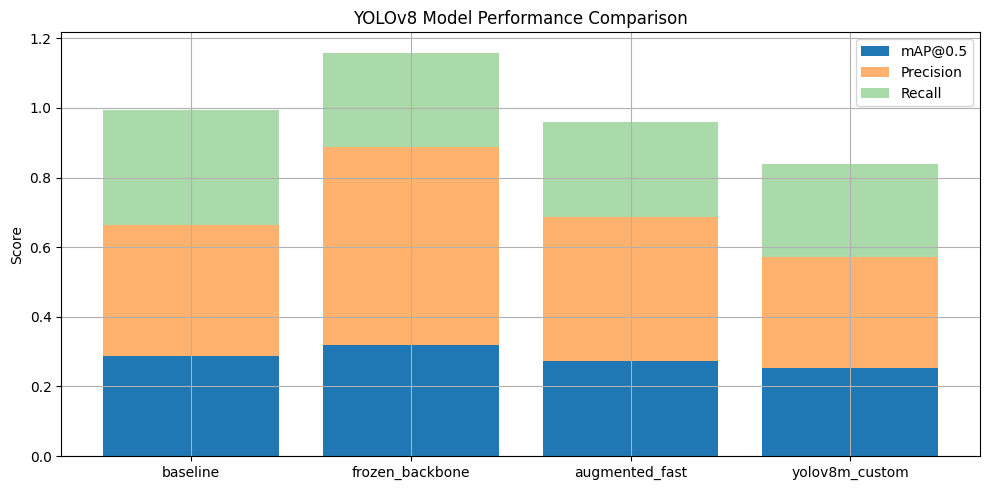

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# 11. Save results to CSV + plot comparison
df_results = pd.DataFrame(results_summary)
df_results.to_csv(f"{output_base}/summary_metrics.csv", index=False)
print("📊 Model Comparison Metrics:\n")
print(df_results)

# Plot comparison
plt.figure(figsize=(10, 5))
x = df_results["Model"]
plt.bar(x, df_results["mAP50"], label="mAP@0.5")
plt.bar(x, df_results["Precision"], bottom=df_results["mAP50"], label="Precision", alpha=0.6)
plt.bar(x, df_results["Recall"], bottom=df_results["mAP50"] + df_results["Precision"], label="Recall", alpha=0.4)
plt.ylabel("Score")
plt.title("YOLOv8 Model Performance Comparison")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.savefig(f"{output_base}/model_performance_comparison.png")
plt.show()


In [14]:
!pip install transformers
!pip install -q timm

In [ ]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)


In [28]:
# Folder of super-resolved artworks
artworks_folder = "/content/drive/MyDrive/artworks_superres"

# Collect up to 5 images per artist
sample_images = []

for artist in os.listdir(artworks_folder):
    artist_path = os.path.join(artworks_folder, artist)
    if not os.path.isdir(artist_path):
        continue

    count = 0
    for f in sorted(os.listdir(artist_path)):
        if f.lower().endswith((".jpg", ".png")):
            sample_images.append(os.path.join(artist_path, f))
            count += 1
            if count >= 10:
                break  # stop after 5 images per artist

print(f"✅ Collected {len(sample_images)} sample images across artists.")


✅ Collected 250 sample images across artists.


In [29]:
captions = {}

for img_path in sample_images:
    raw_image = Image.open(img_path).convert("RGB")
    inputs = processor(raw_image, return_tensors="pt").to(device)

    out = model.generate(**inputs)
    caption = processor.decode(out[0], skip_special_tokens=True)

    captions[os.path.basename(img_path)] = caption
    print(f"{os.path.basename(img_path)} → {caption}")


Andy_Warhol_1.jpg → two photos of a man in red shirt and purple pants
Andy_Warhol_10.jpg → a car crashed into a house in the early hours of the crash
Andy_Warhol_100.jpg → a painting of a fish on a green background
Andy_Warhol_101.jpg → the beatles
Andy_Warhol_102.jpg → a model of a truck on a table
Andy_Warhol_103.jpg → a painting of a truck with a trailer on it
Andy_Warhol_104.jpg → a painting of a truck with a green trailer
Andy_Warhol_105.jpg → a painting of a truck with a trailer on it
Andy_Warhol_106.jpg → a red shoe with holly and berries on it
Andy_Warhol_107.jpg → a painting of a man with a smile on his face
Camille_Pissarro_1.jpg → a painting of a bridge over a river
Camille_Pissarro_10.jpg → a painting of a farm with a thatched house
Camille_Pissarro_11.jpg → a painting of trees in the woods
Camille_Pissarro_12.jpg → a painting of a city street with people walking
Camille_Pissarro_13.jpg → a painting of a path through a forest
Camille_Pissarro_14.jpg → a painting of a city w

In [30]:
df_captions = pd.DataFrame(list(captions.items()), columns=["Image", "Caption"])
df_captions.to_csv("/content/drive/MyDrive/artwork_captions_blip.csv", index=False)
print("✅ Captions saved to Drive.")


✅ Captions saved to Drive.


In [ ]:
import math
import matplotlib.pyplot as plt
from PIL import Image

n = 250  # total images to display
cols = 5
rows = math.ceil(n / cols)

fig, axs = plt.subplots(rows, cols, figsize=(20, rows * 4))  # Adjust height based on rows

for i in range(rows * cols):
    r = i // cols
    c = i % cols

    ax = axs[r, c] if rows > 1 else axs[c]

    if i < len(sample_images):
        img_path = sample_images[i]
        img = Image.open(img_path).convert("RGB")
        caption = captions.get(os.path.basename(img_path), "No caption")

        ax.imshow(img)
        ax.set_title(caption, fontsize=8)
    else:
        ax.axis("off")  # Hide unused subplots

    ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
from transformers import CLIPProcessor, CLIPModel
import torch

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

similarities = []

for img_path in sample_images:
    image = Image.open(img_path).convert("RGB")
    caption = captions[os.path.basename(img_path)]

    inputs = clip_processor(text=[caption], images=image, return_tensors="pt", padding=True).to(device)
    outputs = clip_model(**inputs)

    # Compute cosine similarity between image and text embeddings
    image_embeds = outputs.image_embeds
    text_embeds = outputs.text_embeds

    sim = torch.cosine_similarity(image_embeds, text_embeds).item()
    similarities.append(sim)

avg_similarity = sum(similarities) / len(similarities)
print(f"🔗 Average CLIP-based image-text similarity: {avg_similarity:.4f}")
